In [1]:
# Design CIS 3D color router
# Resoultion 20 
# RGGB pattern
# First FoM: -22.775187623735164
# Current FoM: 264.1704627386973

# Elapsed run time = 57921.2683 s





# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

design_dir = "./CIS_result/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 1/0.675 # 1A = 675nm

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=2.1)
SiO2 = mp.Medium(index=1.4)
HfO2 = mp.Medium(index=1.9)
# SiPD = mp.Medium(epsilon=11.8)

# 해상도 및 사이즈 설정
resolution = 25 # 1 pixel = 27nm
ar_thk = 0.081 * um_scale # AR thickness
fl_size = 0.513 * um_scale # focal layer size
ml_size = 0.216 * um_scale # multi layer size
el_size = 0.027 * um_scale # etch layer size

dti_thk = ar_thk * 2 # DTI thickness 
sp_size = 0.621 * um_scale # subpixel size
# sp_size = 2 * um_scale # SiPD size

Lpml = 0.5 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml)]
Sourcespace = 0.5

# 설계 공간
design_region_width_x = sp_size * 4 # 디자인 영역 x
design_region_width_y = sp_size * 4 # 디자인 영역 y
design_region_height = ml_size * 5 + el_size * 4 # 디자인 영역 높이 z

# 전체 공간
Sx = design_region_width_x + Lpml * 2 
Sy = design_region_width_y + Lpml * 2 
Sz = Lpml + ar_thk + fl_size + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)


# 파장, 주파수 설정
wavelengths = np.linspace(0.425*um_scale, 0.655*um_scale, 24) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# Fabrication Constraints 설정

minimum_length = 0.027 * um_scale # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)


# source 설정
width = 0.4

fcen_red = 1/(0.625*um_scale)
fwidth_red = fcen_red * width

fcen_green = 1/(0.545*um_scale)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.455*um_scale)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

source = [mp.Source(src_0, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center,)]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)/2) 
Ny = int(round(design_region_resolution * design_region_width_y)/2) 
Nz = int(round(design_region_resolution * design_region_height))

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, SiN, grid_type="U_MEAN",do_averaging=False)

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

# 대각선대칭

def mapping(x, eta, beta):
    x_copy = (x.reshape(Nx * Ny, Nz)).transpose()

    # projection
    z = 0
    x2 = []

    while z < Nz:
        
        number = z
        x1 = x_copy[int(number)]
        
        # filter
        filtered_field = mpa.conic_filter(
            x1,
            filter_radius,
            1.8,
            1.8,
            design_region_resolution,
        )
        
        z_slice = ((filtered_field.reshape(Nx, Ny)) + filtered_field.reshape(Nx, Ny).transpose()) / 2
        x2 = npa.concatenate((x2,z_slice.flatten()),axis=0) 
        z = z + 1

    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    
    x2 = (x2.reshape(Nx * Ny, Nz)).transpose()
        
    # Compute the mean for the pairs of columns
    mean_columns_1layer = npa.mean(x2[:8, :], axis=0)  # Mean for columns 
    mean_columns_2layer = npa.mean(x2[9:17, :], axis=0)  # Mean for columns 
    mean_columns_3layer = npa.mean(x2[18:26, :], axis=0)  # Mean for columns 
    mean_columns_4layer = npa.mean(x2[27:35, :], axis=0)  # Mean for columns 
    mean_columns_5layer = npa.mean(x2[36:44, :], axis=0)  # Mean for columns 
    
    # Create new arrays with mean values
    new_x2_1layer = npa.tile(mean_columns_1layer, 8).reshape(8, -1).flatten()
    new_x2_1layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_2layer = npa.tile(mean_columns_2layer, 8).reshape(8, -1).flatten()
    new_x2_2layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_3layer = npa.tile(mean_columns_3layer, 8).reshape(8, -1).flatten()
    new_x2_3layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_4layer = npa.tile(mean_columns_4layer, 8).reshape(8, -1).flatten()
    new_x2_4layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_5layer = npa.tile(mean_columns_5layer, 8).reshape(8, -1).flatten()
    
    # Concatenate the arrays to get the final result
    x2 = npa.concatenate([new_x2_1layer, new_x2_1layer_e,new_x2_2layer, new_x2_2layer_e,new_x2_3layer, new_x2_3layer_e,new_x2_4layer, new_x2_4layer_e,new_x2_5layer],axis=0)
    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    x2 = mpa.tanh_projection(x2, beta, eta).flatten()
    x = x2

    return x


# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),

    # Focal Layer
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size/2), size=mp.Vector3(Sx, Sy, fl_size), material=SiO2
    ),

    #AR coating
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size - ar_thk/2 - Lpml/2), size=mp.Vector3(Sx, Sy, ar_thk + Lpml), material=HfO2
    ),

    # # DTI가 있을 경우 사용
    # mp.Block(
    #     center=mp.Vector3(Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # )
]

# Meep simulation 세팅

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

###############################################################################################################################
# ## 2. Optimization Environment

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)

FourierFields_1_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ex,yee_grid=True)

FourierFields_2_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ex,yee_grid=True)

FourierFields_3_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ex,yee_grid=True)

FourierFields_0_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)

FourierFields_1_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)

FourierFields_2_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)

FourierFields_3_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)

ob_list = [FourierFields_0_x, FourierFields_0_y, FourierFields_1_x,FourierFields_1_y, FourierFields_2_x, FourierFields_2_y, FourierFields_3_x, FourierFields_3_y]


fred = []
fgreen = []
fblue = []
# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields_0_x, fields_0_y, fields_1_x, fields_1_y, fields_2_x, fields_2_y, fields_3_x, fields_3_y):
    red = npa.sum(npa.abs(fields_1_x[17:23,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[17:23,1]) ** 2)
    green = npa.sum(npa.abs(fields_0_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_0_y[9:15,1]) ** 2) + npa.sum(npa.abs(fields_2_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_2_y[9:15,1]) ** 2)
    blue = npa.sum(npa.abs(fields_3_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_3_y[0:6,1]) ** 2)
    redfactor = 1
    greenfactor = 0.7
    bluefactor = 0.5
    
    red_c = npa.sum(npa.abs(fields_1_x[0:6,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_1_x[9:15,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[9:15,1]) ** 2)
    green_c = npa.sum(npa.abs(fields_0_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_0_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_2_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_2_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_0_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_0_y[17:23,1]) ** 2) + npa.sum(npa.abs(fields_2_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_2_y[17:23,1]) ** 2)
    blue_c = npa.sum(npa.abs(fields_3_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_3_y[9:15,1]) ** 2) + npa.sum(npa.abs(fields_3_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_3_y[17:23,1]) ** 2)
    
    fred.append(red/redfactor)
    fgreen.append(green/greenfactor)
    fblue.append(blue/bluefactor)
    OE = blue/bluefactor + green/greenfactor + red/redfactor
    CT = blue_c/bluefactor + green_c/greenfactor + red_c/redfactor
    return OE - CT

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

# 함수 설정

evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    # f0, dJ_du = opt()

    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    np.savetxt(design_dir+"structure_0"+str(numevl) +".txt", design_variables.weights)
    
    numevl += 1
    
    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)


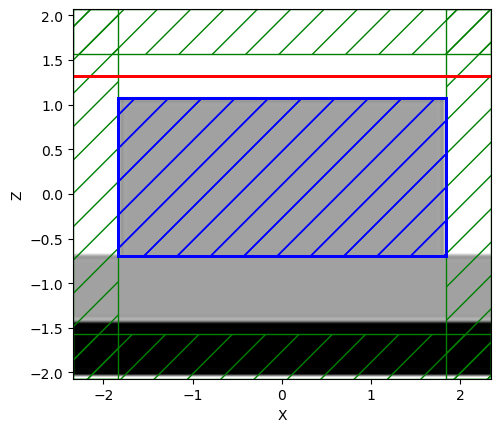

In [2]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [3]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [4]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298023 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87086 s
-----------
on time step 69 (time=1.38), 0.0580466 s/step
on time step 211 (time=4.22), 0.0282668 s/step
on time step 352 (time=7.04), 0.0284169 s/step
on time step 492 (time=9.84), 0.0286756 s/step
on time step 632 (time=12.64), 0.0287312 s/step
on time step 770 (time=15.4), 0.0290529 s/step
on time step 910 (time=18.2), 

/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)
/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


on time step 97 (time=1.94), 0.0412831 s/step
on time step 217 (time=4.34), 0.0334139 s/step
on time step 332 (time=6.64), 0.0349639 s/step
on time step 449 (time=8.98), 0.034661 s/step
on time step 568 (time=11.36), 0.0338582 s/step
on time step 686 (time=13.72), 0.0340022 s/step
on time step 804 (time=16.08), 0.0340286 s/step
on time step 925 (time=18.5), 0.0332614 s/step
on time step 1044 (time=20.88), 0.0336505 s/step
on time step 1163 (time=23.26), 0.0337246 s/step
on time step 1281 (time=25.62), 0.0339817 s/step
on time step 1402 (time=28.04), 0.0332816 s/step
on time step 1522 (time=30.44), 0.0335056 s/step
on time step 1640 (time=32.8), 0.0339394 s/step
on time step 1756 (time=35.12), 0.0345155 s/step
on time step 1872 (time=37.44), 0.0345099 s/step
on time step 1988 (time=39.76), 0.0347 s/step
on time step 2104 (time=42.08), 0.0345319 s/step
on time step 2220 (time=44.4), 0.0347838 s/step
on time step 2337 (time=46.74), 0.034364 s/step
on time step 2454 (time=49.08), 0.0343674

In [5]:
print(dJ_du)
print(f0)


[[ 4.85447171e-04  2.77624852e-03  3.01648591e-03 ... -1.26530169e-03
  -1.12980886e-03 -2.75351897e-07]
 [ 9.29498221e-04  2.52229841e-03  2.01926846e-03 ... -1.21728051e-03
  -9.16285797e-04 -4.13241128e-06]
 [ 1.24994231e-03  2.24235259e-03  1.57065193e-03 ... -9.57602940e-04
  -6.07009660e-04 -6.36271368e-06]
 ...
 [-3.80188676e-04  2.29746534e-04  1.33728805e-03 ...  1.03017146e-03
   1.21065302e-03 -9.13329030e-06]
 [-3.12364618e-04  8.67494044e-05  9.02209351e-04 ...  9.42160107e-04
   1.20274019e-03 -7.36083624e-06]
 [-1.69798168e-04 -3.98874112e-05  2.65753617e-04 ...  5.58315319e-04
   8.18337026e-04 -5.41852090e-06]]
-110.22672965963416


In [6]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [7]:
db = 1e-5
choose = 1000
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000380039 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89421 s
-----------
on time step 80 (time=1.6), 0.050227 s/step
on time step 240 (time=4.8), 0.0251286 s/step
on time step 401 (time=8.02), 0.0248524 s/step
on time step 555 (time=11.1), 0.0260524 s/step
on time step 711 (time=14.22), 0.0256588 s/step
on time step 863 (time=17.26), 0.0264277 s/step
on time step 1022 (time=20.44), 0.0251631 s/step


run 2 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06626 s
-----------
on time step 80 (time=1.6), 0.0503296 s/step
on time step 242 (time=4.84), 0.0248045 s/step
on time step 403 (time=8.06), 0.0248496 s/step
on time step 563 (time=11.26), 0.025126 s/step
on time step 719 (time=14.38), 0.0256996 s/step
on time step 878 (time=17.56), 0.0252303 s/step
on time st

run 3 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.9011 s
-----------
on time step 78 (time=1.56), 0.0513599 s/step
on time step 234 (time=4.68), 0.025671 s/step
on time step 389 (time=7.78), 0.0258506 s/step
on time step 544 (time=10.88), 0.0258479 s/step
on time step 701 (time=14.02), 0.0256338 s/step
on time step 853 (time=17.06), 0.0264513 s/step
on time st

run 4 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86762 s
-----------
on time step 81 (time=1.62), 0.0495338 s/step
on time step 245 (time=4.9), 0.0245275 s/step
on time step 406 (time=8.12), 0.0249596 s/step
on time step 567 (time=11.34), 0.0250075 s/step
on time step 727 (time=14.54), 0.0250793 s/step
on time step 890 (time=17.8), 0.0246055 s/step
on time st

run 5 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88786 s
-----------
on time step 81 (time=1.62), 0.0494764 s/step
on time step 237 (time=4.74), 0.0256449 s/step
on time step 395 (time=7.9), 0.0254605 s/step
on time step 551 (time=11.02), 0.0256748 s/step
on time step 707 (time=14.14), 0.0257329 s/step
on time step 858 (time=17.16), 0.0265705 s/step
on time s

run 6 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.10305 s
-----------
on time step 78 (time=1.56), 0.0515062 s/step
on time step 233 (time=4.66), 0.0258603 s/step
on time step 391 (time=7.82), 0.0253797 s/step
on time step 546 (time=10.92), 0.0258239 s/step
on time step 698 (time=13.96), 0.0263219 s/step
on time step 849 (time=16.98), 0.0266605 s/step
on time 

run 7 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000380993 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.01401 s
-----------
on time step 28 (time=0.56), 0.14478 s/step
on time step 86 (time=1.72), 0.0697479 s/step
on time step 174 (time=3.48), 0.0455495 s/step
on time step 336 (time=6.72), 0.0247815 s/step
on time step 495 (time=9.9), 0.0252436 s/step
on time step 652 (time=13.04), 0.0255566 s/step
on time step 8

run 8 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85667 s
-----------
on time step 79 (time=1.58), 0.0507924 s/step
on time step 240 (time=4.8), 0.0248904 s/step
on time step 398 (time=7.96), 0.0253255 s/step
on time step 558 (time=11.16), 0.0251091 s/step
on time step 717 (time=14.34), 0.0251952 s/step
on time step 876 (time=17.52), 0.0251576 s/step
on time s

run 9 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89792 s
-----------
on time step 76 (time=1.52), 0.0528335 s/step
on time step 232 (time=4.64), 0.0257892 s/step
on time step 390 (time=7.8), 0.0253201 s/step
on time step 547 (time=10.94), 0.0254988 s/step
on time step 709 (time=14.18), 0.0247461 s/step
on time step 872 (time=17.44), 0.0246047 s/step
on time s

run 10 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87092 s
-----------
on time step 79 (time=1.58), 0.050955 s/step
on time step 233 (time=4.66), 0.0259989 s/step
on time step 393 (time=7.86), 0.0250127 s/step
on time step 553 (time=11.06), 0.0250909 s/step
on time step 713 (time=14.26), 0.0251043 s/step
on time step 872 (time=17.44), 0.0251825 s/step
on time 

run 11 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85822 s
-----------
on time step 81 (time=1.62), 0.0496458 s/step
on time step 241 (time=4.82), 0.0250766 s/step
on time step 401 (time=8.02), 0.0250111 s/step
on time step 559 (time=11.18), 0.0254486 s/step
on time step 721 (time=14.42), 0.0247661 s/step
on time step 882 (time=17.64), 0.0249569 s/step
on time

run 12 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271797 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87769 s
-----------
on time step 80 (time=1.6), 0.0500729 s/step
on time step 240 (time=4.8), 0.0251396 s/step
on time step 400 (time=8), 0.0251434 s/step
on time step 561 (time=11.22), 0.0248646 s/step
on time step 720 (time=14.4), 0.0251694 s/step
on time step 883 (time=17.66), 0.0246173 s/step
on time step 

run 13 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86312 s
-----------
on time step 80 (time=1.6), 0.0502709 s/step
on time step 238 (time=4.76), 0.0253444 s/step
on time step 395 (time=7.9), 0.0255508 s/step
on time step 551 (time=11.02), 0.0257434 s/step
on time step 707 (time=14.14), 0.025788 s/step
on time step 863 (time=17.26), 0.0256947 s/step
on time st

run 14 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90444 s
-----------
on time step 78 (time=1.56), 0.0514698 s/step
on time step 237 (time=4.74), 0.0252382 s/step
on time step 393 (time=7.86), 0.0257628 s/step
on time step 548 (time=10.96), 0.0259086 s/step
on time step 706 (time=14.12), 0.0253865 s/step
on time step 865 (time=17.3), 0.0251586 s/step
on time 

run 15 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89998 s
-----------
on time step 79 (time=1.58), 0.0509513 s/step
on time step 239 (time=4.78), 0.025144 s/step
on time step 394 (time=7.88), 0.0258922 s/step
on time step 550 (time=11), 0.0257391 s/step
on time step 707 (time=14.14), 0.0255249 s/step
on time step 861 (time=17.22), 0.0260168 s/step
on time ste

run 16 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89048 s
-----------
on time step 80 (time=1.6), 0.0500542 s/step
on time step 236 (time=4.72), 0.0256796 s/step
on time step 392 (time=7.84), 0.0257528 s/step
on time step 551 (time=11.02), 0.0251701 s/step
on time step 708 (time=14.16), 0.0255582 s/step
on time step 865 (time=17.3), 0.0255715 s/step
on time s

run 17 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8625 s
-----------
on time step 80 (time=1.6), 0.0502559 s/step
on time step 241 (time=4.82), 0.0248457 s/step
on time step 402 (time=8.04), 0.0249277 s/step
on time step 563 (time=11.26), 0.0248505 s/step
on time step 724 (time=14.48), 0.0249662 s/step
on time step 884 (time=17.68), 0.0251451 s/step
on time s

run 18 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8623 s
-----------
on time step 81 (time=1.62), 0.0496205 s/step
on time step 241 (time=4.82), 0.0250135 s/step
on time step 395 (time=7.9), 0.0259896 s/step
on time step 552 (time=11.04), 0.0255297 s/step
on time step 712 (time=14.24), 0.0250372 s/step
on time step 870 (time=17.4), 0.025437 s/step
on time ste

run 19 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87085 s
-----------
on time step 80 (time=1.6), 0.0501306 s/step
on time step 242 (time=4.84), 0.0247997 s/step
on time step 403 (time=8.06), 0.0249054 s/step
on time step 565 (time=11.3), 0.0248129 s/step
on time step 727 (time=14.54), 0.0247588 s/step
on time step 888 (time=17.76), 0.024859 s/step
on time st

run 20 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86169 s
-----------
on time step 80 (time=1.6), 0.0500071 s/step
on time step 242 (time=4.84), 0.0247876 s/step
on time step 404 (time=8.08), 0.0248326 s/step
on time step 566 (time=11.32), 0.0247859 s/step
on time step 728 (time=14.56), 0.0247118 s/step
on time step 890 (time=17.8), 0.0247242 s/step
on time s

run 21 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86209 s
-----------
on time step 80 (time=1.6), 0.0500984 s/step
on time step 242 (time=4.84), 0.0248206 s/step
on time step 403 (time=8.06), 0.0248843 s/step
on time step 565 (time=11.3), 0.0248051 s/step
on time step 726 (time=14.52), 0.0248467 s/step
on time step 888 (time=17.76), 0.0247746 s/step
on time s

run 22 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.07913 s
-----------
on time step 79 (time=1.58), 0.050854 s/step
on time step 236 (time=4.72), 0.0255701 s/step
on time step 393 (time=7.86), 0.0254778 s/step
on time step 555 (time=11.1), 0.0246978 s/step
on time step 718 (time=14.36), 0.0246436 s/step
on time step 880 (time=17.6), 0.0247048 s/step
on time st

run 23 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.03817 s
-----------
on time step 77 (time=1.54), 0.0520428 s/step
on time step 235 (time=4.7), 0.0254455 s/step
on time step 390 (time=7.8), 0.025881 s/step
on time step 546 (time=10.92), 0.0256981 s/step
on time step 701 (time=14.02), 0.0258081 s/step
on time step 859 (time=17.18), 0.0253652 s/step
on time st

run 24 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000310898 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06653 s
-----------
on time step 77 (time=1.54), 0.0522469 s/step
on time step 233 (time=4.66), 0.0257916 s/step
on time step 392 (time=7.84), 0.0252803 s/step
on time step 546 (time=10.92), 0.0260715 s/step
on time step 700 (time=14), 0.025977 s/step
on time step 855 (time=17.1), 0.0259482 s/step
on time step

run 25 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89413 s
-----------
on time step 80 (time=1.6), 0.0502172 s/step
on time step 242 (time=4.84), 0.0247954 s/step
on time step 402 (time=8.04), 0.025117 s/step
on time step 560 (time=11.2), 0.0254653 s/step
on time step 716 (time=14.32), 0.0257124 s/step
on time step 876 (time=17.52), 0.0250657 s/step
on time ste

run 26 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.1078 s
-----------
on time step 78 (time=1.56), 0.0514649 s/step
on time step 235 (time=4.7), 0.0256171 s/step
on time step 391 (time=7.82), 0.0257346 s/step
on time step 551 (time=11.02), 0.0250452 s/step
on time step 709 (time=14.18), 0.0253654 s/step
on time step 868 (time=17.36), 0.0251698 s/step
on time s

run 27 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.875 s
-----------
on time step 74 (time=1.48), 0.0543173 s/step
on time step 233 (time=4.66), 0.0252677 s/step
on time step 392 (time=7.84), 0.0252789 s/step
on time step 552 (time=11.04), 0.0250013 s/step
on time step 713 (time=14.26), 0.0248823 s/step
on time step 874 (time=17.48), 0.0249217 s/step
on time s

run 28 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.10918 s
-----------
on time step 76 (time=1.52), 0.0526966 s/step
on time step 226 (time=4.52), 0.0266995 s/step
on time step 383 (time=7.66), 0.0256233 s/step
on time step 543 (time=10.86), 0.0251597 s/step
on time step 701 (time=14.02), 0.0254625 s/step
on time step 861 (time=17.22), 0.0251361 s/step
on time

run 29 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06955 s
-----------
on time step 78 (time=1.56), 0.0513655 s/step
on time step 232 (time=4.64), 0.0260469 s/step
on time step 391 (time=7.82), 0.0252793 s/step
on time step 550 (time=11), 0.0252328 s/step
on time step 702 (time=14.04), 0.0263544 s/step
on time step 856 (time=17.12), 0.025982 s/step
on time step

run 30 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.91524 s
-----------
on time step 75 (time=1.5), 0.0535058 s/step
on time step 232 (time=4.64), 0.0254896 s/step
on time step 385 (time=7.7), 0.0261736 s/step
on time step 544 (time=10.88), 0.0251738 s/step
on time step 703 (time=14.06), 0.0252803 s/step
on time step 863 (time=17.26), 0.0251388 s/step
on time s

run 31 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89493 s
-----------
on time step 76 (time=1.52), 0.0528083 s/step
on time step 225 (time=4.5), 0.0269025 s/step
on time step 376 (time=7.52), 0.0265379 s/step
on time step 534 (time=10.68), 0.0253389 s/step
on time step 694 (time=13.88), 0.0250126 s/step
on time step 844 (time=16.88), 0.0267906 s/step
on time 

run 32 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89162 s
-----------
on time step 80 (time=1.6), 0.0500941 s/step
on time step 240 (time=4.8), 0.025073 s/step
on time step 401 (time=8.02), 0.0249782 s/step
on time step 559 (time=11.18), 0.0253797 s/step
on time step 716 (time=14.32), 0.0255444 s/step
on time step 875 (time=17.5), 0.0252099 s/step
on time ste

run 33 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.07133 s
-----------
on time step 76 (time=1.52), 0.0527442 s/step
on time step 229 (time=4.58), 0.026293 s/step
on time step 377 (time=7.54), 0.0271297 s/step
on time step 528 (time=10.56), 0.0266465 s/step
on time step 668 (time=13.36), 0.0286076 s/step
on time step 820 (time=16.4), 0.0263503 s/step
on time s

run 34 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86768 s
-----------
on time step 75 (time=1.5), 0.0535465 s/step
on time step 235 (time=4.7), 0.0250241 s/step
on time step 387 (time=7.74), 0.0263352 s/step
on time step 533 (time=10.66), 0.0274085 s/step
on time step 692 (time=13.84), 0.0252335 s/step
on time step 852 (time=17.04), 0.0250247 s/step
on time s

run 35 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88349 s
-----------
on time step 81 (time=1.62), 0.0494326 s/step
on time step 239 (time=4.78), 0.0254027 s/step
on time step 397 (time=7.94), 0.0254435 s/step
on time step 557 (time=11.14), 0.0250812 s/step
on time step 716 (time=14.32), 0.02524 s/step
on time step 873 (time=17.46), 0.0255926 s/step
on time s

run 36 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89261 s
-----------
on time step 77 (time=1.54), 0.0519816 s/step
on time step 233 (time=4.66), 0.0257895 s/step
on time step 391 (time=7.82), 0.0254623 s/step
on time step 551 (time=11.02), 0.0251144 s/step
on time step 707 (time=14.14), 0.0257055 s/step
on time step 853 (time=17.06), 0.0275836 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.92799 s
-----------
on time step 78 (time=1.56), 0.0514612 s/step
on time step 234 (time=4.68), 0.0257028 s/step
on time step 391 (time=7.82), 0.0255977 s/step
on time step 550 (time=11), 0.0252813 s/step
on time step 703 (time=14.06), 0.0261576 s/step
on time step 860 (time=17.2), 0.0255739 s/step
on time step 1014 (time=20.28), 0.0260328 s/step


run 38 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89429 s
-----------
on time step 77 (time=1.54), 0.0521684 s/step
on time step 232 (time=4.64), 0.0258493 s/step
on time step 390 (time=7.8), 0.0253778 s/step
on time step 551 (time=11.02), 0.0249908 s/step
on time step 708 (time=14.16), 0.0255578 s/step
on time step 864 (time=17.28), 0.0257424 s/step
on time 

run 39 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.04807 s
-----------
on time step 76 (time=1.52), 0.0527519 s/step
on time step 231 (time=4.62), 0.0259072 s/step
on time step 386 (time=7.72), 0.0259094 s/step
on time step 543 (time=10.86), 0.0255036 s/step
on time step 704 (time=14.08), 0.0249583 s/step
on time step 862 (time=17.24), 0.0253906 s/step
on time

run 40 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86745 s
-----------
on time step 78 (time=1.56), 0.0514682 s/step
on time step 237 (time=4.74), 0.0252271 s/step
on time step 394 (time=7.88), 0.0256143 s/step
on time step 551 (time=11.02), 0.0255502 s/step
on time step 711 (time=14.22), 0.02515 s/step
on time step 869 (time=17.38), 0.0254508 s/step
on time s

run 41 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89915 s
-----------
on time step 73 (time=1.46), 0.0551225 s/step
on time step 228 (time=4.56), 0.0259467 s/step
on time step 385 (time=7.7), 0.0255709 s/step
on time step 540 (time=10.8), 0.0258775 s/step
on time step 699 (time=13.98), 0.0251943 s/step
on time step 849 (time=16.98), 0.0267167 s/step
on time s

run 42 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.09871 s
-----------
on time step 76 (time=1.52), 0.05268 s/step
on time step 227 (time=4.54), 0.0265333 s/step
on time step 387 (time=7.74), 0.0250461 s/step
on time step 541 (time=10.82), 0.0260016 s/step
on time step 702 (time=14.04), 0.0249475 s/step
on time step 860 (time=17.2), 0.0253729 s/step
on time ste

run 43 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00041914 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8815 s
-----------
on time step 78 (time=1.56), 0.051397 s/step
on time step 239 (time=4.78), 0.0248712 s/step
on time step 400 (time=8), 0.0248486 s/step
on time step 562 (time=11.24), 0.0247265 s/step
on time step 722 (time=14.44), 0.0251204 s/step
on time step 882 (time=17.64), 0.0251288 s/step
on time step 

run 44 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87826 s
-----------
on time step 77 (time=1.54), 0.0521821 s/step
on time step 237 (time=4.74), 0.0251003 s/step
on time step 395 (time=7.9), 0.0254036 s/step
on time step 552 (time=11.04), 0.0255771 s/step
on time step 712 (time=14.24), 0.025153 s/step
on time step 872 (time=17.44), 0.0251181 s/step
on time s

run 45 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88894 s
-----------
on time step 80 (time=1.6), 0.0501625 s/step
on time step 241 (time=4.82), 0.0248734 s/step
on time step 400 (time=8), 0.0251795 s/step
on time step 554 (time=11.08), 0.0259751 s/step
on time step 711 (time=14.22), 0.0255949 s/step
on time step 872 (time=17.44), 0.0249778 s/step
on time step

run 46 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90109 s
-----------
on time step 77 (time=1.54), 0.0522043 s/step
on time step 238 (time=4.76), 0.024948 s/step
on time step 400 (time=8), 0.0248431 s/step
on time step 560 (time=11.2), 0.0250559 s/step
on time step 720 (time=14.4), 0.0250026 s/step
on time step 883 (time=17.66), 0.0245755 s/step
on time step 

run 47 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86749 s
-----------
on time step 77 (time=1.54), 0.0519889 s/step
on time step 234 (time=4.68), 0.02565 s/step
on time step 391 (time=7.82), 0.0255302 s/step
on time step 549 (time=10.98), 0.0254447 s/step
on time step 709 (time=14.18), 0.0250568 s/step
on time step 868 (time=17.36), 0.0253165 s/step
on time s

run 48 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87472 s
-----------
on time step 76 (time=1.52), 0.0528486 s/step
on time step 235 (time=4.7), 0.0252914 s/step
on time step 395 (time=7.9), 0.0251569 s/step
on time step 557 (time=11.14), 0.0247416 s/step
on time step 717 (time=14.34), 0.0250014 s/step
on time step 879 (time=17.58), 0.0247058 s/step
on time s

run 49 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88974 s
-----------
on time step 80 (time=1.6), 0.0503286 s/step
on time step 237 (time=4.74), 0.0255615 s/step
on time step 398 (time=7.96), 0.0249734 s/step
on time step 559 (time=11.18), 0.0249901 s/step
on time step 720 (time=14.4), 0.0248899 s/step
on time step 879 (time=17.58), 0.0252433 s/step
on time s

run 50 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86462 s
-----------
on time step 80 (time=1.6), 0.0501285 s/step
on time step 242 (time=4.84), 0.024826 s/step
on time step 403 (time=8.06), 0.024909 s/step
on time step 564 (time=11.28), 0.0248563 s/step
on time step 725 (time=14.5), 0.0248871 s/step
on time step 887 (time=17.74), 0.0248254 s/step
on time ste

run 51 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271797 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.08736 s
-----------
on time step 78 (time=1.56), 0.0513418 s/step
on time step 240 (time=4.8), 0.0247127 s/step
on time step 400 (time=8), 0.0250421 s/step
on time step 560 (time=11.2), 0.0250372 s/step
on time step 720 (time=14.4), 0.0250822 s/step
on time step 880 (time=17.6), 0.0251208 s/step
on time step 1

run 52 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06615 s
-----------
on time step 80 (time=1.6), 0.0501051 s/step
on time step 242 (time=4.84), 0.0247889 s/step
on time step 403 (time=8.06), 0.0248862 s/step
on time step 566 (time=11.32), 0.0246207 s/step
on time step 726 (time=14.52), 0.025122 s/step
on time step 885 (time=17.7), 0.0251782 s/step
on time st

run 53 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86568 s
-----------
on time step 80 (time=1.6), 0.0501704 s/step
on time step 237 (time=4.74), 0.0255484 s/step
on time step 396 (time=7.92), 0.0252113 s/step
on time step 553 (time=11.06), 0.0256369 s/step
on time step 711 (time=14.22), 0.0253877 s/step
on time step 873 (time=17.46), 0.0247443 s/step
on time 

run 54 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90728 s
-----------
on time step 80 (time=1.6), 0.0502762 s/step
on time step 239 (time=4.78), 0.0252374 s/step
on time step 397 (time=7.94), 0.0253465 s/step
on time step 553 (time=11.06), 0.0257522 s/step
on time step 708 (time=14.16), 0.0259692 s/step
on time step 867 (time=17.34), 0.025301 s/step
on time s

run 55 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85808 s
-----------
on time step 81 (time=1.62), 0.049651 s/step
on time step 243 (time=4.86), 0.0247858 s/step
on time step 406 (time=8.12), 0.0246145 s/step
on time step 566 (time=11.32), 0.0250588 s/step
on time step 726 (time=14.52), 0.0250566 s/step
on time step 881 (time=17.62), 0.0259029 s/step
on time 

run 56 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.08946 s
-----------
on time step 77 (time=1.54), 0.0522902 s/step
on time step 232 (time=4.64), 0.0259151 s/step
on time step 388 (time=7.76), 0.025748 s/step
on time step 542 (time=10.84), 0.0260248 s/step
on time step 700 (time=14), 0.0254144 s/step
on time step 860 (time=17.2), 0.0251157 s/step
on time step

run 57 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86726 s
-----------
on time step 80 (time=1.6), 0.0501017 s/step
on time step 241 (time=4.82), 0.0248782 s/step
on time step 399 (time=7.98), 0.0253802 s/step
on time step 560 (time=11.2), 0.0249032 s/step
on time step 720 (time=14.4), 0.0251177 s/step
on time step 881 (time=17.62), 0.0249276 s/step
on time st

run 58 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.91462 s
-----------
on time step 80 (time=1.6), 0.0500743 s/step
on time step 236 (time=4.72), 0.025668 s/step
on time step 395 (time=7.9), 0.0251635 s/step
on time step 554 (time=11.08), 0.025287 s/step
on time step 715 (time=14.3), 0.0248455 s/step
on time step 877 (time=17.54), 0.0248372 s/step
on time step

run 59 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87796 s
-----------
on time step 78 (time=1.56), 0.0513057 s/step
on time step 237 (time=4.74), 0.0252325 s/step
on time step 395 (time=7.9), 0.0253949 s/step
on time step 556 (time=11.12), 0.0249847 s/step
on time step 715 (time=14.3), 0.0251617 s/step
on time step 875 (time=17.5), 0.0251018 s/step
on time st

run 60 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.08452 s
-----------
on time step 81 (time=1.62), 0.0494606 s/step
on time step 244 (time=4.88), 0.0246931 s/step
on time step 406 (time=8.12), 0.0247631 s/step
on time step 567 (time=11.34), 0.0248966 s/step
on time step 729 (time=14.58), 0.0247188 s/step
on time step 889 (time=17.78), 0.0250281 s/step
on time

run 61 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90288 s
-----------
on time step 79 (time=1.58), 0.0508339 s/step
on time step 240 (time=4.8), 0.0248955 s/step
on time step 401 (time=8.02), 0.0249045 s/step
on time step 558 (time=11.16), 0.0254789 s/step
on time step 713 (time=14.26), 0.0258798 s/step
on time step 868 (time=17.36), 0.0259643 s/step
on time 

run 62 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89037 s
-----------
on time step 81 (time=1.62), 0.0496184 s/step
on time step 244 (time=4.88), 0.0246765 s/step
on time step 406 (time=8.12), 0.0247135 s/step
on time step 569 (time=11.38), 0.0246474 s/step
on time step 729 (time=14.58), 0.0251164 s/step
on time step 892 (time=17.84), 0.0246863 s/step
on time

run 63 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88861 s
-----------
on time step 79 (time=1.58), 0.050839 s/step
on time step 239 (time=4.78), 0.0250786 s/step
on time step 397 (time=7.94), 0.0254745 s/step
on time step 558 (time=11.16), 0.0248507 s/step
on time step 720 (time=14.4), 0.0248141 s/step
on time step 879 (time=17.58), 0.0251996 s/step
on time s

run 64 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87093 s
-----------
on time step 79 (time=1.58), 0.0509079 s/step
on time step 241 (time=4.82), 0.0247593 s/step
on time step 404 (time=8.08), 0.0246669 s/step
on time step 566 (time=11.32), 0.0247306 s/step
on time step 726 (time=14.52), 0.0250722 s/step
on time step 887 (time=17.74), 0.0248622 s/step
on time

run 65 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.09356 s
-----------
on time step 79 (time=1.58), 0.0508561 s/step
on time step 235 (time=4.7), 0.0257229 s/step
on time step 392 (time=7.84), 0.0255713 s/step
on time step 545 (time=10.9), 0.0262418 s/step
on time step 697 (time=13.94), 0.0264001 s/step
on time step 849 (time=16.98), 0.0264118 s/step
on time st

run 66 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87103 s
-----------
on time step 78 (time=1.56), 0.0513349 s/step
on time step 236 (time=4.72), 0.0253971 s/step
on time step 398 (time=7.96), 0.0248364 s/step
on time step 559 (time=11.18), 0.0249836 s/step
on time step 718 (time=14.36), 0.0251782 s/step
on time step 880 (time=17.6), 0.0247316 s/step
on time 

run 67 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87953 s
-----------
on time step 80 (time=1.6), 0.0501867 s/step
on time step 237 (time=4.74), 0.0254904 s/step
on time step 398 (time=7.96), 0.0249749 s/step
on time step 559 (time=11.18), 0.024978 s/step
on time step 719 (time=14.38), 0.0250534 s/step
on time step 881 (time=17.62), 0.0248217 s/step
on time s

run 68 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89605 s
-----------
on time step 81 (time=1.62), 0.0496964 s/step
on time step 241 (time=4.82), 0.0250457 s/step
on time step 403 (time=8.06), 0.0248285 s/step
on time step 564 (time=11.28), 0.0249146 s/step
on time step 720 (time=14.4), 0.0256788 s/step
on time step 876 (time=17.52), 0.0256668 s/step
on time 

run 69 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85407 s
-----------
on time step 79 (time=1.58), 0.050689 s/step
on time step 240 (time=4.8), 0.0249057 s/step
on time step 399 (time=7.98), 0.0251628 s/step
on time step 557 (time=11.14), 0.0253429 s/step
on time step 714 (time=14.28), 0.0255769 s/step
on time step 874 (time=17.48), 0.0250149 s/step
on time s

run 70 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273228 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.07038 s
-----------
on time step 75 (time=1.5), 0.0535276 s/step
on time step 230 (time=4.6), 0.0259625 s/step
on time step 384 (time=7.68), 0.0260425 s/step
on time step 540 (time=10.8), 0.0257348 s/step
on time step 694 (time=13.88), 0.0260599 s/step
on time step 850 (time=17), 0.0256785 s/step
on time step 

run 71 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90033 s
-----------
on time step 76 (time=1.52), 0.0526951 s/step
on time step 230 (time=4.6), 0.026106 s/step
on time step 384 (time=7.68), 0.0260212 s/step
on time step 545 (time=10.9), 0.024959 s/step
on time step 707 (time=14.14), 0.0246947 s/step
on time step 866 (time=17.32), 0.0252303 s/step
on time ste

run 72 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90993 s
-----------
on time step 80 (time=1.6), 0.0501291 s/step
on time step 240 (time=4.8), 0.0250983 s/step
on time step 403 (time=8.06), 0.0246257 s/step
on time step 566 (time=11.32), 0.0245905 s/step
on time step 728 (time=14.56), 0.024706 s/step
on time step 888 (time=17.76), 0.025018 s/step
on time ste

run 73 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.0978 s
-----------
on time step 80 (time=1.6), 0.0500362 s/step
on time step 239 (time=4.78), 0.0252635 s/step
on time step 399 (time=7.98), 0.0251093 s/step
on time step 559 (time=11.18), 0.0250809 s/step
on time step 722 (time=14.44), 0.0246317 s/step
on time step 883 (time=17.66), 0.0249118 s/step
on time s

run 74 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86363 s
-----------
on time step 82 (time=1.64), 0.0490534 s/step
on time step 241 (time=4.82), 0.0252401 s/step
on time step 401 (time=8.02), 0.0250768 s/step
on time step 561 (time=11.22), 0.0251073 s/step
on time step 720 (time=14.4), 0.0252041 s/step
on time step 880 (time=17.6), 0.0251398 s/step
on time s

run 75 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85083 s
-----------
on time step 81 (time=1.62), 0.0495984 s/step
on time step 243 (time=4.86), 0.0248036 s/step
on time step 405 (time=8.1), 0.0247828 s/step
on time step 565 (time=11.3), 0.0250078 s/step
on time step 725 (time=14.5), 0.0251255 s/step
on time step 885 (time=17.7), 0.0250289 s/step
on time ste

run 76 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87266 s
-----------
on time step 81 (time=1.62), 0.049541 s/step
on time step 244 (time=4.88), 0.0246673 s/step
on time step 406 (time=8.12), 0.024806 s/step
on time step 569 (time=11.38), 0.0246755 s/step
on time step 732 (time=14.64), 0.024662 s/step
on time step 894 (time=17.88), 0.0248207 s/step
on time st

run 77 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85739 s
-----------
on time step 76 (time=1.52), 0.0529031 s/step
on time step 236 (time=4.72), 0.0251217 s/step
on time step 397 (time=7.94), 0.0249163 s/step
on time step 558 (time=11.16), 0.0248926 s/step
on time step 717 (time=14.34), 0.0252684 s/step
on time step 876 (time=17.52), 0.0251659 s/step
on time

run 78 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88991 s
-----------
on time step 78 (time=1.56), 0.0513082 s/step
on time step 239 (time=4.78), 0.0249622 s/step
on time step 399 (time=7.98), 0.0250577 s/step
on time step 559 (time=11.18), 0.0251464 s/step
on time step 718 (time=14.36), 0.0251667 s/step
on time step 878 (time=17.56), 0.0251359 s/step
on time

run 79 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89771 s
-----------
on time step 79 (time=1.58), 0.0509311 s/step
on time step 234 (time=4.68), 0.0259213 s/step
on time step 390 (time=7.8), 0.0257697 s/step
on time step 549 (time=10.98), 0.0252563 s/step
on time step 707 (time=14.14), 0.0254498 s/step
on time step 864 (time=17.28), 0.0255402 s/step
on time 

run 80 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271797 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86277 s
-----------
on time step 81 (time=1.62), 0.0495599 s/step
on time step 242 (time=4.84), 0.0249955 s/step
on time step 402 (time=8.04), 0.0250009 s/step
on time step 562 (time=11.24), 0.0250849 s/step
on time step 722 (time=14.44), 0.0250757 s/step
on time step 882 (time=17.64), 0.0251334 s/step
on time

run 81 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88281 s
-----------
on time step 79 (time=1.58), 0.0506822 s/step
on time step 239 (time=4.78), 0.0250585 s/step
on time step 399 (time=7.98), 0.0251385 s/step
on time step 559 (time=11.18), 0.0250777 s/step
on time step 719 (time=14.38), 0.0250818 s/step
on time step 879 (time=17.58), 0.0250139 s/step
on time 

run 82 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.01498 s
-----------
on time step 82 (time=1.64), 0.0490461 s/step
on time step 245 (time=4.9), 0.0245754 s/step
on time step 406 (time=8.12), 0.0249107 s/step
on time step 566 (time=11.32), 0.0250968 s/step
on time step 727 (time=14.54), 0.0249469 s/step
on time step 891 (time=17.82), 0.0244478 s/step
on time 

run 83 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8699 s
-----------
on time step 80 (time=1.6), 0.050051 s/step
on time step 243 (time=4.86), 0.0245457 s/step
on time step 407 (time=8.14), 0.0244346 s/step
on time step 571 (time=11.42), 0.0245359 s/step
on time step 735 (time=14.7), 0.0245035 s/step
on time step 897 (time=17.94), 0.024738 s/step
on time step

run 84 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000334978 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85896 s
-----------
on time step 81 (time=1.62), 0.0496488 s/step
on time step 242 (time=4.84), 0.0249617 s/step
on time step 404 (time=8.08), 0.024759 s/step
on time step 567 (time=11.34), 0.0246022 s/step
on time step 730 (time=14.6), 0.0245957 s/step
on time step 893 (time=17.86), 0.0245609 s/step
on time s

run 85 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87106 s
-----------
on time step 81 (time=1.62), 0.0495234 s/step
on time step 243 (time=4.86), 0.0247404 s/step
on time step 405 (time=8.1), 0.0247674 s/step
on time step 568 (time=11.36), 0.0246953 s/step
on time step 731 (time=14.62), 0.02468 s/step
on time step 893 (time=17.86), 0.0247458 s/step
on time st

run 86 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88348 s
-----------
on time step 80 (time=1.6), 0.0500389 s/step
on time step 239 (time=4.78), 0.025284 s/step
on time step 402 (time=8.04), 0.0246721 s/step
on time step 565 (time=11.3), 0.0246492 s/step
on time step 728 (time=14.56), 0.0246275 s/step
on time step 890 (time=17.8), 0.0247303 s/step
on time ste

run 87 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90392 s
-----------
on time step 76 (time=1.52), 0.0528362 s/step
on time step 232 (time=4.64), 0.0258069 s/step
on time step 388 (time=7.76), 0.0257555 s/step
on time step 545 (time=10.9), 0.0255528 s/step
on time step 705 (time=14.1), 0.025098 s/step
on time step 863 (time=17.26), 0.0253429 s/step
on time st

run 88 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87453 s
-----------
on time step 80 (time=1.6), 0.0500618 s/step
on time step 243 (time=4.86), 0.0245916 s/step
on time step 391 (time=7.82), 0.0270562 s/step
on time step 546 (time=10.92), 0.0259019 s/step
on time step 699 (time=13.98), 0.0262595 s/step
on time step 849 (time=16.98), 0.0267888 s/step
on time 

run 89 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.09271 s
-----------
on time step 81 (time=1.62), 0.0495701 s/step
on time step 242 (time=4.84), 0.0249917 s/step
on time step 402 (time=8.04), 0.0250657 s/step
on time step 557 (time=11.14), 0.0258303 s/step
on time step 715 (time=14.3), 0.0254097 s/step
on time step 874 (time=17.48), 0.0253024 s/step
on time 

run 90 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90285 s
-----------
on time step 81 (time=1.62), 0.0495342 s/step
on time step 241 (time=4.82), 0.0250278 s/step
on time step 403 (time=8.06), 0.0247805 s/step
on time step 563 (time=11.26), 0.0251347 s/step
on time step 724 (time=14.48), 0.0249862 s/step
on time step 885 (time=17.7), 0.0248639 s/step
on time 

run 91 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8455 s
-----------
on time step 81 (time=1.62), 0.0494924 s/step
on time step 241 (time=4.82), 0.0251361 s/step
on time step 403 (time=8.06), 0.0247515 s/step
on time step 563 (time=11.26), 0.0251357 s/step
on time step 725 (time=14.5), 0.0247779 s/step
on time step 887 (time=17.74), 0.0248139 s/step
on time s

run 92 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87016 s
-----------
on time step 79 (time=1.58), 0.0506492 s/step
on time step 235 (time=4.7), 0.0257708 s/step
on time step 395 (time=7.9), 0.0250706 s/step
on time step 557 (time=11.14), 0.0248288 s/step
on time step 718 (time=14.36), 0.0249168 s/step
on time step 880 (time=17.6), 0.0247104 s/step
on time st

run 93 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00029397 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88486 s
-----------
on time step 81 (time=1.62), 0.0496768 s/step
on time step 243 (time=4.86), 0.0247917 s/step
on time step 403 (time=8.06), 0.025065 s/step
on time step 562 (time=11.24), 0.025184 s/step
on time step 723 (time=14.46), 0.0248864 s/step
on time step 884 (time=17.68), 0.0248603 s/step
on time st

run 94 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86494 s
-----------
on time step 80 (time=1.6), 0.0502103 s/step
on time step 242 (time=4.84), 0.0248146 s/step
on time step 400 (time=8), 0.0254514 s/step
on time step 560 (time=11.2), 0.0250593 s/step
on time step 717 (time=14.34), 0.0255971 s/step
on time step 878 (time=17.56), 0.0248979 s/step
on time step

run 95 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87591 s
-----------
on time step 80 (time=1.6), 0.0503103 s/step
on time step 242 (time=4.84), 0.024791 s/step
on time step 405 (time=8.1), 0.0246265 s/step
on time step 568 (time=11.36), 0.0246384 s/step
on time step 726 (time=14.52), 0.0253894 s/step
on time step 886 (time=17.72), 0.0250061 s/step
on time st

run 96 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8515 s
-----------
on time step 80 (time=1.6), 0.0502602 s/step
on time step 239 (time=4.78), 0.0251696 s/step
on time step 397 (time=7.94), 0.0253442 s/step
on time step 559 (time=11.18), 0.0247022 s/step
on time step 721 (time=14.42), 0.0246928 s/step
on time step 883 (time=17.66), 0.0247006 s/step
on time s

run 97 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86573 s
-----------
on time step 79 (time=1.58), 0.0507311 s/step
on time step 237 (time=4.74), 0.0253261 s/step
on time step 398 (time=7.96), 0.0248978 s/step
on time step 557 (time=11.14), 0.0252788 s/step
on time step 715 (time=14.3), 0.0253572 s/step
on time step 874 (time=17.48), 0.0253524 s/step
on time 

run 98 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90923 s
-----------
on time step 77 (time=1.54), 0.0521447 s/step
on time step 238 (time=4.76), 0.0248647 s/step
on time step 400 (time=8), 0.0248313 s/step
on time step 559 (time=11.18), 0.0251975 s/step
on time step 716 (time=14.32), 0.0255067 s/step
on time step 872 (time=17.44), 0.025704 s/step
on time ste

run 99 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89504 s
-----------
on time step 79 (time=1.58), 0.0507158 s/step
on time step 239 (time=4.78), 0.0251338 s/step
on time step 400 (time=8), 0.0249578 s/step
on time step 561 (time=11.22), 0.0249001 s/step
on time step 722 (time=14.44), 0.0249782 s/step
on time step 884 (time=17.68), 0.0248333 s/step
on time st

run 100 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000294924 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.91989 s
-----------
on time step 80 (time=1.6), 0.0501949 s/step
on time step 239 (time=4.78), 0.0252944 s/step
on time step 401 (time=8.02), 0.0248345 s/step
on time step 560 (time=11.2), 0.0252337 s/step
on time step 719 (time=14.38), 0.025313 s/step
on time step 879 (time=17.58), 0.0250429 s/step
on time s

run 101 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88386 s
-----------
on time step 78 (time=1.56), 0.0515117 s/step
on time step 237 (time=4.74), 0.0251717 s/step
on time step 398 (time=7.96), 0.0249501 s/step
on time step 557 (time=11.14), 0.0252964 s/step
on time step 717 (time=14.34), 0.0250289 s/step
on time step 875 (time=17.5), 0.0254185 s/step
on time

run 102 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000349045 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90743 s
-----------
on time step 79 (time=1.58), 0.0507712 s/step
on time step 238 (time=4.76), 0.0252983 s/step
on time step 396 (time=7.92), 0.0254476 s/step
on time step 556 (time=11.12), 0.0250871 s/step
on time step 672 (time=13.44), 0.0345061 s/step
on time step 785 (time=15.7), 0.035559 s/step
on time 

run 103 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.12079 s
-----------
on time step 78 (time=1.56), 0.0515903 s/step
on time step 237 (time=4.74), 0.0251731 s/step
on time step 394 (time=7.88), 0.02564 s/step
on time step 549 (time=10.98), 0.0258456 s/step
on time step 705 (time=14.1), 0.0257318 s/step
on time step 862 (time=17.24), 0.0256097 s/step
on time s

run 104 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000383139 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.08012 s
-----------
on time step 77 (time=1.54), 0.0521496 s/step
on time step 233 (time=4.66), 0.0257806 s/step
on time step 388 (time=7.76), 0.0258598 s/step
on time step 542 (time=10.84), 0.0260951 s/step
on time step 696 (time=13.92), 0.0260876 s/step
on time step 851 (time=17.02), 0.0259213 s/step
on tim

run 105 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90004 s
-----------
on time step 81 (time=1.62), 0.0496795 s/step
on time step 239 (time=4.78), 0.0253714 s/step
on time step 397 (time=7.94), 0.0254261 s/step
on time step 557 (time=11.14), 0.0250381 s/step
on time step 713 (time=14.26), 0.0257089 s/step
on time step 872 (time=17.44), 0.0252214 s/step
on tim

run 106 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85786 s
-----------
on time step 79 (time=1.58), 0.0507435 s/step
on time step 237 (time=4.74), 0.0253236 s/step
on time step 395 (time=7.9), 0.0253832 s/step
on time step 554 (time=11.08), 0.0252955 s/step
on time step 717 (time=14.34), 0.0246576 s/step
on time step 878 (time=17.56), 0.0249276 s/step
on time

run 107 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000390053 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89737 s
-----------
on time step 79 (time=1.58), 0.0506824 s/step
on time step 239 (time=4.78), 0.0250966 s/step
on time step 399 (time=7.98), 0.0251733 s/step
on time step 555 (time=11.1), 0.0257149 s/step
on time step 708 (time=14.16), 0.0262424 s/step
on time step 866 (time=17.32), 0.0253734 s/step
on time

run 108 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06805 s
-----------
on time step 79 (time=1.58), 0.050857 s/step
on time step 238 (time=4.76), 0.0252838 s/step
on time step 400 (time=8), 0.0247912 s/step
on time step 560 (time=11.2), 0.0250783 s/step
on time step 722 (time=14.44), 0.0248077 s/step
on time step 884 (time=17.68), 0.024753 s/step
on time step

run 109 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06001 s
-----------
on time step 80 (time=1.6), 0.0502735 s/step
on time step 238 (time=4.76), 0.0253266 s/step
on time step 394 (time=7.88), 0.025672 s/step
on time step 550 (time=11), 0.0256745 s/step
on time step 710 (time=14.2), 0.0251311 s/step
on time step 870 (time=17.4), 0.0250629 s/step
on time step 

run 110 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.08484 s
-----------
on time step 77 (time=1.54), 0.0520977 s/step
on time step 232 (time=4.64), 0.025844 s/step
on time step 391 (time=7.82), 0.0252704 s/step
on time step 550 (time=11), 0.0252799 s/step
on time step 709 (time=14.18), 0.0252815 s/step
on time step 868 (time=17.36), 0.0252213 s/step
on time st

run 111 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86424 s
-----------
on time step 79 (time=1.58), 0.0508982 s/step
on time step 242 (time=4.84), 0.0246069 s/step
on time step 395 (time=7.9), 0.0262485 s/step
on time step 551 (time=11.02), 0.0257365 s/step
on time step 710 (time=14.2), 0.0253044 s/step
on time step 864 (time=17.28), 0.0261059 s/step
on time s

run 112 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88978 s
-----------
on time step 75 (time=1.5), 0.053361 s/step
on time step 234 (time=4.68), 0.0253032 s/step
on time step 392 (time=7.84), 0.0253999 s/step
on time step 550 (time=11), 0.0253571 s/step
on time step 709 (time=14.18), 0.0252695 s/step
on time step 862 (time=17.24), 0.0261629 s/step
on time ste

run 113 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89788 s
-----------
on time step 79 (time=1.58), 0.0507581 s/step
on time step 238 (time=4.76), 0.0251689 s/step
on time step 396 (time=7.92), 0.0253275 s/step
on time step 555 (time=11.1), 0.0252631 s/step
on time step 715 (time=14.3), 0.0251516 s/step
on time step 874 (time=17.48), 0.0252981 s/step
on time 

run 114 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.05862 s
-----------
on time step 76 (time=1.52), 0.0527804 s/step
on time step 228 (time=4.56), 0.026375 s/step
on time step 383 (time=7.66), 0.0259034 s/step
on time step 538 (time=10.76), 0.0258955 s/step
on time step 698 (time=13.96), 0.0250749 s/step
on time step 859 (time=17.18), 0.0250043 s/step
on time

run 115 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88519 s
-----------
on time step 79 (time=1.58), 0.0507673 s/step
on time step 239 (time=4.78), 0.0250745 s/step
on time step 399 (time=7.98), 0.0250947 s/step
on time step 559 (time=11.18), 0.0250597 s/step
on time step 720 (time=14.4), 0.0249371 s/step
on time step 880 (time=17.6), 0.0250115 s/step
on time 

run 116 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90617 s
-----------
on time step 80 (time=1.6), 0.0501474 s/step
on time step 240 (time=4.8), 0.0250599 s/step
on time step 398 (time=7.96), 0.02535 s/step
on time step 556 (time=11.12), 0.0253275 s/step
on time step 710 (time=14.2), 0.0259782 s/step
on time step 865 (time=17.3), 0.025899 s/step
on time step 1

run 117 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87657 s
-----------
on time step 78 (time=1.56), 0.0515206 s/step
on time step 238 (time=4.76), 0.0251216 s/step
on time step 399 (time=7.98), 0.0249525 s/step
on time step 560 (time=11.2), 0.0249227 s/step
on time step 719 (time=14.38), 0.0252807 s/step
on time step 877 (time=17.54), 0.025333 s/step
on time 

run 118 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87218 s
-----------
on time step 78 (time=1.56), 0.0512974 s/step
on time step 237 (time=4.74), 0.0251608 s/step
on time step 394 (time=7.88), 0.0256216 s/step
on time step 551 (time=11.02), 0.0255263 s/step
on time step 708 (time=14.16), 0.0254854 s/step
on time step 865 (time=17.3), 0.0255598 s/step
on time

run 119 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87703 s
-----------
on time step 79 (time=1.58), 0.0508838 s/step
on time step 240 (time=4.8), 0.024877 s/step
on time step 398 (time=7.96), 0.0253197 s/step
on time step 559 (time=11.18), 0.0249268 s/step
on time step 720 (time=14.4), 0.024956 s/step
on time step 880 (time=17.6), 0.0250413 s/step
on time ste

run 120 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86986 s
-----------
on time step 80 (time=1.6), 0.0500653 s/step
on time step 237 (time=4.74), 0.0255509 s/step
on time step 394 (time=7.88), 0.0255543 s/step
on time step 554 (time=11.08), 0.0250795 s/step
on time step 715 (time=14.3), 0.0248865 s/step
on time step 873 (time=17.46), 0.025446 s/step
on time st

run 121 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86735 s
-----------
on time step 79 (time=1.58), 0.0509058 s/step
on time step 239 (time=4.78), 0.0250705 s/step
on time step 401 (time=8.02), 0.02478 s/step
on time step 560 (time=11.2), 0.025183 s/step
on time step 720 (time=14.4), 0.025063 s/step
on time step 879 (time=17.58), 0.0251605 s/step
on time step

run 122 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.08377 s
-----------
on time step 79 (time=1.58), 0.0507941 s/step
on time step 236 (time=4.72), 0.0255067 s/step
on time step 394 (time=7.88), 0.0253928 s/step
on time step 552 (time=11.04), 0.0253699 s/step
on time step 711 (time=14.22), 0.0251805 s/step
on time step 872 (time=17.44), 0.0248455 s/step
on tim

run 123 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289917 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85856 s
-----------
on time step 81 (time=1.62), 0.0496079 s/step
on time step 243 (time=4.86), 0.024759 s/step
on time step 405 (time=8.1), 0.0247171 s/step
on time step 567 (time=11.34), 0.0248348 s/step
on time step 727 (time=14.54), 0.0250372 s/step
on time step 888 (time=17.76), 0.0248545 s/step
on time 

run 124 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90652 s
-----------
on time step 79 (time=1.58), 0.0508539 s/step
on time step 235 (time=4.7), 0.0257228 s/step
on time step 395 (time=7.9), 0.0251301 s/step
on time step 552 (time=11.04), 0.025605 s/step
on time step 711 (time=14.22), 0.0252004 s/step
on time step 870 (time=17.4), 0.0252265 s/step
on time st

run 125 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86499 s
-----------
on time step 80 (time=1.6), 0.0500218 s/step
on time step 240 (time=4.8), 0.0250459 s/step
on time step 399 (time=7.98), 0.0252283 s/step
on time step 558 (time=11.16), 0.0252397 s/step
on time step 717 (time=14.34), 0.0252702 s/step
on time step 877 (time=17.54), 0.0250043 s/step
on time 

run 126 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000296116 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89103 s
-----------
on time step 80 (time=1.6), 0.0500984 s/step
on time step 242 (time=4.84), 0.0247663 s/step
on time step 403 (time=8.06), 0.024871 s/step
on time step 548 (time=10.96), 0.0276456 s/step
on time step 661 (time=13.22), 0.035429 s/step
on time step 774 (time=15.48), 0.0354366 s/step
on time s

run 127 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88017 s
-----------
on time step 78 (time=1.56), 0.0512972 s/step
on time step 238 (time=4.76), 0.0250505 s/step
on time step 397 (time=7.94), 0.0251739 s/step
on time step 560 (time=11.2), 0.024638 s/step
on time step 721 (time=14.42), 0.0248563 s/step
on time step 884 (time=17.68), 0.0246867 s/step
on time 

run 128 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8898 s
-----------
on time step 80 (time=1.6), 0.0501966 s/step
on time step 240 (time=4.8), 0.0250529 s/step
on time step 398 (time=7.96), 0.0253806 s/step
on time step 558 (time=11.16), 0.0250593 s/step
on time step 721 (time=14.42), 0.0246892 s/step
on time step 883 (time=17.66), 0.0247204 s/step
on time s

run 129 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.09762 s
-----------
on time step 75 (time=1.5), 0.0535111 s/step
on time step 231 (time=4.62), 0.0257845 s/step
on time step 388 (time=7.76), 0.0254912 s/step
on time step 546 (time=10.92), 0.0253182 s/step
on time step 706 (time=14.12), 0.0250887 s/step
on time step 865 (time=17.3), 0.0252232 s/step
on time 

run 130 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8915 s
-----------
on time step 77 (time=1.54), 0.0520668 s/step
on time step 237 (time=4.74), 0.0251528 s/step
on time step 398 (time=7.96), 0.0249359 s/step
on time step 557 (time=11.14), 0.0252776 s/step
on time step 719 (time=14.38), 0.024808 s/step
on time step 876 (time=17.52), 0.0255707 s/step
on time 

run 131 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06869 s
-----------
on time step 80 (time=1.6), 0.0502851 s/step
on time step 239 (time=4.78), 0.0252366 s/step
on time step 397 (time=7.94), 0.0254656 s/step
on time step 553 (time=11.06), 0.0257991 s/step
on time step 711 (time=14.22), 0.0254617 s/step
on time step 868 (time=17.36), 0.0255477 s/step
on time

run 132 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.05121 s
-----------
on time step 79 (time=1.58), 0.0508426 s/step
on time step 241 (time=4.82), 0.0248443 s/step
on time step 400 (time=8), 0.0252841 s/step
on time step 560 (time=11.2), 0.0250753 s/step
on time step 717 (time=14.34), 0.0255182 s/step
on time step 875 (time=17.5), 0.0253597 s/step
on time ste

run 133 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87499 s
-----------
on time step 79 (time=1.58), 0.0508673 s/step
on time step 241 (time=4.82), 0.0247844 s/step
on time step 398 (time=7.96), 0.0255457 s/step
on time step 557 (time=11.14), 0.0252922 s/step
on time step 717 (time=14.34), 0.0251189 s/step
on time step 879 (time=17.58), 0.0248199 s/step
on tim

run 134 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87749 s
-----------
on time step 79 (time=1.58), 0.050734 s/step
on time step 238 (time=4.76), 0.0252801 s/step
on time step 392 (time=7.84), 0.026115 s/step
on time step 542 (time=10.84), 0.0267307 s/step
on time step 694 (time=13.88), 0.0264474 s/step
on time step 855 (time=17.1), 0.0248492 s/step
on time s

run 135 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87186 s
-----------
on time step 79 (time=1.58), 0.0507878 s/step
on time step 238 (time=4.76), 0.0252337 s/step
on time step 398 (time=7.96), 0.0250432 s/step
on time step 554 (time=11.08), 0.0257928 s/step
on time step 710 (time=14.2), 0.025683 s/step
on time step 866 (time=17.32), 0.0257269 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90493 s
-----------
on time step 58 (time=1.16), 0.0690257 s/step
on time step 171 (time=3.42), 0.0354491 s/step
on time step 290 (time=5.8), 0.0337858 s/step
on time step 415 (time=8.3), 0.0322288 s/step
on time step 511 (time=10.22), 0.0419942 s/step
on time step 594 (time=11.88), 0.0487661 s/step
on time step 677 (time=13.54), 0.0486938 s/step
on time

run 137 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.12479 s
-----------
on time step 45 (time=0.9), 0.0890778 s/step
on time step 128 (time=2.56), 0.0487425 s/step
on time step 211 (time=4.22), 0.0487799 s/step
on time step 294 (time=5.88), 0.0486169 s/step
on time step 408 (time=8.16), 0.0351908 s/step
on time step 529 (time=10.58), 0.0332438 s/step
on time s

run 138 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000411987 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.94936 s
-----------
on time step 58 (time=1.16), 0.0690788 s/step
on time step 208 (time=4.16), 0.0267509 s/step
on time step 330 (time=6.6), 0.0328074 s/step
on time step 452 (time=9.04), 0.0328254 s/step
on time step 577 (time=11.54), 0.0322586 s/step
on time step 700 (time=14), 0.03261 s/step
on time step 

run 139 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.92158 s
-----------
on time step 62 (time=1.24), 0.0645727 s/step
on time step 187 (time=3.74), 0.0321809 s/step
on time step 314 (time=6.28), 0.0315632 s/step
on time step 442 (time=8.84), 0.0314357 s/step
on time step 566 (time=11.32), 0.0323773 s/step
on time step 686 (time=13.72), 0.033387 s/step
on time 

run 140 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.07985 s
-----------
on time step 59 (time=1.18), 0.0681033 s/step
on time step 181 (time=3.62), 0.0328421 s/step
on time step 306 (time=6.12), 0.032078 s/step
on time step 433 (time=8.66), 0.0317356 s/step
on time step 561 (time=11.22), 0.0314004 s/step
on time step 723 (time=14.46), 0.0248084 s/step
on time 

run 141 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.02441 s
-----------
on time step 80 (time=1.6), 0.0501708 s/step
on time step 242 (time=4.84), 0.0248097 s/step
on time step 405 (time=8.1), 0.0246315 s/step
on time step 567 (time=11.34), 0.0247352 s/step
on time step 730 (time=14.6), 0.0246936 s/step
on time step 892 (time=17.84), 0.0247245 s/step
on time s

run 142 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85666 s
-----------
on time step 80 (time=1.6), 0.0501804 s/step
on time step 242 (time=4.84), 0.0246997 s/step
on time step 405 (time=8.1), 0.0246613 s/step
on time step 568 (time=11.36), 0.0245942 s/step
on time step 731 (time=14.62), 0.0245782 s/step
on time step 894 (time=17.88), 0.0245836 s/step
on time 

run 143 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85693 s
-----------
on time step 79 (time=1.58), 0.0507605 s/step
on time step 242 (time=4.84), 0.0246292 s/step
on time step 402 (time=8.04), 0.0250797 s/step
on time step 562 (time=11.24), 0.0250119 s/step
on time step 722 (time=14.44), 0.0251004 s/step
on time step 885 (time=17.7), 0.0245471 s/step
on time

run 144 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90322 s
-----------
on time step 81 (time=1.62), 0.0494864 s/step
on time step 243 (time=4.86), 0.0248238 s/step
on time step 405 (time=8.1), 0.0246983 s/step
on time step 567 (time=11.34), 0.024731 s/step
on time step 727 (time=14.54), 0.0250936 s/step
on time step 885 (time=17.7), 0.025357 s/step
on time st

run 145 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85951 s
-----------
on time step 79 (time=1.58), 0.0508433 s/step
on time step 236 (time=4.72), 0.0254847 s/step
on time step 390 (time=7.8), 0.0260075 s/step
on time step 547 (time=10.94), 0.0255828 s/step
on time step 706 (time=14.12), 0.0252513 s/step
on time step 864 (time=17.28), 0.0254918 s/step
on time

run 146 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.07789 s
-----------
on time step 79 (time=1.58), 0.0506569 s/step
on time step 236 (time=4.72), 0.0256451 s/step
on time step 386 (time=7.72), 0.0266916 s/step
on time step 545 (time=10.9), 0.0252655 s/step
on time step 706 (time=14.12), 0.0249593 s/step
on time step 865 (time=17.3), 0.0252276 s/step
on time 

run 147 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87014 s
-----------
on time step 81 (time=1.62), 0.0495868 s/step
on time step 239 (time=4.78), 0.0253789 s/step
on time step 390 (time=7.8), 0.0266344 s/step
on time step 537 (time=10.74), 0.0272385 s/step
on time step 675 (time=13.5), 0.0291457 s/step
on time step 799 (time=15.98), 0.0324432 s/step
on time 

run 148 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.93152 s
-----------
on time step 60 (time=1.2), 0.0667099 s/step
on time step 207 (time=4.14), 0.0272437 s/step
on time step 337 (time=6.74), 0.0308823 s/step
on time step 462 (time=9.24), 0.0320578 s/step
on time step 588 (time=11.76), 0.0319052 s/step
on time step 713 (time=14.26), 0.0321828 s/step
on time 

run 149 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.10418 s
-----------
on time step 60 (time=1.2), 0.0671047 s/step
on time step 185 (time=3.7), 0.0322341 s/step
on time step 310 (time=6.2), 0.0321035 s/step
on time step 434 (time=8.68), 0.0323327 s/step
on time step 558 (time=11.16), 0.0324776 s/step
on time step 680 (time=13.6), 0.0328127 s/step
on time ste

run 150 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.98833 s
-----------
on time step 60 (time=1.2), 0.0669842 s/step
on time step 183 (time=3.66), 0.0325265 s/step
on time step 306 (time=6.12), 0.0325957 s/step
on time step 431 (time=8.62), 0.0320281 s/step
on time step 556 (time=11.12), 0.0320441 s/step
on time step 680 (time=13.6), 0.0323426 s/step
on time s

run 151 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.92994 s
-----------
on time step 60 (time=1.2), 0.066979 s/step
on time step 186 (time=3.72), 0.0317691 s/step
on time step 313 (time=6.26), 0.0316412 s/step
on time step 440 (time=8.8), 0.0316225 s/step
on time step 554 (time=11.08), 0.0353795 s/step
on time step 668 (time=13.36), 0.0351234 s/step
on time st

run 152 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90936 s
-----------
on time step 59 (time=1.18), 0.0680677 s/step
on time step 182 (time=3.64), 0.0325507 s/step
on time step 338 (time=6.76), 0.0257233 s/step
on time step 496 (time=9.92), 0.0253993 s/step
on time step 656 (time=13.12), 0.0250126 s/step
on time step 814 (time=16.28), 0.0254453 s/step
on time

run 153 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88082 s
-----------
on time step 79 (time=1.58), 0.0507382 s/step
on time step 238 (time=4.76), 0.0253005 s/step
on time step 398 (time=7.96), 0.0251211 s/step
on time step 559 (time=11.18), 0.0249354 s/step
on time step 720 (time=14.4), 0.0249065 s/step
on time step 882 (time=17.64), 0.0247582 s/step
on time

run 154 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88964 s
-----------
on time step 77 (time=1.54), 0.0520246 s/step
on time step 236 (time=4.72), 0.0252119 s/step
on time step 395 (time=7.9), 0.0252479 s/step
on time step 553 (time=11.06), 0.0254566 s/step
on time step 710 (time=14.2), 0.0255115 s/step
on time step 864 (time=17.28), 0.0261111 s/step
on time 

run 155 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90011 s
-----------
on time step 77 (time=1.54), 0.0519731 s/step
on time step 211 (time=4.22), 0.0299691 s/step
on time step 267 (time=5.34), 0.0727821 s/step
on time step 316 (time=6.32), 0.0830449 s/step
on time step 395 (time=7.9), 0.0506519 s/step
on time step 549 (time=10.98), 0.0261 s/step
on time step

run 156 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86733 s
-----------
on time step 80 (time=1.6), 0.0500583 s/step
on time step 242 (time=4.84), 0.0248213 s/step
on time step 401 (time=8.02), 0.0251798 s/step
on time step 561 (time=11.22), 0.0251105 s/step
on time step 720 (time=14.4), 0.0251864 s/step
on time step 880 (time=17.6), 0.0251406 s/step
on time s

run 157 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84102 s
-----------
on time step 80 (time=1.6), 0.0502318 s/step
on time step 239 (time=4.78), 0.0251661 s/step
on time step 400 (time=8), 0.0248932 s/step
on time step 558 (time=11.16), 0.0254557 s/step
on time step 714 (time=14.28), 0.0257704 s/step
on time step 872 (time=17.44), 0.0254112 s/step
on time st

run 158 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.20942 s
-----------
on time step 26 (time=0.52), 0.154156 s/step
on time step 116 (time=2.32), 0.0445535 s/step
on time step 250 (time=5), 0.0299706 s/step
on time step 362 (time=7.24), 0.0358324 s/step
on time step 476 (time=9.52), 0.0352976 s/step
on time step 591 (time=11.82), 0.0348317 s/step
on time step

run 159 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000391006 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.94957 s
-----------
on time step 79 (time=1.58), 0.0509439 s/step
on time step 238 (time=4.76), 0.0252839 s/step
on time step 390 (time=7.8), 0.0264626 s/step
on time step 549 (time=10.98), 0.0252003 s/step
on time step 703 (time=14.06), 0.0259744 s/step
on time step 861 (time=17.22), 0.0253413 s/step
on time

run 160 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000295877 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06526 s
-----------
on time step 76 (time=1.52), 0.0527392 s/step
on time step 236 (time=4.72), 0.025145 s/step
on time step 353 (time=7.06), 0.0345033 s/step
on time step 466 (time=9.32), 0.0355447 s/step
on time step 579 (time=11.58), 0.0354756 s/step
on time step 710 (time=14.2), 0.0306055 s/step
on time s

run 161 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.94366 s
-----------
on time step 78 (time=1.56), 0.05133 s/step
on time step 234 (time=4.68), 0.0257493 s/step
on time step 392 (time=7.84), 0.0253794 s/step
on time step 547 (time=10.94), 0.0258198 s/step
on time step 701 (time=14.02), 0.0260217 s/step
on time step 781 (time=15.62), 0.0500986 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88262 s
-----------
on time step 76 (time=1.52), 0.052637 s/step
on time step 237 (time=4.74), 0.0249892 s/step
on time step 397 (time=7.94), 0.0250299 s/step
on time step 554 (time=11.08), 0.0256084 s/step
on time step 710 (time=14.2), 0.0257817 s/step
on time step 872 (time=17.44), 0.024848 s/step
on time step 1029 (time=20.58), 0.0254785 s/step


run 163 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88106 s
-----------
on time step 80 (time=1.6), 0.0500255 s/step
on time step 239 (time=4.78), 0.0252405 s/step
on time step 399 (time=7.98), 0.0251282 s/step
on time step 558 (time=11.16), 0.0252324 s/step
on time step 716 (time=14.32), 0.0253389 s/step
on time step 872 (time=17.44), 0.0256645 s/step
on time

run 164 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.91515 s
-----------
on time step 77 (time=1.54), 0.0520038 s/step
on time step 231 (time=4.62), 0.0260774 s/step
on time step 385 (time=7.7), 0.025989 s/step
on time step 539 (time=10.78), 0.0261317 s/step
on time step 695 (time=13.9), 0.0257767 s/step
on time step 847 (time=16.94), 0.0263392 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.10569 s
-----------
on time step 80 (time=1.6), 0.0502446 s/step
on time step 238 (time=4.76), 0.0253602 s/step
on time step 401 (time=8.02), 0.0246157 s/step
on time step 563 (time=11.26), 0.0248466 s/step
on time step 725 (time=14.5), 0.024793 s/step
on time step 884 (time=17.68), 0.0251686 s/step
on time step 1044 (time=20.88), 0.0250479 s/step


run 166 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90848 s
-----------
on time step 77 (time=1.54), 0.0520378 s/step
on time step 231 (time=4.62), 0.026011 s/step
on time step 380 (time=7.6), 0.026853 s/step
on time step 449 (time=8.98), 0.0581935 s/step
on time step 503 (time=10.06), 0.0751452 s/step
on time step 556 (time=11.12), 0.0767282 s/step
on time st


-----------
Initializing structure...
time for choose_chunkdivision = 0.00031805 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.16078 s
-----------
on time step 23 (time=0.46), 0.17613 s/step
on time step 69 (time=1.38), 0.0874455 s/step
on time step 119 (time=2.38), 0.0807889 s/step
on time step 171 (time=3.42), 0.0778884 s/step
on time step 224 (time=4.48), 0.0767691 s/step
on time step 276 (time=5.52), 0.0780484 s/step
on time step 328 (time=6.56), 0.0776743 s/step
on time ste

run 168 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86887 s
-----------
on time step 80 (time=1.6), 0.0501208 s/step
on time step 242 (time=4.84), 0.0247635 s/step
on time step 401 (time=8.02), 0.0251809 s/step
on time step 560 (time=11.2), 0.0252218 s/step
on time step 719 (time=14.38), 0.0252944 s/step
on time step 878 (time=17.56), 0.0251825 s/step
on time 

run 169 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87732 s
-----------
on time step 81 (time=1.62), 0.049453 s/step
on time step 245 (time=4.9), 0.0244339 s/step
on time step 408 (time=8.16), 0.0246319 s/step
on time step 572 (time=11.44), 0.0244898 s/step
on time step 736 (time=14.72), 0.0245295 s/step
on time step 900 (time=18), 0.0245366 s/step
on time ste

run 170 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84208 s
-----------
on time step 80 (time=1.6), 0.0500827 s/step
on time step 241 (time=4.82), 0.0249298 s/step
on time step 400 (time=8), 0.0251799 s/step
on time step 559 (time=11.18), 0.0251876 s/step
on time step 712 (time=14.24), 0.0262806 s/step
on time step 871 (time=17.42), 0.0252932 s/step
on time st

run 171 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000404119 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.98245 s
-----------
on time step 76 (time=1.52), 0.0527552 s/step
on time step 234 (time=4.68), 0.0253221 s/step
on time step 392 (time=7.84), 0.0253339 s/step
on time step 551 (time=11.02), 0.0251904 s/step
on time step 708 (time=14.16), 0.0255149 s/step
on time step 864 (time=17.28), 0.0257107 s/step
on tim

run 172 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.99022 s
-----------
on time step 63 (time=1.26), 0.0638058 s/step
on time step 215 (time=4.3), 0.0265042 s/step
on time step 363 (time=7.26), 0.027043 s/step
on time step 469 (time=9.38), 0.0383648 s/step
on time step 521 (time=10.42), 0.0781537 s/step
on time step 571 (time=11.42), 0.0814511 s/step
on time s

run 173 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000513077 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.05954 s
-----------
on time step 22 (time=0.44), 0.184505 s/step
on time step 71 (time=1.42), 0.0821435 s/step
on time step 123 (time=2.46), 0.0772926 s/step
on time step 188 (time=3.76), 0.0615916 s/step
on time step 242 (time=4.84), 0.0747378 s/step
on time step 296 (time=5.92), 0.0746927 s/step
on time ste

run 174 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000362158 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88912 s
-----------
on time step 26 (time=0.52), 0.156689 s/step
on time step 76 (time=1.52), 0.0807141 s/step
on time step 126 (time=2.52), 0.0808893 s/step
on time step 176 (time=3.52), 0.0809118 s/step
on time step 224 (time=4.48), 0.0835144 s/step
on time step 273 (time=5.46), 0.0836267 s/step
on time ste

run 175 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000336885 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8248 s
-----------
on time step 88 (time=1.76), 0.0456244 s/step
on time step 257 (time=5.14), 0.023759 s/step
on time step 428 (time=8.56), 0.0234019 s/step
on time step 599 (time=11.98), 0.0235175 s/step
on time step 769 (time=15.38), 0.0235712 s/step
on time step 934 (time=18.68), 0.0242616 s/step
on time 

run 176 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67598 s
-----------
on time step 55 (time=1.1), 0.0738101 s/step
on time step 112 (time=2.24), 0.0703079 s/step
on time step 242 (time=4.84), 0.0308548 s/step
on time step 416 (time=8.32), 0.0230092 s/step
on time step 591 (time=11.82), 0.022975 s/step
on time step 766 (time=15.32), 0.0229171 s/step
on time s

run 177 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58755 s
-----------
on time step 92 (time=1.84), 0.0436615 s/step
on time step 257 (time=5.14), 0.0243208 s/step
on time step 389 (time=7.78), 0.030534 s/step
on time step 514 (time=10.28), 0.0321952 s/step
on time step 639 (time=12.78), 0.0321728 s/step
on time step 789 (time=15.78), 0.0267567 s/step
on time

run 178 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87224 s
-----------
on time step 90 (time=1.8), 0.0445601 s/step
on time step 259 (time=5.18), 0.023673 s/step
on time step 428 (time=8.56), 0.0237221 s/step
on time step 596 (time=11.92), 0.0239509 s/step
on time step 760 (time=15.2), 0.0244038 s/step
on time step 823 (time=16.46), 0.0642885 s/step
on time s

run 179 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.95408 s
-----------
on time step 65 (time=1.3), 0.0617827 s/step
on time step 192 (time=3.84), 0.0316421 s/step
on time step 361 (time=7.22), 0.0237561 s/step
on time step 537 (time=10.74), 0.0228271 s/step
on time step 713 (time=14.26), 0.0228052 s/step
on time step 886 (time=17.72), 0.0231747 s/step
on time

run 180 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60374 s
-----------
on time step 92 (time=1.84), 0.0436927 s/step
on time step 260 (time=5.2), 0.023883 s/step
on time step 431 (time=8.62), 0.0234465 s/step
on time step 597 (time=11.94), 0.0241778 s/step
on time step 693 (time=13.86), 0.0418761 s/step
on time step 751 (time=15.02), 0.0699417 s/step
on time 

run 181 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67349 s
-----------
on time step 90 (time=1.8), 0.0445389 s/step
on time step 220 (time=4.4), 0.0309717 s/step
on time step 347 (time=6.94), 0.031696 s/step
on time step 474 (time=9.48), 0.0316166 s/step
on time step 620 (time=12.4), 0.0275472 s/step
on time step 788 (time=15.76), 0.0238108 s/step
on time ste

run 182 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85657 s
-----------
on time step 89 (time=1.78), 0.0450897 s/step
on time step 258 (time=5.16), 0.0237493 s/step
on time step 428 (time=8.56), 0.0235878 s/step
on time step 597 (time=11.94), 0.0238009 s/step
on time step 765 (time=15.3), 0.0239187 s/step
on time step 934 (time=18.68), 0.0237715 s/step
on time

run 183 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62035 s
-----------
on time step 90 (time=1.8), 0.0444662 s/step
on time step 260 (time=5.2), 0.0235515 s/step
on time step 394 (time=7.88), 0.0302004 s/step
on time step 499 (time=9.98), 0.0381405 s/step
on time step 669 (time=13.38), 0.0236453 s/step
on time step 806 (time=16.12), 0.0292562 s/step
on time s

run 184 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73536 s
-----------
on time step 30 (time=0.6), 0.133633 s/step
on time step 167 (time=3.34), 0.0292703 s/step
on time step 337 (time=6.74), 0.0235345 s/step
on time step 502 (time=10.04), 0.0243195 s/step
on time step 674 (time=13.48), 0.0233866 s/step
on time step 845 (time=16.9), 0.0234897 s/step
on time s

run 185 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306845 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66539 s
-----------
on time step 85 (time=1.7), 0.0470706 s/step
on time step 250 (time=5), 0.0242892 s/step
on time step 372 (time=7.44), 0.0332814 s/step
on time step 428 (time=8.56), 0.0721727 s/step
on time step 486 (time=9.72), 0.0703558 s/step
on time step 543 (time=10.86), 0.0709524 s/step
on time step

run 186 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000313044 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.01167 s
-----------
on time step 27 (time=0.54), 0.149981 s/step
on time step 79 (time=1.58), 0.0769647 s/step
on time step 132 (time=2.64), 0.075965 s/step
on time step 187 (time=3.74), 0.0736292 s/step
on time step 242 (time=4.84), 0.0736583 s/step
on time step 298 (time=5.96), 0.0718004 s/step
on time step

run 187 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67885 s
-----------
on time step 86 (time=1.72), 0.0466487 s/step
on time step 253 (time=5.06), 0.0240555 s/step
on time step 417 (time=8.34), 0.0244669 s/step
on time step 476 (time=9.52), 0.0681506 s/step
on time step 645 (time=12.9), 0.0237022 s/step
on time step 813 (time=16.26), 0.0238119 s/step
on time 

run 188 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76912 s
-----------
on time step 91 (time=1.82), 0.0441604 s/step
on time step 259 (time=5.18), 0.0239165 s/step
on time step 418 (time=8.36), 0.0251721 s/step
on time step 544 (time=10.88), 0.031927 s/step
on time step 670 (time=13.4), 0.0319151 s/step
on time step 795 (time=15.9), 0.0320492 s/step
on time s

run 189 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58726 s
-----------
on time step 80 (time=1.6), 0.0503111 s/step
on time step 207 (time=4.14), 0.0315724 s/step
on time step 334 (time=6.68), 0.0315515 s/step
on time step 462 (time=9.24), 0.0314858 s/step
on time step 627 (time=12.54), 0.0243507 s/step
on time step 803 (time=16.06), 0.022773 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58737 s
-----------
on time step 94 (time=1.88), 0.04274 s/step
on time step 269 (time=5.38), 0.0229351 s/step
on time step 444 (time=8.88), 0.0229189 s/step
on time step 619 (time=12.38), 0.0229273 s/step
on time step 794 (time=15.88), 0.022902 s/step
on time step 969 (time=19.38), 0.0229476 s/step
on time step 1144 (time=22.88), 0.0229166 s/step


run 191 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58019 s
-----------
on time step 95 (time=1.9), 0.0423295 s/step
on time step 271 (time=5.42), 0.0227794 s/step
on time step 447 (time=8.94), 0.0227834 s/step
on time step 623 (time=12.46), 0.0227648 s/step
on time step 799 (time=15.98), 0.0227854 s/step
on time step 975 (time=19.5), 0.0227751 s/step
on time 

run 192 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77322 s
-----------
on time step 91 (time=1.82), 0.0439972 s/step
on time step 263 (time=5.26), 0.0232742 s/step
on time step 435 (time=8.7), 0.0233852 s/step
on time step 609 (time=12.18), 0.0230844 s/step
on time step 782 (time=15.64), 0.0232088 s/step
on time step 954 (time=19.08), 0.0232689 s/step
on time

run 193 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60976 s
-----------
on time step 93 (time=1.86), 0.0431656 s/step
on time step 268 (time=5.36), 0.0229531 s/step
on time step 443 (time=8.86), 0.0229239 s/step
on time step 618 (time=12.36), 0.0228999 s/step
on time step 793 (time=15.86), 0.0229424 s/step
on time step 968 (time=19.36), 0.0229518 s/step
on tim

run 194 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64377 s
-----------
on time step 94 (time=1.88), 0.0427838 s/step
on time step 268 (time=5.36), 0.0230948 s/step
on time step 442 (time=8.84), 0.0230328 s/step
on time step 617 (time=12.34), 0.0228624 s/step
on time step 792 (time=15.84), 0.0228643 s/step
on time step 967 (time=19.34), 0.0228704 s/step
on tim

run 195 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63288 s
-----------
on time step 92 (time=1.84), 0.0435871 s/step
on time step 264 (time=5.28), 0.0233186 s/step
on time step 433 (time=8.66), 0.0237756 s/step
on time step 601 (time=12.02), 0.0239018 s/step
on time step 769 (time=15.38), 0.0238963 s/step
on time step 908 (time=18.16), 0.0288089 s/step
on tim

run 196 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73514 s
-----------
on time step 90 (time=1.8), 0.0446414 s/step
on time step 258 (time=5.16), 0.023903 s/step
on time step 384 (time=7.68), 0.0318604 s/step
on time step 510 (time=10.2), 0.031848 s/step
on time step 636 (time=12.72), 0.0319604 s/step
on time step 787 (time=15.74), 0.0265314 s/step
on time st

run 197 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.96966 s
-----------
on time step 64 (time=1.28), 0.0629574 s/step
on time step 190 (time=3.8), 0.0318824 s/step
on time step 340 (time=6.8), 0.0267936 s/step
on time step 508 (time=10.16), 0.023929 s/step
on time step 681 (time=13.62), 0.0231976 s/step
on time step 846 (time=16.92), 0.0242673 s/step
on time s

run 198 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.93436 s
-----------
on time step 79 (time=1.58), 0.0506902 s/step
on time step 206 (time=4.12), 0.0316509 s/step
on time step 333 (time=6.66), 0.0317322 s/step
on time step 459 (time=9.18), 0.0319914 s/step
on time step 617 (time=12.34), 0.0254193 s/step
on time step 754 (time=15.08), 0.0294112 s/step
on time

run 199 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59109 s
-----------
on time step 91 (time=1.82), 0.0441778 s/step
on time step 263 (time=5.26), 0.0233673 s/step
on time step 435 (time=8.7), 0.0233688 s/step
on time step 604 (time=12.08), 0.023708 s/step
on time step 770 (time=15.4), 0.0242163 s/step
on time step 936 (time=18.72), 0.0241085 s/step
on time s

run 200 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67671 s
-----------
on time step 88 (time=1.76), 0.045512 s/step
on time step 254 (time=5.08), 0.024186 s/step
on time step 422 (time=8.44), 0.023863 s/step
on time step 592 (time=11.84), 0.023661 s/step
on time step 763 (time=15.26), 0.0234636 s/step
on time step 936 (time=18.72), 0.0231834 s/step
on time st

run 201 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8436 s
-----------
on time step 29 (time=0.58), 0.138962 s/step
on time step 90 (time=1.8), 0.0658034 s/step
on time step 261 (time=5.22), 0.0234248 s/step
on time step 436 (time=8.72), 0.0228831 s/step
on time step 606 (time=12.12), 0.0236399 s/step
on time step 777 (time=15.54), 0.0234741 s/step
on time step

run 202 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74601 s
-----------
on time step 65 (time=1.3), 0.0615612 s/step
on time step 200 (time=4), 0.0297252 s/step
on time step 368 (time=7.36), 0.0238791 s/step
on time step 543 (time=10.86), 0.0229764 s/step
on time step 715 (time=14.3), 0.0232581 s/step
on time step 887 (time=17.74), 0.0233875 s/step
on time ste

run 203 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88724 s
-----------
on time step 89 (time=1.78), 0.0449642 s/step
on time step 259 (time=5.18), 0.023576 s/step
on time step 429 (time=8.58), 0.0235902 s/step
on time step 596 (time=11.92), 0.0239615 s/step
on time step 764 (time=15.28), 0.0239419 s/step
on time step 937 (time=18.74), 0.0231976 s/step
on time

run 204 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89279 s
-----------
on time step 30 (time=0.6), 0.134384 s/step
on time step 89 (time=1.78), 0.0679958 s/step
on time step 148 (time=2.96), 0.0678988 s/step
on time step 207 (time=4.14), 0.0682039 s/step
on time step 317 (time=6.34), 0.0363665 s/step
on time step 486 (time=9.72), 0.0237302 s/step
on time step

run 205 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8159 s
-----------
on time step 30 (time=0.6), 0.134737 s/step
on time step 89 (time=1.78), 0.0679501 s/step
on time step 148 (time=2.96), 0.0679795 s/step
on time step 205 (time=4.1), 0.0706518 s/step
on time step 263 (time=5.26), 0.0690031 s/step
on time step 320 (time=6.4), 0.0704255 s/step
on time step 471

run 206 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000304222 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.01691 s
-----------
on time step 30 (time=0.6), 0.135024 s/step
on time step 89 (time=1.78), 0.0684902 s/step
on time step 148 (time=2.96), 0.0683918 s/step
on time step 207 (time=4.14), 0.068217 s/step
on time step 266 (time=5.32), 0.0688254 s/step
on time step 323 (time=6.46), 0.0702911 s/step
on time step 

run 207 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70841 s
-----------
on time step 71 (time=1.42), 0.0566826 s/step
on time step 207 (time=4.14), 0.0294688 s/step
on time step 342 (time=6.84), 0.0296536 s/step
on time step 479 (time=9.58), 0.0293282 s/step
on time step 642 (time=12.84), 0.0246212 s/step
on time step 776 (time=15.52), 0.0298747 s/step
on time

run 208 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000295162 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68482 s
-----------
on time step 71 (time=1.42), 0.0567263 s/step
on time step 206 (time=4.12), 0.0297613 s/step
on time step 340 (time=6.8), 0.0299046 s/step
on time step 475 (time=9.5), 0.0297203 s/step
on time step 610 (time=12.2), 0.0296812 s/step
on time step 744 (time=14.88), 0.0298745 s/step
on time st

run 209 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69797 s
-----------
on time step 71 (time=1.42), 0.0563421 s/step
on time step 207 (time=4.14), 0.0295463 s/step
on time step 340 (time=6.8), 0.0301322 s/step
on time step 475 (time=9.5), 0.0297044 s/step
on time step 611 (time=12.22), 0.0294981 s/step
on time step 748 (time=14.96), 0.0292741 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66861 s
-----------
on time step 69 (time=1.38), 0.0580077 s/step
on time step 204 (time=4.08), 0.0297628 s/step
on time step 338 (time=6.76), 0.0300483 s/step
on time step 472 (time=9.44), 0.0298841 s/step
on time step 607 (time=12.14), 0.0297564 s/step
on time step 744 (time=14.88), 0.0293584 s/step
on time step 880 (time=17.6), 0.0294943 s/step
on time

run 211 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67806 s
-----------
on time step 71 (time=1.42), 0.0567018 s/step
on time step 207 (time=4.14), 0.0294182 s/step
on time step 360 (time=7.2), 0.0261607 s/step
on time step 532 (time=10.64), 0.0233265 s/step
on time step 705 (time=14.1), 0.0231821 s/step
on time step 879 (time=17.58), 0.023007 s/step
on time s

run 212 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6096 s
-----------
on time step 92 (time=1.84), 0.043481 s/step
on time step 264 (time=5.28), 0.023388 s/step
on time step 434 (time=8.68), 0.0235805 s/step
on time step 606 (time=12.12), 0.0232623 s/step
on time step 775 (time=15.5), 0.0236812 s/step
on time step 944 (time=18.88), 0.02373 s/step
on time step

run 213 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61913 s
-----------
on time step 91 (time=1.82), 0.0441556 s/step
on time step 263 (time=5.26), 0.0233285 s/step
on time step 434 (time=8.68), 0.0234988 s/step
on time step 605 (time=12.1), 0.0234843 s/step
on time step 742 (time=14.84), 0.0294122 s/step
on time step 868 (time=17.36), 0.0318573 s/step
on time

run 214 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64894 s
-----------
on time step 91 (time=1.82), 0.0439759 s/step
on time step 264 (time=5.28), 0.023226 s/step
on time step 438 (time=8.76), 0.0230932 s/step
on time step 613 (time=12.26), 0.0229391 s/step
on time step 788 (time=15.76), 0.0229272 s/step
on time step 963 (time=19.26), 0.0228919 s/step
on time

run 215 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63175 s
-----------
on time step 91 (time=1.82), 0.0441289 s/step
on time step 238 (time=4.76), 0.0273593 s/step
on time step 364 (time=7.28), 0.0318971 s/step
on time step 490 (time=9.8), 0.0318857 s/step
on time step 622 (time=12.44), 0.0304405 s/step
on time step 793 (time=15.86), 0.023459 s/step
on time s

run 216 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60573 s
-----------
on time step 93 (time=1.86), 0.0430573 s/step
on time step 265 (time=5.3), 0.0232733 s/step
on time step 438 (time=8.76), 0.0231724 s/step
on time step 612 (time=12.24), 0.0229921 s/step
on time step 786 (time=15.72), 0.0230038 s/step
on time step 960 (time=19.2), 0.0230693 s/step
on time 

run 217 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60829 s
-----------
on time step 91 (time=1.82), 0.0440015 s/step
on time step 264 (time=5.28), 0.0232023 s/step
on time step 437 (time=8.74), 0.0232331 s/step
on time step 610 (time=12.2), 0.0231378 s/step
on time step 785 (time=15.7), 0.0229678 s/step
on time step 958 (time=19.16), 0.0231824 s/step
on time 

run 218 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63197 s
-----------
on time step 90 (time=1.8), 0.0444798 s/step
on time step 263 (time=5.26), 0.0232315 s/step
on time step 435 (time=8.7), 0.023259 s/step
on time step 607 (time=12.14), 0.0233752 s/step
on time step 779 (time=15.58), 0.0233454 s/step
on time step 951 (time=19.02), 0.0232616 s/step
on time s

run 219 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60454 s
-----------
on time step 92 (time=1.84), 0.0437246 s/step
on time step 264 (time=5.28), 0.0233556 s/step
on time step 435 (time=8.7), 0.0235118 s/step
on time step 608 (time=12.16), 0.0231502 s/step
on time step 781 (time=15.62), 0.0232034 s/step
on time step 949 (time=18.98), 0.0238631 s/step
on time

run 220 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.72674 s
-----------
on time step 65 (time=1.3), 0.061696 s/step
on time step 228 (time=4.56), 0.0246609 s/step
on time step 400 (time=8), 0.0232727 s/step
on time step 571 (time=11.42), 0.0234113 s/step
on time step 744 (time=14.88), 0.0231395 s/step
on time step 915 (time=18.3), 0.0234782 s/step
on time step

run 221 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76306 s
-----------
on time step 65 (time=1.3), 0.0617303 s/step
on time step 192 (time=3.84), 0.0315815 s/step
on time step 326 (time=6.52), 0.0298613 s/step
on time step 496 (time=9.92), 0.0235746 s/step
on time step 668 (time=13.36), 0.0233245 s/step
on time step 838 (time=16.76), 0.0235956 s/step
on time 

run 222 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61718 s
-----------
on time step 91 (time=1.82), 0.0441428 s/step
on time step 264 (time=5.28), 0.0231647 s/step
on time step 437 (time=8.74), 0.0231684 s/step
on time step 608 (time=12.16), 0.0234105 s/step
on time step 779 (time=15.58), 0.0234594 s/step
on time step 951 (time=19.02), 0.0232835 s/step
on tim

run 223 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62378 s
-----------
on time step 91 (time=1.82), 0.0439788 s/step
on time step 264 (time=5.28), 0.0231408 s/step
on time step 438 (time=8.76), 0.0231165 s/step
on time step 606 (time=12.12), 0.0238392 s/step
on time step 778 (time=15.56), 0.023383 s/step
on time step 950 (time=19), 0.0233635 s/step
on time st

run 224 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63371 s
-----------
on time step 92 (time=1.84), 0.0437169 s/step
on time step 266 (time=5.32), 0.0230846 s/step
on time step 438 (time=8.76), 0.0233447 s/step
on time step 611 (time=12.22), 0.0232075 s/step
on time step 784 (time=15.68), 0.0231403 s/step
on time step 957 (time=19.14), 0.023205 s/step
on time

run 225 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64106 s
-----------
on time step 91 (time=1.82), 0.0440103 s/step
on time step 261 (time=5.22), 0.0235342 s/step
on time step 432 (time=8.64), 0.0234431 s/step
on time step 607 (time=12.14), 0.0229712 s/step
on time step 781 (time=15.62), 0.0230899 s/step
on time step 955 (time=19.1), 0.0230488 s/step
on time

run 226 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59764 s
-----------
on time step 92 (time=1.84), 0.043519 s/step
on time step 266 (time=5.32), 0.0230579 s/step
on time step 440 (time=8.8), 0.0230853 s/step
on time step 613 (time=12.26), 0.0232176 s/step
on time step 787 (time=15.74), 0.0230729 s/step
on time step 960 (time=19.2), 0.0231437 s/step
on time s

run 227 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80363 s
-----------
on time step 91 (time=1.82), 0.0441763 s/step
on time step 263 (time=5.26), 0.023259 s/step
on time step 436 (time=8.72), 0.0231344 s/step
on time step 610 (time=12.2), 0.0230526 s/step
on time step 785 (time=15.7), 0.0229731 s/step
on time step 959 (time=19.18), 0.0230714 s/step
on time s

run 228 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60402 s
-----------
on time step 91 (time=1.82), 0.043977 s/step
on time step 264 (time=5.28), 0.0231387 s/step
on time step 437 (time=8.74), 0.0231884 s/step
on time step 611 (time=12.22), 0.0230422 s/step
on time step 786 (time=15.72), 0.0229296 s/step
on time step 959 (time=19.18), 0.0231624 s/step
on time

run 229 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59345 s
-----------
on time step 91 (time=1.82), 0.044087 s/step
on time step 262 (time=5.24), 0.0234289 s/step
on time step 434 (time=8.68), 0.023382 s/step
on time step 606 (time=12.12), 0.023311 s/step
on time step 777 (time=15.54), 0.0234249 s/step
on time step 948 (time=18.96), 0.0234167 s/step
on time s

run 230 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60917 s
-----------
on time step 91 (time=1.82), 0.0439787 s/step
on time step 264 (time=5.28), 0.0231462 s/step
on time step 437 (time=8.74), 0.0232457 s/step
on time step 607 (time=12.14), 0.0236159 s/step
on time step 775 (time=15.5), 0.023838 s/step
on time step 945 (time=18.9), 0.0236086 s/step
on time s

run 231 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.612 s
-----------
on time step 92 (time=1.84), 0.0435454 s/step
on time step 263 (time=5.26), 0.0234004 s/step
on time step 435 (time=8.7), 0.023356 s/step
on time step 606 (time=12.12), 0.0234071 s/step
on time step 778 (time=15.56), 0.023382 s/step
on time step 950 (time=19), 0.0233524 s/step
on time step 1

run 232 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62607 s
-----------
on time step 91 (time=1.82), 0.0441249 s/step
on time step 261 (time=5.22), 0.0235544 s/step
on time step 430 (time=8.6), 0.0237525 s/step
on time step 593 (time=11.86), 0.0247163 s/step
on time step 719 (time=14.38), 0.0319094 s/step
on time step 845 (time=16.9), 0.0318156 s/step
on time 

run 233 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62601 s
-----------
on time step 92 (time=1.84), 0.043632 s/step
on time step 267 (time=5.34), 0.0229688 s/step
on time step 440 (time=8.8), 0.0231327 s/step
on time step 614 (time=12.28), 0.0230199 s/step
on time step 787 (time=15.74), 0.0231425 s/step
on time step 959 (time=19.18), 0.02331 s/step
on time st

run 234 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68858 s
-----------
on time step 64 (time=1.28), 0.0625212 s/step
on time step 191 (time=3.82), 0.0316439 s/step
on time step 318 (time=6.36), 0.0316544 s/step
on time step 485 (time=9.7), 0.024011 s/step
on time step 660 (time=13.2), 0.0229676 s/step
on time step 833 (time=16.66), 0.0231356 s/step
on time st

run 235 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61286 s
-----------
on time step 93 (time=1.86), 0.0430966 s/step
on time step 267 (time=5.34), 0.0230897 s/step
on time step 441 (time=8.82), 0.023111 s/step
on time step 615 (time=12.3), 0.0230502 s/step
on time step 789 (time=15.78), 0.0230464 s/step
on time step 964 (time=19.28), 0.0229626 s/step
on time 

run 236 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61428 s
-----------
on time step 93 (time=1.86), 0.0432385 s/step
on time step 268 (time=5.36), 0.0229394 s/step
on time step 441 (time=8.82), 0.0231225 s/step
on time step 613 (time=12.26), 0.0232898 s/step
on time step 754 (time=15.08), 0.0283715 s/step
on time step 881 (time=17.62), 0.0316226 s/step
on tim

run 237 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59397 s
-----------
on time step 92 (time=1.84), 0.0435357 s/step
on time step 263 (time=5.26), 0.0234148 s/step
on time step 436 (time=8.72), 0.0232281 s/step
on time step 610 (time=12.2), 0.0230982 s/step
on time step 784 (time=15.68), 0.0230705 s/step
on time step 957 (time=19.14), 0.0231444 s/step
on time

run 238 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63026 s
-----------
on time step 92 (time=1.84), 0.0436973 s/step
on time step 262 (time=5.24), 0.0235898 s/step
on time step 425 (time=8.5), 0.0246206 s/step
on time step 551 (time=11.02), 0.0319465 s/step
on time step 677 (time=13.54), 0.0319882 s/step
on time step 803 (time=16.06), 0.0319704 s/step
on time

run 239 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62615 s
-----------
on time step 90 (time=1.8), 0.0445033 s/step
on time step 259 (time=5.18), 0.0237296 s/step
on time step 430 (time=8.6), 0.0235095 s/step
on time step 595 (time=11.9), 0.0244376 s/step
on time step 720 (time=14.4), 0.0322405 s/step
on time step 845 (time=16.9), 0.0322505 s/step
on time ste

run 240 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60727 s
-----------
on time step 92 (time=1.84), 0.0436446 s/step
on time step 257 (time=5.14), 0.024276 s/step
on time step 425 (time=8.5), 0.0238838 s/step
on time step 585 (time=11.7), 0.0251035 s/step
on time step 753 (time=15.06), 0.0238671 s/step
on time step 912 (time=18.24), 0.0251927 s/step
on time s

run 241 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60097 s
-----------
on time step 93 (time=1.86), 0.0432489 s/step
on time step 265 (time=5.3), 0.0233175 s/step
on time step 434 (time=8.68), 0.0237097 s/step
on time step 607 (time=12.14), 0.0231772 s/step
on time step 779 (time=15.58), 0.0233171 s/step
on time step 952 (time=19.04), 0.0232376 s/step
on time

run 242 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61373 s
-----------
on time step 90 (time=1.8), 0.0444778 s/step
on time step 263 (time=5.26), 0.0231251 s/step
on time step 430 (time=8.6), 0.0239723 s/step
on time step 594 (time=11.88), 0.0245295 s/step
on time step 766 (time=15.32), 0.0233225 s/step
on time step 937 (time=18.74), 0.0234524 s/step
on time 

run 243 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62272 s
-----------
on time step 91 (time=1.82), 0.0440876 s/step
on time step 261 (time=5.22), 0.0235561 s/step
on time step 430 (time=8.6), 0.0236733 s/step
on time step 600 (time=12), 0.0236036 s/step
on time step 751 (time=15.02), 0.0265051 s/step
on time step 879 (time=17.58), 0.0314898 s/step
on time st

run 244 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64445 s
-----------
on time step 91 (time=1.82), 0.0439761 s/step
on time step 264 (time=5.28), 0.0232232 s/step
on time step 438 (time=8.76), 0.023089 s/step
on time step 608 (time=12.16), 0.0235969 s/step
on time step 776 (time=15.52), 0.0238222 s/step
on time step 944 (time=18.88), 0.0238768 s/step
on time

run 245 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62491 s
-----------
on time step 92 (time=1.84), 0.0435969 s/step
on time step 241 (time=4.82), 0.0268916 s/step
on time step 366 (time=7.32), 0.0320871 s/step
on time step 495 (time=9.9), 0.0311287 s/step
on time step 622 (time=12.44), 0.0315059 s/step
on time step 781 (time=15.62), 0.0252256 s/step
on time 

run 246 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67272 s
-----------
on time step 65 (time=1.3), 0.0616432 s/step
on time step 190 (time=3.8), 0.0320614 s/step
on time step 317 (time=6.34), 0.0315832 s/step
on time step 474 (time=9.48), 0.0255086 s/step
on time step 618 (time=12.36), 0.0279545 s/step
on time step 743 (time=14.86), 0.0320947 s/step
on time s

run 247 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.91072 s
-----------
on time step 92 (time=1.84), 0.0436975 s/step
on time step 263 (time=5.26), 0.0235153 s/step
on time step 425 (time=8.5), 0.0247313 s/step
on time step 588 (time=11.76), 0.0246115 s/step
on time step 754 (time=15.08), 0.0241329 s/step
on time step 922 (time=18.44), 0.023871 s/step
on time 

run 248 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66344 s
-----------
on time step 90 (time=1.8), 0.0446584 s/step
on time step 255 (time=5.1), 0.0242608 s/step
on time step 428 (time=8.56), 0.0232218 s/step
on time step 593 (time=11.86), 0.0243676 s/step
on time step 766 (time=15.32), 0.0232065 s/step
on time step 937 (time=18.74), 0.0235102 s/step
on time 

run 249 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61378 s
-----------
on time step 87 (time=1.74), 0.0460357 s/step
on time step 257 (time=5.14), 0.0236301 s/step
on time step 425 (time=8.5), 0.023886 s/step
on time step 590 (time=11.8), 0.024245 s/step
on time step 758 (time=15.16), 0.0239154 s/step
on time step 927 (time=18.54), 0.0237164 s/step
on time st

run 250 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77539 s
-----------
on time step 92 (time=1.84), 0.0436718 s/step
on time step 259 (time=5.18), 0.0240486 s/step
on time step 431 (time=8.62), 0.0233456 s/step
on time step 601 (time=12.02), 0.0235946 s/step
on time step 773 (time=15.46), 0.0233722 s/step
on time step 937 (time=18.74), 0.0244464 s/step
on tim

run 251 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76298 s
-----------
on time step 84 (time=1.68), 0.0478354 s/step
on time step 257 (time=5.14), 0.0232503 s/step
on time step 426 (time=8.52), 0.02368 s/step
on time step 598 (time=11.96), 0.0233562 s/step
on time step 765 (time=15.3), 0.023963 s/step
on time step 934 (time=18.68), 0.0237875 s/step
on time st

run 252 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59562 s
-----------
on time step 91 (time=1.82), 0.0441088 s/step
on time step 261 (time=5.22), 0.0235777 s/step
on time step 434 (time=8.68), 0.0232162 s/step
on time step 606 (time=12.12), 0.0232943 s/step
on time step 779 (time=15.58), 0.0231293 s/step
on time step 953 (time=19.06), 0.023059 s/step
on time

run 253 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61115 s
-----------
on time step 93 (time=1.86), 0.0431449 s/step
on time step 266 (time=5.32), 0.0231489 s/step
on time step 441 (time=8.82), 0.0229325 s/step
on time step 616 (time=12.32), 0.0229218 s/step
on time step 788 (time=15.76), 0.0233119 s/step
on time step 958 (time=19.16), 0.0235653 s/step
on tim

run 254 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60339 s
-----------
on time step 93 (time=1.86), 0.0431699 s/step
on time step 266 (time=5.32), 0.0231959 s/step
on time step 439 (time=8.78), 0.0232428 s/step
on time step 614 (time=12.28), 0.0229499 s/step
on time step 785 (time=15.7), 0.0234374 s/step
on time step 957 (time=19.14), 0.0232737 s/step
on time

run 255 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5933 s
-----------
on time step 89 (time=1.78), 0.0451255 s/step
on time step 263 (time=5.26), 0.0231184 s/step
on time step 434 (time=8.68), 0.0234609 s/step
on time step 607 (time=12.14), 0.0232481 s/step
on time step 776 (time=15.52), 0.0236835 s/step
on time step 910 (time=18.2), 0.0298561 s/step
on time 

run 256 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73591 s
-----------
on time step 89 (time=1.78), 0.0449494 s/step
on time step 225 (time=4.5), 0.0295477 s/step
on time step 351 (time=7.02), 0.0318092 s/step
on time step 477 (time=9.54), 0.0318184 s/step
on time step 618 (time=12.36), 0.0283735 s/step
on time step 788 (time=15.76), 0.0236018 s/step
on time s

run 257 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76719 s
-----------
on time step 88 (time=1.76), 0.0454939 s/step
on time step 256 (time=5.12), 0.0238155 s/step
on time step 427 (time=8.54), 0.0235178 s/step
on time step 596 (time=11.92), 0.0237017 s/step
on time step 769 (time=15.38), 0.0232522 s/step
on time step 942 (time=18.84), 0.0231744 s/step
on tim

run 258 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62171 s
-----------
on time step 91 (time=1.82), 0.0441448 s/step
on time step 264 (time=5.28), 0.0232303 s/step
on time step 438 (time=8.76), 0.0231094 s/step
on time step 612 (time=12.24), 0.0230465 s/step
on time step 784 (time=15.68), 0.0233652 s/step
on time step 954 (time=19.08), 0.023575 s/step
on time

run 259 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61171 s
-----------
on time step 92 (time=1.84), 0.043705 s/step
on time step 264 (time=5.28), 0.0233043 s/step
on time step 435 (time=8.7), 0.0234205 s/step
on time step 607 (time=12.14), 0.0233735 s/step
on time step 780 (time=15.6), 0.0231623 s/step
on time step 954 (time=19.08), 0.0230806 s/step
on time s

run 260 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58818 s
-----------
on time step 91 (time=1.82), 0.0441492 s/step
on time step 264 (time=5.28), 0.0232429 s/step
on time step 435 (time=8.7), 0.0234918 s/step
on time step 607 (time=12.14), 0.0232735 s/step
on time step 776 (time=15.52), 0.0237676 s/step
on time step 948 (time=18.96), 0.0233783 s/step
on time

run 261 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58668 s
-----------
on time step 93 (time=1.86), 0.0431974 s/step
on time step 268 (time=5.36), 0.0229644 s/step
on time step 442 (time=8.84), 0.0231042 s/step
on time step 612 (time=12.24), 0.0236072 s/step
on time step 782 (time=15.64), 0.0236438 s/step
on time step 952 (time=19.04), 0.0235442 s/step
on tim

run 262 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62029 s
-----------
on time step 90 (time=1.8), 0.0444862 s/step
on time step 261 (time=5.22), 0.0234266 s/step
on time step 434 (time=8.68), 0.0231763 s/step
on time step 606 (time=12.12), 0.0233842 s/step
on time step 770 (time=15.4), 0.0244116 s/step
on time step 928 (time=18.56), 0.025408 s/step
on time s

run 263 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62314 s
-----------
on time step 93 (time=1.86), 0.0431694 s/step
on time step 265 (time=5.3), 0.0233371 s/step
on time step 432 (time=8.64), 0.0240639 s/step
on time step 598 (time=11.96), 0.0241313 s/step
on time step 767 (time=15.34), 0.0236789 s/step
on time step 933 (time=18.66), 0.0241147 s/step
on time

run 264 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64485 s
-----------
on time step 91 (time=1.82), 0.0440854 s/step
on time step 264 (time=5.28), 0.023144 s/step
on time step 431 (time=8.62), 0.0239763 s/step
on time step 602 (time=12.04), 0.0235249 s/step
on time step 774 (time=15.48), 0.0232598 s/step
on time step 945 (time=18.9), 0.0234096 s/step
on time 

run 265 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59587 s
-----------
on time step 84 (time=1.68), 0.0478091 s/step
on time step 252 (time=5.04), 0.0239075 s/step
on time step 417 (time=8.34), 0.0242796 s/step
on time step 589 (time=11.78), 0.0233446 s/step
on time step 760 (time=15.2), 0.0234934 s/step
on time step 931 (time=18.62), 0.0234035 s/step
on time

run 266 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62957 s
-----------
on time step 92 (time=1.84), 0.0435192 s/step
on time step 266 (time=5.32), 0.0230797 s/step
on time step 440 (time=8.8), 0.0231143 s/step
on time step 613 (time=12.26), 0.023132 s/step
on time step 786 (time=15.72), 0.0231597 s/step
on time step 959 (time=19.18), 0.0231463 s/step
on time 

run 267 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80488 s
-----------
on time step 90 (time=1.8), 0.0445235 s/step
on time step 263 (time=5.26), 0.0231841 s/step
on time step 435 (time=8.7), 0.0233825 s/step
on time step 602 (time=12.04), 0.0239775 s/step
on time step 768 (time=15.36), 0.0242175 s/step
on time step 937 (time=18.74), 0.023723 s/step
on time s

run 268 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64431 s
-----------
on time step 91 (time=1.82), 0.0441533 s/step
on time step 262 (time=5.24), 0.0234223 s/step
on time step 432 (time=8.64), 0.0235845 s/step
on time step 601 (time=12.02), 0.0237358 s/step
on time step 768 (time=15.36), 0.0240013 s/step
on time step 938 (time=18.76), 0.0236043 s/step
on tim

run 269 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00029397 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70639 s
-----------
on time step 90 (time=1.8), 0.0446998 s/step
on time step 258 (time=5.16), 0.0238255 s/step
on time step 408 (time=8.16), 0.026827 s/step
on time step 533 (time=10.66), 0.0321215 s/step
on time step 658 (time=13.16), 0.0320918 s/step
on time step 786 (time=15.72), 0.0313731 s/step
on time s

run 270 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59685 s
-----------
on time step 92 (time=1.84), 0.0435445 s/step
on time step 263 (time=5.26), 0.023393 s/step
on time step 436 (time=8.72), 0.023251 s/step
on time step 607 (time=12.14), 0.0234733 s/step
on time step 779 (time=15.58), 0.0233809 s/step
on time step 948 (time=18.96), 0.0237117 s/step
on time 

run 271 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64441 s
-----------
on time step 91 (time=1.82), 0.043997 s/step
on time step 262 (time=5.24), 0.0233997 s/step
on time step 428 (time=8.56), 0.0241635 s/step
on time step 595 (time=11.9), 0.0240387 s/step
on time step 763 (time=15.26), 0.0239187 s/step
on time step 934 (time=18.68), 0.023522 s/step
on time s

run 272 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62363 s
-----------
on time step 91 (time=1.82), 0.0439946 s/step
on time step 263 (time=5.26), 0.0233288 s/step
on time step 435 (time=8.7), 0.0233311 s/step
on time step 604 (time=12.08), 0.02367 s/step
on time step 774 (time=15.48), 0.0235324 s/step
on time step 945 (time=18.9), 0.0234524 s/step
on time st

run 273 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69344 s
-----------
on time step 88 (time=1.76), 0.0456321 s/step
on time step 252 (time=5.04), 0.0244948 s/step
on time step 419 (time=8.38), 0.0241106 s/step
on time step 586 (time=11.72), 0.0239882 s/step
on time step 750 (time=15), 0.0244791 s/step
on time step 921 (time=18.42), 0.0235117 s/step
on time s

run 274 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6347 s
-----------
on time step 93 (time=1.86), 0.0431861 s/step
on time step 258 (time=5.16), 0.0243766 s/step
on time step 383 (time=7.66), 0.0321923 s/step
on time step 510 (time=10.2), 0.031693 s/step
on time step 637 (time=12.74), 0.0317267 s/step
on time step 790 (time=15.8), 0.026158 s/step
on time ste

run 275 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60807 s
-----------
on time step 93 (time=1.86), 0.043248 s/step
on time step 267 (time=5.34), 0.0231147 s/step
on time step 441 (time=8.82), 0.0229897 s/step
on time step 613 (time=12.26), 0.0232808 s/step
on time step 783 (time=15.66), 0.0235472 s/step
on time step 921 (time=18.42), 0.0291702 s/step
on time

run 276 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77709 s
-----------
on time step 90 (time=1.8), 0.0446364 s/step
on time step 262 (time=5.24), 0.0233609 s/step
on time step 430 (time=8.6), 0.0238161 s/step
on time step 599 (time=11.98), 0.023705 s/step
on time step 766 (time=15.32), 0.0239567 s/step
on time step 938 (time=18.76), 0.0232849 s/step
on time s

run 277 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59888 s
-----------
on time step 92 (time=1.84), 0.0435689 s/step
on time step 266 (time=5.32), 0.0230454 s/step
on time step 441 (time=8.82), 0.0229491 s/step
on time step 616 (time=12.32), 0.0229445 s/step
on time step 791 (time=15.82), 0.0229358 s/step
on time step 966 (time=19.32), 0.0229035 s/step
on tim

run 278 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59418 s
-----------
on time step 93 (time=1.86), 0.0430944 s/step
on time step 267 (time=5.34), 0.0230764 s/step
on time step 441 (time=8.82), 0.0230715 s/step
on time step 615 (time=12.3), 0.0230681 s/step
on time step 789 (time=15.78), 0.0230597 s/step
on time step 963 (time=19.26), 0.023057 s/step
on time 

run 279 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58782 s
-----------
on time step 93 (time=1.86), 0.043162 s/step
on time step 266 (time=5.32), 0.0232183 s/step
on time step 440 (time=8.8), 0.0231099 s/step
on time step 614 (time=12.28), 0.0231111 s/step
on time step 788 (time=15.76), 0.0230891 s/step
on time step 962 (time=19.24), 0.0231037 s/step
on time 

run 280 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58989 s
-----------
on time step 94 (time=1.88), 0.0426887 s/step
on time step 269 (time=5.38), 0.0228807 s/step
on time step 444 (time=8.88), 0.0229142 s/step
on time step 619 (time=12.38), 0.0229346 s/step
on time step 794 (time=15.88), 0.0228849 s/step
on time step 968 (time=19.36), 0.0229934 s/step
on tim

run 281 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59429 s
-----------
on time step 93 (time=1.86), 0.043074 s/step
on time step 268 (time=5.36), 0.0229744 s/step
on time step 442 (time=8.84), 0.0230446 s/step
on time step 613 (time=12.26), 0.0234387 s/step
on time step 784 (time=15.68), 0.0234695 s/step
on time step 957 (time=19.14), 0.0231862 s/step
on time

run 282 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78116 s
-----------
on time step 93 (time=1.86), 0.0431323 s/step
on time step 267 (time=5.34), 0.02311 s/step
on time step 441 (time=8.82), 0.0229956 s/step
on time step 615 (time=12.3), 0.023086 s/step
on time step 789 (time=15.78), 0.0229931 s/step
on time step 965 (time=19.3), 0.0228322 s/step
on time ste

run 283 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58899 s
-----------
on time step 94 (time=1.88), 0.0426587 s/step
on time step 269 (time=5.38), 0.0229524 s/step
on time step 442 (time=8.84), 0.0231881 s/step
on time step 616 (time=12.32), 0.0230497 s/step
on time step 790 (time=15.8), 0.0230156 s/step
on time step 962 (time=19.24), 0.0233385 s/step
on time

run 284 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64058 s
-----------
on time step 92 (time=1.84), 0.0435612 s/step
on time step 265 (time=5.3), 0.0231238 s/step
on time step 438 (time=8.76), 0.023194 s/step
on time step 612 (time=12.24), 0.0230436 s/step
on time step 785 (time=15.7), 0.0231631 s/step
on time step 960 (time=19.2), 0.0229841 s/step
on time st

run 285 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59729 s
-----------
on time step 93 (time=1.86), 0.0431754 s/step
on time step 267 (time=5.34), 0.0231162 s/step
on time step 441 (time=8.82), 0.0230652 s/step
on time step 615 (time=12.3), 0.0230795 s/step
on time step 789 (time=15.78), 0.0230766 s/step
on time step 963 (time=19.26), 0.0230392 s/step
on time

run 286 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59697 s
-----------
on time step 92 (time=1.84), 0.0436459 s/step
on time step 265 (time=5.3), 0.0231994 s/step
on time step 438 (time=8.76), 0.0231507 s/step
on time step 611 (time=12.22), 0.0231716 s/step
on time step 785 (time=15.7), 0.0231136 s/step
on time step 959 (time=19.18), 0.0231013 s/step
on time 

run 287 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5877 s
-----------
on time step 93 (time=1.86), 0.0431106 s/step
on time step 267 (time=5.34), 0.0230711 s/step
on time step 438 (time=8.76), 0.0234877 s/step
on time step 612 (time=12.24), 0.0230768 s/step
on time step 786 (time=15.72), 0.0230745 s/step
on time step 960 (time=19.2), 0.0231017 s/step
on time 

run 288 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.594 s
-----------
on time step 93 (time=1.86), 0.0431471 s/step
on time step 268 (time=5.36), 0.0229719 s/step
on time step 441 (time=8.82), 0.0232189 s/step
on time step 616 (time=12.32), 0.0229235 s/step
on time step 791 (time=15.82), 0.0229403 s/step
on time step 965 (time=19.3), 0.0230168 s/step
on time s

run 289 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5903 s
-----------
on time step 94 (time=1.88), 0.0427284 s/step
on time step 269 (time=5.38), 0.0228773 s/step
on time step 444 (time=8.88), 0.0228856 s/step
on time step 619 (time=12.38), 0.0229069 s/step
on time step 794 (time=15.88), 0.022903 s/step
on time step 968 (time=19.36), 0.0230278 s/step
on time 

run 290 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59219 s
-----------
on time step 92 (time=1.84), 0.0435944 s/step
on time step 264 (time=5.28), 0.0232683 s/step
on time step 438 (time=8.76), 0.0230913 s/step
on time step 612 (time=12.24), 0.0229925 s/step
on time step 787 (time=15.74), 0.0229144 s/step
on time step 959 (time=19.18), 0.0233 s/step
on time s

run 291 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59194 s
-----------
on time step 93 (time=1.86), 0.0431363 s/step
on time step 266 (time=5.32), 0.0231291 s/step
on time step 438 (time=8.76), 0.0232758 s/step
on time step 610 (time=12.2), 0.0233595 s/step
on time step 782 (time=15.64), 0.0233452 s/step
on time step 951 (time=19.02), 0.0237264 s/step
on time 

run 292 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85478 s
-----------
on time step 90 (time=1.8), 0.0446885 s/step
on time step 258 (time=5.16), 0.0239504 s/step
on time step 420 (time=8.4), 0.0247757 s/step
on time step 582 (time=11.64), 0.0246946 s/step
on time step 754 (time=15.08), 0.0232981 s/step
on time step 925 (time=18.5), 0.0234893 s/step
on time s

run 293 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82809 s
-----------
on time step 92 (time=1.84), 0.043593 s/step
on time step 259 (time=5.18), 0.0240826 s/step
on time step 424 (time=8.48), 0.0243328 s/step
on time step 586 (time=11.72), 0.0247377 s/step
on time step 754 (time=15.08), 0.0238846 s/step
on time step 913 (time=18.26), 0.0251854 s/step
on time

run 294 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6847 s
-----------
on time step 83 (time=1.66), 0.0483378 s/step
on time step 251 (time=5.02), 0.0238585 s/step
on time step 426 (time=8.52), 0.0229399 s/step
on time step 602 (time=12.04), 0.0228353 s/step
on time step 778 (time=15.56), 0.0227981 s/step
on time step 953 (time=19.06), 0.0229624 s/step
on time

run 295 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74351 s
-----------
on time step 67 (time=1.34), 0.060141 s/step
on time step 227 (time=4.54), 0.0250079 s/step
on time step 397 (time=7.94), 0.023613 s/step
on time step 571 (time=11.42), 0.0230947 s/step
on time step 745 (time=14.9), 0.0230659 s/step
on time step 917 (time=18.34), 0.02329 s/step
on time ste

run 296 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59088 s
-----------
on time step 92 (time=1.84), 0.0435077 s/step
on time step 267 (time=5.34), 0.0228906 s/step
on time step 442 (time=8.84), 0.0228748 s/step
on time step 618 (time=12.36), 0.022853 s/step
on time step 793 (time=15.86), 0.0228579 s/step
on time step 962 (time=19.24), 0.0236891 s/step
on time

run 297 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65361 s
-----------
on time step 91 (time=1.82), 0.0440129 s/step
on time step 262 (time=5.24), 0.0235091 s/step
on time step 430 (time=8.6), 0.0239476 s/step
on time step 599 (time=11.98), 0.0237988 s/step
on time step 773 (time=15.46), 0.0230852 s/step
on time step 942 (time=18.84), 0.0237306 s/step
on time

run 298 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84676 s
-----------
on time step 87 (time=1.74), 0.0461238 s/step
on time step 252 (time=5.04), 0.024366 s/step
on time step 420 (time=8.4), 0.0238331 s/step
on time step 589 (time=11.78), 0.0237196 s/step
on time step 756 (time=15.12), 0.0240768 s/step
on time step 927 (time=18.54), 0.0235155 s/step
on time 

run 299 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5948 s
-----------
on time step 94 (time=1.88), 0.0426291 s/step
on time step 267 (time=5.34), 0.0231432 s/step
on time step 442 (time=8.84), 0.022878 s/step
on time step 617 (time=12.34), 0.022863 s/step
on time step 792 (time=15.84), 0.0228731 s/step
on time step 967 (time=19.34), 0.0228667 s/step
on time s

run 300 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58845 s
-----------
on time step 92 (time=1.84), 0.0435394 s/step
on time step 267 (time=5.34), 0.0229406 s/step
on time step 442 (time=8.84), 0.0229211 s/step
on time step 618 (time=12.36), 0.0228162 s/step
on time step 794 (time=15.88), 0.0228045 s/step
on time step 970 (time=19.4), 0.0228102 s/step
on time

run 301 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58785 s
-----------
on time step 94 (time=1.88), 0.0426847 s/step
on time step 269 (time=5.38), 0.0228608 s/step
on time step 444 (time=8.88), 0.022871 s/step
on time step 619 (time=12.38), 0.0228637 s/step
on time step 794 (time=15.88), 0.022859 s/step
on time step 969 (time=19.38), 0.0228678 s/step
on time 

run 302 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59371 s
-----------
on time step 93 (time=1.86), 0.0430737 s/step
on time step 268 (time=5.36), 0.0228661 s/step
on time step 443 (time=8.86), 0.022906 s/step
on time step 618 (time=12.36), 0.0229711 s/step
on time step 791 (time=15.82), 0.0231971 s/step
on time step 965 (time=19.3), 0.0230467 s/step
on time 

run 303 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5969 s
-----------
on time step 93 (time=1.86), 0.0430248 s/step
on time step 268 (time=5.36), 0.0229347 s/step
on time step 441 (time=8.82), 0.0232346 s/step
on time step 616 (time=12.32), 0.0229559 s/step
on time step 791 (time=15.82), 0.022974 s/step
on time step 966 (time=19.32), 0.0229289 s/step
on time 

run 304 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58739 s
-----------
on time step 94 (time=1.88), 0.042646 s/step
on time step 269 (time=5.38), 0.0228933 s/step
on time step 444 (time=8.88), 0.0229076 s/step
on time step 619 (time=12.38), 0.0229362 s/step
on time step 794 (time=15.88), 0.0229741 s/step
on time step 969 (time=19.38), 0.022901 s/step
on time 

run 305 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59033 s
-----------
on time step 94 (time=1.88), 0.0427685 s/step
on time step 269 (time=5.38), 0.0229636 s/step
on time step 443 (time=8.86), 0.0230723 s/step
on time step 617 (time=12.34), 0.0229975 s/step
on time step 790 (time=15.8), 0.023139 s/step
on time step 966 (time=19.32), 0.022816 s/step
on time s

run 306 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59044 s
-----------
on time step 94 (time=1.88), 0.0426819 s/step
on time step 270 (time=5.4), 0.0228502 s/step
on time step 445 (time=8.9), 0.0228841 s/step
on time step 620 (time=12.4), 0.0229469 s/step
on time step 790 (time=15.8), 0.0236285 s/step
on time step 965 (time=19.3), 0.0229163 s/step
on time ste

run 307 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5994 s
-----------
on time step 94 (time=1.88), 0.0426947 s/step
on time step 270 (time=5.4), 0.0228466 s/step
on time step 445 (time=8.9), 0.0228752 s/step
on time step 621 (time=12.42), 0.0228559 s/step
on time step 796 (time=15.92), 0.022866 s/step
on time step 972 (time=19.44), 0.0228227 s/step
on time st

run 308 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59136 s
-----------
on time step 93 (time=1.86), 0.0430416 s/step
on time step 268 (time=5.36), 0.0229632 s/step
on time step 442 (time=8.84), 0.023036 s/step
on time step 617 (time=12.34), 0.0229593 s/step
on time step 790 (time=15.8), 0.0231374 s/step
on time step 965 (time=19.3), 0.0229708 s/step
on time s

run 309 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77732 s
-----------
on time step 94 (time=1.88), 0.0427537 s/step
on time step 266 (time=5.32), 0.0233399 s/step
on time step 437 (time=8.74), 0.0234869 s/step
on time step 606 (time=12.12), 0.0237063 s/step
on time step 781 (time=15.62), 0.022935 s/step
on time step 955 (time=19.1), 0.0229937 s/step
on time 

run 310 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5903 s
-----------
on time step 94 (time=1.88), 0.0426857 s/step
on time step 266 (time=5.32), 0.0233237 s/step
on time step 441 (time=8.82), 0.0228693 s/step
on time step 616 (time=12.32), 0.0228815 s/step
on time step 791 (time=15.82), 0.0228842 s/step
on time step 966 (time=19.32), 0.0228829 s/step
on time

run 311 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58615 s
-----------
on time step 93 (time=1.86), 0.0430112 s/step
on time step 267 (time=5.34), 0.0229943 s/step
on time step 439 (time=8.78), 0.0232973 s/step
on time step 613 (time=12.26), 0.023103 s/step
on time step 786 (time=15.72), 0.0232271 s/step
on time step 960 (time=19.2), 0.0229956 s/step
on time 

run 312 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60206 s
-----------
on time step 89 (time=1.78), 0.0450669 s/step
on time step 259 (time=5.18), 0.0236451 s/step
on time step 428 (time=8.56), 0.0236921 s/step
on time step 599 (time=11.98), 0.0234482 s/step
on time step 768 (time=15.36), 0.0237529 s/step
on time step 937 (time=18.74), 0.0237225 s/step
on tim

run 313 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59085 s
-----------
on time step 89 (time=1.78), 0.0450093 s/step
on time step 261 (time=5.22), 0.0233557 s/step
on time step 429 (time=8.58), 0.0238769 s/step
on time step 594 (time=11.88), 0.0242479 s/step
on time step 763 (time=15.26), 0.0237473 s/step
on time step 932 (time=18.64), 0.0237051 s/step
on tim

run 314 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60327 s
-----------
on time step 89 (time=1.78), 0.0450149 s/step
on time step 259 (time=5.18), 0.0235814 s/step
on time step 427 (time=8.54), 0.0238404 s/step
on time step 596 (time=11.92), 0.0237594 s/step
on time step 768 (time=15.36), 0.0233281 s/step
on time step 939 (time=18.78), 0.0234244 s/step
on tim

run 315 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70495 s
-----------
on time step 67 (time=1.34), 0.0597234 s/step
on time step 197 (time=3.94), 0.030865 s/step
on time step 331 (time=6.62), 0.0299483 s/step
on time step 502 (time=10.04), 0.0234179 s/step
on time step 654 (time=13.08), 0.0263456 s/step
on time step 785 (time=15.7), 0.0307177 s/step
on time 

run 316 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58966 s
-----------
on time step 94 (time=1.88), 0.0427067 s/step
on time step 269 (time=5.38), 0.022933 s/step
on time step 444 (time=8.88), 0.0229117 s/step
on time step 620 (time=12.4), 0.0228587 s/step
on time step 791 (time=15.82), 0.0234137 s/step
on time step 960 (time=19.2), 0.0236715 s/step
on time s

run 317 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83026 s
-----------
on time step 91 (time=1.82), 0.0441046 s/step
on time step 261 (time=5.22), 0.023591 s/step
on time step 432 (time=8.64), 0.0234448 s/step
on time step 599 (time=11.98), 0.0240787 s/step
on time step 769 (time=15.38), 0.0236231 s/step
on time step 937 (time=18.74), 0.0239326 s/step
on time

run 318 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71245 s
-----------
on time step 65 (time=1.3), 0.0619422 s/step
on time step 193 (time=3.86), 0.0312923 s/step
on time step 324 (time=6.48), 0.0306925 s/step
on time step 489 (time=9.78), 0.024337 s/step
on time step 643 (time=12.86), 0.0261115 s/step
on time step 770 (time=15.4), 0.031655 s/step
on time ste

run 319 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89187 s
-----------
on time step 66 (time=1.32), 0.0608683 s/step
on time step 196 (time=3.92), 0.0309722 s/step
on time step 325 (time=6.5), 0.0310702 s/step
on time step 488 (time=9.76), 0.0246444 s/step
on time step 656 (time=13.12), 0.0238547 s/step
on time step 827 (time=16.54), 0.0234004 s/step
on time 

run 320 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63372 s
-----------
on time step 90 (time=1.8), 0.0444953 s/step
on time step 260 (time=5.2), 0.0235834 s/step
on time step 428 (time=8.56), 0.0239439 s/step
on time step 598 (time=11.96), 0.0235979 s/step
on time step 741 (time=14.82), 0.0279755 s/step
on time step 869 (time=17.38), 0.0312808 s/step
on time 

run 321 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6546 s
-----------
on time step 89 (time=1.78), 0.0450259 s/step
on time step 238 (time=4.76), 0.0270363 s/step
on time step 367 (time=7.34), 0.0310619 s/step
on time step 497 (time=9.94), 0.0309866 s/step
on time step 627 (time=12.54), 0.0310013 s/step
on time step 778 (time=15.56), 0.0265016 s/step
on time 

run 322 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74342 s
-----------
on time step 66 (time=1.32), 0.0606149 s/step
on time step 220 (time=4.4), 0.0261119 s/step
on time step 393 (time=7.86), 0.0231777 s/step
on time step 566 (time=11.32), 0.0231592 s/step
on time step 736 (time=14.72), 0.0235318 s/step
on time step 909 (time=18.18), 0.0231504 s/step
on time

run 323 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61911 s
-----------
on time step 92 (time=1.84), 0.0435338 s/step
on time step 265 (time=5.3), 0.0231306 s/step
on time step 438 (time=8.76), 0.0231473 s/step
on time step 611 (time=12.22), 0.0231408 s/step
on time step 784 (time=15.68), 0.0231297 s/step
on time step 957 (time=19.14), 0.0231718 s/step
on time

run 324 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61624 s
-----------
on time step 92 (time=1.84), 0.0435711 s/step
on time step 265 (time=5.3), 0.0232333 s/step
on time step 438 (time=8.76), 0.0232052 s/step
on time step 611 (time=12.22), 0.0231995 s/step
on time step 784 (time=15.68), 0.0232216 s/step
on time step 957 (time=19.14), 0.0232076 s/step
on time

run 325 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244141 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60002 s
-----------
on time step 92 (time=1.84), 0.0436001 s/step
on time step 263 (time=5.26), 0.0234115 s/step
on time step 436 (time=8.72), 0.0232122 s/step
on time step 603 (time=12.06), 0.0239781 s/step
on time step 769 (time=15.38), 0.0241183 s/step
on time step 940 (time=18.8), 0.0235136 s/step
on time

run 326 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65167 s
-----------
on time step 90 (time=1.8), 0.0447061 s/step
on time step 257 (time=5.14), 0.0239551 s/step
on time step 427 (time=8.54), 0.0235708 s/step
on time step 592 (time=11.84), 0.0243063 s/step
on time step 761 (time=15.22), 0.0237666 s/step
on time step 927 (time=18.54), 0.024126 s/step
on time 

run 327 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89605 s
-----------
on time step 66 (time=1.32), 0.0609758 s/step
on time step 196 (time=3.92), 0.0309948 s/step
on time step 325 (time=6.5), 0.0310337 s/step
on time step 491 (time=9.82), 0.0241841 s/step
on time step 660 (time=13.2), 0.0237658 s/step
on time step 822 (time=16.44), 0.0248859 s/step
on time s

run 328 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276804 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73841 s
-----------
on time step 89 (time=1.78), 0.044966 s/step
on time step 236 (time=4.72), 0.0273928 s/step
on time step 364 (time=7.28), 0.0314167 s/step
on time step 492 (time=9.84), 0.0312884 s/step
on time step 625 (time=12.5), 0.0301184 s/step
on time step 794 (time=15.88), 0.0236939 s/step
on time s

run 329 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.75994 s
-----------
on time step 66 (time=1.32), 0.0608906 s/step
on time step 196 (time=3.92), 0.0309791 s/step
on time step 361 (time=7.22), 0.0243043 s/step
on time step 529 (time=10.58), 0.0238559 s/step
on time step 694 (time=13.88), 0.0243441 s/step
on time step 862 (time=17.24), 0.0238389 s/step
on tim

run 330 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64389 s
-----------
on time step 90 (time=1.8), 0.0445037 s/step
on time step 262 (time=5.24), 0.0233579 s/step
on time step 434 (time=8.68), 0.0233627 s/step
on time step 605 (time=12.1), 0.0235158 s/step
on time step 776 (time=15.52), 0.0234352 s/step
on time step 947 (time=18.94), 0.0234373 s/step
on time 

run 331 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65337 s
-----------
on time step 89 (time=1.78), 0.0449522 s/step
on time step 259 (time=5.18), 0.0236504 s/step
on time step 427 (time=8.54), 0.0238727 s/step
on time step 596 (time=11.92), 0.0238071 s/step
on time step 767 (time=15.34), 0.0234833 s/step
on time step 938 (time=18.76), 0.0234018 s/step
on tim

run 332 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64323 s
-----------
on time step 90 (time=1.8), 0.0446933 s/step
on time step 258 (time=5.16), 0.0238649 s/step
on time step 424 (time=8.48), 0.0241137 s/step
on time step 591 (time=11.82), 0.023997 s/step
on time step 760 (time=15.2), 0.023747 s/step
on time step 921 (time=18.42), 0.024857 s/step
on time ste

run 333 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78891 s
-----------
on time step 84 (time=1.68), 0.0478048 s/step
on time step 253 (time=5.06), 0.0237291 s/step
on time step 422 (time=8.44), 0.0236838 s/step
on time step 593 (time=11.86), 0.0233987 s/step
on time step 762 (time=15.24), 0.0237464 s/step
on time step 930 (time=18.6), 0.0238572 s/step
on time

run 334 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7549 s
-----------
on time step 66 (time=1.32), 0.0606376 s/step
on time step 200 (time=4), 0.0300309 s/step
on time step 370 (time=7.4), 0.0235727 s/step
on time step 543 (time=10.86), 0.0231597 s/step
on time step 714 (time=14.28), 0.0234614 s/step
on time step 882 (time=17.64), 0.0238848 s/step
on time ste

run 335 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.75914 s
-----------
on time step 66 (time=1.32), 0.0606667 s/step
on time step 231 (time=4.62), 0.0242581 s/step
on time step 398 (time=7.96), 0.0240738 s/step
on time step 568 (time=11.36), 0.023582 s/step
on time step 736 (time=14.72), 0.0239006 s/step
on time step 904 (time=18.08), 0.0239136 s/step
on time

run 336 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81964 s
-----------
on time step 85 (time=1.7), 0.0470842 s/step
on time step 254 (time=5.08), 0.0237368 s/step
on time step 423 (time=8.46), 0.0238036 s/step
on time step 591 (time=11.82), 0.0238393 s/step
on time step 763 (time=15.26), 0.023374 s/step
on time step 933 (time=18.66), 0.0235326 s/step
on time 

run 337 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61931 s
-----------
on time step 90 (time=1.8), 0.0445509 s/step
on time step 260 (time=5.2), 0.0236235 s/step
on time step 429 (time=8.58), 0.0237035 s/step
on time step 599 (time=11.98), 0.0236573 s/step
on time step 770 (time=15.4), 0.0234736 s/step
on time step 940 (time=18.8), 0.0235497 s/step
on time st

run 338 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65673 s
-----------
on time step 87 (time=1.74), 0.0460342 s/step
on time step 254 (time=5.08), 0.0239659 s/step
on time step 421 (time=8.42), 0.0240148 s/step
on time step 590 (time=11.8), 0.0237671 s/step
on time step 756 (time=15.12), 0.0242047 s/step
on time step 924 (time=18.48), 0.0238412 s/step
on time

run 339 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78908 s
-----------
on time step 66 (time=1.32), 0.0610486 s/step
on time step 207 (time=4.14), 0.0283865 s/step
on time step 371 (time=7.42), 0.024446 s/step
on time step 538 (time=10.76), 0.0240338 s/step
on time step 704 (time=14.08), 0.0242147 s/step
on time step 871 (time=17.42), 0.0240506 s/step
on time

run 340 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63091 s
-----------
on time step 91 (time=1.82), 0.044146 s/step
on time step 261 (time=5.22), 0.0236003 s/step
on time step 432 (time=8.64), 0.0234724 s/step
on time step 603 (time=12.06), 0.0234808 s/step
on time step 772 (time=15.44), 0.0237551 s/step
on time step 935 (time=18.7), 0.0246679 s/step
on time 

run 341 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6623 s
-----------
on time step 90 (time=1.8), 0.0445721 s/step
on time step 260 (time=5.2), 0.0235544 s/step
on time step 432 (time=8.64), 0.0233786 s/step
on time step 602 (time=12.04), 0.0236161 s/step
on time step 770 (time=15.4), 0.0238705 s/step
on time step 938 (time=18.76), 0.0238388 s/step
on time st

run 342 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63092 s
-----------
on time step 89 (time=1.78), 0.0451709 s/step
on time step 258 (time=5.16), 0.0237552 s/step
on time step 423 (time=8.46), 0.0242642 s/step
on time step 589 (time=11.78), 0.0241616 s/step
on time step 755 (time=15.1), 0.0241506 s/step
on time step 920 (time=18.4), 0.0243653 s/step
on time 

run 343 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64074 s
-----------
on time step 90 (time=1.8), 0.0445276 s/step
on time step 262 (time=5.24), 0.0232786 s/step
on time step 435 (time=8.7), 0.0231234 s/step
on time step 606 (time=12.12), 0.0234741 s/step
on time step 776 (time=15.52), 0.0235731 s/step
on time step 942 (time=18.84), 0.0241456 s/step
on time 

run 344 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66978 s
-----------
on time step 92 (time=1.84), 0.0437389 s/step
on time step 265 (time=5.3), 0.0232239 s/step
on time step 438 (time=8.76), 0.0232247 s/step
on time step 612 (time=12.24), 0.0231017 s/step
on time step 785 (time=15.7), 0.0232468 s/step
on time step 957 (time=19.14), 0.0233343 s/step
on time 

run 345 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64702 s
-----------
on time step 92 (time=1.84), 0.0436255 s/step
on time step 265 (time=5.3), 0.0232585 s/step
on time step 437 (time=8.74), 0.0232798 s/step
on time step 604 (time=12.08), 0.0240875 s/step
on time step 777 (time=15.54), 0.0231618 s/step
on time step 951 (time=19.02), 0.0231193 s/step
on time

run 346 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62184 s
-----------
on time step 86 (time=1.72), 0.0465638 s/step
on time step 253 (time=5.06), 0.024003 s/step
on time step 422 (time=8.44), 0.023707 s/step
on time step 595 (time=11.9), 0.0231883 s/step
on time step 767 (time=15.34), 0.0233489 s/step
on time step 940 (time=18.8), 0.0232342 s/step
on time st

run 347 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6632 s
-----------
on time step 87 (time=1.74), 0.0461023 s/step
on time step 253 (time=5.06), 0.0241197 s/step
on time step 425 (time=8.5), 0.0233734 s/step
on time step 597 (time=11.94), 0.0233807 s/step
on time step 762 (time=15.24), 0.0242646 s/step
on time step 929 (time=18.58), 0.0239671 s/step
on time 

run 348 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7607 s
-----------
on time step 66 (time=1.32), 0.0610017 s/step
on time step 209 (time=4.18), 0.0280294 s/step
on time step 373 (time=7.46), 0.0244232 s/step
on time step 503 (time=10.06), 0.030983 s/step
on time step 633 (time=12.66), 0.03092 s/step
on time step 763 (time=15.26), 0.0309531 s/step
on time st

run 349 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66508 s
-----------
on time step 91 (time=1.82), 0.044199 s/step
on time step 255 (time=5.1), 0.0244518 s/step
on time step 423 (time=8.46), 0.0239351 s/step
on time step 591 (time=11.82), 0.0238851 s/step
on time step 760 (time=15.2), 0.0237798 s/step
on time step 911 (time=18.22), 0.026633 s/step
on time st

run 350 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78127 s
-----------
on time step 89 (time=1.78), 0.0451728 s/step
on time step 258 (time=5.16), 0.0237428 s/step
on time step 414 (time=8.28), 0.0257727 s/step
on time step 543 (time=10.86), 0.0311638 s/step
on time step 672 (time=13.44), 0.031154 s/step
on time step 801 (time=16.02), 0.0311912 s/step
on time

run 351 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61441 s
-----------
on time step 89 (time=1.78), 0.0450969 s/step
on time step 260 (time=5.2), 0.0234785 s/step
on time step 415 (time=8.3), 0.0258356 s/step
on time step 546 (time=10.92), 0.0307653 s/step
on time step 676 (time=13.52), 0.0309622 s/step
on time step 806 (time=16.12), 0.0309873 s/step
on time s

run 352 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78104 s
-----------
on time step 66 (time=1.32), 0.0607964 s/step
on time step 212 (time=4.24), 0.0274685 s/step
on time step 359 (time=7.18), 0.0272919 s/step
on time step 489 (time=9.78), 0.0308236 s/step
on time step 619 (time=12.38), 0.0307986 s/step
on time step 754 (time=15.08), 0.0297712 s/step
on time

run 353 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000413895 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81056 s
-----------
on time step 78 (time=1.56), 0.051582 s/step
on time step 245 (time=4.9), 0.0239933 s/step
on time step 414 (time=8.28), 0.0237149 s/step
on time step 583 (time=11.66), 0.0236862 s/step
on time step 753 (time=15.06), 0.0236325 s/step
on time step 921 (time=18.42), 0.0239178 s/step
on time 

run 354 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65968 s
-----------
on time step 90 (time=1.8), 0.0445178 s/step
on time step 256 (time=5.12), 0.0241808 s/step
on time step 426 (time=8.52), 0.0236188 s/step
on time step 577 (time=11.54), 0.0265869 s/step
on time step 706 (time=14.12), 0.0311271 s/step
on time step 836 (time=16.72), 0.0309345 s/step
on time

run 355 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74511 s
-----------
on time step 67 (time=1.34), 0.0601504 s/step
on time step 197 (time=3.94), 0.0309723 s/step
on time step 339 (time=6.78), 0.0282424 s/step
on time step 485 (time=9.7), 0.0275686 s/step
on time step 615 (time=12.3), 0.0309371 s/step
on time step 745 (time=14.9), 0.0309963 s/step
on time st

run 356 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77309 s
-----------
on time step 71 (time=1.42), 0.0563856 s/step
on time step 236 (time=4.72), 0.0243078 s/step
on time step 402 (time=8.04), 0.0241698 s/step
on time step 562 (time=11.24), 0.0250212 s/step
on time step 692 (time=13.84), 0.0308893 s/step
on time step 822 (time=16.44), 0.0309869 s/step
on tim

run 357 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64264 s
-----------
on time step 90 (time=1.8), 0.0446437 s/step
on time step 220 (time=4.4), 0.0308593 s/step
on time step 349 (time=6.98), 0.0312193 s/step
on time step 478 (time=9.56), 0.0311973 s/step
on time step 607 (time=12.14), 0.0312014 s/step
on time step 759 (time=15.18), 0.0263938 s/step
on time s

run 358 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76356 s
-----------
on time step 87 (time=1.74), 0.0461491 s/step
on time step 257 (time=5.14), 0.0236307 s/step
on time step 401 (time=8.02), 0.0278826 s/step
on time step 530 (time=10.6), 0.0311874 s/step
on time step 659 (time=13.18), 0.0311932 s/step
on time step 792 (time=15.84), 0.0302096 s/step
on time

run 359 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70826 s
-----------
on time step 67 (time=1.34), 0.0600765 s/step
on time step 197 (time=3.94), 0.0307828 s/step
on time step 327 (time=6.54), 0.0307999 s/step
on time step 493 (time=9.86), 0.0241808 s/step
on time step 665 (time=13.3), 0.023318 s/step
on time step 835 (time=16.7), 0.0236689 s/step
on time st

run 360 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8173 s
-----------
on time step 68 (time=1.36), 0.0591287 s/step
on time step 232 (time=4.64), 0.0244546 s/step
on time step 406 (time=8.12), 0.0230415 s/step
on time step 577 (time=11.54), 0.0234638 s/step
on time step 750 (time=15), 0.0231581 s/step
on time step 915 (time=18.3), 0.0242685 s/step
on time ste

run 361 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86986 s
-----------
on time step 88 (time=1.76), 0.0455098 s/step
on time step 258 (time=5.16), 0.0236141 s/step
on time step 426 (time=8.52), 0.0239242 s/step
on time step 575 (time=11.5), 0.0269128 s/step
on time step 705 (time=14.1), 0.0309293 s/step
on time step 833 (time=16.66), 0.031344 s/step
on time s

run 362 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000290871 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78388 s
-----------
on time step 64 (time=1.28), 0.0625945 s/step
on time step 190 (time=3.8), 0.031819 s/step
on time step 348 (time=6.96), 0.0254127 s/step
on time step 476 (time=9.52), 0.0314105 s/step
on time step 601 (time=12.02), 0.0321074 s/step
on time step 726 (time=14.52), 0.0320333 s/step
on time s

run 363 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.75286 s
-----------
on time step 65 (time=1.3), 0.0615478 s/step
on time step 192 (time=3.84), 0.0315331 s/step
on time step 318 (time=6.36), 0.031972 s/step
on time step 476 (time=9.52), 0.0254631 s/step
on time step 643 (time=12.86), 0.02402 s/step
on time step 806 (time=16.12), 0.0245437 s/step
on time ste

run 364 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6899 s
-----------
on time step 86 (time=1.72), 0.0466527 s/step
on time step 251 (time=5.02), 0.0243635 s/step
on time step 415 (time=8.3), 0.0244268 s/step
on time step 586 (time=11.72), 0.023435 s/step
on time step 757 (time=15.14), 0.0235019 s/step
on time step 927 (time=18.54), 0.0235865 s/step
on time s

run 365 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68746 s
-----------
on time step 85 (time=1.7), 0.0472647 s/step
on time step 250 (time=5), 0.0243386 s/step
on time step 416 (time=8.32), 0.02412 s/step
on time step 581 (time=11.62), 0.0243082 s/step
on time step 741 (time=14.82), 0.0251068 s/step
on time step 902 (time=18.04), 0.0249134 s/step
on time step

run 366 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90058 s
-----------
on time step 85 (time=1.7), 0.0471569 s/step
on time step 253 (time=5.06), 0.0238365 s/step
on time step 423 (time=8.46), 0.023628 s/step
on time step 591 (time=11.82), 0.0238383 s/step
on time step 761 (time=15.22), 0.0235579 s/step
on time step 931 (time=18.62), 0.0235639 s/step
on time 

run 367 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78339 s
-----------
on time step 65 (time=1.3), 0.0619444 s/step
on time step 199 (time=3.98), 0.0299397 s/step
on time step 341 (time=6.82), 0.02836 s/step
on time step 470 (time=9.4), 0.0310382 s/step
on time step 599 (time=11.98), 0.0311196 s/step
on time step 729 (time=14.58), 0.0308264 s/step
on time ste

run 368 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79042 s
-----------
on time step 87 (time=1.74), 0.0460235 s/step
on time step 229 (time=4.58), 0.028365 s/step
on time step 358 (time=7.16), 0.0310858 s/step
on time step 486 (time=9.72), 0.0313857 s/step
on time step 618 (time=12.36), 0.0303541 s/step
on time step 782 (time=15.64), 0.0245429 s/step
on time 

run 369 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73586 s
-----------
on time step 90 (time=1.8), 0.0444698 s/step
on time step 258 (time=5.16), 0.0238966 s/step
on time step 415 (time=8.3), 0.0255514 s/step
on time step 541 (time=10.82), 0.0319186 s/step
on time step 668 (time=13.36), 0.0315312 s/step
on time step 795 (time=15.9), 0.0316329 s/step
on time s

run 370 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8065 s
-----------
on time step 75 (time=1.5), 0.0533659 s/step
on time step 240 (time=4.8), 0.0242498 s/step
on time step 402 (time=8.04), 0.0248203 s/step
on time step 574 (time=11.48), 0.0233351 s/step
on time step 744 (time=14.88), 0.023537 s/step
on time step 913 (time=18.26), 0.0237894 s/step
on time st

run 371 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65681 s
-----------
on time step 93 (time=1.86), 0.0431921 s/step
on time step 265 (time=5.3), 0.0232829 s/step
on time step 440 (time=8.8), 0.0228575 s/step
on time step 605 (time=12.1), 0.0243393 s/step
on time step 772 (time=15.44), 0.0240867 s/step
on time step 946 (time=18.92), 0.0229988 s/step
on time s

run 372 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6033 s
-----------
on time step 92 (time=1.84), 0.0437243 s/step
on time step 264 (time=5.28), 0.0233423 s/step
on time step 437 (time=8.74), 0.0232766 s/step
on time step 608 (time=12.16), 0.0234187 s/step
on time step 783 (time=15.66), 0.0229009 s/step
on time step 957 (time=19.14), 0.0231258 s/step
on time

run 373 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65123 s
-----------
on time step 92 (time=1.84), 0.0436195 s/step
on time step 263 (time=5.26), 0.0234892 s/step
on time step 435 (time=8.7), 0.023323 s/step
on time step 607 (time=12.14), 0.0232765 s/step
on time step 779 (time=15.58), 0.0233689 s/step
on time step 950 (time=19), 0.0234638 s/step
on time ste

run 374 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89397 s
-----------
on time step 88 (time=1.76), 0.0455781 s/step
on time step 251 (time=5.02), 0.0246288 s/step
on time step 413 (time=8.26), 0.0246917 s/step
on time step 580 (time=11.6), 0.0240247 s/step
on time step 753 (time=15.06), 0.0231591 s/step
on time step 927 (time=18.54), 0.0230378 s/step
on time

run 375 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61743 s
-----------
on time step 92 (time=1.84), 0.0436138 s/step
on time step 265 (time=5.3), 0.0232285 s/step
on time step 439 (time=8.78), 0.0230939 s/step
on time step 607 (time=12.14), 0.0239034 s/step
on time step 779 (time=15.58), 0.0233123 s/step
on time step 951 (time=19.02), 0.0233753 s/step
on time

run 376 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63552 s
-----------
on time step 91 (time=1.82), 0.0440895 s/step
on time step 264 (time=5.28), 0.02316 s/step
on time step 435 (time=8.7), 0.0234262 s/step
on time step 604 (time=12.08), 0.0236776 s/step
on time step 773 (time=15.46), 0.0236901 s/step
on time step 940 (time=18.8), 0.0239612 s/step
on time st

run 377 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58741 s
-----------
on time step 93 (time=1.86), 0.0432342 s/step
on time step 266 (time=5.32), 0.0231514 s/step
on time step 439 (time=8.78), 0.0231582 s/step
on time step 609 (time=12.18), 0.0236585 s/step
on time step 778 (time=15.56), 0.023807 s/step
on time step 941 (time=18.82), 0.0246557 s/step
on time

run 378 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63379 s
-----------
on time step 91 (time=1.82), 0.0440487 s/step
on time step 263 (time=5.26), 0.0233515 s/step
on time step 433 (time=8.66), 0.0236798 s/step
on time step 596 (time=11.92), 0.0245693 s/step
on time step 761 (time=15.22), 0.0243712 s/step
on time step 933 (time=18.66), 0.0233331 s/step
on tim

run 379 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86114 s
-----------
on time step 88 (time=1.76), 0.0454867 s/step
on time step 253 (time=5.06), 0.0242607 s/step
on time step 419 (time=8.38), 0.0241985 s/step
on time step 583 (time=11.66), 0.0244386 s/step
on time step 751 (time=15.02), 0.0238169 s/step
on time step 925 (time=18.5), 0.0230127 s/step
on time

run 380 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85861 s
-----------
on time step 89 (time=1.78), 0.044944 s/step
on time step 257 (time=5.14), 0.0238301 s/step
on time step 428 (time=8.56), 0.0234044 s/step
on time step 599 (time=11.98), 0.0235236 s/step
on time step 770 (time=15.4), 0.0234182 s/step
on time step 944 (time=18.88), 0.0230905 s/step
on time 

run 381 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65053 s
-----------
on time step 91 (time=1.82), 0.0439911 s/step
on time step 264 (time=5.28), 0.0232212 s/step
on time step 426 (time=8.52), 0.024783 s/step
on time step 587 (time=11.74), 0.024983 s/step
on time step 754 (time=15.08), 0.0240501 s/step
on time step 927 (time=18.54), 0.0232163 s/step
on time 

run 382 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67222 s
-----------
on time step 90 (time=1.8), 0.0446349 s/step
on time step 262 (time=5.24), 0.0232756 s/step
on time step 432 (time=8.64), 0.0235768 s/step
on time step 604 (time=12.08), 0.0232902 s/step
on time step 774 (time=15.48), 0.0235478 s/step
on time step 942 (time=18.84), 0.0238966 s/step
on time

run 383 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6512 s
-----------
on time step 87 (time=1.74), 0.0461745 s/step
on time step 253 (time=5.06), 0.0241573 s/step
on time step 391 (time=7.82), 0.0290109 s/step
on time step 526 (time=10.52), 0.0298395 s/step
on time step 661 (time=13.22), 0.0296369 s/step
on time step 798 (time=15.96), 0.0293019 s/step
on time

run 384 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74866 s
-----------
on time step 70 (time=1.4), 0.0575029 s/step
on time step 207 (time=4.14), 0.0293567 s/step
on time step 338 (time=6.76), 0.0305805 s/step
on time step 458 (time=9.16), 0.0334234 s/step
on time step 589 (time=11.78), 0.0306822 s/step
on time step 724 (time=14.48), 0.0297339 s/step
on time 

run 385 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70266 s
-----------
on time step 70 (time=1.4), 0.0574857 s/step
on time step 188 (time=3.76), 0.0341097 s/step
on time step 316 (time=6.32), 0.031418 s/step
on time step 445 (time=8.9), 0.0311111 s/step
on time step 576 (time=11.52), 0.0305779 s/step
on time step 706 (time=14.12), 0.0309409 s/step
on time st

run 386 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85173 s
-----------
on time step 72 (time=1.44), 0.0557131 s/step
on time step 209 (time=4.18), 0.0292997 s/step
on time step 344 (time=6.88), 0.0297964 s/step
on time step 481 (time=9.62), 0.0293387 s/step
on time step 617 (time=12.34), 0.0294126 s/step
on time step 754 (time=15.08), 0.0292875 s/step
on time

run 387 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77678 s
-----------
on time step 93 (time=1.86), 0.0430471 s/step
on time step 268 (time=5.36), 0.0229239 s/step
on time step 444 (time=8.88), 0.0228361 s/step
on time step 619 (time=12.38), 0.0229624 s/step
on time step 795 (time=15.9), 0.0228315 s/step
on time step 971 (time=19.42), 0.0228312 s/step
on time

run 388 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58729 s
-----------
on time step 94 (time=1.88), 0.0425889 s/step
on time step 270 (time=5.4), 0.0227618 s/step
on time step 446 (time=8.92), 0.0227421 s/step
on time step 622 (time=12.44), 0.0227606 s/step
on time step 798 (time=15.96), 0.0227441 s/step
on time step 974 (time=19.48), 0.0227621 s/step
on time

run 389 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58737 s
-----------
on time step 94 (time=1.88), 0.0426951 s/step
on time step 269 (time=5.38), 0.0228753 s/step
on time step 445 (time=8.9), 0.0228149 s/step
on time step 621 (time=12.42), 0.0227962 s/step
on time step 797 (time=15.94), 0.022787 s/step
on time step 973 (time=19.46), 0.0227827 s/step
on time 

run 390 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77701 s
-----------
on time step 94 (time=1.88), 0.0425626 s/step
on time step 270 (time=5.4), 0.0227378 s/step
on time step 446 (time=8.92), 0.0227658 s/step
on time step 622 (time=12.44), 0.0227616 s/step
on time step 794 (time=15.88), 0.0233178 s/step
on time step 959 (time=19.18), 0.0243426 s/step
on time

run 391 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58706 s
-----------
on time step 89 (time=1.78), 0.045106 s/step
on time step 255 (time=5.1), 0.0242274 s/step
on time step 422 (time=8.44), 0.0239858 s/step
on time step 590 (time=11.8), 0.0238574 s/step
on time step 759 (time=15.18), 0.0237048 s/step
on time step 933 (time=18.66), 0.022991 s/step
on time st

run 392 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81972 s
-----------
on time step 93 (time=1.86), 0.0431061 s/step
on time step 268 (time=5.36), 0.0229769 s/step
on time step 443 (time=8.86), 0.0228761 s/step
on time step 618 (time=12.36), 0.0229442 s/step
on time step 793 (time=15.86), 0.0228589 s/step
on time step 967 (time=19.34), 0.0230144 s/step
on time

run 393 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78421 s
-----------
on time step 94 (time=1.88), 0.0427568 s/step
on time step 270 (time=5.4), 0.0228442 s/step
on time step 445 (time=8.9), 0.0229425 s/step
on time step 620 (time=12.4), 0.0229725 s/step
on time step 794 (time=15.88), 0.023012 s/step
on time step 967 (time=19.34), 0.0231567 s/step
on time st

run 394 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60004 s
-----------
on time step 93 (time=1.86), 0.0431707 s/step
on time step 265 (time=5.3), 0.0233144 s/step
on time step 434 (time=8.68), 0.023783 s/step
on time step 600 (time=12), 0.0241487 s/step
on time step 770 (time=15.4), 0.0235994 s/step
on time step 942 (time=18.84), 0.0232824 s/step
on time step

run 395 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58938 s
-----------
on time step 93 (time=1.86), 0.0431742 s/step
on time step 267 (time=5.34), 0.0229886 s/step
on time step 441 (time=8.82), 0.0230982 s/step
on time step 616 (time=12.32), 0.0229914 s/step
on time step 791 (time=15.82), 0.0229591 s/step
on time step 965 (time=19.3), 0.0230317 s/step
on time

run 396 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63033 s
-----------
on time step 93 (time=1.86), 0.0430348 s/step
on time step 268 (time=5.36), 0.0228576 s/step
on time step 444 (time=8.88), 0.0228394 s/step
on time step 619 (time=12.38), 0.0228775 s/step
on time step 794 (time=15.88), 0.0229548 s/step
on time step 957 (time=19.14), 0.0246085 s/step
on tim

run 397 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66202 s
-----------
on time step 86 (time=1.72), 0.0465675 s/step
on time step 258 (time=5.16), 0.0233378 s/step
on time step 430 (time=8.6), 0.0233078 s/step
on time step 597 (time=11.94), 0.0239903 s/step
on time step 764 (time=15.28), 0.0240527 s/step
on time step 936 (time=18.72), 0.0232873 s/step
on time

run 398 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66532 s
-----------
on time step 82 (time=1.64), 0.0488126 s/step
on time step 249 (time=4.98), 0.0239896 s/step
on time step 420 (time=8.4), 0.0233961 s/step
on time step 588 (time=11.76), 0.023898 s/step
on time step 753 (time=15.06), 0.0243225 s/step
on time step 901 (time=18.02), 0.02712 s/step
on time st

run 399 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67676 s
-----------
on time step 71 (time=1.42), 0.056677 s/step
on time step 205 (time=4.1), 0.0300063 s/step
on time step 332 (time=6.64), 0.0317532 s/step
on time step 461 (time=9.22), 0.0311314 s/step
on time step 583 (time=11.66), 0.0329062 s/step
on time step 711 (time=14.22), 0.0312959 s/step
on time s

run 400 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000284195 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70245 s
-----------
on time step 65 (time=1.3), 0.0617233 s/step
on time step 186 (time=3.72), 0.0330868 s/step
on time step 317 (time=6.34), 0.0306764 s/step
on time step 457 (time=9.14), 0.028584 s/step
on time step 616 (time=12.32), 0.0253329 s/step
on time step 749 (time=14.98), 0.0300834 s/step
on time s

run 401 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000303984 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.91149 s
-----------
on time step 60 (time=1.2), 0.0670242 s/step
on time step 180 (time=3.6), 0.033495 s/step
on time step 314 (time=6.28), 0.0299559 s/step
on time step 444 (time=8.88), 0.0307831 s/step
on time step 565 (time=11.3), 0.0331194 s/step
on time step 658 (time=13.16), 0.0432441 s/step
on time ste

run 402 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000295162 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78712 s
-----------
on time step 46 (time=0.92), 0.0871278 s/step
on time step 167 (time=3.34), 0.0330753 s/step
on time step 312 (time=6.24), 0.0277103 s/step
on time step 484 (time=9.68), 0.0232786 s/step
on time step 658 (time=13.16), 0.0230578 s/step
on time step 832 (time=16.64), 0.0231144 s/step
on time

run 403 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65795 s
-----------
on time step 68 (time=1.36), 0.0591571 s/step
on time step 197 (time=3.94), 0.0310143 s/step
on time step 327 (time=6.54), 0.0310026 s/step
on time step 459 (time=9.18), 0.0304648 s/step
on time step 627 (time=12.54), 0.0238694 s/step
on time step 772 (time=15.44), 0.0277886 s/step
on time

run 404 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69251 s
-----------
on time step 65 (time=1.3), 0.0617096 s/step
on time step 193 (time=3.86), 0.0313295 s/step
on time step 321 (time=6.42), 0.0314654 s/step
on time step 471 (time=9.42), 0.026727 s/step
on time step 642 (time=12.84), 0.0234406 s/step
on time step 815 (time=16.3), 0.0232257 s/step
on time st

run 405 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76552 s
-----------
on time step 66 (time=1.32), 0.0610171 s/step
on time step 221 (time=4.42), 0.0258216 s/step
on time step 391 (time=7.82), 0.0236353 s/step
on time step 522 (time=10.44), 0.0307464 s/step
on time step 650 (time=13), 0.0312926 s/step
on time step 774 (time=15.48), 0.0322809 s/step
on time s

run 406 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65396 s
-----------
on time step 91 (time=1.82), 0.0439819 s/step
on time step 264 (time=5.28), 0.0231316 s/step
on time step 436 (time=8.72), 0.0233524 s/step
on time step 607 (time=12.14), 0.0234883 s/step
on time step 777 (time=15.54), 0.0236325 s/step
on time step 948 (time=18.96), 0.0235178 s/step
on tim

run 407 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63675 s
-----------
on time step 92 (time=1.84), 0.0437175 s/step
on time step 256 (time=5.12), 0.0245039 s/step
on time step 421 (time=8.42), 0.0242949 s/step
on time step 591 (time=11.82), 0.0236106 s/step
on time step 764 (time=15.28), 0.0232363 s/step
on time step 935 (time=18.7), 0.0234253 s/step
on time

run 408 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68034 s
-----------
on time step 78 (time=1.56), 0.0512927 s/step
on time step 246 (time=4.92), 0.0239341 s/step
on time step 414 (time=8.28), 0.0238395 s/step
on time step 581 (time=11.62), 0.0239851 s/step
on time step 748 (time=14.96), 0.0239992 s/step
on time step 918 (time=18.36), 0.0235434 s/step
on tim

run 409 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64576 s
-----------
on time step 92 (time=1.84), 0.0437068 s/step
on time step 264 (time=5.28), 0.023372 s/step
on time step 435 (time=8.7), 0.0234987 s/step
on time step 607 (time=12.14), 0.0232761 s/step
on time step 780 (time=15.6), 0.0232125 s/step
on time step 953 (time=19.06), 0.0232022 s/step
on time s

run 410 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60521 s
-----------
on time step 92 (time=1.84), 0.0436106 s/step
on time step 262 (time=5.24), 0.0236222 s/step
on time step 430 (time=8.6), 0.0238939 s/step
on time step 600 (time=12), 0.0236237 s/step
on time step 768 (time=15.36), 0.0238912 s/step
on time step 921 (time=18.42), 0.0261914 s/step
on time st

run 411 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80201 s
-----------
on time step 88 (time=1.76), 0.0457098 s/step
on time step 257 (time=5.14), 0.0237185 s/step
on time step 429 (time=8.58), 0.0233338 s/step
on time step 600 (time=12), 0.0233941 s/step
on time step 769 (time=15.38), 0.0237896 s/step
on time step 943 (time=18.86), 0.0231091 s/step
on time s

run 412 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64785 s
-----------
on time step 90 (time=1.8), 0.0445303 s/step
on time step 259 (time=5.18), 0.0237887 s/step
on time step 418 (time=8.36), 0.0253341 s/step
on time step 548 (time=10.96), 0.0308755 s/step
on time step 678 (time=13.56), 0.0308862 s/step
on time step 808 (time=16.16), 0.0309147 s/step
on time

run 413 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74068 s
-----------
on time step 66 (time=1.32), 0.0608098 s/step
on time step 195 (time=3.9), 0.0310148 s/step
on time step 335 (time=6.7), 0.0286749 s/step
on time step 505 (time=10.1), 0.0236211 s/step
on time step 679 (time=13.58), 0.0231086 s/step
on time step 851 (time=17.02), 0.0233017 s/step
on time s

run 414 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65637 s
-----------
on time step 89 (time=1.78), 0.045166 s/step
on time step 254 (time=5.08), 0.0242499 s/step
on time step 419 (time=8.38), 0.0243753 s/step
on time step 588 (time=11.76), 0.0237959 s/step
on time step 757 (time=15.14), 0.0237927 s/step
on time step 929 (time=18.58), 0.0233426 s/step
on time

run 415 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6578 s
-----------
on time step 88 (time=1.76), 0.045614 s/step
on time step 257 (time=5.14), 0.0237208 s/step
on time step 422 (time=8.44), 0.0243311 s/step
on time step 589 (time=11.78), 0.0240029 s/step
on time step 755 (time=15.1), 0.0241751 s/step
on time step 923 (time=18.46), 0.0238495 s/step
on time s

run 416 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67763 s
-----------
on time step 88 (time=1.76), 0.0455885 s/step
on time step 256 (time=5.12), 0.0238559 s/step
on time step 424 (time=8.48), 0.0238315 s/step
on time step 592 (time=11.84), 0.0239004 s/step
on time step 759 (time=15.18), 0.0239695 s/step
on time step 926 (time=18.52), 0.0240136 s/step
on tim

run 417 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79058 s
-----------
on time step 30 (time=0.6), 0.133664 s/step
on time step 90 (time=1.8), 0.0670111 s/step
on time step 150 (time=3), 0.0669424 s/step
on time step 210 (time=4.2), 0.067201 s/step
on time step 270 (time=5.4), 0.0669087 s/step
on time step 330 (time=6.6), 0.0667271 s/step
on time step 390 (ti

run 418 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000350952 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85416 s
-----------
on time step 30 (time=0.6), 0.134074 s/step
on time step 90 (time=1.8), 0.0676135 s/step
on time step 150 (time=3), 0.0674619 s/step
on time step 210 (time=4.2), 0.0677079 s/step
on time step 270 (time=5.4), 0.067023 s/step
on time step 330 (time=6.6), 0.0671334 s/step
on time step 390 (ti

run 419 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6002 s
-----------
on time step 89 (time=1.78), 0.0451466 s/step
on time step 261 (time=5.22), 0.0233831 s/step
on time step 435 (time=8.7), 0.0231 s/step
on time step 604 (time=12.08), 0.0236887 s/step
on time step 774 (time=15.48), 0.0235472 s/step
on time step 945 (time=18.9), 0.0234133 s/step
on time step

run 420 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64682 s
-----------
on time step 89 (time=1.78), 0.0450901 s/step
on time step 258 (time=5.16), 0.0236831 s/step
on time step 428 (time=8.56), 0.0236487 s/step
on time step 599 (time=11.98), 0.0234654 s/step
on time step 770 (time=15.4), 0.0234606 s/step
on time step 935 (time=18.7), 0.0243962 s/step
on time 

run 421 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80061 s
-----------
on time step 80 (time=1.6), 0.0501693 s/step
on time step 253 (time=5.06), 0.0232304 s/step
on time step 426 (time=8.52), 0.0231807 s/step
on time step 592 (time=11.84), 0.0241723 s/step
on time step 760 (time=15.2), 0.0238607 s/step
on time step 929 (time=18.58), 0.023774 s/step
on time st

run 422 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68222 s
-----------
on time step 88 (time=1.76), 0.0457302 s/step
on time step 256 (time=5.12), 0.0238968 s/step
on time step 423 (time=8.46), 0.0240476 s/step
on time step 591 (time=11.82), 0.0238806 s/step
on time step 758 (time=15.16), 0.0239617 s/step
on time step 928 (time=18.56), 0.0236286 s/step
on tim

run 423 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68935 s
-----------
on time step 31 (time=0.62), 0.130326 s/step
on time step 91 (time=1.82), 0.0669294 s/step
on time step 150 (time=3), 0.0683037 s/step
on time step 206 (time=4.12), 0.0725772 s/step
on time step 264 (time=5.28), 0.0701607 s/step
on time step 323 (time=6.46), 0.0687412 s/step
on time step 3

run 424 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000357151 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84444 s
-----------
on time step 29 (time=0.58), 0.139496 s/step
on time step 86 (time=1.72), 0.0712813 s/step
on time step 143 (time=2.86), 0.0711495 s/step
on time step 201 (time=4.02), 0.0699412 s/step
on time step 260 (time=5.2), 0.0678762 s/step
on time step 317 (time=6.34), 0.0703152 s/step
on time step

run 425 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79613 s
-----------
on time step 92 (time=1.84), 0.0435053 s/step
on time step 259 (time=5.18), 0.0239539 s/step
on time step 427 (time=8.54), 0.0238995 s/step
on time step 600 (time=12), 0.0232433 s/step
on time step 772 (time=15.44), 0.0233618 s/step
on time step 945 (time=18.9), 0.0231308 s/step
on time st

run 426 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65816 s
-----------
on time step 90 (time=1.8), 0.0445544 s/step
on time step 259 (time=5.18), 0.0237335 s/step
on time step 427 (time=8.54), 0.0239004 s/step
on time step 592 (time=11.84), 0.0242562 s/step
on time step 765 (time=15.3), 0.0232113 s/step
on time step 937 (time=18.74), 0.0233603 s/step
on time 

run 427 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61338 s
-----------
on time step 94 (time=1.88), 0.0427579 s/step
on time step 268 (time=5.36), 0.0230625 s/step
on time step 442 (time=8.84), 0.0231108 s/step
on time step 617 (time=12.34), 0.022865 s/step
on time step 793 (time=15.86), 0.0228311 s/step
on time step 964 (time=19.28), 0.0234478 s/step
on time

run 428 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70019 s
-----------
on time step 67 (time=1.34), 0.0600292 s/step
on time step 124 (time=2.48), 0.0707361 s/step
on time step 182 (time=3.64), 0.0692892 s/step
on time step 241 (time=4.82), 0.0685382 s/step
on time step 301 (time=6.02), 0.0674783 s/step
on time step 361 (time=7.22), 0.0671913 s/step
on time s

run 429 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000402927 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.03247 s
-----------
on time step 30 (time=0.6), 0.134582 s/step
on time step 87 (time=1.74), 0.0705577 s/step
on time step 144 (time=2.88), 0.0701803 s/step
on time step 204 (time=4.08), 0.0676931 s/step
on time step 263 (time=5.26), 0.0684868 s/step
on time step 322 (time=6.44), 0.0688341 s/step
on time step

run 430 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85479 s
-----------
on time step 64 (time=1.28), 0.0631156 s/step
on time step 125 (time=2.5), 0.0662891 s/step
on time step 186 (time=3.72), 0.0662779 s/step
on time step 247 (time=4.94), 0.0660705 s/step
on time step 308 (time=6.16), 0.0661979 s/step
on time step 369 (time=7.38), 0.0663011 s/step
on time st

run 431 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000339985 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83425 s
-----------
on time step 28 (time=0.56), 0.144204 s/step
on time step 84 (time=1.68), 0.0721666 s/step
on time step 143 (time=2.86), 0.0688616 s/step
on time step 202 (time=4.04), 0.0683821 s/step
on time step 261 (time=5.22), 0.0683694 s/step
on time step 321 (time=6.42), 0.0676618 s/step
on time ste

run 432 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000296116 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86524 s
-----------
on time step 25 (time=0.5), 0.161897 s/step
on time step 74 (time=1.48), 0.0820409 s/step
on time step 124 (time=2.48), 0.080105 s/step
on time step 174 (time=3.48), 0.0809262 s/step
on time step 225 (time=4.5), 0.0798481 s/step
on time step 275 (time=5.5), 0.0807462 s/step
on time step 32

run 433 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030899 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82076 s
-----------
on time step 30 (time=0.6), 0.134059 s/step
on time step 90 (time=1.8), 0.0670675 s/step
on time step 150 (time=3), 0.0671282 s/step
on time step 210 (time=4.2), 0.0670086 s/step
on time step 270 (time=5.4), 0.0670206 s/step
on time step 330 (time=6.6), 0.0669233 s/step
on time step 390 (ti

run 434 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81423 s
-----------
on time step 30 (time=0.6), 0.133778 s/step
on time step 90 (time=1.8), 0.0669975 s/step
on time step 150 (time=3), 0.0669153 s/step
on time step 210 (time=4.2), 0.0667208 s/step
on time step 270 (time=5.4), 0.066868 s/step
on time step 330 (time=6.6), 0.0667396 s/step
on time step 390 (ti

run 435 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60162 s
-----------
on time step 93 (time=1.86), 0.0431681 s/step
on time step 263 (time=5.26), 0.0236317 s/step
on time step 435 (time=8.7), 0.0233266 s/step
on time step 603 (time=12.06), 0.0238127 s/step
on time step 778 (time=15.56), 0.0229838 s/step
on time step 953 (time=19.06), 0.0229169 s/step
on time

run 436 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77077 s
-----------
on time step 94 (time=1.88), 0.0425967 s/step
on time step 270 (time=5.4), 0.0228417 s/step
on time step 446 (time=8.92), 0.0228323 s/step
on time step 622 (time=12.44), 0.0228046 s/step
on time step 798 (time=15.96), 0.0228524 s/step
on time step 974 (time=19.48), 0.0228043 s/step
on time

run 437 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5815 s
-----------
on time step 94 (time=1.88), 0.0425576 s/step
on time step 267 (time=5.34), 0.0231675 s/step
on time step 437 (time=8.74), 0.0235735 s/step
on time step 613 (time=12.26), 0.0228318 s/step
on time step 782 (time=15.64), 0.0237155 s/step
on time step 947 (time=18.94), 0.0243496 s/step
on time

run 438 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.97937 s
-----------
on time step 31 (time=0.62), 0.130996 s/step
on time step 92 (time=1.84), 0.0666056 s/step
on time step 153 (time=3.06), 0.0665021 s/step
on time step 213 (time=4.26), 0.0668215 s/step
on time step 274 (time=5.48), 0.0665661 s/step
on time step 335 (time=6.7), 0.0665732 s/step
on time step

run 439 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000339985 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81444 s
-----------
on time step 30 (time=0.6), 0.133789 s/step
on time step 90 (time=1.8), 0.0669381 s/step
on time step 150 (time=3), 0.0671022 s/step
on time step 210 (time=4.2), 0.0668879 s/step
on time step 270 (time=5.4), 0.0668801 s/step
on time step 330 (time=6.6), 0.0668705 s/step
on time step 390 (t

run 440 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000349998 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81835 s
-----------
on time step 31 (time=0.62), 0.130946 s/step
on time step 91 (time=1.82), 0.0667638 s/step
on time step 152 (time=3.04), 0.0665931 s/step
on time step 212 (time=4.24), 0.0667773 s/step
on time step 273 (time=5.46), 0.066555 s/step
on time step 333 (time=6.66), 0.0667904 s/step
on time step

run 441 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000313044 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82355 s
-----------
on time step 29 (time=0.58), 0.14024 s/step
on time step 87 (time=1.74), 0.0694994 s/step
on time step 145 (time=2.9), 0.0693816 s/step
on time step 202 (time=4.04), 0.0712377 s/step
on time step 261 (time=5.22), 0.0680491 s/step
on time step 322 (time=6.44), 0.0664141 s/step
on time step 

run 442 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000322104 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82522 s
-----------
on time step 30 (time=0.6), 0.133415 s/step
on time step 91 (time=1.82), 0.066246 s/step
on time step 152 (time=3.04), 0.0663487 s/step
on time step 213 (time=4.26), 0.0662997 s/step
on time step 274 (time=5.48), 0.0662083 s/step
on time step 423 (time=8.46), 0.0268528 s/step
on time step 

run 443 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58498 s
-----------
on time step 94 (time=1.88), 0.0426113 s/step
on time step 270 (time=5.4), 0.022828 s/step
on time step 446 (time=8.92), 0.0228508 s/step
on time step 622 (time=12.44), 0.0228447 s/step
on time step 798 (time=15.96), 0.0228228 s/step
on time step 974 (time=19.48), 0.0228357 s/step
on time 

run 444 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64963 s
-----------
on time step 86 (time=1.72), 0.0467634 s/step
on time step 258 (time=5.16), 0.0232907 s/step
on time step 431 (time=8.62), 0.0231785 s/step
on time step 606 (time=12.12), 0.0228757 s/step
on time step 778 (time=15.56), 0.0232632 s/step
on time step 947 (time=18.94), 0.0237819 s/step
on tim

run 445 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6173 s
-----------
on time step 93 (time=1.86), 0.0431531 s/step
on time step 268 (time=5.36), 0.0229773 s/step
on time step 441 (time=8.82), 0.0231781 s/step
on time step 616 (time=12.32), 0.022978 s/step
on time step 791 (time=15.82), 0.0229345 s/step
on time step 965 (time=19.3), 0.0229899 s/step
on time s

run 446 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58874 s
-----------
on time step 94 (time=1.88), 0.0426969 s/step
on time step 268 (time=5.36), 0.0229891 s/step
on time step 434 (time=8.68), 0.0242211 s/step
on time step 605 (time=12.1), 0.0234694 s/step
on time step 779 (time=15.58), 0.0230981 s/step
on time step 953 (time=19.06), 0.0230196 s/step
on time

run 447 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59038 s
-----------
on time step 94 (time=1.88), 0.0427829 s/step
on time step 268 (time=5.36), 0.0230699 s/step
on time step 436 (time=8.72), 0.0238956 s/step
on time step 601 (time=12.02), 0.0242515 s/step
on time step 775 (time=15.5), 0.0231222 s/step
on time step 941 (time=18.82), 0.0241794 s/step
on time

run 448 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6231 s
-----------
on time step 94 (time=1.88), 0.0427644 s/step
on time step 269 (time=5.38), 0.0229307 s/step
on time step 444 (time=8.88), 0.0229128 s/step
on time step 608 (time=12.16), 0.0243993 s/step
on time step 775 (time=15.5), 0.0239619 s/step
on time step 944 (time=18.88), 0.0237563 s/step
on time 

run 449 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69011 s
-----------
on time step 86 (time=1.72), 0.046523 s/step
on time step 251 (time=5.02), 0.0243089 s/step
on time step 413 (time=8.26), 0.0247134 s/step
on time step 581 (time=11.62), 0.0239055 s/step
on time step 741 (time=14.82), 0.0250714 s/step
on time step 908 (time=18.16), 0.0240211 s/step
on time

run 450 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58279 s
-----------
on time step 93 (time=1.86), 0.043116 s/step
on time step 265 (time=5.3), 0.0233863 s/step
on time step 436 (time=8.72), 0.0234596 s/step
on time step 609 (time=12.18), 0.0232118 s/step
on time step 779 (time=15.58), 0.0236027 s/step
on time step 951 (time=19.02), 0.0233779 s/step
on time 

run 451 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58298 s
-----------
on time step 94 (time=1.88), 0.0427538 s/step
on time step 270 (time=5.4), 0.0227687 s/step
on time step 440 (time=8.8), 0.0236117 s/step
on time step 608 (time=12.16), 0.0238934 s/step
on time step 778 (time=15.56), 0.023657 s/step
on time step 949 (time=18.98), 0.0234968 s/step
on time s

run 452 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65633 s
-----------
on time step 81 (time=1.62), 0.0495605 s/step
on time step 251 (time=5.02), 0.0235723 s/step
on time step 421 (time=8.42), 0.0235898 s/step
on time step 589 (time=11.78), 0.023813 s/step
on time step 753 (time=15.06), 0.0244568 s/step
on time step 923 (time=18.46), 0.023562 s/step
on time 

run 453 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67547 s
-----------
on time step 65 (time=1.3), 0.0620251 s/step
on time step 191 (time=3.82), 0.0317571 s/step
on time step 317 (time=6.34), 0.0318251 s/step
on time step 440 (time=8.8), 0.0326147 s/step
on time step 569 (time=11.38), 0.0312114 s/step
on time step 702 (time=14.04), 0.0302855 s/step
on time s

run 454 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271797 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66762 s
-----------
on time step 71 (time=1.42), 0.0563469 s/step
on time step 205 (time=4.1), 0.0298852 s/step
on time step 340 (time=6.8), 0.0298044 s/step
on time step 487 (time=9.74), 0.0274095 s/step
on time step 621 (time=12.42), 0.0299645 s/step
on time step 754 (time=15.08), 0.0301268 s/step
on time s

run 455 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276804 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67449 s
-----------
on time step 85 (time=1.7), 0.0473791 s/step
on time step 224 (time=4.48), 0.0288514 s/step
on time step 348 (time=6.96), 0.0324981 s/step
on time step 475 (time=9.5), 0.0316857 s/step
on time step 605 (time=12.1), 0.0309737 s/step
on time step 739 (time=14.78), 0.0299655 s/step
on time st

run 456 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67117 s
-----------
on time step 70 (time=1.4), 0.0574318 s/step
on time step 204 (time=4.08), 0.0300433 s/step
on time step 341 (time=6.82), 0.0292176 s/step
on time step 479 (time=9.58), 0.0291847 s/step
on time step 617 (time=12.34), 0.0291443 s/step
on time step 754 (time=15.08), 0.0292026 s/step
on time 

run 457 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67768 s
-----------
on time step 69 (time=1.38), 0.0579816 s/step
on time step 204 (time=4.08), 0.0298301 s/step
on time step 338 (time=6.76), 0.0299819 s/step
on time step 473 (time=9.46), 0.0298373 s/step
on time step 608 (time=12.16), 0.0297589 s/step
on time step 745 (time=14.9), 0.0292825 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69433 s
-----------
on time step 65 (time=1.3), 0.0616127 s/step
on time step 220 (time=4.4), 0.0258717 s/step
on time step 390 (time=7.8), 0.0235854 s/step
on time step 563 (time=11.26), 0.0231696 s/step
on time step 736 (time=14.72), 0.0231622 s/step
on time step 909 (time=18.18), 0.0231988 s/step
on time step 1082 (time=21.64), 0.0232041 s/step


run 459 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62031 s
-----------
on time step 91 (time=1.82), 0.0439822 s/step
on time step 263 (time=5.26), 0.0232669 s/step
on time step 436 (time=8.72), 0.0232415 s/step
on time step 609 (time=12.18), 0.0232347 s/step
on time step 782 (time=15.64), 0.0232466 s/step
on time step 955 (time=19.1), 0.0232133 s/step
on time

run 460 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61675 s
-----------
on time step 88 (time=1.76), 0.0454701 s/step
on time step 260 (time=5.2), 0.0233735 s/step
on time step 430 (time=8.6), 0.023569 s/step
on time step 602 (time=12.04), 0.023336 s/step
on time step 772 (time=15.44), 0.0236354 s/step
on time step 939 (time=18.78), 0.024012 s/step
on time ste

run 461 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77447 s
-----------
on time step 90 (time=1.8), 0.0446785 s/step
on time step 263 (time=5.26), 0.023143 s/step
on time step 434 (time=8.68), 0.0234521 s/step
on time step 601 (time=12.02), 0.0240873 s/step
on time step 762 (time=15.24), 0.0248585 s/step
on time step 921 (time=18.42), 0.0251657 s/step
on time 

run 462 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60528 s
-----------
on time step 79 (time=1.58), 0.0509839 s/step
on time step 209 (time=4.18), 0.0309372 s/step
on time step 338 (time=6.76), 0.0311342 s/step
on time step 468 (time=9.36), 0.030838 s/step
on time step 626 (time=12.52), 0.0254554 s/step
on time step 757 (time=15.14), 0.0305568 s/step
on time 

run 463 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77732 s
-----------
on time step 64 (time=1.28), 0.0628678 s/step
on time step 192 (time=3.84), 0.0313985 s/step
on time step 321 (time=6.42), 0.0311454 s/step
on time step 480 (time=9.6), 0.025163 s/step
on time step 646 (time=12.92), 0.024141 s/step
on time step 818 (time=16.36), 0.0232703 s/step
on time st

run 464 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61645 s
-----------
on time step 94 (time=1.88), 0.0426599 s/step
on time step 269 (time=5.38), 0.0228846 s/step
on time step 442 (time=8.84), 0.023221 s/step
on time step 617 (time=12.34), 0.0229309 s/step
on time step 793 (time=15.86), 0.0228543 s/step
on time step 969 (time=19.38), 0.0228402 s/step
on time

run 465 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58363 s
-----------
on time step 94 (time=1.88), 0.042708 s/step
on time step 269 (time=5.38), 0.0228601 s/step
on time step 445 (time=8.9), 0.0228441 s/step
on time step 620 (time=12.4), 0.0228629 s/step
on time step 795 (time=15.9), 0.0228776 s/step
on time step 970 (time=19.4), 0.0228712 s/step
on time ste

run 466 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58306 s
-----------
on time step 92 (time=1.84), 0.0434962 s/step
on time step 264 (time=5.28), 0.0233387 s/step
on time step 437 (time=8.74), 0.0232236 s/step
on time step 606 (time=12.12), 0.0237844 s/step
on time step 767 (time=15.34), 0.0248526 s/step
on time step 932 (time=18.64), 0.0242622 s/step
on tim

run 467 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62512 s
-----------
on time step 91 (time=1.82), 0.0440396 s/step
on time step 258 (time=5.16), 0.0240781 s/step
on time step 426 (time=8.52), 0.0238475 s/step
on time step 599 (time=11.98), 0.0232045 s/step
on time step 770 (time=15.4), 0.023413 s/step
on time step 938 (time=18.76), 0.0239211 s/step
on time s

run 468 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64504 s
-----------
on time step 92 (time=1.84), 0.043666 s/step
on time step 263 (time=5.26), 0.0235085 s/step
on time step 433 (time=8.66), 0.0235617 s/step
on time step 608 (time=12.16), 0.0228903 s/step
on time step 771 (time=15.42), 0.0246111 s/step
on time step 932 (time=18.64), 0.0249192 s/step
on time

run 469 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6597 s
-----------
on time step 92 (time=1.84), 0.0436331 s/step
on time step 255 (time=5.1), 0.024607 s/step
on time step 414 (time=8.28), 0.0252898 s/step
on time step 571 (time=11.42), 0.0255063 s/step
on time step 738 (time=14.76), 0.0240805 s/step
on time step 906 (time=18.12), 0.0238892 s/step
on time s

run 470 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64286 s
-----------
on time step 87 (time=1.74), 0.0461913 s/step
on time step 257 (time=5.14), 0.0236655 s/step
on time step 425 (time=8.5), 0.0238343 s/step
on time step 597 (time=11.94), 0.0233388 s/step
on time step 767 (time=15.34), 0.0236172 s/step
on time step 933 (time=18.66), 0.0242233 s/step
on time

run 471 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64395 s
-----------
on time step 88 (time=1.76), 0.0456839 s/step
on time step 254 (time=5.08), 0.0241781 s/step
on time step 423 (time=8.46), 0.0237469 s/step
on time step 584 (time=11.68), 0.024899 s/step
on time step 754 (time=15.08), 0.0235334 s/step
on time step 919 (time=18.38), 0.0243406 s/step
on time

run 472 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67296 s
-----------
on time step 88 (time=1.76), 0.0454862 s/step
on time step 252 (time=5.04), 0.0244734 s/step
on time step 425 (time=8.5), 0.0232191 s/step
on time step 598 (time=11.96), 0.0231631 s/step
on time step 769 (time=15.38), 0.0234829 s/step
on time step 937 (time=18.74), 0.0238537 s/step
on time

run 473 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60476 s
-----------
on time step 92 (time=1.84), 0.0435365 s/step
on time step 263 (time=5.26), 0.0234432 s/step
on time step 435 (time=8.7), 0.0233497 s/step
on time step 608 (time=12.16), 0.023149 s/step
on time step 781 (time=15.62), 0.0231236 s/step
on time step 954 (time=19.08), 0.0231813 s/step
on time 

run 474 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62905 s
-----------
on time step 91 (time=1.82), 0.0440796 s/step
on time step 262 (time=5.24), 0.0234994 s/step
on time step 430 (time=8.6), 0.0239061 s/step
on time step 597 (time=11.94), 0.0240161 s/step
on time step 760 (time=15.2), 0.0245418 s/step
on time step 921 (time=18.42), 0.0249603 s/step
on time 

run 475 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7078 s
-----------
on time step 85 (time=1.7), 0.0472019 s/step
on time step 258 (time=5.16), 0.0231737 s/step
on time step 430 (time=8.6), 0.0233476 s/step
on time step 597 (time=11.94), 0.0240583 s/step
on time step 766 (time=15.32), 0.0236912 s/step
on time step 926 (time=18.52), 0.0250319 s/step
on time s

run 476 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7004 s
-----------
on time step 89 (time=1.78), 0.0451929 s/step
on time step 253 (time=5.06), 0.0244024 s/step
on time step 412 (time=8.24), 0.0252207 s/step
on time step 575 (time=11.5), 0.0246418 s/step
on time step 750 (time=15), 0.0229571 s/step
on time step 919 (time=18.38), 0.0237652 s/step
on time ste

run 477 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65817 s
-----------
on time step 87 (time=1.74), 0.0462342 s/step
on time step 252 (time=5.04), 0.0243488 s/step
on time step 420 (time=8.4), 0.0239137 s/step
on time step 590 (time=11.8), 0.0236053 s/step
on time step 761 (time=15.22), 0.0234168 s/step
on time step 928 (time=18.56), 0.0240836 s/step
on time 

run 478 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80249 s
-----------
on time step 89 (time=1.78), 0.0449533 s/step
on time step 260 (time=5.2), 0.0234473 s/step
on time step 432 (time=8.64), 0.0232604 s/step
on time step 605 (time=12.1), 0.023239 s/step
on time step 779 (time=15.58), 0.0230716 s/step
on time step 952 (time=19.04), 0.0232151 s/step
on time s

run 479 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60121 s
-----------
on time step 93 (time=1.86), 0.0430859 s/step
on time step 268 (time=5.36), 0.0228934 s/step
on time step 439 (time=8.78), 0.0235136 s/step
on time step 605 (time=12.1), 0.0241623 s/step
on time step 773 (time=15.46), 0.0238232 s/step
on time step 945 (time=18.9), 0.0232845 s/step
on time 

run 480 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58348 s
-----------
on time step 94 (time=1.88), 0.042665 s/step
on time step 267 (time=5.34), 0.0232609 s/step
on time step 435 (time=8.7), 0.023813 s/step
on time step 604 (time=12.08), 0.023772 s/step
on time step 776 (time=15.52), 0.0233016 s/step
on time step 950 (time=19), 0.0230884 s/step
on time step 

run 481 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64058 s
-----------
on time step 93 (time=1.86), 0.0431137 s/step
on time step 259 (time=5.18), 0.0241074 s/step
on time step 425 (time=8.5), 0.0241702 s/step
on time step 596 (time=11.92), 0.0234227 s/step
on time step 769 (time=15.38), 0.0231336 s/step
on time step 943 (time=18.86), 0.0230965 s/step
on time 

run 482 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64319 s
-----------
on time step 92 (time=1.84), 0.0434881 s/step
on time step 267 (time=5.34), 0.022937 s/step
on time step 443 (time=8.86), 0.0228007 s/step
on time step 618 (time=12.36), 0.0229598 s/step
on time step 793 (time=15.86), 0.0229787 s/step
on time step 968 (time=19.36), 0.0229596 s/step
on time

run 483 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62911 s
-----------
on time step 92 (time=1.84), 0.0436688 s/step
on time step 266 (time=5.32), 0.0230213 s/step
on time step 441 (time=8.82), 0.0229817 s/step
on time step 615 (time=12.3), 0.0230423 s/step
on time step 790 (time=15.8), 0.0228817 s/step
on time step 962 (time=19.24), 0.0232882 s/step
on time 

run 484 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62517 s
-----------
on time step 85 (time=1.7), 0.0471509 s/step
on time step 252 (time=5.04), 0.0240174 s/step
on time step 427 (time=8.54), 0.0228979 s/step
on time step 603 (time=12.06), 0.022831 s/step
on time step 777 (time=15.54), 0.0231046 s/step
on time step 952 (time=19.04), 0.0229153 s/step
on time 

run 485 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58635 s
-----------
on time step 94 (time=1.88), 0.0427685 s/step
on time step 269 (time=5.38), 0.0229663 s/step
on time step 443 (time=8.86), 0.0230172 s/step
on time step 618 (time=12.36), 0.0229825 s/step
on time step 793 (time=15.86), 0.0229432 s/step
on time step 968 (time=19.36), 0.0229738 s/step
on tim

run 486 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58593 s
-----------
on time step 87 (time=1.74), 0.0460065 s/step
on time step 251 (time=5.02), 0.0245046 s/step
on time step 423 (time=8.46), 0.0233662 s/step
on time step 599 (time=11.98), 0.0227643 s/step
on time step 772 (time=15.44), 0.0231786 s/step
on time step 948 (time=18.96), 0.0228009 s/step
on tim

run 487 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58481 s
-----------
on time step 94 (time=1.88), 0.0427021 s/step
on time step 269 (time=5.38), 0.0229256 s/step
on time step 444 (time=8.88), 0.0229072 s/step
on time step 619 (time=12.38), 0.0229007 s/step
on time step 794 (time=15.88), 0.0229803 s/step
on time step 969 (time=19.38), 0.0229438 s/step
on tim

run 488 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60642 s
-----------
on time step 93 (time=1.86), 0.0430866 s/step
on time step 268 (time=5.36), 0.0229851 s/step
on time step 442 (time=8.84), 0.0229897 s/step
on time step 615 (time=12.3), 0.023244 s/step
on time step 791 (time=15.82), 0.0227999 s/step
on time step 967 (time=19.34), 0.0228453 s/step
on time 

run 489 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64734 s
-----------
on time step 87 (time=1.74), 0.0462316 s/step
on time step 257 (time=5.14), 0.0236035 s/step
on time step 427 (time=8.54), 0.0236145 s/step
on time step 602 (time=12.04), 0.0229809 s/step
on time step 777 (time=15.54), 0.0228757 s/step
on time step 953 (time=19.06), 0.0228475 s/step
on tim

run 490 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61799 s
-----------
on time step 94 (time=1.88), 0.0426886 s/step
on time step 266 (time=5.32), 0.0233875 s/step
on time step 434 (time=8.68), 0.023932 s/step
on time step 603 (time=12.06), 0.023749 s/step
on time step 775 (time=15.5), 0.0232817 s/step
on time step 944 (time=18.88), 0.0236831 s/step
on time s

run 491 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5913 s
-----------
on time step 94 (time=1.88), 0.0426332 s/step
on time step 269 (time=5.38), 0.0228736 s/step
on time step 444 (time=8.88), 0.0229543 s/step
on time step 616 (time=12.32), 0.0233625 s/step
on time step 770 (time=15.4), 0.0259939 s/step
on time step 936 (time=18.72), 0.0241791 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83618 s
-----------
on time step 87 (time=1.74), 0.0461818 s/step
on time step 256 (time=5.12), 0.0238054 s/step
on time step 422 (time=8.44), 0.0241125 s/step
on time step 582 (time=11.64), 0.0250011 s/step
on time step 743 (time=14.86), 0.0248989 s/step
on time step 901 (time=18.02), 0.025337 s/step
on time step 1069 (time=21.38), 0.0238879 s/step


run 493 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63836 s
-----------
on time step 91 (time=1.82), 0.0441211 s/step
on time step 261 (time=5.22), 0.0236668 s/step
on time step 432 (time=8.64), 0.0234704 s/step
on time step 600 (time=12), 0.0239519 s/step
on time step 767 (time=15.34), 0.0240466 s/step
on time step 897 (time=17.94), 0.0307812 s/step
on time s

run 494 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69763 s
-----------
on time step 65 (time=1.3), 0.0616031 s/step
on time step 196 (time=3.92), 0.0306005 s/step
on time step 294 (time=5.88), 0.0410954 s/step
on time step 387 (time=7.74), 0.0431762 s/step
on time step 480 (time=9.6), 0.0433585 s/step
on time step 583 (time=11.66), 0.0389138 s/step
on time st

run 495 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73748 s
-----------
on time step 63 (time=1.26), 0.0636867 s/step
on time step 193 (time=3.86), 0.0308287 s/step
on time step 329 (time=6.58), 0.029492 s/step
on time step 465 (time=9.3), 0.029587 s/step
on time step 600 (time=12), 0.029779 s/step
on time step 735 (time=14.7), 0.0296836 s/step
on time step 87

run 496 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66104 s
-----------
on time step 70 (time=1.4), 0.0575358 s/step
on time step 200 (time=4), 0.0308301 s/step
on time step 319 (time=6.38), 0.0336559 s/step
on time step 447 (time=8.94), 0.0313648 s/step
on time step 582 (time=11.64), 0.0297521 s/step
on time step 716 (time=14.32), 0.0300493 s/step
on time ste

run 497 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6857 s
-----------
on time step 61 (time=1.22), 0.065602 s/step
on time step 187 (time=3.74), 0.0318176 s/step
on time step 309 (time=6.18), 0.0328792 s/step
on time step 445 (time=8.9), 0.0295595 s/step
on time step 581 (time=11.62), 0.0295815 s/step
on time step 717 (time=14.34), 0.029421 s/step
on time ste

run 498 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69 s
-----------
on time step 69 (time=1.38), 0.0580505 s/step
on time step 195 (time=3.9), 0.0318869 s/step
on time step 314 (time=6.28), 0.033853 s/step
on time step 436 (time=8.72), 0.0328815 s/step
on time step 568 (time=11.36), 0.0304076 s/step
on time step 695 (time=13.9), 0.0315905 s/step
on time step 

run 499 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66216 s
-----------
on time step 66 (time=1.32), 0.0609555 s/step
on time step 196 (time=3.92), 0.0307824 s/step
on time step 332 (time=6.64), 0.0295311 s/step
on time step 461 (time=9.22), 0.0310311 s/step
on time step 580 (time=11.6), 0.0337212 s/step
on time step 703 (time=14.06), 0.0325894 s/step
on time 

run 500 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73392 s
-----------
on time step 65 (time=1.3), 0.0616119 s/step
on time step 192 (time=3.84), 0.0315087 s/step
on time step 317 (time=6.34), 0.0321336 s/step
on time step 445 (time=8.9), 0.031298 s/step
on time step 571 (time=11.42), 0.0319374 s/step
on time step 725 (time=14.5), 0.0260073 s/step
on time ste

run 501 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7591 s
-----------
on time step 68 (time=1.36), 0.059125 s/step
on time step 190 (time=3.8), 0.0329496 s/step
on time step 315 (time=6.3), 0.0321366 s/step
on time step 437 (time=8.74), 0.0329965 s/step
on time step 559 (time=11.18), 0.0328064 s/step
on time step 683 (time=13.66), 0.0323486 s/step
on time ste

run 502 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.72727 s
-----------
on time step 65 (time=1.3), 0.061967 s/step
on time step 190 (time=3.8), 0.0322603 s/step
on time step 320 (time=6.4), 0.0308175 s/step
on time step 445 (time=8.9), 0.032093 s/step
on time step 573 (time=11.46), 0.0313953 s/step
on time step 702 (time=14.04), 0.031233 s/step
on time step 8

run 503 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66808 s
-----------
on time step 70 (time=1.4), 0.0573354 s/step
on time step 202 (time=4.04), 0.0305525 s/step
on time step 326 (time=6.52), 0.0324457 s/step
on time step 451 (time=9.02), 0.0321401 s/step
on time step 568 (time=11.36), 0.0344675 s/step
on time step 683 (time=13.66), 0.0348312 s/step
on time 

run 504 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66478 s
-----------
on time step 67 (time=1.34), 0.060031 s/step
on time step 201 (time=4.02), 0.0300709 s/step
on time step 328 (time=6.56), 0.0316638 s/step
on time step 479 (time=9.58), 0.0265564 s/step
on time step 648 (time=12.96), 0.023712 s/step
on time step 817 (time=16.34), 0.0236756 s/step
on time s

run 505 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7193 s
-----------
on time step 89 (time=1.78), 0.0451704 s/step
on time step 258 (time=5.16), 0.0237834 s/step
on time step 420 (time=8.4), 0.0247763 s/step
on time step 579 (time=11.58), 0.0252979 s/step
on time step 739 (time=14.78), 0.0250165 s/step
on time step 898 (time=17.96), 0.0251573 s/step
on time 

run 506 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6837 s
-----------
on time step 90 (time=1.8), 0.0446261 s/step
on time step 263 (time=5.26), 0.0231251 s/step
on time step 428 (time=8.56), 0.0242898 s/step
on time step 588 (time=11.76), 0.0251211 s/step
on time step 759 (time=15.18), 0.0234567 s/step
on time step 925 (time=18.5), 0.0241339 s/step
on time s

run 507 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81254 s
-----------
on time step 92 (time=1.84), 0.0436382 s/step
on time step 264 (time=5.28), 0.0232703 s/step
on time step 436 (time=8.72), 0.0232618 s/step
on time step 608 (time=12.16), 0.0233399 s/step
on time step 780 (time=15.6), 0.023271 s/step
on time step 951 (time=19.02), 0.0234765 s/step
on time 

run 508 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60583 s
-----------
on time step 91 (time=1.82), 0.0441331 s/step
on time step 263 (time=5.26), 0.0233157 s/step
on time step 435 (time=8.7), 0.0233203 s/step
on time step 607 (time=12.14), 0.0232927 s/step
on time step 779 (time=15.58), 0.0233005 s/step
on time step 951 (time=19.02), 0.0233045 s/step
on time

run 509 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79567 s
-----------
on time step 92 (time=1.84), 0.0437168 s/step
on time step 265 (time=5.3), 0.0232163 s/step
on time step 438 (time=8.76), 0.0232247 s/step
on time step 610 (time=12.2), 0.0232604 s/step
on time step 783 (time=15.66), 0.0232002 s/step
on time step 956 (time=19.12), 0.0232226 s/step
on time 

run 510 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59762 s
-----------
on time step 92 (time=1.84), 0.0435594 s/step
on time step 263 (time=5.26), 0.0235374 s/step
on time step 426 (time=8.52), 0.0246757 s/step
on time step 584 (time=11.68), 0.0254597 s/step
on time step 739 (time=14.78), 0.0259448 s/step
on time step 891 (time=17.82), 0.0264985 s/step
on tim

run 511 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6365 s
-----------
on time step 90 (time=1.8), 0.0445586 s/step
on time step 261 (time=5.22), 0.0234454 s/step
on time step 432 (time=8.64), 0.0235065 s/step
on time step 600 (time=12), 0.023834 s/step
on time step 765 (time=15.3), 0.0242556 s/step
on time step 936 (time=18.72), 0.023464 s/step
on time step 1

run 512 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65253 s
-----------
on time step 91 (time=1.82), 0.0440787 s/step
on time step 258 (time=5.16), 0.0239944 s/step
on time step 427 (time=8.54), 0.023716 s/step
on time step 593 (time=11.86), 0.0241059 s/step
on time step 763 (time=15.26), 0.023547 s/step
on time step 934 (time=18.68), 0.0234466 s/step
on time 

run 513 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6193 s
-----------
on time step 92 (time=1.84), 0.0435339 s/step
on time step 255 (time=5.1), 0.0245909 s/step
on time step 426 (time=8.52), 0.0234335 s/step
on time step 598 (time=11.96), 0.0232853 s/step
on time step 766 (time=15.32), 0.0239381 s/step
on time step 935 (time=18.7), 0.0237424 s/step
on time s

run 514 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285864 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67105 s
-----------
on time step 86 (time=1.72), 0.0467521 s/step
on time step 251 (time=5.02), 0.0243664 s/step
on time step 412 (time=8.24), 0.0249633 s/step
on time step 580 (time=11.6), 0.0238322 s/step
on time step 751 (time=15.02), 0.0235091 s/step
on time step 914 (time=18.28), 0.0245988 s/step
on time

run 515 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6932 s
-----------
on time step 88 (time=1.76), 0.0455718 s/step
on time step 258 (time=5.16), 0.0236589 s/step
on time step 429 (time=8.58), 0.0235082 s/step
on time step 600 (time=12), 0.0235208 s/step
on time step 765 (time=15.3), 0.0243683 s/step
on time step 925 (time=18.5), 0.0250524 s/step
on time step

run 516 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70958 s
-----------
on time step 78 (time=1.56), 0.0513544 s/step
on time step 228 (time=4.56), 0.0267411 s/step
on time step 385 (time=7.7), 0.0255623 s/step
on time step 554 (time=11.08), 0.0237859 s/step
on time step 724 (time=14.48), 0.0236258 s/step
on time step 885 (time=17.7), 0.0248583 s/step
on time 

run 517 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69158 s
-----------
on time step 83 (time=1.66), 0.0484579 s/step
on time step 246 (time=4.92), 0.0245727 s/step
on time step 418 (time=8.36), 0.0233904 s/step
on time step 580 (time=11.6), 0.02478 s/step
on time step 739 (time=14.78), 0.0251934 s/step
on time step 904 (time=18.08), 0.0242434 s/step
on time s

run 518 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.72603 s
-----------
on time step 87 (time=1.74), 0.0461053 s/step
on time step 251 (time=5.02), 0.0245379 s/step
on time step 413 (time=8.26), 0.0248239 s/step
on time step 574 (time=11.48), 0.0249673 s/step
on time step 742 (time=14.84), 0.0238506 s/step
on time step 906 (time=18.12), 0.0245021 s/step
on tim

run 519 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67216 s
-----------
on time step 77 (time=1.54), 0.0521082 s/step
on time step 239 (time=4.78), 0.0247564 s/step
on time step 405 (time=8.1), 0.0241418 s/step
on time step 570 (time=11.4), 0.0243522 s/step
on time step 733 (time=14.66), 0.0245755 s/step
on time step 892 (time=17.84), 0.0251767 s/step
on time s

run 520 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66579 s
-----------
on time step 85 (time=1.7), 0.0471219 s/step
on time step 250 (time=5), 0.0242641 s/step
on time step 404 (time=8.08), 0.0260718 s/step
on time step 558 (time=11.16), 0.0260504 s/step
on time step 708 (time=14.16), 0.0267707 s/step
on time step 871 (time=17.42), 0.0245536 s/step
on time st

run 521 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65195 s
-----------
on time step 85 (time=1.7), 0.0472667 s/step
on time step 243 (time=4.86), 0.0253809 s/step
on time step 403 (time=8.06), 0.0251132 s/step
on time step 561 (time=11.22), 0.0253204 s/step
on time step 723 (time=14.46), 0.0246919 s/step
on time step 888 (time=17.76), 0.0242922 s/step
on time

run 522 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79788 s
-----------
on time step 87 (time=1.74), 0.0459953 s/step
on time step 258 (time=5.16), 0.023398 s/step
on time step 428 (time=8.56), 0.023649 s/step
on time step 596 (time=11.92), 0.0239035 s/step
on time step 766 (time=15.32), 0.0235692 s/step
on time step 937 (time=18.74), 0.0235125 s/step
on time 

run 523 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65814 s
-----------
on time step 87 (time=1.74), 0.0461433 s/step
on time step 255 (time=5.1), 0.0238682 s/step
on time step 424 (time=8.48), 0.0237131 s/step
on time step 590 (time=11.8), 0.0241849 s/step
on time step 762 (time=15.24), 0.0233846 s/step
on time step 934 (time=18.68), 0.0233405 s/step
on time 

run 524 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61583 s
-----------
on time step 91 (time=1.82), 0.0440114 s/step
on time step 264 (time=5.28), 0.0232042 s/step
on time step 433 (time=8.66), 0.023705 s/step
on time step 599 (time=11.98), 0.0241508 s/step
on time step 756 (time=15.12), 0.0256145 s/step
on time step 915 (time=18.3), 0.0252433 s/step
on time 

run 525 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7163 s
-----------
on time step 81 (time=1.62), 0.049502 s/step
on time step 234 (time=4.68), 0.0261477 s/step
on time step 387 (time=7.74), 0.0262607 s/step
on time step 542 (time=10.84), 0.0259628 s/step
on time step 700 (time=14), 0.0254079 s/step
on time step 860 (time=17.2), 0.0251468 s/step
on time step

run 526 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65318 s
-----------
on time step 87 (time=1.74), 0.0461314 s/step
on time step 257 (time=5.14), 0.0236585 s/step
on time step 427 (time=8.54), 0.0236324 s/step
on time step 591 (time=11.82), 0.0244827 s/step
on time step 759 (time=15.18), 0.0238519 s/step
on time step 930 (time=18.6), 0.0234561 s/step
on time

run 527 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65605 s
-----------
on time step 88 (time=1.76), 0.0456699 s/step
on time step 249 (time=4.98), 0.0250182 s/step
on time step 415 (time=8.3), 0.0241682 s/step
on time step 580 (time=11.6), 0.0242684 s/step
on time step 744 (time=14.88), 0.0244523 s/step
on time step 899 (time=17.98), 0.0259486 s/step
on time 

run 528 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65387 s
-----------
on time step 84 (time=1.68), 0.0476528 s/step
on time step 250 (time=5), 0.0241946 s/step
on time step 415 (time=8.3), 0.0242454 s/step
on time step 580 (time=11.6), 0.0243654 s/step
on time step 752 (time=15.04), 0.0233835 s/step
on time step 924 (time=18.48), 0.0233861 s/step
on time ste

run 529 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84666 s
-----------
on time step 83 (time=1.66), 0.048256 s/step
on time step 244 (time=4.88), 0.0248494 s/step
on time step 405 (time=8.1), 0.024961 s/step
on time step 571 (time=11.42), 0.0242001 s/step
on time step 732 (time=14.64), 0.0248494 s/step
on time step 892 (time=17.84), 0.0250092 s/step
on time s

run 530 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65158 s
-----------
on time step 86 (time=1.72), 0.0466882 s/step
on time step 258 (time=5.16), 0.0233542 s/step
on time step 431 (time=8.62), 0.0231732 s/step
on time step 605 (time=12.1), 0.0229934 s/step
on time step 775 (time=15.5), 0.0236033 s/step
on time step 945 (time=18.9), 0.0235639 s/step
on time s

run 531 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66527 s
-----------
on time step 89 (time=1.78), 0.0450576 s/step
on time step 258 (time=5.16), 0.023733 s/step
on time step 429 (time=8.58), 0.0234306 s/step
on time step 600 (time=12), 0.0235276 s/step
on time step 765 (time=15.3), 0.0243438 s/step
on time step 931 (time=18.62), 0.0241728 s/step
on time ste

run 532 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59302 s
-----------
on time step 94 (time=1.88), 0.0425897 s/step
on time step 270 (time=5.4), 0.0227404 s/step
on time step 447 (time=8.94), 0.0227205 s/step
on time step 622 (time=12.44), 0.0228655 s/step
on time step 798 (time=15.96), 0.0227911 s/step
on time step 974 (time=19.48), 0.0227446 s/step
on time

run 533 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59508 s
-----------
on time step 94 (time=1.88), 0.0425777 s/step
on time step 270 (time=5.4), 0.0227673 s/step
on time step 446 (time=8.92), 0.0227379 s/step
on time step 622 (time=12.44), 0.0227521 s/step
on time step 798 (time=15.96), 0.0227392 s/step
on time step 974 (time=19.48), 0.0227294 s/step
on time

run 534 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58622 s
-----------
on time step 93 (time=1.86), 0.0431057 s/step
on time step 269 (time=5.38), 0.0227501 s/step
on time step 446 (time=8.92), 0.0227248 s/step
on time step 622 (time=12.44), 0.0227618 s/step
on time step 797 (time=15.94), 0.0229397 s/step
on time step 973 (time=19.46), 0.0227604 s/step
on tim

run 535 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58682 s
-----------
on time step 95 (time=1.9), 0.0422447 s/step
on time step 272 (time=5.44), 0.0226226 s/step
on time step 449 (time=8.98), 0.0226778 s/step
on time step 625 (time=12.5), 0.0228503 s/step
on time step 801 (time=16.02), 0.0227423 s/step
on time step 977 (time=19.54), 0.0227434 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59768 s
-----------
on time step 94 (time=1.88), 0.0426552 s/step
on time step 269 (time=5.38), 0.0228886 s/step
on time step 444 (time=8.88), 0.022879 s/step
on time step 620 (time=12.4), 0.0228548 s/step
on time step 796 (time=15.92), 0.0228515 s/step
on time step 968 (time=19.36), 0.0233355 s/step
on time step 1144 (time=22.88), 0.0228534 s/step


run 537 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60283 s
-----------
on time step 93 (time=1.86), 0.0430291 s/step
on time step 269 (time=5.38), 0.0228408 s/step
on time step 445 (time=8.9), 0.0228519 s/step
on time step 621 (time=12.42), 0.0228539 s/step
on time step 797 (time=15.94), 0.0228327 s/step
on time step 973 (time=19.46), 0.0227304 s/step
on time

run 538 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59781 s
-----------
on time step 94 (time=1.88), 0.0426724 s/step
on time step 269 (time=5.38), 0.0228808 s/step
on time step 443 (time=8.86), 0.0230739 s/step
on time step 618 (time=12.36), 0.0229393 s/step
on time step 793 (time=15.86), 0.0229539 s/step
on time step 968 (time=19.36), 0.0228915 s/step
on tim

run 539 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59926 s
-----------
on time step 94 (time=1.88), 0.0426172 s/step
on time step 270 (time=5.4), 0.0227762 s/step
on time step 446 (time=8.92), 0.0228149 s/step
on time step 622 (time=12.44), 0.0228225 s/step
on time step 798 (time=15.96), 0.0228117 s/step
on time step 974 (time=19.48), 0.0228237 s/step
on time

run 540 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59791 s
-----------
on time step 95 (time=1.9), 0.0423062 s/step
on time step 272 (time=5.44), 0.0226876 s/step
on time step 448 (time=8.96), 0.0227449 s/step
on time step 624 (time=12.48), 0.0227846 s/step
on time step 800 (time=16), 0.0227501 s/step
on time step 975 (time=19.5), 0.0228903 s/step
on time ste

run 541 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58584 s
-----------
on time step 94 (time=1.88), 0.0426652 s/step
on time step 268 (time=5.36), 0.0230243 s/step
on time step 443 (time=8.86), 0.0229841 s/step
on time step 618 (time=12.36), 0.0229262 s/step
on time step 793 (time=15.86), 0.0228889 s/step
on time step 968 (time=19.36), 0.0228594 s/step
on tim

run 542 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78307 s
-----------
on time step 93 (time=1.86), 0.0430945 s/step
on time step 269 (time=5.38), 0.0227543 s/step
on time step 445 (time=8.9), 0.0227727 s/step
on time step 620 (time=12.4), 0.0229727 s/step
on time step 794 (time=15.88), 0.0230572 s/step
on time step 969 (time=19.38), 0.0229146 s/step
on time 

run 543 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58385 s
-----------
on time step 94 (time=1.88), 0.0425856 s/step
on time step 271 (time=5.42), 0.0226524 s/step
on time step 448 (time=8.96), 0.0227072 s/step
on time step 624 (time=12.48), 0.0227981 s/step
on time step 798 (time=15.96), 0.0230257 s/step
on time step 973 (time=19.46), 0.0229193 s/step
on tim

run 544 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58912 s
-----------
on time step 94 (time=1.88), 0.0426448 s/step
on time step 270 (time=5.4), 0.0228389 s/step
on time step 445 (time=8.9), 0.0228671 s/step
on time step 620 (time=12.4), 0.0228986 s/step
on time step 796 (time=15.92), 0.0228506 s/step
on time step 972 (time=19.44), 0.0228353 s/step
on time s

run 545 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58473 s
-----------
on time step 93 (time=1.86), 0.043094 s/step
on time step 269 (time=5.38), 0.022825 s/step
on time step 445 (time=8.9), 0.0228188 s/step
on time step 621 (time=12.42), 0.022812 s/step
on time step 796 (time=15.92), 0.0228885 s/step
on time step 972 (time=19.44), 0.0228424 s/step
on time st

run 546 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58936 s
-----------
on time step 94 (time=1.88), 0.0427091 s/step
on time step 269 (time=5.38), 0.0228869 s/step
on time step 444 (time=8.88), 0.0228935 s/step
on time step 619 (time=12.38), 0.0229512 s/step
on time step 794 (time=15.88), 0.0228903 s/step
on time step 969 (time=19.38), 0.0229132 s/step
on tim

run 547 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58869 s
-----------
on time step 94 (time=1.88), 0.0426397 s/step
on time step 270 (time=5.4), 0.0228293 s/step
on time step 446 (time=8.92), 0.0228322 s/step
on time step 611 (time=12.22), 0.0243228 s/step
on time step 781 (time=15.62), 0.0236609 s/step
on time step 949 (time=18.98), 0.0238657 s/step
on time

run 548 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79851 s
-----------
on time step 66 (time=1.32), 0.0609835 s/step
on time step 220 (time=4.4), 0.0259932 s/step
on time step 373 (time=7.46), 0.0262936 s/step
on time step 501 (time=10.02), 0.0312676 s/step
on time step 629 (time=12.58), 0.0312559 s/step
on time step 757 (time=15.14), 0.0313604 s/step
on time

run 549 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.97412 s
-----------
on time step 87 (time=1.74), 0.0461956 s/step
on time step 260 (time=5.2), 0.0231349 s/step
on time step 432 (time=8.64), 0.0233107 s/step
on time step 597 (time=11.94), 0.0243808 s/step
on time step 765 (time=15.3), 0.0238719 s/step
on time step 935 (time=18.7), 0.0236487 s/step
on time s

run 550 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65509 s
-----------
on time step 85 (time=1.7), 0.0471071 s/step
on time step 252 (time=5.04), 0.024073 s/step
on time step 423 (time=8.46), 0.0234937 s/step
on time step 597 (time=11.94), 0.0230223 s/step
on time step 766 (time=15.32), 0.0236815 s/step
on time step 935 (time=18.7), 0.0237557 s/step
on time s

run 551 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61797 s
-----------
on time step 94 (time=1.88), 0.0426764 s/step
on time step 263 (time=5.26), 0.0238012 s/step
on time step 439 (time=8.78), 0.0227723 s/step
on time step 615 (time=12.3), 0.022734 s/step
on time step 791 (time=15.82), 0.0227577 s/step
on time step 967 (time=19.34), 0.0227778 s/step
on time 

run 552 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5862 s
-----------
on time step 86 (time=1.72), 0.0466987 s/step
on time step 254 (time=5.08), 0.0238762 s/step
on time step 420 (time=8.4), 0.0242044 s/step
on time step 589 (time=11.78), 0.0236994 s/step
on time step 759 (time=15.18), 0.0235665 s/step
on time step 934 (time=18.68), 0.0228967 s/step
on time 

run 553 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58275 s
-----------
on time step 94 (time=1.88), 0.0426544 s/step
on time step 270 (time=5.4), 0.0228144 s/step
on time step 446 (time=8.92), 0.0228133 s/step
on time step 621 (time=12.42), 0.0229229 s/step
on time step 797 (time=15.94), 0.0228115 s/step
on time step 973 (time=19.46), 0.0228114 s/step
on time

run 554 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58497 s
-----------
on time step 94 (time=1.88), 0.0426163 s/step
on time step 270 (time=5.4), 0.0228512 s/step
on time step 446 (time=8.92), 0.0228447 s/step
on time step 622 (time=12.44), 0.0228298 s/step
on time step 797 (time=15.94), 0.0229183 s/step
on time step 972 (time=19.44), 0.0228762 s/step
on time

run 555 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60863 s
-----------
on time step 94 (time=1.88), 0.0425592 s/step
on time step 270 (time=5.4), 0.0228212 s/step
on time step 446 (time=8.92), 0.0227887 s/step
on time step 622 (time=12.44), 0.0228295 s/step
on time step 798 (time=15.96), 0.022839 s/step
on time step 973 (time=19.46), 0.0229358 s/step
on time 

run 556 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59662 s
-----------
on time step 94 (time=1.88), 0.0426701 s/step
on time step 269 (time=5.38), 0.0228715 s/step
on time step 443 (time=8.86), 0.023011 s/step
on time step 617 (time=12.34), 0.0230407 s/step
on time step 792 (time=15.84), 0.0228826 s/step
on time step 967 (time=19.34), 0.0228932 s/step
on time

run 557 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58471 s
-----------
on time step 94 (time=1.88), 0.0426677 s/step
on time step 270 (time=5.4), 0.0228243 s/step
on time step 446 (time=8.92), 0.0228325 s/step
on time step 622 (time=12.44), 0.0228441 s/step
on time step 798 (time=15.96), 0.0228497 s/step
on time step 973 (time=19.46), 0.022866 s/step
on time s

run 558 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58833 s
-----------
on time step 94 (time=1.88), 0.0427771 s/step
on time step 269 (time=5.38), 0.0229699 s/step
on time step 444 (time=8.88), 0.022937 s/step
on time step 619 (time=12.38), 0.0229687 s/step
on time step 795 (time=15.9), 0.0228484 s/step
on time step 970 (time=19.4), 0.0229429 s/step
on time s

run 559 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59135 s
-----------
on time step 94 (time=1.88), 0.0426236 s/step
on time step 270 (time=5.4), 0.0228132 s/step
on time step 445 (time=8.9), 0.0229179 s/step
on time step 620 (time=12.4), 0.0229121 s/step
on time step 796 (time=15.92), 0.0228549 s/step
on time step 970 (time=19.4), 0.0230537 s/step
on time st

run 560 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59308 s
-----------
on time step 94 (time=1.88), 0.0426849 s/step
on time step 270 (time=5.4), 0.0228333 s/step
on time step 446 (time=8.92), 0.0228347 s/step
on time step 621 (time=12.42), 0.0229586 s/step
on time step 790 (time=15.8), 0.0237957 s/step
on time step 961 (time=19.22), 0.0234897 s/step
on time 

run 561 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65264 s
-----------
on time step 88 (time=1.76), 0.0456612 s/step
on time step 258 (time=5.16), 0.0235904 s/step
on time step 427 (time=8.54), 0.0237537 s/step
on time step 597 (time=11.94), 0.0235856 s/step
on time step 769 (time=15.38), 0.0233705 s/step
on time step 939 (time=18.78), 0.0235948 s/step
on tim

run 562 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59894 s
-----------
on time step 94 (time=1.88), 0.0427954 s/step
on time step 269 (time=5.38), 0.022877 s/step
on time step 444 (time=8.88), 0.0229055 s/step
on time step 615 (time=12.3), 0.0234379 s/step
on time step 785 (time=15.7), 0.023565 s/step
on time step 950 (time=19), 0.0243351 s/step
on time step 

run 563 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65852 s
-----------
on time step 85 (time=1.7), 0.0471914 s/step
on time step 248 (time=4.96), 0.0245902 s/step
on time step 413 (time=8.26), 0.0243022 s/step
on time step 579 (time=11.58), 0.0241196 s/step
on time step 747 (time=14.94), 0.0239456 s/step
on time step 913 (time=18.26), 0.02414 s/step
on time s

run 564 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65031 s
-----------
on time step 87 (time=1.74), 0.0461132 s/step
on time step 259 (time=5.18), 0.0233206 s/step
on time step 435 (time=8.7), 0.0227909 s/step
on time step 611 (time=12.22), 0.0227749 s/step
on time step 787 (time=15.74), 0.0228083 s/step
on time step 963 (time=19.26), 0.0227777 s/step
on time

run 565 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58392 s
-----------
on time step 93 (time=1.86), 0.0430453 s/step
on time step 269 (time=5.38), 0.0228485 s/step
on time step 444 (time=8.88), 0.0228784 s/step
on time step 619 (time=12.38), 0.0228777 s/step
on time step 795 (time=15.9), 0.0228319 s/step
on time step 971 (time=19.42), 0.0228522 s/step
on time

run 566 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58968 s
-----------
on time step 94 (time=1.88), 0.0425808 s/step
on time step 270 (time=5.4), 0.0227567 s/step
on time step 446 (time=8.92), 0.022786 s/step
on time step 622 (time=12.44), 0.0227728 s/step
on time step 798 (time=15.96), 0.0227681 s/step
on time step 974 (time=19.48), 0.0227743 s/step
on time 

run 567 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58872 s
-----------
on time step 95 (time=1.9), 0.0423255 s/step
on time step 272 (time=5.44), 0.0226927 s/step
on time step 448 (time=8.96), 0.0227356 s/step
on time step 625 (time=12.5), 0.0226681 s/step
on time step 802 (time=16.04), 0.0226776 s/step
on time step 978 (time=19.56), 0.0227361 s/step
on time 

run 568 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58774 s
-----------
on time step 94 (time=1.88), 0.0425901 s/step
on time step 270 (time=5.4), 0.0228333 s/step
on time step 446 (time=8.92), 0.0228396 s/step
on time step 622 (time=12.44), 0.0228247 s/step
on time step 798 (time=15.96), 0.0228454 s/step
on time step 973 (time=19.46), 0.0228773 s/step
on time

run 569 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5853 s
-----------
on time step 94 (time=1.88), 0.0426052 s/step
on time step 270 (time=5.4), 0.0228219 s/step
on time step 446 (time=8.92), 0.0227915 s/step
on time step 622 (time=12.44), 0.0228316 s/step
on time step 798 (time=15.96), 0.0228071 s/step
on time step 975 (time=19.5), 0.0226841 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58371 s
-----------
on time step 94 (time=1.88), 0.0425987 s/step
on time step 270 (time=5.4), 0.0227928 s/step
on time step 446 (time=8.92), 0.022817 s/step
on time step 622 (time=12.44), 0.0227938 s/step
on time step 796 (time=15.92), 0.0230165 s/step
on time step 972 (time=19.44), 0.0228524 s/step
on time step 1148 (time=22.96), 0.0228561 s/step


run 571 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77313 s
-----------
on time step 94 (time=1.88), 0.0425707 s/step
on time step 269 (time=5.38), 0.0228594 s/step
on time step 445 (time=8.9), 0.0228527 s/step
on time step 621 (time=12.42), 0.0228458 s/step
on time step 797 (time=15.94), 0.0227784 s/step
on time step 972 (time=19.44), 0.0228578 s/step
on time

run 572 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58564 s
-----------
on time step 95 (time=1.9), 0.042204 s/step
on time step 272 (time=5.44), 0.0226791 s/step
on time step 449 (time=8.98), 0.0226229 s/step
on time step 626 (time=12.52), 0.0226529 s/step
on time step 802 (time=16.04), 0.0227322 s/step
on time step 979 (time=19.58), 0.0226692 s/step
on time 

run 573 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58449 s
-----------
on time step 95 (time=1.9), 0.0422373 s/step
on time step 270 (time=5.4), 0.0229282 s/step
on time step 446 (time=8.92), 0.0228319 s/step
on time step 622 (time=12.44), 0.0228049 s/step
on time step 797 (time=15.94), 0.0228703 s/step
on time step 972 (time=19.44), 0.0229763 s/step
on time 

run 574 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58329 s
-----------
on time step 94 (time=1.88), 0.0427562 s/step
on time step 270 (time=5.4), 0.0228311 s/step
on time step 446 (time=8.92), 0.0228168 s/step
on time step 622 (time=12.44), 0.0228348 s/step
on time step 796 (time=15.92), 0.0230764 s/step
on time step 968 (time=19.36), 0.0232775 s/step
on time

run 575 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62713 s
-----------
on time step 90 (time=1.8), 0.0446273 s/step
on time step 265 (time=5.3), 0.0228825 s/step
on time step 439 (time=8.78), 0.0230942 s/step
on time step 614 (time=12.28), 0.0229304 s/step
on time step 789 (time=15.78), 0.0229104 s/step
on time step 964 (time=19.28), 0.0229065 s/step
on time 

run 576 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77886 s
-----------
on time step 95 (time=1.9), 0.0422835 s/step
on time step 271 (time=5.42), 0.0227427 s/step
on time step 447 (time=8.94), 0.0227928 s/step
on time step 624 (time=12.48), 0.0227239 s/step
on time step 800 (time=16), 0.022754 s/step
on time step 976 (time=19.52), 0.0227623 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58582 s
-----------
on time step 94 (time=1.88), 0.0425761 s/step
on time step 271 (time=5.42), 0.0226949 s/step
on time step 447 (time=8.94), 0.022848 s/step
on time step 622 (time=12.44), 0.0229135 s/step
on time step 798 (time=15.96), 0.0228225 s/step
on time step 974 (time=19.48), 0.0227946 s/step
on time step 1150 (time=23), 0.0228372 s/step


run 578 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59143 s
-----------
on time step 95 (time=1.9), 0.0423296 s/step
on time step 271 (time=5.42), 0.0227335 s/step
on time step 447 (time=8.94), 0.0228425 s/step
on time step 623 (time=12.46), 0.0228038 s/step
on time step 799 (time=15.98), 0.0228389 s/step
on time step 975 (time=19.5), 0.0228102 s/step
on time 

run 579 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58303 s
-----------
on time step 94 (time=1.88), 0.0426107 s/step
on time step 270 (time=5.4), 0.022766 s/step
on time step 446 (time=8.92), 0.0227514 s/step
on time step 622 (time=12.44), 0.0228107 s/step
on time step 796 (time=15.92), 0.0230118 s/step
on time step 968 (time=19.36), 0.0233273 s/step
on time 

run 580 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82569 s
-----------
on time step 93 (time=1.86), 0.0430779 s/step
on time step 261 (time=5.22), 0.0238465 s/step
on time step 425 (time=8.5), 0.0245041 s/step
on time step 592 (time=11.84), 0.0239903 s/step
on time step 763 (time=15.26), 0.0234577 s/step
on time step 933 (time=18.66), 0.0235376 s/step
on time

run 581 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64849 s
-----------
on time step 89 (time=1.78), 0.0451401 s/step
on time step 262 (time=5.24), 0.0231617 s/step
on time step 430 (time=8.6), 0.0238369 s/step
on time step 597 (time=11.94), 0.0239573 s/step
on time step 769 (time=15.38), 0.023333 s/step
on time step 934 (time=18.68), 0.0242528 s/step
on time 

run 582 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64089 s
-----------
on time step 91 (time=1.82), 0.0442118 s/step
on time step 259 (time=5.18), 0.0239371 s/step
on time step 429 (time=8.58), 0.023667 s/step
on time step 590 (time=11.8), 0.0248801 s/step
on time step 754 (time=15.08), 0.0244751 s/step
on time step 920 (time=18.4), 0.0241798 s/step
on time s

run 583 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60842 s
-----------
on time step 91 (time=1.82), 0.0441995 s/step
on time step 267 (time=5.34), 0.0227473 s/step
on time step 443 (time=8.86), 0.0227665 s/step
on time step 619 (time=12.38), 0.0227552 s/step
on time step 792 (time=15.84), 0.0231822 s/step
on time step 968 (time=19.36), 0.0227741 s/step
on tim

run 584 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5832 s
-----------
on time step 95 (time=1.9), 0.0423407 s/step
on time step 272 (time=5.44), 0.0226949 s/step
on time step 449 (time=8.98), 0.0227077 s/step
on time step 626 (time=12.52), 0.0226899 s/step
on time step 803 (time=16.06), 0.0226946 s/step
on time step 979 (time=19.58), 0.0228223 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66299 s
-----------
on time step 90 (time=1.8), 0.0446784 s/step
on time step 254 (time=5.08), 0.0245482 s/step
on time step 418 (time=8.36), 0.0244365 s/step
on time step 582 (time=11.64), 0.0244789 s/step
on time step 756 (time=15.12), 0.0230918 s/step
on time step 923 (time=18.46), 0.0239766 s/step
on time step 1092 (time=21.84), 0.0237327 s/step


run 586 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66292 s
-----------
on time step 88 (time=1.76), 0.045518 s/step
on time step 257 (time=5.14), 0.0237803 s/step
on time step 429 (time=8.58), 0.0232947 s/step
on time step 601 (time=12.02), 0.0233794 s/step
on time step 772 (time=15.44), 0.0233994 s/step
on time step 940 (time=18.8), 0.0239286 s/step
on time 

run 587 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67417 s
-----------
on time step 90 (time=1.8), 0.0445516 s/step
on time step 258 (time=5.16), 0.0239056 s/step
on time step 422 (time=8.44), 0.0245173 s/step
on time step 591 (time=11.82), 0.0237281 s/step
on time step 761 (time=15.22), 0.0236099 s/step
on time step 928 (time=18.56), 0.0239638 s/step
on time

run 588 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.89911 s
-----------
on time step 82 (time=1.64), 0.0488307 s/step
on time step 243 (time=4.86), 0.0249436 s/step
on time step 407 (time=8.14), 0.0244421 s/step
on time step 573 (time=11.46), 0.024241 s/step
on time step 738 (time=14.76), 0.0243595 s/step
on time step 900 (time=18), 0.0247869 s/step
on time st

run 589 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67565 s
-----------
on time step 90 (time=1.8), 0.0447144 s/step
on time step 253 (time=5.06), 0.0245694 s/step
on time step 413 (time=8.26), 0.0250349 s/step
on time step 584 (time=11.68), 0.023401 s/step
on time step 750 (time=15), 0.024178 s/step
on time step 920 (time=18.4), 0.023601 s/step
on time step 1

run 590 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65477 s
-----------
on time step 90 (time=1.8), 0.0446124 s/step
on time step 232 (time=4.64), 0.0282672 s/step
on time step 368 (time=7.36), 0.0294866 s/step
on time step 505 (time=10.1), 0.0294025 s/step
on time step 641 (time=12.82), 0.029425 s/step
on time step 778 (time=15.56), 0.0293507 s/step
on time s

run 591 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65952 s
-----------
on time step 70 (time=1.4), 0.0572236 s/step
on time step 207 (time=4.14), 0.0293629 s/step
on time step 342 (time=6.84), 0.0298055 s/step
on time step 478 (time=9.56), 0.0296198 s/step
on time step 614 (time=12.28), 0.0294268 s/step
on time step 750 (time=15), 0.0294563 s/step
on time ste

run 592 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66187 s
-----------
on time step 89 (time=1.78), 0.0450247 s/step
on time step 231 (time=4.62), 0.0281908 s/step
on time step 368 (time=7.36), 0.0293011 s/step
on time step 504 (time=10.08), 0.0295907 s/step
on time step 641 (time=12.82), 0.0293757 s/step
on time step 778 (time=15.56), 0.0293844 s/step
on tim

run 593 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66412 s
-----------
on time step 70 (time=1.4), 0.0572521 s/step
on time step 207 (time=4.14), 0.0294067 s/step
on time step 342 (time=6.84), 0.0297111 s/step
on time step 477 (time=9.54), 0.029656 s/step
on time step 613 (time=12.26), 0.0295376 s/step
on time step 772 (time=15.44), 0.0252954 s/step
on time s

run 594 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66753 s
-----------
on time step 69 (time=1.38), 0.0580398 s/step
on time step 205 (time=4.1), 0.0296167 s/step
on time step 341 (time=6.82), 0.0295025 s/step
on time step 477 (time=9.54), 0.0295123 s/step
on time step 613 (time=12.26), 0.0294321 s/step
on time step 749 (time=14.98), 0.0294425 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6607 s
-----------
on time step 70 (time=1.4), 0.0571555 s/step
on time step 215 (time=4.3), 0.0277142 s/step
on time step 360 (time=7.2), 0.027688 s/step
on time step 497 (time=9.94), 0.0292165 s/step
on time step 632 (time=12.64), 0.0297258 s/step
on time step 767 (time=15.34), 0.0297398 s/step
on time step 903 (time=18.06), 0.0294808 s/step
on time st

run 596 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68995 s
-----------
on time step 73 (time=1.46), 0.0551389 s/step
on time step 205 (time=4.1), 0.0304534 s/step
on time step 331 (time=6.62), 0.0319535 s/step
on time step 431 (time=8.62), 0.0402762 s/step
on time step 524 (time=10.48), 0.0430673 s/step
on time step 617 (time=12.34), 0.0432097 s/step
on time 

run 597 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88708 s
-----------
on time step 69 (time=1.38), 0.0580781 s/step
on time step 198 (time=3.96), 0.0310839 s/step
on time step 329 (time=6.58), 0.0307211 s/step
on time step 463 (time=9.26), 0.0298878 s/step
on time step 595 (time=11.9), 0.0303445 s/step
on time step 730 (time=14.6), 0.0298455 s/step
on time s

run 598 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.87699 s
-----------
on time step 68 (time=1.36), 0.0590486 s/step
on time step 198 (time=3.96), 0.0308814 s/step
on time step 328 (time=6.56), 0.0307925 s/step
on time step 459 (time=9.18), 0.0306444 s/step
on time step 592 (time=11.84), 0.0301558 s/step
on time step 723 (time=14.46), 0.0306791 s/step
on time

run 599 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69636 s
-----------
on time step 69 (time=1.38), 0.0582295 s/step
on time step 201 (time=4.02), 0.0304901 s/step
on time step 353 (time=7.06), 0.026372 s/step
on time step 523 (time=10.46), 0.0235409 s/step
on time step 693 (time=13.86), 0.0236486 s/step
on time step 865 (time=17.3), 0.0233967 s/step
on time 

run 600 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000335932 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82083 s
-----------
on time step 30 (time=0.6), 0.133558 s/step
on time step 90 (time=1.8), 0.0667181 s/step
on time step 151 (time=3.02), 0.0666568 s/step
on time step 211 (time=4.22), 0.0667104 s/step
on time step 272 (time=5.44), 0.0666058 s/step
on time step 332 (time=6.64), 0.0667609 s/step
on time step 

run 601 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000339985 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81677 s
-----------
on time step 31 (time=0.62), 0.131088 s/step
on time step 91 (time=1.82), 0.0667888 s/step
on time step 152 (time=3.04), 0.0665861 s/step
on time step 213 (time=4.26), 0.0666322 s/step
on time step 273 (time=5.46), 0.0668667 s/step
on time step 333 (time=6.66), 0.0669819 s/step
on time ste

run 602 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59702 s
-----------
on time step 89 (time=1.78), 0.0450477 s/step
on time step 257 (time=5.14), 0.0239398 s/step
on time step 425 (time=8.5), 0.0239005 s/step
on time step 590 (time=11.8), 0.0243069 s/step
on time step 757 (time=15.14), 0.0240486 s/step
on time step 924 (time=18.48), 0.0240863 s/step
on time s

run 603 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59931 s
-----------
on time step 92 (time=1.84), 0.0435981 s/step
on time step 264 (time=5.28), 0.0233323 s/step
on time step 440 (time=8.8), 0.0228471 s/step
on time step 614 (time=12.28), 0.0230598 s/step
on time step 780 (time=15.6), 0.024231 s/step
on time step 947 (time=18.94), 0.0240075 s/step
on time s

run 604 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60136 s
-----------
on time step 87 (time=1.74), 0.046173 s/step
on time step 262 (time=5.24), 0.0229779 s/step
on time step 435 (time=8.7), 0.0232266 s/step
on time step 610 (time=12.2), 0.0229739 s/step
on time step 782 (time=15.64), 0.0233159 s/step
on time step 955 (time=19.1), 0.0232414 s/step
on time st

run 605 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65533 s
-----------
on time step 88 (time=1.76), 0.0455691 s/step
on time step 262 (time=5.24), 0.0230535 s/step
on time step 376 (time=7.52), 0.0354043 s/step
on time step 435 (time=8.7), 0.06804 s/step
on time step 495 (time=9.9), 0.067784 s/step
on time step 554 (time=11.08), 0.0678396 s/step
on time step 6

run 606 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000329971 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82797 s
-----------
on time step 30 (time=0.6), 0.134921 s/step
on time step 86 (time=1.72), 0.0715293 s/step
on time step 143 (time=2.86), 0.0702483 s/step
on time step 193 (time=3.86), 0.0815776 s/step
on time step 236 (time=4.72), 0.093548 s/step
on time step 279 (time=5.58), 0.0933144 s/step
on time step 

run 607 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59481 s
-----------
on time step 93 (time=1.86), 0.0430527 s/step
on time step 267 (time=5.34), 0.0230698 s/step
on time step 441 (time=8.82), 0.0230111 s/step
on time step 615 (time=12.3), 0.0230368 s/step
on time step 780 (time=15.6), 0.0242837 s/step
on time step 949 (time=18.98), 0.0237765 s/step
on time 

run 608 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66113 s
-----------
on time step 90 (time=1.8), 0.0446275 s/step
on time step 260 (time=5.2), 0.0236029 s/step
on time step 428 (time=8.56), 0.0238516 s/step
on time step 604 (time=12.08), 0.0227619 s/step
on time step 780 (time=15.6), 0.0227436 s/step
on time step 956 (time=19.12), 0.0227484 s/step
on time s

run 609 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63659 s
-----------
on time step 89 (time=1.78), 0.0449482 s/step
on time step 261 (time=5.22), 0.0232683 s/step
on time step 434 (time=8.68), 0.023226 s/step
on time step 607 (time=12.14), 0.0232137 s/step
on time step 776 (time=15.52), 0.0237869 s/step
on time step 949 (time=18.98), 0.0231215 s/step
on time 

run 610 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83878 s
-----------
on time step 90 (time=1.8), 0.0445692 s/step
on time step 243 (time=4.86), 0.0262094 s/step
on time step 373 (time=7.46), 0.0309707 s/step
on time step 502 (time=10.04), 0.0310141 s/step
on time step 631 (time=12.62), 0.0310089 s/step
on time step 796 (time=15.92), 0.0243229 s/step
on time

run 611 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64601 s
-----------
on time step 91 (time=1.82), 0.0440863 s/step
on time step 261 (time=5.22), 0.0236048 s/step
on time step 434 (time=8.68), 0.0232151 s/step
on time step 604 (time=12.08), 0.0235649 s/step
on time step 734 (time=14.68), 0.0308656 s/step
on time step 864 (time=17.28), 0.0309972 s/step
on tim

run 612 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58934 s
-----------
on time step 95 (time=1.9), 0.0423306 s/step
on time step 270 (time=5.4), 0.0229321 s/step
on time step 441 (time=8.82), 0.0235211 s/step
on time step 597 (time=11.94), 0.0256413 s/step
on time step 728 (time=14.56), 0.0307278 s/step
on time step 858 (time=17.16), 0.0307913 s/step
on time s

run 613 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5862 s
-----------
on time step 95 (time=1.9), 0.0423245 s/step
on time step 271 (time=5.42), 0.0227977 s/step
on time step 446 (time=8.92), 0.022865 s/step
on time step 618 (time=12.36), 0.0233123 s/step
on time step 790 (time=15.8), 0.0232835 s/step
on time step 942 (time=18.84), 0.0264747 s/step
on time st

run 614 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74682 s
-----------
on time step 88 (time=1.76), 0.0456623 s/step
on time step 264 (time=5.28), 0.0228496 s/step
on time step 440 (time=8.8), 0.0227978 s/step
on time step 616 (time=12.32), 0.0228029 s/step
on time step 760 (time=15.2), 0.0278118 s/step
on time step 890 (time=17.8), 0.0309625 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80828 s
-----------
on time step 28 (time=0.56), 0.144005 s/step
on time step 85 (time=1.7), 0.0708715 s/step
on time step 142 (time=2.84), 0.0706216 s/step
on time step 199 (time=3.98), 0.0712967 s/step
on time step 242 (time=4.84), 0.0937723 s/step
on time step 285 (time=5.7), 0.0933992 s/step
on time step 327 (time=6.54), 0.0959328 s/step
on time step

run 616 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000454903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.94083 s
-----------
on time step 29 (time=0.58), 0.140296 s/step
on time step 87 (time=1.74), 0.0700421 s/step
on time step 140 (time=2.8), 0.0756155 s/step
on time step 194 (time=3.88), 0.0750773 s/step
on time step 253 (time=5.06), 0.0682373 s/step
on time step 310 (time=6.2), 0.0704504 s/step
on time step 

run 617 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85162 s
-----------
on time step 93 (time=1.86), 0.0431686 s/step
on time step 266 (time=5.32), 0.0232435 s/step
on time step 442 (time=8.84), 0.0228593 s/step
on time step 617 (time=12.34), 0.0228653 s/step
on time step 793 (time=15.86), 0.0228391 s/step
on time step 969 (time=19.38), 0.0227549 s/step
on tim

run 618 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58885 s
-----------
on time step 94 (time=1.88), 0.0426167 s/step
on time step 270 (time=5.4), 0.0228294 s/step
on time step 446 (time=8.92), 0.0228407 s/step
on time step 622 (time=12.44), 0.0227656 s/step
on time step 798 (time=15.96), 0.0227813 s/step
on time step 974 (time=19.48), 0.0227733 s/step
on time

run 619 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58953 s
-----------
on time step 95 (time=1.9), 0.0422906 s/step
on time step 271 (time=5.42), 0.0227909 s/step
on time step 447 (time=8.94), 0.0227296 s/step
on time step 623 (time=12.46), 0.0228246 s/step
on time step 799 (time=15.98), 0.0227805 s/step
on time step 975 (time=19.5), 0.0227525 s/step
on time 

run 620 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58631 s
-----------
on time step 94 (time=1.88), 0.0427292 s/step
on time step 269 (time=5.38), 0.0229009 s/step
on time step 437 (time=8.74), 0.0238697 s/step
on time step 603 (time=12.06), 0.0241884 s/step
on time step 760 (time=15.2), 0.0255117 s/step
on time step 928 (time=18.56), 0.0238754 s/step
on time

run 621 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81292 s
-----------
on time step 81 (time=1.62), 0.0496747 s/step
on time step 243 (time=4.86), 0.0247475 s/step
on time step 404 (time=8.08), 0.0249896 s/step
on time step 570 (time=11.4), 0.0241744 s/step
on time step 738 (time=14.76), 0.023948 s/step
on time step 907 (time=18.14), 0.0237688 s/step
on time 

run 622 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.95644 s
-----------
on time step 86 (time=1.72), 0.0466545 s/step
on time step 252 (time=5.04), 0.0242414 s/step
on time step 415 (time=8.3), 0.0246092 s/step
on time step 584 (time=11.68), 0.0237459 s/step
on time step 750 (time=15), 0.0242197 s/step
on time step 919 (time=18.38), 0.023769 s/step
on time step

run 623 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64582 s
-----------
on time step 89 (time=1.78), 0.0450856 s/step
on time step 259 (time=5.18), 0.0236404 s/step
on time step 421 (time=8.42), 0.0247116 s/step
on time step 584 (time=11.68), 0.0245468 s/step
on time step 735 (time=14.7), 0.0264914 s/step
on time step 900 (time=18), 0.0242942 s/step
on time st

run 624 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65105 s
-----------
on time step 94 (time=1.88), 0.0427891 s/step
on time step 268 (time=5.36), 0.0230315 s/step
on time step 443 (time=8.86), 0.0229678 s/step
on time step 615 (time=12.3), 0.0232813 s/step
on time step 790 (time=15.8), 0.0229722 s/step
on time step 964 (time=19.28), 0.0230019 s/step
on time 

run 625 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61251 s
-----------
on time step 91 (time=1.82), 0.0439739 s/step
on time step 260 (time=5.2), 0.0237293 s/step
on time step 429 (time=8.58), 0.0238057 s/step
on time step 598 (time=11.96), 0.023727 s/step
on time step 768 (time=15.36), 0.0236606 s/step
on time step 935 (time=18.7), 0.0239756 s/step
on time s

run 626 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86006 s
-----------
on time step 86 (time=1.72), 0.0465564 s/step
on time step 252 (time=5.04), 0.0241862 s/step
on time step 424 (time=8.48), 0.0233109 s/step
on time step 599 (time=11.98), 0.0229403 s/step
on time step 775 (time=15.5), 0.0228375 s/step
on time step 949 (time=18.98), 0.0230651 s/step
on time

run 627 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65277 s
-----------
on time step 89 (time=1.78), 0.0452422 s/step
on time step 254 (time=5.08), 0.024361 s/step
on time step 417 (time=8.34), 0.0246628 s/step
on time step 586 (time=11.72), 0.0237478 s/step
on time step 751 (time=15.02), 0.0243708 s/step
on time step 914 (time=18.28), 0.0246657 s/step
on time

run 628 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6119 s
-----------
on time step 90 (time=1.8), 0.0444481 s/step
on time step 258 (time=5.16), 0.0238724 s/step
on time step 427 (time=8.54), 0.023745 s/step
on time step 593 (time=11.86), 0.024204 s/step
on time step 761 (time=15.22), 0.0239238 s/step
on time step 927 (time=18.54), 0.0241719 s/step
on time st

run 629 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63308 s
-----------
on time step 94 (time=1.88), 0.0427793 s/step
on time step 267 (time=5.34), 0.0231418 s/step
on time step 436 (time=8.72), 0.0237772 s/step
on time step 608 (time=12.16), 0.0233367 s/step
on time step 780 (time=15.6), 0.0233635 s/step
on time step 955 (time=19.1), 0.0229464 s/step
on time 

run 630 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62059 s
-----------
on time step 93 (time=1.86), 0.0432431 s/step
on time step 262 (time=5.24), 0.0237032 s/step
on time step 432 (time=8.64), 0.0235533 s/step
on time step 602 (time=12.04), 0.0235812 s/step
on time step 777 (time=15.54), 0.0228581 s/step
on time step 953 (time=19.06), 0.0227742 s/step
on tim

run 631 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82144 s
-----------
on time step 90 (time=1.8), 0.0445024 s/step
on time step 258 (time=5.16), 0.023878 s/step
on time step 423 (time=8.46), 0.0242768 s/step
on time step 589 (time=11.78), 0.024121 s/step
on time step 754 (time=15.08), 0.0242693 s/step
on time step 922 (time=18.44), 0.0238897 s/step
on time s

run 632 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58975 s
-----------
on time step 94 (time=1.88), 0.0426269 s/step
on time step 269 (time=5.38), 0.0229298 s/step
on time step 444 (time=8.88), 0.0229473 s/step
on time step 617 (time=12.34), 0.0231604 s/step
on time step 792 (time=15.84), 0.0229307 s/step
on time step 967 (time=19.34), 0.0229123 s/step
on tim

run 633 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58771 s
-----------
on time step 94 (time=1.88), 0.0426917 s/step
on time step 270 (time=5.4), 0.0228074 s/step
on time step 446 (time=8.92), 0.0228091 s/step
on time step 622 (time=12.44), 0.0228032 s/step
on time step 798 (time=15.96), 0.0228003 s/step
on time step 974 (time=19.48), 0.0228072 s/step
on time

run 634 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59032 s
-----------
on time step 94 (time=1.88), 0.0427771 s/step
on time step 270 (time=5.4), 0.0227806 s/step
on time step 446 (time=8.92), 0.0228241 s/step
on time step 621 (time=12.42), 0.0229045 s/step
on time step 797 (time=15.94), 0.0228531 s/step
on time step 973 (time=19.46), 0.0228001 s/step
on time

run 635 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5844 s
-----------
on time step 94 (time=1.88), 0.0426223 s/step
on time step 270 (time=5.4), 0.0227521 s/step
on time step 446 (time=8.92), 0.0227454 s/step
on time step 623 (time=12.46), 0.0227059 s/step
on time step 799 (time=15.98), 0.0227638 s/step
on time step 972 (time=19.44), 0.0231835 s/step
on time 

run 636 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66701 s
-----------
on time step 87 (time=1.74), 0.0461996 s/step
on time step 252 (time=5.04), 0.0242573 s/step
on time step 417 (time=8.34), 0.0242754 s/step
on time step 588 (time=11.76), 0.0234467 s/step
on time step 759 (time=15.18), 0.0235511 s/step
on time step 927 (time=18.54), 0.0238272 s/step
on tim

run 637 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69294 s
-----------
on time step 91 (time=1.82), 0.0441853 s/step
on time step 259 (time=5.18), 0.0239537 s/step
on time step 425 (time=8.5), 0.0241725 s/step
on time step 597 (time=11.94), 0.023352 s/step
on time step 768 (time=15.36), 0.0234466 s/step
on time step 942 (time=18.84), 0.0230673 s/step
on time 

run 638 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59492 s
-----------
on time step 92 (time=1.84), 0.0434962 s/step
on time step 265 (time=5.3), 0.0232261 s/step
on time step 438 (time=8.76), 0.0232336 s/step
on time step 614 (time=12.28), 0.0228548 s/step
on time step 789 (time=15.78), 0.0228646 s/step
on time step 962 (time=19.24), 0.0232284 s/step
on time

run 639 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248194 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88707 s
-----------
on time step 84 (time=1.68), 0.0478213 s/step
on time step 252 (time=5.04), 0.0238373 s/step
on time step 417 (time=8.34), 0.0243718 s/step
on time step 584 (time=11.68), 0.0240431 s/step
on time step 742 (time=14.84), 0.0254348 s/step
on time step 902 (time=18.04), 0.0251205 s/step
on tim

run 640 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.72144 s
-----------
on time step 84 (time=1.68), 0.0477895 s/step
on time step 249 (time=4.98), 0.0243341 s/step
on time step 424 (time=8.48), 0.0228953 s/step
on time step 600 (time=12), 0.0228014 s/step
on time step 776 (time=15.52), 0.0227831 s/step
on time step 952 (time=19.04), 0.0228017 s/step
on time s

run 641 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6005 s
-----------
on time step 94 (time=1.88), 0.0427785 s/step
on time step 269 (time=5.38), 0.0228724 s/step
on time step 444 (time=8.88), 0.022896 s/step
on time step 619 (time=12.38), 0.022949 s/step
on time step 794 (time=15.88), 0.0228741 s/step
on time step 969 (time=19.38), 0.0229109 s/step
on time s

run 642 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60476 s
-----------
on time step 94 (time=1.88), 0.0427686 s/step
on time step 270 (time=5.4), 0.0228115 s/step
on time step 446 (time=8.92), 0.0228106 s/step
on time step 621 (time=12.42), 0.0228886 s/step
on time step 796 (time=15.92), 0.0229201 s/step
on time step 972 (time=19.44), 0.0227576 s/step
on time

run 643 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59922 s
-----------
on time step 94 (time=1.88), 0.0426221 s/step
on time step 270 (time=5.4), 0.0228295 s/step
on time step 446 (time=8.92), 0.0228141 s/step
on time step 622 (time=12.44), 0.0228149 s/step
on time step 798 (time=15.96), 0.0228269 s/step
on time step 974 (time=19.48), 0.0227837 s/step
on time

run 644 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60824 s
-----------
on time step 92 (time=1.84), 0.0435659 s/step
on time step 267 (time=5.34), 0.0229044 s/step
on time step 443 (time=8.86), 0.0228351 s/step
on time step 618 (time=12.36), 0.0229263 s/step
on time step 794 (time=15.88), 0.0228529 s/step
on time step 970 (time=19.4), 0.0228136 s/step
on time

run 645 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5912 s
-----------
on time step 94 (time=1.88), 0.0426449 s/step
on time step 269 (time=5.38), 0.0228609 s/step
on time step 445 (time=8.9), 0.0228535 s/step
on time step 620 (time=12.4), 0.0229171 s/step
on time step 795 (time=15.9), 0.0229394 s/step
on time step 970 (time=19.4), 0.0229836 s/step
on time ste

run 646 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60756 s
-----------
on time step 94 (time=1.88), 0.0427709 s/step
on time step 269 (time=5.38), 0.0228836 s/step
on time step 444 (time=8.88), 0.0229231 s/step
on time step 619 (time=12.38), 0.0229208 s/step
on time step 793 (time=15.86), 0.0230108 s/step
on time step 968 (time=19.36), 0.0229666 s/step
on tim

run 647 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59793 s
-----------
on time step 94 (time=1.88), 0.0426169 s/step
on time step 269 (time=5.38), 0.0229031 s/step
on time step 445 (time=8.9), 0.0228542 s/step
on time step 620 (time=12.4), 0.0228961 s/step
on time step 795 (time=15.9), 0.0228615 s/step
on time step 970 (time=19.4), 0.0228827 s/step
on time st

run 648 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59352 s
-----------
on time step 94 (time=1.88), 0.0427696 s/step
on time step 269 (time=5.38), 0.0229465 s/step
on time step 444 (time=8.88), 0.0229836 s/step
on time step 618 (time=12.36), 0.0230239 s/step
on time step 791 (time=15.82), 0.0232136 s/step
on time step 963 (time=19.26), 0.0233186 s/step
on tim

run 649 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58752 s
-----------
on time step 94 (time=1.88), 0.0427376 s/step
on time step 269 (time=5.38), 0.0229366 s/step
on time step 444 (time=8.88), 0.0229401 s/step
on time step 620 (time=12.4), 0.0227951 s/step
on time step 794 (time=15.88), 0.0230277 s/step
on time step 970 (time=19.4), 0.0228167 s/step
on time 

run 650 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59445 s
-----------
on time step 94 (time=1.88), 0.0427854 s/step
on time step 269 (time=5.38), 0.0229274 s/step
on time step 444 (time=8.88), 0.0229222 s/step
on time step 619 (time=12.38), 0.022986 s/step
on time step 793 (time=15.86), 0.023108 s/step
on time step 968 (time=19.36), 0.0229632 s/step
on time 

run 651 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58612 s
-----------
on time step 94 (time=1.88), 0.0426472 s/step
on time step 270 (time=5.4), 0.0228173 s/step
on time step 445 (time=8.9), 0.0228675 s/step
on time step 620 (time=12.4), 0.0229142 s/step
on time step 795 (time=15.9), 0.022937 s/step
on time step 970 (time=19.4), 0.0229599 s/step
on time step

run 652 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58894 s
-----------
on time step 94 (time=1.88), 0.0426256 s/step
on time step 270 (time=5.4), 0.0228543 s/step
on time step 445 (time=8.9), 0.0228645 s/step
on time step 621 (time=12.42), 0.0228023 s/step
on time step 797 (time=15.94), 0.0227816 s/step
on time step 971 (time=19.42), 0.0230559 s/step
on time 

run 653 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59667 s
-----------
on time step 94 (time=1.88), 0.0427692 s/step
on time step 269 (time=5.38), 0.0228601 s/step
on time step 445 (time=8.9), 0.0228501 s/step
on time step 620 (time=12.4), 0.0229072 s/step
on time step 795 (time=15.9), 0.0228774 s/step
on time step 970 (time=19.4), 0.0228621 s/step
on time st

run 654 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60557 s
-----------
on time step 90 (time=1.8), 0.0447204 s/step
on time step 256 (time=5.12), 0.0241698 s/step
on time step 423 (time=8.46), 0.0239683 s/step
on time step 590 (time=11.8), 0.024023 s/step
on time step 754 (time=15.08), 0.0244428 s/step
on time step 925 (time=18.5), 0.0234857 s/step
on time st

run 655 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61297 s
-----------
on time step 93 (time=1.86), 0.0430574 s/step
on time step 268 (time=5.36), 0.0229162 s/step
on time step 443 (time=8.86), 0.0229407 s/step
on time step 616 (time=12.32), 0.0232474 s/step
on time step 791 (time=15.82), 0.0229563 s/step
on time step 967 (time=19.34), 0.0227881 s/step
on tim

run 656 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58978 s
-----------
on time step 94 (time=1.88), 0.0427381 s/step
on time step 268 (time=5.36), 0.0229945 s/step
on time step 444 (time=8.88), 0.0228273 s/step
on time step 620 (time=12.4), 0.0228361 s/step
on time step 790 (time=15.8), 0.0235756 s/step
on time step 959 (time=19.18), 0.0236973 s/step
on time 

run 657 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67908 s
-----------
on time step 88 (time=1.76), 0.0454745 s/step
on time step 259 (time=5.18), 0.0235016 s/step
on time step 430 (time=8.6), 0.0234593 s/step
on time step 601 (time=12.02), 0.0235192 s/step
on time step 770 (time=15.4), 0.0236828 s/step
on time step 939 (time=18.78), 0.0236704 s/step
on time 

run 658 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6596 s
-----------
on time step 85 (time=1.7), 0.0471674 s/step
on time step 178 (time=3.56), 0.0430232 s/step
on time step 236 (time=4.72), 0.069911 s/step
on time step 294 (time=5.88), 0.0698566 s/step
on time step 355 (time=7.1), 0.0662572 s/step
on time step 413 (time=8.26), 0.0698767 s/step
on time step 

run 659 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.04495 s
-----------
on time step 32 (time=0.64), 0.125003 s/step
on time step 96 (time=1.92), 0.0628243 s/step
on time step 160 (time=3.2), 0.0626391 s/step
on time step 224 (time=4.48), 0.0627177 s/step
on time step 288 (time=5.76), 0.0626521 s/step
on time step 352 (time=7.04), 0.0626069 s/step
on time step

run 660 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000294924 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81397 s
-----------
on time step 33 (time=0.66), 0.122539 s/step
on time step 133 (time=2.66), 0.0401465 s/step
on time step 309 (time=6.18), 0.0228584 s/step
on time step 484 (time=9.68), 0.0229489 s/step
on time step 660 (time=13.2), 0.0227904 s/step
on time step 836 (time=16.72), 0.0228009 s/step
on time s

run 661 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64252 s
-----------
on time step 88 (time=1.76), 0.0457078 s/step
on time step 256 (time=5.12), 0.0238324 s/step
on time step 427 (time=8.54), 0.0234072 s/step
on time step 602 (time=12.04), 0.0228575 s/step
on time step 778 (time=15.56), 0.0227676 s/step
on time step 954 (time=19.08), 0.0227651 s/step
on tim

run 662 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58801 s
-----------
on time step 94 (time=1.88), 0.0425672 s/step
on time step 270 (time=5.4), 0.0227749 s/step
on time step 445 (time=8.9), 0.0229468 s/step
on time step 620 (time=12.4), 0.0229183 s/step
on time step 795 (time=15.9), 0.0228858 s/step
on time step 966 (time=19.32), 0.0234885 s/step
on time st

run 663 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61696 s
-----------
on time step 93 (time=1.86), 0.0431132 s/step
on time step 268 (time=5.36), 0.0229105 s/step
on time step 443 (time=8.86), 0.0229499 s/step
on time step 619 (time=12.38), 0.0227447 s/step
on time step 795 (time=15.9), 0.0227511 s/step
on time step 971 (time=19.42), 0.0227554 s/step
on time

run 664 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62088 s
-----------
on time step 91 (time=1.82), 0.0440715 s/step
on time step 267 (time=5.34), 0.02281 s/step
on time step 440 (time=8.8), 0.0232207 s/step
on time step 610 (time=12.2), 0.0235458 s/step
on time step 781 (time=15.62), 0.0234588 s/step
on time step 953 (time=19.06), 0.0233404 s/step
on time st

run 665 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83131 s
-----------
on time step 92 (time=1.84), 0.0436682 s/step
on time step 267 (time=5.34), 0.0229114 s/step
on time step 438 (time=8.76), 0.0234837 s/step
on time step 609 (time=12.18), 0.0235153 s/step
on time step 783 (time=15.66), 0.0231153 s/step
on time step 958 (time=19.16), 0.0228999 s/step
on tim

run 666 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59231 s
-----------
on time step 94 (time=1.88), 0.0427509 s/step
on time step 270 (time=5.4), 0.0228509 s/step
on time step 445 (time=8.9), 0.0228938 s/step
on time step 620 (time=12.4), 0.0229231 s/step
on time step 795 (time=15.9), 0.0229232 s/step
on time step 968 (time=19.36), 0.0232516 s/step
on time st

run 667 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59461 s
-----------
on time step 93 (time=1.86), 0.0431798 s/step
on time step 267 (time=5.34), 0.0230157 s/step
on time step 441 (time=8.82), 0.0231061 s/step
on time step 612 (time=12.24), 0.0234401 s/step
on time step 780 (time=15.6), 0.0239198 s/step
on time step 945 (time=18.9), 0.0243397 s/step
on time 

run 668 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86492 s
-----------
on time step 87 (time=1.74), 0.0460612 s/step
on time step 257 (time=5.14), 0.0236227 s/step
on time step 427 (time=8.54), 0.0236362 s/step
on time step 598 (time=11.96), 0.0235034 s/step
on time step 769 (time=15.38), 0.023483 s/step
on time step 941 (time=18.82), 0.0232642 s/step
on time 

run 669 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77134 s
-----------
on time step 90 (time=1.8), 0.0446799 s/step
on time step 265 (time=5.3), 0.022913 s/step
on time step 438 (time=8.76), 0.0231912 s/step
on time step 611 (time=12.22), 0.0232417 s/step
on time step 783 (time=15.66), 0.023276 s/step
on time step 955 (time=19.1), 0.02328 s/step
on time step 

run 670 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58833 s
-----------
on time step 95 (time=1.9), 0.0423398 s/step
on time step 271 (time=5.42), 0.0227512 s/step
on time step 448 (time=8.96), 0.0227081 s/step
on time step 624 (time=12.48), 0.0227327 s/step
on time step 801 (time=16.02), 0.0227181 s/step
on time step 978 (time=19.56), 0.0227057 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58496 s
-----------
on time step 93 (time=1.86), 0.0431613 s/step
on time step 260 (time=5.2), 0.0240338 s/step
on time step 432 (time=8.64), 0.023363 s/step
on time step 603 (time=12.06), 0.023492 s/step
on time step 774 (time=15.48), 0.0234706 s/step
on time step 947 (time=18.94), 0.0231485 s/step
on time step 1118 (time=22.36), 0.0235399 s/step


run 672 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63156 s
-----------
on time step 93 (time=1.86), 0.0431377 s/step
on time step 263 (time=5.26), 0.0235383 s/step
on time step 433 (time=8.66), 0.0235891 s/step
on time step 603 (time=12.06), 0.0236331 s/step
on time step 776 (time=15.52), 0.0231918 s/step
on time step 949 (time=18.98), 0.0232291 s/step
on tim

run 673 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65901 s
-----------
on time step 93 (time=1.86), 0.0431266 s/step
on time step 265 (time=5.3), 0.0233605 s/step
on time step 438 (time=8.76), 0.0231446 s/step
on time step 611 (time=12.22), 0.0232153 s/step
on time step 782 (time=15.64), 0.0234688 s/step
on time step 955 (time=19.1), 0.0231817 s/step
on time 

run 674 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63394 s
-----------
on time step 94 (time=1.88), 0.0425849 s/step
on time step 262 (time=5.24), 0.0238172 s/step
on time step 429 (time=8.58), 0.0239998 s/step
on time step 602 (time=12.04), 0.0232591 s/step
on time step 776 (time=15.52), 0.0230915 s/step
on time step 946 (time=18.92), 0.0236036 s/step
on tim

run 675 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62019 s
-----------
on time step 89 (time=1.78), 0.0450681 s/step
on time step 261 (time=5.22), 0.0233851 s/step
on time step 432 (time=8.64), 0.0235039 s/step
on time step 599 (time=11.98), 0.0240402 s/step
on time step 762 (time=15.24), 0.0246392 s/step
on time step 929 (time=18.58), 0.024024 s/step
on time

run 676 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68541 s
-----------
on time step 81 (time=1.62), 0.0494214 s/step
on time step 249 (time=4.98), 0.0238604 s/step
on time step 419 (time=8.38), 0.0235401 s/step
on time step 577 (time=11.54), 0.0253634 s/step
on time step 747 (time=14.94), 0.0235534 s/step
on time step 918 (time=18.36), 0.0234111 s/step
on tim

run 677 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64644 s
-----------
on time step 89 (time=1.78), 0.0450434 s/step
on time step 250 (time=5), 0.0248677 s/step
on time step 387 (time=7.74), 0.0292689 s/step
on time step 523 (time=10.46), 0.0295141 s/step
on time step 659 (time=13.18), 0.0294289 s/step
on time step 796 (time=15.92), 0.0293861 s/step
on time st

run 678 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66328 s
-----------
on time step 72 (time=1.44), 0.0557602 s/step
on time step 209 (time=4.18), 0.0294144 s/step
on time step 344 (time=6.88), 0.0297412 s/step
on time step 481 (time=9.62), 0.0293575 s/step
on time step 616 (time=12.32), 0.0297033 s/step
on time step 753 (time=15.06), 0.0292565 s/step
on time

run 679 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65837 s
-----------
on time step 70 (time=1.4), 0.0571465 s/step
on time step 207 (time=4.14), 0.0292749 s/step
on time step 344 (time=6.88), 0.0293432 s/step
on time step 481 (time=9.62), 0.0292993 s/step
on time step 617 (time=12.34), 0.0295477 s/step
on time step 753 (time=15.06), 0.0295586 s/step
on time 

run 680 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84814 s
-----------
on time step 72 (time=1.44), 0.0558187 s/step
on time step 208 (time=4.16), 0.0295803 s/step
on time step 344 (time=6.88), 0.0294309 s/step
on time step 479 (time=9.58), 0.029809 s/step
on time step 608 (time=12.16), 0.0310782 s/step
on time step 736 (time=14.72), 0.0313112 s/step
on time 

run 681 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.88939 s
-----------
on time step 69 (time=1.38), 0.0582358 s/step
on time step 209 (time=4.18), 0.028639 s/step
on time step 351 (time=7.02), 0.0282079 s/step
on time step 480 (time=9.6), 0.031013 s/step
on time step 610 (time=12.2), 0.0308886 s/step
on time step 744 (time=14.88), 0.0298818 s/step
on time ste

run 682 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81881 s
-----------
on time step 58 (time=1.16), 0.0691395 s/step
on time step 175 (time=3.5), 0.0342095 s/step
on time step 288 (time=5.76), 0.035607 s/step
on time step 405 (time=8.1), 0.0343793 s/step
on time step 522 (time=10.44), 0.0344327 s/step
on time step 637 (time=12.74), 0.0347889 s/step
on time st

run 683 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289202 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66599 s
-----------
on time step 64 (time=1.28), 0.0629483 s/step
on time step 185 (time=3.7), 0.0331351 s/step
on time step 307 (time=6.14), 0.032843 s/step
on time step 442 (time=8.84), 0.029699 s/step
on time step 572 (time=11.44), 0.0309961 s/step
on time step 705 (time=14.1), 0.0301692 s/step
on time ste

run 684 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79255 s
-----------
on time step 64 (time=1.28), 0.0627774 s/step
on time step 190 (time=3.8), 0.0318394 s/step
on time step 319 (time=6.38), 0.0310126 s/step
on time step 450 (time=9), 0.0306797 s/step
on time step 587 (time=11.74), 0.0292366 s/step
on time step 724 (time=14.48), 0.0293891 s/step
on time ste

run 685 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81356 s
-----------
on time step 82 (time=1.64), 0.0490748 s/step
on time step 243 (time=4.86), 0.024877 s/step
on time step 405 (time=8.1), 0.0247358 s/step
on time step 573 (time=11.46), 0.0239525 s/step
on time step 744 (time=14.88), 0.0234108 s/step
on time step 911 (time=18.22), 0.0240404 s/step
on time 

run 686 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63031 s
-----------
on time step 84 (time=1.68), 0.0477603 s/step
on time step 254 (time=5.08), 0.0235805 s/step
on time step 419 (time=8.38), 0.0242484 s/step
on time step 590 (time=11.8), 0.0235259 s/step
on time step 761 (time=15.22), 0.0235038 s/step
on time step 924 (time=18.48), 0.0246765 s/step
on time

run 687 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70777 s
-----------
on time step 88 (time=1.76), 0.0456562 s/step
on time step 258 (time=5.16), 0.0235298 s/step
on time step 426 (time=8.52), 0.023859 s/step
on time step 594 (time=11.88), 0.0239127 s/step
on time step 762 (time=15.24), 0.02395 s/step
on time step 929 (time=18.58), 0.0239877 s/step
on time s

run 688 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58559 s
-----------
on time step 94 (time=1.88), 0.0425647 s/step
on time step 269 (time=5.38), 0.0229817 s/step
on time step 444 (time=8.88), 0.0228897 s/step
on time step 618 (time=12.36), 0.0230532 s/step
on time step 793 (time=15.86), 0.0229845 s/step
on time step 968 (time=19.36), 0.0229768 s/step
on tim

run 689 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58635 s
-----------
on time step 94 (time=1.88), 0.0427621 s/step
on time step 266 (time=5.32), 0.0233733 s/step
on time step 430 (time=8.6), 0.0244045 s/step
on time step 591 (time=11.82), 0.0248905 s/step
on time step 756 (time=15.12), 0.0242859 s/step
on time step 924 (time=18.48), 0.0239213 s/step
on time

run 690 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64636 s
-----------
on time step 91 (time=1.82), 0.0440789 s/step
on time step 256 (time=5.12), 0.0243232 s/step
on time step 426 (time=8.52), 0.0235972 s/step
on time step 597 (time=11.94), 0.023411 s/step
on time step 762 (time=15.24), 0.0242926 s/step
on time step 931 (time=18.62), 0.0238194 s/step
on time

run 691 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64703 s
-----------
on time step 85 (time=1.7), 0.0470873 s/step
on time step 253 (time=5.06), 0.0239408 s/step
on time step 428 (time=8.56), 0.0229024 s/step
on time step 603 (time=12.06), 0.0228854 s/step
on time step 778 (time=15.56), 0.0228687 s/step
on time step 954 (time=19.08), 0.0228381 s/step
on time

run 692 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58158 s
-----------
on time step 93 (time=1.86), 0.0430684 s/step
on time step 268 (time=5.36), 0.0229499 s/step
on time step 444 (time=8.88), 0.0228508 s/step
on time step 619 (time=12.38), 0.0228658 s/step
on time step 794 (time=15.88), 0.0228576 s/step
on time step 970 (time=19.4), 0.0228133 s/step
on time

run 693 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58788 s
-----------
on time step 93 (time=1.86), 0.0430277 s/step
on time step 268 (time=5.36), 0.0229029 s/step
on time step 443 (time=8.86), 0.0229258 s/step
on time step 619 (time=12.38), 0.0227657 s/step
on time step 795 (time=15.9), 0.0227392 s/step
on time step 968 (time=19.36), 0.0231924 s/step
on time

run 694 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59648 s
-----------
on time step 94 (time=1.88), 0.0426713 s/step
on time step 270 (time=5.4), 0.022749 s/step
on time step 447 (time=8.94), 0.0227128 s/step
on time step 623 (time=12.46), 0.0227448 s/step
on time step 800 (time=16), 0.0227209 s/step
on time step 977 (time=19.54), 0.0226636 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59392 s
-----------
on time step 95 (time=1.9), 0.0422419 s/step
on time step 271 (time=5.42), 0.022784 s/step
on time step 448 (time=8.96), 0.0226558 s/step
on time step 625 (time=12.5), 0.022648 s/step
on time step 802 (time=16.04), 0.0227152 s/step
on time step 979 (time=19.58), 0.0226811 s/step
on time step 1156 (time=23.12), 0.0227247 s/step


run 696 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7811 s
-----------
on time step 95 (time=1.9), 0.0421822 s/step
on time step 271 (time=5.42), 0.0227445 s/step
on time step 447 (time=8.94), 0.0227611 s/step
on time step 623 (time=12.46), 0.022748 s/step
on time step 800 (time=16), 0.0226668 s/step
on time step 977 (time=19.54), 0.0226468 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58998 s
-----------
on time step 93 (time=1.86), 0.0431045 s/step
on time step 268 (time=5.36), 0.0228755 s/step
on time step 444 (time=8.88), 0.022805 s/step
on time step 620 (time=12.4), 0.0227805 s/step
on time step 797 (time=15.94), 0.0227019 s/step
on time step 974 (time=19.48), 0.0227019 s/step
on time step 1151 (time=23.02), 0.0226777 s/step
run 6

-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58766 s
-----------
on time step 94 (time=1.88), 0.042667 s/step
on time step 270 (time=5.4), 0.0227526 s/step
on time step 446 (time=8.92), 0.0227857 s/step
on time step 622 (time=12.44), 0.0227335 s/step
on time step 799 (time=15.98), 0.0226922 s/step
on time step 975 (time=19.5), 0.0227447 s/step
on time step 1151 (time=23.02), 0.022808 s/step


run 699 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59028 s
-----------
on time step 94 (time=1.88), 0.042594 s/step
on time step 270 (time=5.4), 0.0227654 s/step
on time step 445 (time=8.9), 0.0228579 s/step
on time step 622 (time=12.44), 0.0226865 s/step
on time step 798 (time=15.96), 0.0227439 s/step
on time step 975 (time=19.5), 0.0227073 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59533 s
-----------
on time step 94 (time=1.88), 0.0426115 s/step
on time step 258 (time=5.16), 0.0244114 s/step
on time step 418 (time=8.36), 0.025143 s/step
on time step 573 (time=11.46), 0.0259239 s/step
on time step 743 (time=14.86), 0.0236043 s/step
on time step 912 (time=18.24), 0.0236882 s/step
on time step 1076 (time=21.52), 0.0244148 s/step


run 701 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64857 s
-----------
on time step 72 (time=1.44), 0.0559304 s/step
on time step 210 (time=4.2), 0.029126 s/step
on time step 348 (time=6.96), 0.0291303 s/step
on time step 485 (time=9.7), 0.0292009 s/step
on time step 623 (time=12.46), 0.029125 s/step
on time step 761 (time=15.22), 0.0291191 s/step
on time ste

run 702 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65465 s
-----------
on time step 72 (time=1.44), 0.0557415 s/step
on time step 210 (time=4.2), 0.029074 s/step
on time step 348 (time=6.96), 0.0289905 s/step
on time step 486 (time=9.72), 0.0289922 s/step
on time step 624 (time=12.48), 0.028987 s/step
on time step 762 (time=15.24), 0.0290378 s/step
on time st

run 703 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6556 s
-----------
on time step 84 (time=1.68), 0.0476598 s/step
on time step 221 (time=4.42), 0.0292135 s/step
on time step 359 (time=7.18), 0.0290438 s/step
on time step 497 (time=9.94), 0.0291061 s/step
on time step 635 (time=12.7), 0.029051 s/step
on time step 773 (time=15.46), 0.0290141 s/step
on time st

run 704 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65769 s
-----------
on time step 71 (time=1.42), 0.0564663 s/step
on time step 197 (time=3.94), 0.0319579 s/step
on time step 327 (time=6.54), 0.030792 s/step
on time step 456 (time=9.12), 0.031207 s/step
on time step 581 (time=11.62), 0.0321546 s/step
on time step 698 (time=13.96), 0.034301 s/step
on time st

run 705 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69546 s
-----------
on time step 75 (time=1.5), 0.0533357 s/step
on time step 202 (time=4.04), 0.0316439 s/step
on time step 330 (time=6.6), 0.0313773 s/step
on time step 468 (time=9.36), 0.0291813 s/step
on time step 606 (time=12.12), 0.0290038 s/step
on time step 744 (time=14.88), 0.0291195 s/step
on time s

run 706 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66162 s
-----------
on time step 72 (time=1.44), 0.0558976 s/step
on time step 210 (time=4.2), 0.0290037 s/step
on time step 348 (time=6.96), 0.0289994 s/step
on time step 486 (time=9.72), 0.0290971 s/step
on time step 624 (time=12.48), 0.0290051 s/step
on time step 762 (time=15.24), 0.0290822 s/step
on time 

run 707 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6517 s
-----------
on time step 72 (time=1.44), 0.0555926 s/step
on time step 210 (time=4.2), 0.0290863 s/step
on time step 348 (time=6.96), 0.0290093 s/step
on time step 487 (time=9.74), 0.0288922 s/step
on time step 636 (time=12.72), 0.0269722 s/step
on time step 794 (time=15.88), 0.0254327 s/step
on time s

run 708 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65628 s
-----------
on time step 73 (time=1.46), 0.0551637 s/step
on time step 212 (time=4.24), 0.0289459 s/step
on time step 351 (time=7.02), 0.0289572 s/step
on time step 490 (time=9.8), 0.0289606 s/step
on time step 629 (time=12.58), 0.0288934 s/step
on time step 768 (time=15.36), 0.0288735 s/step
on time 

run 709 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65686 s
-----------
on time step 73 (time=1.46), 0.0551269 s/step
on time step 212 (time=4.24), 0.0289494 s/step
on time step 351 (time=7.02), 0.0289289 s/step
on time step 490 (time=9.8), 0.0288942 s/step
on time step 629 (time=12.58), 0.0289058 s/step
on time step 768 (time=15.36), 0.0289393 s/step
on time 

run 710 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8477 s
-----------
on time step 72 (time=1.44), 0.0555615 s/step
on time step 210 (time=4.2), 0.0290035 s/step
on time step 348 (time=6.96), 0.0290559 s/step
on time step 485 (time=9.7), 0.029205 s/step
on time step 623 (time=12.46), 0.0290701 s/step
on time step 761 (time=15.22), 0.0290155 s/step
on time ste

run 711 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65433 s
-----------
on time step 89 (time=1.78), 0.0450802 s/step
on time step 264 (time=5.28), 0.0229832 s/step
on time step 439 (time=8.78), 0.0229392 s/step
on time step 614 (time=12.28), 0.0228906 s/step
on time step 789 (time=15.78), 0.0229496 s/step
on time step 963 (time=19.26), 0.0230036 s/step
on tim

run 712 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58652 s
-----------
on time step 95 (time=1.9), 0.0422236 s/step
on time step 272 (time=5.44), 0.0226831 s/step
on time step 446 (time=8.92), 0.0230632 s/step
on time step 623 (time=12.46), 0.022713 s/step
on time step 799 (time=15.98), 0.0227844 s/step
on time step 976 (time=19.52), 0.0226707 s/step
on time 

run 713 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58538 s
-----------
on time step 94 (time=1.88), 0.0427066 s/step
on time step 268 (time=5.36), 0.0231089 s/step
on time step 444 (time=8.88), 0.0227657 s/step
on time step 619 (time=12.38), 0.0228767 s/step
on time step 794 (time=15.88), 0.0228895 s/step
on time step 969 (time=19.38), 0.0229116 s/step
on tim

run 714 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60154 s
-----------
on time step 94 (time=1.88), 0.0427971 s/step
on time step 270 (time=5.4), 0.0228481 s/step
on time step 445 (time=8.9), 0.0229035 s/step
on time step 621 (time=12.42), 0.0228467 s/step
on time step 797 (time=15.94), 0.0228042 s/step
on time step 972 (time=19.44), 0.0229075 s/step
on time 

run 715 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59226 s
-----------
on time step 94 (time=1.88), 0.0426136 s/step
on time step 271 (time=5.42), 0.0227264 s/step
on time step 447 (time=8.94), 0.0227874 s/step
on time step 623 (time=12.46), 0.0228318 s/step
on time step 798 (time=15.96), 0.0228991 s/step
on time step 974 (time=19.48), 0.0228188 s/step
on tim

run 716 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58906 s
-----------
on time step 94 (time=1.88), 0.0425934 s/step
on time step 270 (time=5.4), 0.022773 s/step
on time step 446 (time=8.92), 0.0227516 s/step
on time step 623 (time=12.46), 0.0227166 s/step
on time step 799 (time=15.98), 0.022772 s/step
on time step 975 (time=19.5), 0.0227492 s/step
on time st

run 717 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58887 s
-----------
on time step 94 (time=1.88), 0.0425635 s/step
on time step 269 (time=5.38), 0.0229462 s/step
on time step 444 (time=8.88), 0.0228786 s/step
on time step 619 (time=12.38), 0.0228939 s/step
on time step 794 (time=15.88), 0.0228666 s/step
on time step 969 (time=19.38), 0.0228775 s/step
on tim

run 718 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58478 s
-----------
on time step 94 (time=1.88), 0.0426195 s/step
on time step 270 (time=5.4), 0.0227651 s/step
on time step 446 (time=8.92), 0.0227718 s/step
on time step 622 (time=12.44), 0.0227958 s/step
on time step 798 (time=15.96), 0.0227644 s/step
on time step 975 (time=19.5), 0.0226921 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58668 s
-----------
on time step 93 (time=1.86), 0.0432564 s/step
on time step 270 (time=5.4), 0.0227244 s/step
on time step 446 (time=8.92), 0.0227567 s/step
on time step 623 (time=12.46), 0.0227249 s/step
on time step 800 (time=16), 0.0226945 s/step
on time step 976 (time=19.52), 0.0227277 s/step
on time step 1153 (time=23.06), 0.0226941 s/step
run 720

-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58989 s
-----------
on time step 95 (time=1.9), 0.0423339 s/step
on time step 272 (time=5.44), 0.0227197 s/step
on time step 448 (time=8.96), 0.0227463 s/step
on time step 624 (time=12.48), 0.0227504 s/step
on time step 800 (time=16), 0.0227929 s/step
on time step 976 (time=19.52), 0.0227529 s/step
on time step 1152 (time=23.04), 0.0227393 s/step
run 721

-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59392 s
-----------
on time step 94 (time=1.88), 0.0425633 s/step
on time step 270 (time=5.4), 0.0228023 s/step
on time step 445 (time=8.9), 0.0228706 s/step
on time step 621 (time=12.42), 0.0227823 s/step
on time step 797 (time=15.94), 0.0228204 s/step
on time step 973 (time=19.46), 0.0227833 s/step
on time step 1149 (time=22.98), 0.0228027 s/step


run 722 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58735 s
-----------
on time step 93 (time=1.86), 0.0430235 s/step
on time step 268 (time=5.36), 0.0229334 s/step
on time step 443 (time=8.86), 0.0229138 s/step
on time step 617 (time=12.34), 0.0230162 s/step
on time step 792 (time=15.84), 0.0228812 s/step
on time step 967 (time=19.34), 0.0228806 s/step
on tim

run 723 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58628 s
-----------
on time step 94 (time=1.88), 0.042783 s/step
on time step 270 (time=5.4), 0.022732 s/step
on time step 446 (time=8.92), 0.022762 s/step
on time step 622 (time=12.44), 0.022748 s/step
on time step 797 (time=15.94), 0.0228872 s/step
on time step 974 (time=19.48), 0.0227251 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5898 s
-----------
on time step 94 (time=1.88), 0.0425692 s/step
on time step 270 (time=5.4), 0.0227904 s/step
on time step 446 (time=8.92), 0.0228268 s/step
on time step 622 (time=12.44), 0.0228079 s/step
on time step 798 (time=15.96), 0.0227737 s/step
on time step 973 (time=19.46), 0.0228818 s/step
on time step 1149 (time=22.98), 0.0227837 s/step


run 725 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59388 s
-----------
on time step 94 (time=1.88), 0.0427486 s/step
on time step 269 (time=5.38), 0.0228685 s/step
on time step 444 (time=8.88), 0.0229471 s/step
on time step 619 (time=12.38), 0.0229709 s/step
on time step 793 (time=15.86), 0.0230058 s/step
on time step 968 (time=19.36), 0.0229883 s/step
on tim

run 726 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58467 s
-----------
on time step 94 (time=1.88), 0.0427364 s/step
on time step 269 (time=5.38), 0.0228633 s/step
on time step 445 (time=8.9), 0.0228483 s/step
on time step 621 (time=12.42), 0.0228262 s/step
on time step 797 (time=15.94), 0.0228207 s/step
on time step 973 (time=19.46), 0.0228078 s/step
on time

run 727 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5852 s
-----------
on time step 95 (time=1.9), 0.0422773 s/step
on time step 272 (time=5.44), 0.0227239 s/step
on time step 449 (time=8.98), 0.0227121 s/step
on time step 625 (time=12.5), 0.0227452 s/step
on time step 801 (time=16.02), 0.0228267 s/step
on time step 976 (time=19.52), 0.0229046 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5904 s
-----------
on time step 94 (time=1.88), 0.042695 s/step
on time step 269 (time=5.38), 0.0229089 s/step
on time step 445 (time=8.9), 0.0228532 s/step
on time step 618 (time=12.36), 0.0231552 s/step
on time step 793 (time=15.86), 0.0229386 s/step
on time step 968 (time=19.36), 0.0229207 s/step
on time step 1144 (time=22.88), 0.0227768 s/step


run 729 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58668 s
-----------
on time step 94 (time=1.88), 0.0427083 s/step
on time step 269 (time=5.38), 0.0228732 s/step
on time step 444 (time=8.88), 0.022889 s/step
on time step 619 (time=12.38), 0.0228766 s/step
on time step 795 (time=15.9), 0.022832 s/step
on time step 970 (time=19.4), 0.022931 s/step
on time ste

run 730 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59732 s
-----------
on time step 95 (time=1.9), 0.0423002 s/step
on time step 272 (time=5.44), 0.0227035 s/step
on time step 449 (time=8.98), 0.0226832 s/step
on time step 626 (time=12.52), 0.0226802 s/step
on time step 803 (time=16.06), 0.0227208 s/step
on time step 980 (time=19.6), 0.0226837 s/step
on time 

run 731 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59143 s
-----------
on time step 95 (time=1.9), 0.0422745 s/step
on time step 272 (time=5.44), 0.0227005 s/step
on time step 449 (time=8.98), 0.022657 s/step
on time step 626 (time=12.52), 0.0226488 s/step
on time step 803 (time=16.06), 0.02266 s/step
on time step 980 (time=19.6), 0.022665 s/step
on time step

run 732 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59024 s
-----------
on time step 94 (time=1.88), 0.0426026 s/step
on time step 270 (time=5.4), 0.0228463 s/step
on time step 446 (time=8.92), 0.0228076 s/step
on time step 622 (time=12.44), 0.0227846 s/step
on time step 798 (time=15.96), 0.022788 s/step
on time step 974 (time=19.48), 0.022763 s/step
on time s

run 733 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59141 s
-----------
on time step 95 (time=1.9), 0.042328 s/step
on time step 271 (time=5.42), 0.0227922 s/step
on time step 447 (time=8.94), 0.0227995 s/step
on time step 623 (time=12.46), 0.0228231 s/step
on time step 799 (time=15.98), 0.0227792 s/step
on time step 976 (time=19.52), 0.0226984 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58768 s
-----------
on time step 94 (time=1.88), 0.0426292 s/step
on time step 270 (time=5.4), 0.0227985 s/step
on time step 446 (time=8.92), 0.0228131 s/step
on time step 622 (time=12.44), 0.022794 s/step
on time step 798 (time=15.96), 0.0227884 s/step
on time step 973 (time=19.46), 0.0228665 s/step
on time step 1149 (time=22.98), 0.0228324 s/step


run 735 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58754 s
-----------
on time step 95 (time=1.9), 0.0423339 s/step
on time step 271 (time=5.42), 0.0227853 s/step
on time step 447 (time=8.94), 0.0228412 s/step
on time step 623 (time=12.46), 0.0228302 s/step
on time step 799 (time=15.98), 0.0228523 s/step
on time step 975 (time=19.5), 0.0227577 s/step
on time 

run 736 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59464 s
-----------
on time step 95 (time=1.9), 0.0422922 s/step
on time step 271 (time=5.42), 0.0227746 s/step
on time step 448 (time=8.96), 0.0226987 s/step
on time step 625 (time=12.5), 0.0226734 s/step
on time step 802 (time=16.04), 0.0227203 s/step
on time step 979 (time=19.58), 0.0227026 s/step
on time 

run 737 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58944 s
-----------
on time step 94 (time=1.88), 0.0427106 s/step
on time step 270 (time=5.4), 0.022794 s/step
on time step 446 (time=8.92), 0.0227525 s/step
on time step 622 (time=12.44), 0.0227947 s/step
on time step 798 (time=15.96), 0.0228024 s/step
on time step 974 (time=19.48), 0.0227294 s/step
on time 

run 738 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58921 s
-----------
on time step 94 (time=1.88), 0.0425994 s/step
on time step 270 (time=5.4), 0.0227515 s/step
on time step 447 (time=8.94), 0.0227013 s/step
on time step 623 (time=12.46), 0.0227439 s/step
on time step 799 (time=15.98), 0.0227718 s/step
on time step 975 (time=19.5), 0.0227738 s/step
on time 

run 739 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58706 s
-----------
on time step 94 (time=1.88), 0.0426244 s/step
on time step 271 (time=5.42), 0.0227145 s/step
on time step 447 (time=8.94), 0.0227426 s/step
on time step 623 (time=12.46), 0.0227438 s/step
on time step 800 (time=16), 0.0226982 s/step
on time step 976 (time=19.52), 0.0228372 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59523 s
-----------
on time step 94 (time=1.88), 0.0425731 s/step
on time step 271 (time=5.42), 0.0227262 s/step
on time step 447 (time=8.94), 0.0227778 s/step
on time step 623 (time=12.46), 0.0227436 s/step
on time step 799 (time=15.98), 0.0227624 s/step
on time step 972 (time=19.44), 0.0231502 s/step
on time step 1148 (time=22.96), 0.0227502 s/step


run 741 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60383 s
-----------
on time step 95 (time=1.9), 0.0422672 s/step
on time step 272 (time=5.44), 0.0226759 s/step
on time step 448 (time=8.96), 0.0227555 s/step
on time step 625 (time=12.5), 0.0226934 s/step
on time step 801 (time=16.02), 0.0227888 s/step
on time step 978 (time=19.56), 0.0226546 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.00030899 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78375 s
-----------
on time step 94 (time=1.88), 0.0426096 s/step
on time step 269 (time=5.38), 0.0228895 s/step
on time step 445 (time=8.9), 0.0228269 s/step
on time step 621 (time=12.42), 0.0228474 s/step
on time step 797 (time=15.94), 0.0228499 s/step
on time step 973 (time=19.46), 0.0227755 s/step
on time step 1149 (time=22.98), 0.0228236 s/step


run 743 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58855 s
-----------
on time step 94 (time=1.88), 0.0425868 s/step
on time step 270 (time=5.4), 0.0228464 s/step
on time step 444 (time=8.88), 0.0231088 s/step
on time step 619 (time=12.38), 0.022986 s/step
on time step 794 (time=15.88), 0.0228668 s/step
on time step 969 (time=19.38), 0.0228652 s/step
on time 

run 744 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58676 s
-----------
on time step 94 (time=1.88), 0.0425659 s/step
on time step 271 (time=5.42), 0.0227273 s/step
on time step 448 (time=8.96), 0.0227257 s/step
on time step 624 (time=12.48), 0.022736 s/step
on time step 800 (time=16), 0.0228434 s/step
on time step 975 (time=19.5), 0.0229119 s/step
on time ste

run 745 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59223 s
-----------
on time step 94 (time=1.88), 0.0426809 s/step
on time step 269 (time=5.38), 0.0229592 s/step
on time step 444 (time=8.88), 0.0229817 s/step
on time step 620 (time=12.4), 0.0228326 s/step
on time step 795 (time=15.9), 0.0229499 s/step
on time step 970 (time=19.4), 0.0229245 s/step
on time s

run 746 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59274 s
-----------
on time step 94 (time=1.88), 0.0426718 s/step
on time step 269 (time=5.38), 0.0228994 s/step
on time step 444 (time=8.88), 0.0228794 s/step
on time step 621 (time=12.42), 0.022709 s/step
on time step 797 (time=15.94), 0.0227742 s/step
on time step 973 (time=19.46), 0.022845 s/step
on time 

run 747 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58844 s
-----------
on time step 95 (time=1.9), 0.0423287 s/step
on time step 271 (time=5.42), 0.022787 s/step
on time step 447 (time=8.94), 0.0228182 s/step
on time step 623 (time=12.46), 0.0228378 s/step
on time step 799 (time=15.98), 0.0228356 s/step
on time step 973 (time=19.46), 0.0230554 s/step
on time 

run 748 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58935 s
-----------
on time step 95 (time=1.9), 0.0423411 s/step
on time step 271 (time=5.42), 0.0227539 s/step
on time step 448 (time=8.96), 0.0227006 s/step
on time step 623 (time=12.46), 0.022863 s/step
on time step 798 (time=15.96), 0.0229485 s/step
on time step 972 (time=19.44), 0.0230058 s/step
on time 

run 749 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58473 s
-----------
on time step 95 (time=1.9), 0.0423236 s/step
on time step 272 (time=5.44), 0.0226618 s/step
on time step 448 (time=8.96), 0.0227334 s/step
on time step 624 (time=12.48), 0.0227938 s/step
on time step 801 (time=16.02), 0.022676 s/step
on time step 977 (time=19.54), 0.0228527 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78029 s
-----------
on time step 94 (time=1.88), 0.0427542 s/step
on time step 269 (time=5.38), 0.0228627 s/step
on time step 444 (time=8.88), 0.0229642 s/step
on time step 619 (time=12.38), 0.0229259 s/step
on time step 794 (time=15.88), 0.0229376 s/step
on time step 970 (time=19.4), 0.0228338 s/step
on time step 1146 (time=22.92), 0.0228397 s/step


run 751 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59306 s
-----------
on time step 94 (time=1.88), 0.0426581 s/step
on time step 269 (time=5.38), 0.0229661 s/step
on time step 444 (time=8.88), 0.0229071 s/step
on time step 619 (time=12.38), 0.0228912 s/step
on time step 794 (time=15.88), 0.0229248 s/step
on time step 969 (time=19.38), 0.0228851 s/step
on tim

run 752 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59804 s
-----------
on time step 94 (time=1.88), 0.0426888 s/step
on time step 270 (time=5.4), 0.0227483 s/step
on time step 447 (time=8.94), 0.0227067 s/step
on time step 623 (time=12.46), 0.0227421 s/step
on time step 797 (time=15.94), 0.0230286 s/step
on time step 973 (time=19.46), 0.0227692 s/step
on time

run 753 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58812 s
-----------
on time step 94 (time=1.88), 0.0425564 s/step
on time step 270 (time=5.4), 0.0227275 s/step
on time step 447 (time=8.94), 0.0227079 s/step
on time step 623 (time=12.46), 0.0227941 s/step
on time step 799 (time=15.98), 0.0227694 s/step
on time step 975 (time=19.5), 0.0227759 s/step
on time 

run 754 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58522 s
-----------
on time step 93 (time=1.86), 0.0432066 s/step
on time step 269 (time=5.38), 0.0227477 s/step
on time step 445 (time=8.9), 0.0227358 s/step
on time step 621 (time=12.42), 0.0227566 s/step
on time step 794 (time=15.88), 0.0232012 s/step
on time step 970 (time=19.4), 0.0227884 s/step
on time 

run 755 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58874 s
-----------
on time step 95 (time=1.9), 0.0423136 s/step
on time step 272 (time=5.44), 0.0227134 s/step
on time step 447 (time=8.94), 0.0229387 s/step
on time step 622 (time=12.44), 0.0229651 s/step
on time step 797 (time=15.94), 0.0228907 s/step
on time step 972 (time=19.44), 0.0228705 s/step
on time

run 756 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5957 s
-----------
on time step 94 (time=1.88), 0.0427487 s/step
on time step 269 (time=5.38), 0.0229223 s/step
on time step 444 (time=8.88), 0.0228949 s/step
on time step 619 (time=12.38), 0.0229467 s/step
on time step 794 (time=15.88), 0.0229004 s/step
on time step 969 (time=19.38), 0.0229666 s/step
on time

run 757 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271797 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78312 s
-----------
on time step 94 (time=1.88), 0.0425781 s/step
on time step 267 (time=5.34), 0.023252 s/step
on time step 443 (time=8.86), 0.0228128 s/step
on time step 619 (time=12.38), 0.0228311 s/step
on time step 795 (time=15.9), 0.0228382 s/step
on time step 971 (time=19.42), 0.0228133 s/step
on time 

run 758 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58714 s
-----------
on time step 94 (time=1.88), 0.0427337 s/step
on time step 270 (time=5.4), 0.0228209 s/step
on time step 445 (time=8.9), 0.0229239 s/step
on time step 618 (time=12.36), 0.0231942 s/step
on time step 793 (time=15.86), 0.0229829 s/step
on time step 967 (time=19.34), 0.0230139 s/step
on time 

run 759 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5865 s
-----------
on time step 94 (time=1.88), 0.0426278 s/step
on time step 269 (time=5.38), 0.0228924 s/step
on time step 444 (time=8.88), 0.0229053 s/step
on time step 619 (time=12.38), 0.0228986 s/step
on time step 794 (time=15.88), 0.0228767 s/step
on time step 969 (time=19.38), 0.0229271 s/step
on time

run 760 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58656 s
-----------
on time step 94 (time=1.88), 0.0427166 s/step
on time step 268 (time=5.36), 0.0229888 s/step
on time step 443 (time=8.86), 0.0229293 s/step
on time step 618 (time=12.36), 0.0228759 s/step
on time step 793 (time=15.86), 0.022901 s/step
on time step 968 (time=19.36), 0.0228757 s/step
on time

run 761 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59277 s
-----------
on time step 94 (time=1.88), 0.0426594 s/step
on time step 269 (time=5.38), 0.0228622 s/step
on time step 445 (time=8.9), 0.0228494 s/step
on time step 621 (time=12.42), 0.0228399 s/step
on time step 797 (time=15.94), 0.0228168 s/step
on time step 973 (time=19.46), 0.0228148 s/step
on time

run 762 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58942 s
-----------
on time step 93 (time=1.86), 0.043032 s/step
on time step 268 (time=5.36), 0.0229516 s/step
on time step 443 (time=8.86), 0.0229563 s/step
on time step 619 (time=12.38), 0.0228476 s/step
on time step 795 (time=15.9), 0.0228346 s/step
on time step 971 (time=19.42), 0.022853 s/step
on time s

run 763 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58752 s
-----------
on time step 95 (time=1.9), 0.0423352 s/step
on time step 272 (time=5.44), 0.0226984 s/step
on time step 448 (time=8.96), 0.0227982 s/step
on time step 624 (time=12.48), 0.0227725 s/step
on time step 801 (time=16.02), 0.0226878 s/step
on time step 978 (time=19.56), 0.0227232 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000295162 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59524 s
-----------
on time step 95 (time=1.9), 0.0423264 s/step
on time step 272 (time=5.44), 0.0227239 s/step
on time step 448 (time=8.96), 0.0227306 s/step
on time step 624 (time=12.48), 0.0227323 s/step
on time step 801 (time=16.02), 0.0226964 s/step
on time step 977 (time=19.54), 0.022816 s/step
on time step 1153 (time=23.06), 0.0228058 s/step
run 7

-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58484 s
-----------
on time step 95 (time=1.9), 0.0422565 s/step
on time step 272 (time=5.44), 0.0227157 s/step
on time step 448 (time=8.96), 0.0227393 s/step
on time step 625 (time=12.5), 0.0226941 s/step
on time step 801 (time=16.02), 0.0228354 s/step
on time step 978 (time=19.56), 0.022727 s/step
on time step 1154 (time=23.08), 0.0227592 s/step
run 76

-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59001 s
-----------
on time step 94 (time=1.88), 0.0425612 s/step
on time step 269 (time=5.38), 0.0228673 s/step
on time step 445 (time=8.9), 0.0228163 s/step
on time step 621 (time=12.42), 0.0227891 s/step
on time step 796 (time=15.92), 0.0228833 s/step
on time step 972 (time=19.44), 0.0228275 s/step
on time step 1148 (time=22.96), 0.0228418 s/step


run 767 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58643 s
-----------
on time step 95 (time=1.9), 0.0421443 s/step
on time step 272 (time=5.44), 0.0227006 s/step
on time step 449 (time=8.98), 0.0226525 s/step
on time step 625 (time=12.5), 0.0227703 s/step
on time step 802 (time=16.04), 0.0226698 s/step
on time step 978 (time=19.56), 0.022746 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58497 s
-----------
on time step 94 (time=1.88), 0.0426268 s/step
on time step 270 (time=5.4), 0.0227834 s/step
on time step 446 (time=8.92), 0.022814 s/step
on time step 621 (time=12.42), 0.0228761 s/step
on time step 797 (time=15.94), 0.0227977 s/step
on time step 973 (time=19.46), 0.0228201 s/step
on time step 1149 (time=22.98), 0.0227817 s/step


run 769 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58623 s
-----------
on time step 94 (time=1.88), 0.0426472 s/step
on time step 267 (time=5.34), 0.0231927 s/step
on time step 441 (time=8.82), 0.0229975 s/step
on time step 617 (time=12.34), 0.022833 s/step
on time step 792 (time=15.84), 0.0229191 s/step
on time step 966 (time=19.32), 0.0230619 s/step
on time

run 770 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59222 s
-----------
on time step 94 (time=1.88), 0.042671 s/step
on time step 269 (time=5.38), 0.0228808 s/step
on time step 443 (time=8.86), 0.0230955 s/step
on time step 618 (time=12.36), 0.0228928 s/step
on time step 793 (time=15.86), 0.0229495 s/step
on time step 969 (time=19.38), 0.0228531 s/step
on time

run 771 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59635 s
-----------
on time step 94 (time=1.88), 0.0427005 s/step
on time step 269 (time=5.38), 0.0229181 s/step
on time step 444 (time=8.88), 0.022901 s/step
on time step 619 (time=12.38), 0.0229145 s/step
on time step 794 (time=15.88), 0.0229597 s/step
on time step 969 (time=19.38), 0.0229004 s/step
on time

run 772 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58535 s
-----------
on time step 94 (time=1.88), 0.042662 s/step
on time step 269 (time=5.38), 0.0228814 s/step
on time step 444 (time=8.88), 0.0229347 s/step
on time step 619 (time=12.38), 0.022907 s/step
on time step 795 (time=15.9), 0.0228335 s/step
on time step 971 (time=19.42), 0.0228452 s/step
on time s

run 773 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59 s
-----------
on time step 93 (time=1.86), 0.0430546 s/step
on time step 268 (time=5.36), 0.0229116 s/step
on time step 443 (time=8.86), 0.0229639 s/step
on time step 618 (time=12.36), 0.0229469 s/step
on time step 793 (time=15.86), 0.0228727 s/step
on time step 967 (time=19.34), 0.0229951 s/step
on time s

run 774 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58594 s
-----------
on time step 94 (time=1.88), 0.0426348 s/step
on time step 270 (time=5.4), 0.022856 s/step
on time step 445 (time=8.9), 0.0228825 s/step
on time step 621 (time=12.42), 0.0228315 s/step
on time step 797 (time=15.94), 0.022817 s/step
on time step 972 (time=19.44), 0.0228833 s/step
on time ste

run 775 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59668 s
-----------
on time step 94 (time=1.88), 0.0427387 s/step
on time step 269 (time=5.38), 0.0228603 s/step
on time step 442 (time=8.84), 0.0231499 s/step
on time step 618 (time=12.36), 0.0228318 s/step
on time step 792 (time=15.84), 0.0230936 s/step
on time step 967 (time=19.34), 0.0228683 s/step
on tim

run 776 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77451 s
-----------
on time step 94 (time=1.88), 0.0425826 s/step
on time step 270 (time=5.4), 0.0227979 s/step
on time step 446 (time=8.92), 0.0227869 s/step
on time step 622 (time=12.44), 0.0227771 s/step
on time step 798 (time=15.96), 0.0228084 s/step
on time step 972 (time=19.44), 0.0230231 s/step
on time 

run 777 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59636 s
-----------
on time step 93 (time=1.86), 0.0430495 s/step
on time step 268 (time=5.36), 0.0228822 s/step
on time step 443 (time=8.86), 0.0228719 s/step
on time step 618 (time=12.36), 0.0229477 s/step
on time step 793 (time=15.86), 0.0228707 s/step
on time step 969 (time=19.38), 0.0228228 s/step
on tim

run 778 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58725 s
-----------
on time step 94 (time=1.88), 0.0426714 s/step
on time step 270 (time=5.4), 0.0228233 s/step
on time step 446 (time=8.92), 0.0228107 s/step
on time step 622 (time=12.44), 0.0228528 s/step
on time step 798 (time=15.96), 0.0228259 s/step
on time step 973 (time=19.46), 0.0229025 s/step
on time

run 779 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59789 s
-----------
on time step 94 (time=1.88), 0.0426327 s/step
on time step 270 (time=5.4), 0.0228211 s/step
on time step 445 (time=8.9), 0.0229105 s/step
on time step 620 (time=12.4), 0.0228575 s/step
on time step 796 (time=15.92), 0.0228362 s/step
on time step 972 (time=19.44), 0.0228306 s/step
on time s

run 780 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58954 s
-----------
on time step 94 (time=1.88), 0.0427115 s/step
on time step 269 (time=5.38), 0.0228601 s/step
on time step 445 (time=8.9), 0.0227773 s/step
on time step 621 (time=12.42), 0.022789 s/step
on time step 797 (time=15.94), 0.0228456 s/step
on time step 973 (time=19.46), 0.0228061 s/step
on time 

run 781 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58809 s
-----------
on time step 94 (time=1.88), 0.0425864 s/step
on time step 270 (time=5.4), 0.0228063 s/step
on time step 446 (time=8.92), 0.0227491 s/step
on time step 619 (time=12.38), 0.0231627 s/step
on time step 795 (time=15.9), 0.0227505 s/step
on time step 970 (time=19.4), 0.0229691 s/step
on time s

run 782 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58421 s
-----------
on time step 93 (time=1.86), 0.043035 s/step
on time step 266 (time=5.32), 0.023156 s/step
on time step 441 (time=8.82), 0.0229729 s/step
on time step 616 (time=12.32), 0.0229692 s/step
on time step 791 (time=15.82), 0.0229382 s/step
on time step 966 (time=19.32), 0.0229701 s/step
on time 

run 783 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58529 s
-----------
on time step 94 (time=1.88), 0.0427281 s/step
on time step 269 (time=5.38), 0.02287 s/step
on time step 444 (time=8.88), 0.0229523 s/step
on time step 619 (time=12.38), 0.0228823 s/step
on time step 794 (time=15.88), 0.0228828 s/step
on time step 969 (time=19.38), 0.0229208 s/step
on time 

run 784 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58553 s
-----------
on time step 93 (time=1.86), 0.0430183 s/step
on time step 268 (time=5.36), 0.0229516 s/step
on time step 443 (time=8.86), 0.022987 s/step
on time step 618 (time=12.36), 0.0229015 s/step
on time step 792 (time=15.84), 0.0230027 s/step
on time step 965 (time=19.3), 0.0232069 s/step
on time 

run 785 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59283 s
-----------
on time step 94 (time=1.88), 0.0427107 s/step
on time step 269 (time=5.38), 0.0228991 s/step
on time step 445 (time=8.9), 0.0228324 s/step
on time step 620 (time=12.4), 0.0228631 s/step
on time step 795 (time=15.9), 0.022928 s/step
on time step 971 (time=19.42), 0.022845 s/step
on time ste

run 786 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58492 s
-----------
on time step 94 (time=1.88), 0.0426961 s/step
on time step 269 (time=5.38), 0.0229754 s/step
on time step 444 (time=8.88), 0.0229127 s/step
on time step 619 (time=12.38), 0.0229664 s/step
on time step 794 (time=15.88), 0.0229241 s/step
on time step 969 (time=19.38), 0.0229306 s/step
on tim

run 787 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58455 s
-----------
on time step 94 (time=1.88), 0.0427009 s/step
on time step 270 (time=5.4), 0.0228563 s/step
on time step 445 (time=8.9), 0.0228719 s/step
on time step 620 (time=12.4), 0.0229295 s/step
on time step 795 (time=15.9), 0.0228655 s/step
on time step 970 (time=19.4), 0.0228717 s/step
on time ste

run 788 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58416 s
-----------
on time step 94 (time=1.88), 0.0427038 s/step
on time step 269 (time=5.38), 0.0229214 s/step
on time step 444 (time=8.88), 0.0228947 s/step
on time step 620 (time=12.4), 0.0227783 s/step
on time step 796 (time=15.92), 0.0227511 s/step
on time step 972 (time=19.44), 0.0228188 s/step
on time

run 789 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77488 s
-----------
on time step 93 (time=1.86), 0.0431993 s/step
on time step 269 (time=5.38), 0.0227558 s/step
on time step 445 (time=8.9), 0.022797 s/step
on time step 621 (time=12.42), 0.0227698 s/step
on time step 796 (time=15.92), 0.0228838 s/step
on time step 972 (time=19.44), 0.0227342 s/step
on time 

run 790 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58795 s
-----------
on time step 94 (time=1.88), 0.0427682 s/step
on time step 269 (time=5.38), 0.022889 s/step
on time step 445 (time=8.9), 0.0228054 s/step
on time step 621 (time=12.42), 0.022802 s/step
on time step 797 (time=15.94), 0.022841 s/step
on time step 973 (time=19.46), 0.0228096 s/step
on time st

run 791 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58502 s
-----------
on time step 95 (time=1.9), 0.042259 s/step
on time step 271 (time=5.42), 0.0227734 s/step
on time step 447 (time=8.94), 0.0227941 s/step
on time step 623 (time=12.46), 0.0227626 s/step
on time step 799 (time=15.98), 0.0227473 s/step
on time step 975 (time=19.5), 0.0227727 s/step
on time s

run 792 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59912 s
-----------
on time step 93 (time=1.86), 0.043148 s/step
on time step 264 (time=5.28), 0.0234272 s/step
on time step 439 (time=8.78), 0.0228868 s/step
on time step 614 (time=12.28), 0.0228994 s/step
on time step 790 (time=15.8), 0.0228484 s/step
on time step 966 (time=19.32), 0.022811 s/step
on time s

run 793 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59101 s
-----------
on time step 94 (time=1.88), 0.042573 s/step
on time step 269 (time=5.38), 0.0228971 s/step
on time step 444 (time=8.88), 0.0229214 s/step
on time step 619 (time=12.38), 0.0228688 s/step
on time step 794 (time=15.88), 0.0228803 s/step
on time step 968 (time=19.36), 0.0229953 s/step
on time 

run 794 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59318 s
-----------
on time step 94 (time=1.88), 0.0426994 s/step
on time step 271 (time=5.42), 0.0227179 s/step
on time step 448 (time=8.96), 0.0227075 s/step
on time step 625 (time=12.5), 0.0227096 s/step
on time step 802 (time=16.04), 0.0227075 s/step
on time step 979 (time=19.58), 0.0226821 s/step
on time

run 795 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77813 s
-----------
on time step 95 (time=1.9), 0.0423018 s/step
on time step 271 (time=5.42), 0.0227395 s/step
on time step 447 (time=8.94), 0.0227529 s/step
on time step 623 (time=12.46), 0.0227466 s/step
on time step 799 (time=15.98), 0.0227418 s/step
on time step 975 (time=19.5), 0.0227772 s/step
on time 

run 796 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59079 s
-----------
on time step 94 (time=1.88), 0.0425867 s/step
on time step 270 (time=5.4), 0.0227856 s/step
on time step 446 (time=8.92), 0.0227546 s/step
on time step 622 (time=12.44), 0.0227856 s/step
on time step 798 (time=15.96), 0.0228372 s/step
on time step 974 (time=19.48), 0.0228211 s/step
on time

run 797 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58282 s
-----------
on time step 94 (time=1.88), 0.0427821 s/step
on time step 270 (time=5.4), 0.0228483 s/step
on time step 445 (time=8.9), 0.0228668 s/step
on time step 621 (time=12.42), 0.0228512 s/step
on time step 796 (time=15.92), 0.0228841 s/step
on time step 969 (time=19.38), 0.0231892 s/step
on time 

run 798 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58577 s
-----------
on time step 94 (time=1.88), 0.0427128 s/step
on time step 269 (time=5.38), 0.0228824 s/step
on time step 444 (time=8.88), 0.0229296 s/step
on time step 620 (time=12.4), 0.0228464 s/step
on time step 795 (time=15.9), 0.0228705 s/step
on time step 970 (time=19.4), 0.0229035 s/step
on time s

run 799 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59448 s
-----------
on time step 95 (time=1.9), 0.0422795 s/step
on time step 272 (time=5.44), 0.0227233 s/step
on time step 448 (time=8.96), 0.0227494 s/step
on time step 624 (time=12.48), 0.0228036 s/step
on time step 800 (time=16), 0.0228131 s/step
on time step 976 (time=19.52), 0.0227832 s/step
on time st

run 800 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58715 s
-----------
on time step 94 (time=1.88), 0.0425614 s/step
on time step 270 (time=5.4), 0.0228127 s/step
on time step 446 (time=8.92), 0.0227281 s/step
on time step 622 (time=12.44), 0.0227409 s/step
on time step 798 (time=15.96), 0.0227498 s/step
on time step 974 (time=19.48), 0.0227375 s/step
on time

run 801 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77665 s
-----------
on time step 94 (time=1.88), 0.0426746 s/step
on time step 270 (time=5.4), 0.0228389 s/step
on time step 445 (time=8.9), 0.0229376 s/step
on time step 620 (time=12.4), 0.0228973 s/step
on time step 796 (time=15.92), 0.0227897 s/step
on time step 972 (time=19.44), 0.022825 s/step
on time st

run 802 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59774 s
-----------
on time step 94 (time=1.88), 0.0425831 s/step
on time step 270 (time=5.4), 0.0227621 s/step
on time step 445 (time=8.9), 0.0228605 s/step
on time step 621 (time=12.42), 0.022785 s/step
on time step 797 (time=15.94), 0.0227421 s/step
on time step 973 (time=19.46), 0.0227862 s/step
on time s

run 803 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59193 s
-----------
on time step 94 (time=1.88), 0.0426795 s/step
on time step 270 (time=5.4), 0.0228299 s/step
on time step 446 (time=8.92), 0.022796 s/step
on time step 623 (time=12.46), 0.0227086 s/step
on time step 800 (time=16), 0.0226707 s/step
on time step 976 (time=19.52), 0.0227631 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59112 s
-----------
on time step 95 (time=1.9), 0.0422762 s/step
on time step 271 (time=5.42), 0.0228037 s/step
on time step 447 (time=8.94), 0.0228132 s/step
on time step 623 (time=12.46), 0.0227332 s/step
on time step 799 (time=15.98), 0.0228094 s/step
on time step 975 (time=19.5), 0.0227627 s/step
on time step 1151 (time=23.02), 0.0227923 s/step


run 805 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59439 s
-----------
on time step 93 (time=1.86), 0.0430141 s/step
on time step 269 (time=5.38), 0.0228119 s/step
on time step 445 (time=8.9), 0.0227922 s/step
on time step 621 (time=12.42), 0.0227763 s/step
on time step 797 (time=15.94), 0.0228045 s/step
on time step 973 (time=19.46), 0.0227307 s/step
on time

run 806 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58502 s
-----------
on time step 95 (time=1.9), 0.042308 s/step
on time step 271 (time=5.42), 0.0227878 s/step
on time step 447 (time=8.94), 0.0227657 s/step
on time step 623 (time=12.46), 0.0228029 s/step
on time step 799 (time=15.98), 0.0227775 s/step
on time step 975 (time=19.5), 0.0227609 s/step
on time s

run 807 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61235 s
-----------
on time step 94 (time=1.88), 0.0427625 s/step
on time step 270 (time=5.4), 0.0228138 s/step
on time step 446 (time=8.92), 0.0227742 s/step
on time step 622 (time=12.44), 0.022829 s/step
on time step 799 (time=15.98), 0.02272 s/step
on time step 974 (time=19.48), 0.022965 s/step
on time ste

run 808 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5853 s
-----------
on time step 95 (time=1.9), 0.0423261 s/step
on time step 272 (time=5.44), 0.0226921 s/step
on time step 449 (time=8.98), 0.0227126 s/step
on time step 626 (time=12.52), 0.0227213 s/step
on time step 803 (time=16.06), 0.0227151 s/step
on time step 979 (time=19.58), 0.0227428 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59102 s
-----------
on time step 94 (time=1.88), 0.042628 s/step
on time step 269 (time=5.38), 0.0228656 s/step
on time step 444 (time=8.88), 0.0229157 s/step
on time step 620 (time=12.4), 0.0228378 s/step
on time step 795 (time=15.9), 0.022893 s/step
on time step 971 (time=19.42), 0.0228103 s/step
on time step 1147 (time=22.94), 0.0228428 s/step


run 810 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58885 s
-----------
on time step 93 (time=1.86), 0.0432034 s/step
on time step 269 (time=5.38), 0.0227762 s/step
on time step 446 (time=8.92), 0.0227194 s/step
on time step 622 (time=12.44), 0.0227755 s/step
on time step 798 (time=15.96), 0.0227307 s/step
on time step 974 (time=19.48), 0.0228423 s/step
on tim

run 811 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58351 s
-----------
on time step 95 (time=1.9), 0.0422225 s/step
on time step 271 (time=5.42), 0.0227307 s/step
on time step 448 (time=8.96), 0.0226552 s/step
on time step 625 (time=12.5), 0.0226862 s/step
on time step 802 (time=16.04), 0.02262 s/step
on time step 979 (time=19.58), 0.0226488 s/step
on time st

run 812 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58485 s
-----------
on time step 94 (time=1.88), 0.0426174 s/step
on time step 270 (time=5.4), 0.0228508 s/step
on time step 445 (time=8.9), 0.0228918 s/step
on time step 620 (time=12.4), 0.0229778 s/step
on time step 794 (time=15.88), 0.0230009 s/step
on time step 969 (time=19.38), 0.0229334 s/step
on time s

run 813 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58529 s
-----------
on time step 94 (time=1.88), 0.0425722 s/step
on time step 271 (time=5.42), 0.0227098 s/step
on time step 447 (time=8.94), 0.022748 s/step
on time step 624 (time=12.48), 0.0227045 s/step
on time step 801 (time=16.02), 0.0227003 s/step
on time step 977 (time=19.54), 0.0227425 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58714 s
-----------
on time step 95 (time=1.9), 0.0422094 s/step
on time step 271 (time=5.42), 0.0227816 s/step
on time step 448 (time=8.96), 0.0227003 s/step
on time step 624 (time=12.48), 0.0227648 s/step
on time step 800 (time=16), 0.0227433 s/step
on time step 977 (time=19.54), 0.0226768 s/step
on time step 1154 (time=23.08), 0.0226596 s/step
run 815

-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59148 s
-----------
on time step 94 (time=1.88), 0.0426025 s/step
on time step 269 (time=5.38), 0.0229108 s/step
on time step 444 (time=8.88), 0.0228945 s/step
on time step 619 (time=12.38), 0.0228974 s/step
on time step 794 (time=15.88), 0.0229322 s/step
on time step 969 (time=19.38), 0.0228881 s/step
on time step 1144 (time=22.88), 0.0229371 s/step


run 816 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58457 s
-----------
on time step 94 (time=1.88), 0.0426751 s/step
on time step 269 (time=5.38), 0.0229279 s/step
on time step 444 (time=8.88), 0.0228778 s/step
on time step 620 (time=12.4), 0.0228365 s/step
on time step 794 (time=15.88), 0.0229914 s/step
on time step 969 (time=19.38), 0.0229025 s/step
on time

run 817 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58269 s
-----------
on time step 94 (time=1.88), 0.0425885 s/step
on time step 270 (time=5.4), 0.0227815 s/step
on time step 446 (time=8.92), 0.0227955 s/step
on time step 622 (time=12.44), 0.0228497 s/step
on time step 798 (time=15.96), 0.0227694 s/step
on time step 974 (time=19.48), 0.0228493 s/step
on time

run 818 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58116 s
-----------
on time step 94 (time=1.88), 0.0426977 s/step
on time step 269 (time=5.38), 0.0229372 s/step
on time step 444 (time=8.88), 0.0229323 s/step
on time step 619 (time=12.38), 0.0228914 s/step
on time step 794 (time=15.88), 0.022875 s/step
on time step 969 (time=19.38), 0.0228907 s/step
on time

run 819 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58726 s
-----------
on time step 94 (time=1.88), 0.0426304 s/step
on time step 270 (time=5.4), 0.0228559 s/step
on time step 445 (time=8.9), 0.0228853 s/step
on time step 621 (time=12.42), 0.0228398 s/step
on time step 797 (time=15.94), 0.0227978 s/step
on time step 973 (time=19.46), 0.0227453 s/step
on time 

run 820 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5874 s
-----------
on time step 94 (time=1.88), 0.0426832 s/step
on time step 271 (time=5.42), 0.0226847 s/step
on time step 448 (time=8.96), 0.0226421 s/step
on time step 625 (time=12.5), 0.0226392 s/step
on time step 801 (time=16.02), 0.0228259 s/step
on time step 977 (time=19.54), 0.0227569 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58512 s
-----------
on time step 95 (time=1.9), 0.0422765 s/step
on time step 271 (time=5.42), 0.0227505 s/step
on time step 448 (time=8.96), 0.0226858 s/step
on time step 623 (time=12.46), 0.0229578 s/step
on time step 798 (time=15.96), 0.0229089 s/step
on time step 973 (time=19.46), 0.0229056 s/step
on time step 1148 (time=22.96), 0.022924 s/step


run 822 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62094 s
-----------
on time step 92 (time=1.84), 0.0435214 s/step
on time step 268 (time=5.36), 0.0228226 s/step
on time step 444 (time=8.88), 0.0228466 s/step
on time step 620 (time=12.4), 0.0228361 s/step
on time step 795 (time=15.9), 0.0228896 s/step
on time step 971 (time=19.42), 0.022814 s/step
on time s

run 823 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66584 s
-----------
on time step 94 (time=1.88), 0.0426603 s/step
on time step 271 (time=5.42), 0.0227161 s/step
on time step 447 (time=8.94), 0.022754 s/step
on time step 624 (time=12.48), 0.0226912 s/step
on time step 801 (time=16.02), 0.0227019 s/step
on time step 977 (time=19.54), 0.0227818 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5961 s
-----------
on time step 94 (time=1.88), 0.042564 s/step
on time step 271 (time=5.42), 0.0227196 s/step
on time step 447 (time=8.94), 0.0227819 s/step
on time step 622 (time=12.44), 0.0228749 s/step
on time step 797 (time=15.94), 0.0228572 s/step
on time step 973 (time=19.46), 0.0228386 s/step
on time step 1149 (time=22.98), 0.0228105 s/step


run 825 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60294 s
-----------
on time step 94 (time=1.88), 0.0426223 s/step
on time step 269 (time=5.38), 0.0229152 s/step
on time step 444 (time=8.88), 0.0229505 s/step
on time step 619 (time=12.38), 0.0228809 s/step
on time step 794 (time=15.88), 0.0229269 s/step
on time step 969 (time=19.38), 0.0229693 s/step
on tim

run 826 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59238 s
-----------
on time step 95 (time=1.9), 0.0423178 s/step
on time step 271 (time=5.42), 0.0227597 s/step
on time step 447 (time=8.94), 0.0227351 s/step
on time step 623 (time=12.46), 0.0227559 s/step
on time step 800 (time=16), 0.0227137 s/step
on time step 975 (time=19.5), 0.0229273 s/step
on time ste

run 827 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59917 s
-----------
on time step 94 (time=1.88), 0.042715 s/step
on time step 270 (time=5.4), 0.0227873 s/step
on time step 446 (time=8.92), 0.0227853 s/step
on time step 621 (time=12.42), 0.0229769 s/step
on time step 796 (time=15.92), 0.022956 s/step
on time step 970 (time=19.4), 0.0230283 s/step
on time st

run 828 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60571 s
-----------
on time step 94 (time=1.88), 0.042585 s/step
on time step 270 (time=5.4), 0.0227512 s/step
on time step 446 (time=8.92), 0.0227882 s/step
on time step 622 (time=12.44), 0.0227621 s/step
on time step 797 (time=15.94), 0.0228988 s/step
on time step 972 (time=19.44), 0.0228929 s/step
on time 

run 829 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59164 s
-----------
on time step 94 (time=1.88), 0.0426756 s/step
on time step 269 (time=5.38), 0.0229131 s/step
on time step 444 (time=8.88), 0.0229568 s/step
on time step 619 (time=12.38), 0.0229568 s/step
on time step 794 (time=15.88), 0.0229527 s/step
on time step 970 (time=19.4), 0.0228468 s/step
on time

run 830 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78015 s
-----------
on time step 94 (time=1.88), 0.0426977 s/step
on time step 269 (time=5.38), 0.0228868 s/step
on time step 444 (time=8.88), 0.022935 s/step
on time step 619 (time=12.38), 0.0228644 s/step
on time step 794 (time=15.88), 0.0229176 s/step
on time step 969 (time=19.38), 0.0228837 s/step
on time

run 831 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58442 s
-----------
on time step 94 (time=1.88), 0.0426647 s/step
on time step 270 (time=5.4), 0.0227831 s/step
on time step 446 (time=8.92), 0.0227899 s/step
on time step 622 (time=12.44), 0.0227819 s/step
on time step 799 (time=15.98), 0.022704 s/step
on time step 975 (time=19.5), 0.0227501 s/step
on time s

run 832 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59049 s
-----------
on time step 94 (time=1.88), 0.0425875 s/step
on time step 271 (time=5.42), 0.0226844 s/step
on time step 448 (time=8.96), 0.0227023 s/step
on time step 624 (time=12.48), 0.0227364 s/step
on time step 800 (time=16), 0.0227403 s/step
on time step 976 (time=19.52), 0.0227777 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59508 s
-----------
on time step 94 (time=1.88), 0.0425889 s/step
on time step 270 (time=5.4), 0.0228052 s/step
on time step 446 (time=8.92), 0.0228603 s/step
on time step 622 (time=12.44), 0.0227622 s/step
on time step 797 (time=15.94), 0.0228938 s/step
on time step 972 (time=19.44), 0.0229041 s/step
on time step 1147 (time=22.94), 0.022891 s/step


run 834 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59807 s
-----------
on time step 94 (time=1.88), 0.0426061 s/step
on time step 269 (time=5.38), 0.0228643 s/step
on time step 444 (time=8.88), 0.0228955 s/step
on time step 619 (time=12.38), 0.0228705 s/step
on time step 795 (time=15.9), 0.0228212 s/step
on time step 972 (time=19.44), 0.0227144 s/step
on time

run 835 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58664 s
-----------
on time step 94 (time=1.88), 0.0427597 s/step
on time step 269 (time=5.38), 0.0229269 s/step
on time step 445 (time=8.9), 0.0228499 s/step
on time step 620 (time=12.4), 0.0229404 s/step
on time step 796 (time=15.92), 0.0228252 s/step
on time step 972 (time=19.44), 0.0227822 s/step
on time 

run 836 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58554 s
-----------
on time step 95 (time=1.9), 0.0422863 s/step
on time step 271 (time=5.42), 0.0227453 s/step
on time step 447 (time=8.94), 0.0227655 s/step
on time step 623 (time=12.46), 0.0227971 s/step
on time step 800 (time=16), 0.0226849 s/step
on time step 976 (time=19.52), 0.0227819 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59721 s
-----------
on time step 93 (time=1.86), 0.0430282 s/step
on time step 269 (time=5.38), 0.0227919 s/step
on time step 445 (time=8.9), 0.0228211 s/step
on time step 621 (time=12.42), 0.0228071 s/step
on time step 796 (time=15.92), 0.0229098 s/step
on time step 971 (time=19.42), 0.0229509 s/step
on time step 1146 (time=22.92), 0.0229258 s/step


run 838 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58853 s
-----------
on time step 94 (time=1.88), 0.0426624 s/step
on time step 268 (time=5.36), 0.0230017 s/step
on time step 443 (time=8.86), 0.0228767 s/step
on time step 619 (time=12.38), 0.0228362 s/step
on time step 794 (time=15.88), 0.0228816 s/step
on time step 969 (time=19.38), 0.0229541 s/step
on tim

run 839 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58926 s
-----------
on time step 95 (time=1.9), 0.042318 s/step
on time step 271 (time=5.42), 0.0228243 s/step
on time step 447 (time=8.94), 0.0228319 s/step
on time step 623 (time=12.46), 0.0228355 s/step
on time step 799 (time=15.98), 0.0228384 s/step
on time step 975 (time=19.5), 0.0227766 s/step
on time s

run 840 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58564 s
-----------
on time step 95 (time=1.9), 0.0422992 s/step
on time step 271 (time=5.42), 0.0228307 s/step
on time step 447 (time=8.94), 0.0227759 s/step
on time step 622 (time=12.44), 0.0229176 s/step
on time step 797 (time=15.94), 0.0229303 s/step
on time step 972 (time=19.44), 0.0229466 s/step
on time

run 841 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58188 s
-----------
on time step 94 (time=1.88), 0.0426201 s/step
on time step 270 (time=5.4), 0.0228488 s/step
on time step 446 (time=8.92), 0.0227989 s/step
on time step 622 (time=12.44), 0.0228493 s/step
on time step 798 (time=15.96), 0.0228449 s/step
on time step 974 (time=19.48), 0.0228152 s/step
on time

run 842 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58736 s
-----------
on time step 94 (time=1.88), 0.042771 s/step
on time step 269 (time=5.38), 0.022878 s/step
on time step 444 (time=8.88), 0.0228998 s/step
on time step 619 (time=12.38), 0.0229297 s/step
on time step 794 (time=15.88), 0.0229575 s/step
on time step 969 (time=19.38), 0.0229002 s/step
on time 

run 843 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58863 s
-----------
on time step 94 (time=1.88), 0.0426758 s/step
on time step 269 (time=5.38), 0.0228616 s/step
on time step 444 (time=8.88), 0.0228999 s/step
on time step 620 (time=12.4), 0.0228397 s/step
on time step 795 (time=15.9), 0.0228811 s/step
on time step 970 (time=19.4), 0.0229257 s/step
on time s

run 844 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58937 s
-----------
on time step 94 (time=1.88), 0.0425657 s/step
on time step 267 (time=5.34), 0.0231962 s/step
on time step 439 (time=8.78), 0.023284 s/step
on time step 612 (time=12.24), 0.0232332 s/step
on time step 787 (time=15.74), 0.0229421 s/step
on time step 962 (time=19.24), 0.0228752 s/step
on time 

run 845 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58552 s
-----------
on time step 94 (time=1.88), 0.0425552 s/step
on time step 269 (time=5.38), 0.0228642 s/step
on time step 445 (time=8.9), 0.0227579 s/step
on time step 621 (time=12.42), 0.0227955 s/step
on time step 797 (time=15.94), 0.0228352 s/step
on time step 973 (time=19.46), 0.0228138 s/step
on time

run 846 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58609 s
-----------
on time step 94 (time=1.88), 0.0427077 s/step
on time step 270 (time=5.4), 0.0228367 s/step
on time step 445 (time=8.9), 0.0228986 s/step
on time step 621 (time=12.42), 0.0228239 s/step
on time step 797 (time=15.94), 0.0227677 s/step
on time step 973 (time=19.46), 0.0228036 s/step
on time 

run 847 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58799 s
-----------
on time step 94 (time=1.88), 0.042611 s/step
on time step 271 (time=5.42), 0.022716 s/step
on time step 448 (time=8.96), 0.02272 s/step
on time step 624 (time=12.48), 0.0227863 s/step
on time step 801 (time=16.02), 0.0227186 s/step
on time step 977 (time=19.54), 0.0228074 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58563 s
-----------
on time step 94 (time=1.88), 0.0427352 s/step
on time step 270 (time=5.4), 0.0227735 s/step
on time step 446 (time=8.92), 0.0228464 s/step
on time step 622 (time=12.44), 0.0227296 s/step
on time step 798 (time=15.96), 0.0227685 s/step
on time step 974 (time=19.48), 0.0227821 s/step
on time step 1150 (time=23), 0.0227292 s/step


run 849 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58635 s
-----------
on time step 95 (time=1.9), 0.0422076 s/step
on time step 272 (time=5.44), 0.0226243 s/step
on time step 448 (time=8.96), 0.0228087 s/step
on time step 623 (time=12.46), 0.022901 s/step
on time step 799 (time=15.98), 0.0227915 s/step
on time step 975 (time=19.5), 0.0227648 s/step
on time s

run 850 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60278 s
-----------
on time step 94 (time=1.88), 0.0426773 s/step
on time step 270 (time=5.4), 0.0228497 s/step
on time step 446 (time=8.92), 0.0228442 s/step
on time step 622 (time=12.44), 0.0228285 s/step
on time step 798 (time=15.96), 0.022745 s/step
on time step 974 (time=19.48), 0.0227311 s/step
on time s

run 851 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58468 s
-----------
on time step 95 (time=1.9), 0.0421918 s/step
on time step 272 (time=5.44), 0.0227178 s/step
on time step 448 (time=8.96), 0.0227358 s/step
on time step 624 (time=12.48), 0.0227275 s/step
on time step 801 (time=16.02), 0.0226794 s/step
on time step 978 (time=19.56), 0.0227011 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61125 s
-----------
on time step 92 (time=1.84), 0.0436527 s/step
on time step 268 (time=5.36), 0.0228387 s/step
on time step 444 (time=8.88), 0.022795 s/step
on time step 620 (time=12.4), 0.0228436 s/step
on time step 796 (time=15.92), 0.0228005 s/step
on time step 972 (time=19.44), 0.0227847 s/step
on time step 1148 (time=22.96), 0.0227778 s/step


run 853 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5892 s
-----------
on time step 94 (time=1.88), 0.042719 s/step
on time step 270 (time=5.4), 0.0228265 s/step
on time step 445 (time=8.9), 0.0228686 s/step
on time step 620 (time=12.4), 0.0228648 s/step
on time step 795 (time=15.9), 0.022871 s/step
on time step 970 (time=19.4), 0.0228809 s/step
on time step 1

run 854 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58394 s
-----------
on time step 94 (time=1.88), 0.0426636 s/step
on time step 269 (time=5.38), 0.0229032 s/step
on time step 445 (time=8.9), 0.0227665 s/step
on time step 622 (time=12.44), 0.0227172 s/step
on time step 798 (time=15.96), 0.0227908 s/step
on time step 974 (time=19.48), 0.0227661 s/step
on time

run 855 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58824 s
-----------
on time step 94 (time=1.88), 0.0427615 s/step
on time step 270 (time=5.4), 0.0227761 s/step
on time step 447 (time=8.94), 0.0226996 s/step
on time step 623 (time=12.46), 0.0227712 s/step
on time step 799 (time=15.98), 0.0227845 s/step
on time step 975 (time=19.5), 0.0228066 s/step
on time 

run 856 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59045 s
-----------
on time step 93 (time=1.86), 0.0431831 s/step
on time step 268 (time=5.36), 0.0229267 s/step
on time step 443 (time=8.86), 0.0229121 s/step
on time step 618 (time=12.36), 0.0229399 s/step
on time step 793 (time=15.86), 0.0228971 s/step
on time step 968 (time=19.36), 0.022915 s/step
on time

run 857 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58857 s
-----------
on time step 94 (time=1.88), 0.0426686 s/step
on time step 270 (time=5.4), 0.0228163 s/step
on time step 446 (time=8.92), 0.0228501 s/step
on time step 621 (time=12.42), 0.0229144 s/step
on time step 797 (time=15.94), 0.0227815 s/step
on time step 972 (time=19.44), 0.0229228 s/step
on time

run 858 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58514 s
-----------
on time step 93 (time=1.86), 0.0430266 s/step
on time step 268 (time=5.36), 0.0229077 s/step
on time step 443 (time=8.86), 0.0228881 s/step
on time step 618 (time=12.36), 0.022858 s/step
on time step 794 (time=15.88), 0.0228527 s/step
on time step 970 (time=19.4), 0.0227905 s/step
on time 

run 859 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5901 s
-----------
on time step 94 (time=1.88), 0.0426179 s/step
on time step 267 (time=5.34), 0.0231386 s/step
on time step 442 (time=8.84), 0.022956 s/step
on time step 617 (time=12.34), 0.0229361 s/step
on time step 791 (time=15.82), 0.0230201 s/step
on time step 967 (time=19.34), 0.0227947 s/step
on time 

run 860 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59445 s
-----------
on time step 94 (time=1.88), 0.0427349 s/step
on time step 269 (time=5.38), 0.0229038 s/step
on time step 444 (time=8.88), 0.02294 s/step
on time step 620 (time=12.4), 0.0228347 s/step
on time step 795 (time=15.9), 0.0228753 s/step
on time step 971 (time=19.42), 0.0227389 s/step
on time st

run 861 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58353 s
-----------
on time step 95 (time=1.9), 0.0423367 s/step
on time step 271 (time=5.42), 0.0228258 s/step
on time step 447 (time=8.94), 0.0227716 s/step
on time step 624 (time=12.48), 0.0227241 s/step
on time step 801 (time=16.02), 0.0227076 s/step
on time step 977 (time=19.54), 0.0227528 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59001 s
-----------
on time step 95 (time=1.9), 0.0422974 s/step
on time step 271 (time=5.42), 0.0227325 s/step
on time step 448 (time=8.96), 0.0227145 s/step
on time step 624 (time=12.48), 0.0227647 s/step
on time step 800 (time=16), 0.0227757 s/step
on time step 974 (time=19.48), 0.0230316 s/step
on time step 1150 (time=23), 0.0228543 s/step


run 863 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58574 s
-----------
on time step 93 (time=1.86), 0.0430622 s/step
on time step 268 (time=5.36), 0.0229324 s/step
on time step 443 (time=8.86), 0.0229766 s/step
on time step 618 (time=12.36), 0.0229017 s/step
on time step 793 (time=15.86), 0.0229103 s/step
on time step 968 (time=19.36), 0.0229492 s/step
on tim

run 864 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58797 s
-----------
on time step 94 (time=1.88), 0.0425576 s/step
on time step 271 (time=5.42), 0.022722 s/step
on time step 448 (time=8.96), 0.0227084 s/step
on time step 625 (time=12.5), 0.0226945 s/step
on time step 801 (time=16.02), 0.0227304 s/step
on time step 978 (time=19.56), 0.022692 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58813 s
-----------
on time step 93 (time=1.86), 0.0430372 s/step
on time step 268 (time=5.36), 0.0229265 s/step
on time step 443 (time=8.86), 0.0228815 s/step
on time step 618 (time=12.36), 0.0228924 s/step
on time step 793 (time=15.86), 0.0229129 s/step
on time step 968 (time=19.36), 0.0229073 s/step
on time step 1143 (time=22.86), 0.0228931 s/step


run 866 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58277 s
-----------
on time step 95 (time=1.9), 0.0423117 s/step
on time step 272 (time=5.44), 0.0226797 s/step
on time step 449 (time=8.98), 0.0226865 s/step
on time step 625 (time=12.5), 0.0227479 s/step
on time step 802 (time=16.04), 0.022718 s/step
on time step 976 (time=19.52), 0.0231254 s/step
on time s

run 867 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5928 s
-----------
on time step 94 (time=1.88), 0.0427488 s/step
on time step 270 (time=5.4), 0.0228563 s/step
on time step 446 (time=8.92), 0.0228421 s/step
on time step 619 (time=12.38), 0.0231976 s/step
on time step 795 (time=15.9), 0.0227564 s/step
on time step 971 (time=19.42), 0.0227376 s/step
on time s

run 868 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58372 s
-----------
on time step 94 (time=1.88), 0.0426708 s/step
on time step 270 (time=5.4), 0.0227507 s/step
on time step 446 (time=8.92), 0.0227695 s/step
on time step 622 (time=12.44), 0.0227499 s/step
on time step 798 (time=15.96), 0.022797 s/step
on time step 974 (time=19.48), 0.022788 s/step
on time s

run 869 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58549 s
-----------
on time step 95 (time=1.9), 0.0422657 s/step
on time step 272 (time=5.44), 0.0226954 s/step
on time step 448 (time=8.96), 0.0227383 s/step
on time step 625 (time=12.5), 0.0226928 s/step
on time step 800 (time=16), 0.0229009 s/step
on time step 975 (time=19.5), 0.0229407 s/step
on time step

run 870 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58261 s
-----------
on time step 95 (time=1.9), 0.0423435 s/step
on time step 270 (time=5.4), 0.0228875 s/step
on time step 446 (time=8.92), 0.022856 s/step
on time step 622 (time=12.44), 0.0227937 s/step
on time step 798 (time=15.96), 0.0228154 s/step
on time step 974 (time=19.48), 0.0228008 s/step
on time s

run 871 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5846 s
-----------
on time step 95 (time=1.9), 0.0422996 s/step
on time step 268 (time=5.36), 0.0231889 s/step
on time step 442 (time=8.84), 0.0231055 s/step
on time step 618 (time=12.36), 0.0228135 s/step
on time step 794 (time=15.88), 0.0227539 s/step
on time step 970 (time=19.4), 0.0227683 s/step
on time s

run 872 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58382 s
-----------
on time step 94 (time=1.88), 0.0426826 s/step
on time step 269 (time=5.38), 0.0229513 s/step
on time step 444 (time=8.88), 0.0229402 s/step
on time step 619 (time=12.38), 0.0229093 s/step
on time step 794 (time=15.88), 0.0229038 s/step
on time step 969 (time=19.38), 0.0229032 s/step
on tim

run 873 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58976 s
-----------
on time step 94 (time=1.88), 0.0426878 s/step
on time step 267 (time=5.34), 0.0232515 s/step
on time step 443 (time=8.86), 0.022765 s/step
on time step 620 (time=12.4), 0.0226975 s/step
on time step 795 (time=15.9), 0.0228625 s/step
on time step 971 (time=19.42), 0.0227547 s/step
on time s

run 874 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58853 s
-----------
on time step 94 (time=1.88), 0.0426818 s/step
on time step 269 (time=5.38), 0.0229471 s/step
on time step 444 (time=8.88), 0.0229275 s/step
on time step 619 (time=12.38), 0.0229152 s/step
on time step 794 (time=15.88), 0.0229844 s/step
on time step 969 (time=19.38), 0.0228933 s/step
on tim

run 875 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58796 s
-----------
on time step 95 (time=1.9), 0.0423386 s/step
on time step 271 (time=5.42), 0.0227959 s/step
on time step 447 (time=8.94), 0.0227795 s/step
on time step 622 (time=12.44), 0.0229012 s/step
on time step 797 (time=15.94), 0.0228883 s/step
on time step 972 (time=19.44), 0.022874 s/step
on time 

run 876 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000303984 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58838 s
-----------
on time step 94 (time=1.88), 0.042604 s/step
on time step 270 (time=5.4), 0.0228077 s/step
on time step 446 (time=8.92), 0.0227702 s/step
on time step 621 (time=12.42), 0.0229238 s/step
on time step 796 (time=15.92), 0.0229171 s/step
on time step 970 (time=19.4), 0.0231012 s/step
on time s

run 877 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58793 s
-----------
on time step 94 (time=1.88), 0.0427696 s/step
on time step 269 (time=5.38), 0.0229381 s/step
on time step 444 (time=8.88), 0.0229661 s/step
on time step 619 (time=12.38), 0.0229345 s/step
on time step 794 (time=15.88), 0.0229503 s/step
on time step 968 (time=19.36), 0.0230828 s/step
on tim

run 878 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59217 s
-----------
on time step 94 (time=1.88), 0.0427929 s/step
on time step 269 (time=5.38), 0.0229718 s/step
on time step 443 (time=8.86), 0.0230168 s/step
on time step 618 (time=12.36), 0.0229599 s/step
on time step 793 (time=15.86), 0.0229742 s/step
on time step 968 (time=19.36), 0.0229277 s/step
on time

run 879 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5941 s
-----------
on time step 94 (time=1.88), 0.0426262 s/step
on time step 269 (time=5.38), 0.0229038 s/step
on time step 445 (time=8.9), 0.0228359 s/step
on time step 621 (time=12.42), 0.0228531 s/step
on time step 796 (time=15.92), 0.0228982 s/step
on time step 971 (time=19.42), 0.0228722 s/step
on time 

run 880 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7757 s
-----------
on time step 94 (time=1.88), 0.0426889 s/step
on time step 269 (time=5.38), 0.0229307 s/step
on time step 444 (time=8.88), 0.0229503 s/step
on time step 619 (time=12.38), 0.0229521 s/step
on time step 794 (time=15.88), 0.0229017 s/step
on time step 969 (time=19.38), 0.0229136 s/step
on time

run 881 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58463 s
-----------
on time step 94 (time=1.88), 0.0427722 s/step
on time step 270 (time=5.4), 0.0228423 s/step
on time step 446 (time=8.92), 0.0228509 s/step
on time step 622 (time=12.44), 0.02284 s/step
on time step 798 (time=15.96), 0.0228306 s/step
on time step 974 (time=19.48), 0.022855 s/step
on time st

run 882 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58728 s
-----------
on time step 92 (time=1.84), 0.0436993 s/step
on time step 267 (time=5.34), 0.0229383 s/step
on time step 442 (time=8.84), 0.0229731 s/step
on time step 618 (time=12.36), 0.0228272 s/step
on time step 794 (time=15.88), 0.0227763 s/step
on time step 970 (time=19.4), 0.0228136 s/step
on time

run 883 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59438 s
-----------
on time step 93 (time=1.86), 0.0430756 s/step
on time step 268 (time=5.36), 0.0229156 s/step
on time step 443 (time=8.86), 0.0229144 s/step
on time step 618 (time=12.36), 0.0229037 s/step
on time step 793 (time=15.86), 0.0229809 s/step
on time step 968 (time=19.36), 0.022874 s/step
on time

run 884 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58843 s
-----------
on time step 94 (time=1.88), 0.0426105 s/step
on time step 269 (time=5.38), 0.0229385 s/step
on time step 445 (time=8.9), 0.0228228 s/step
on time step 621 (time=12.42), 0.0228388 s/step
on time step 797 (time=15.94), 0.0228504 s/step
on time step 973 (time=19.46), 0.0228535 s/step
on time

run 885 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6124 s
-----------
on time step 95 (time=1.9), 0.0423266 s/step
on time step 271 (time=5.42), 0.0228017 s/step
on time step 447 (time=8.94), 0.0227459 s/step
on time step 622 (time=12.44), 0.0229785 s/step
on time step 795 (time=15.9), 0.0231562 s/step
on time step 970 (time=19.4), 0.0228608 s/step
on time st

run 886 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58696 s
-----------
on time step 94 (time=1.88), 0.0427131 s/step
on time step 270 (time=5.4), 0.0227945 s/step
on time step 446 (time=8.92), 0.0228086 s/step
on time step 622 (time=12.44), 0.0228375 s/step
on time step 798 (time=15.96), 0.0227842 s/step
on time step 973 (time=19.46), 0.0228714 s/step
on time

run 887 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59936 s
-----------
on time step 94 (time=1.88), 0.0426593 s/step
on time step 270 (time=5.4), 0.0228113 s/step
on time step 445 (time=8.9), 0.0228794 s/step
on time step 621 (time=12.42), 0.022741 s/step
on time step 797 (time=15.94), 0.0227894 s/step
on time step 973 (time=19.46), 0.0227669 s/step
on time s

run 888 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5945 s
-----------
on time step 95 (time=1.9), 0.0423181 s/step
on time step 271 (time=5.42), 0.0228149 s/step
on time step 447 (time=8.94), 0.0227979 s/step
on time step 621 (time=12.42), 0.0230456 s/step
on time step 796 (time=15.92), 0.0229759 s/step
on time step 971 (time=19.42), 0.0229585 s/step
on time 

run 889 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59265 s
-----------
on time step 94 (time=1.88), 0.0427076 s/step
on time step 269 (time=5.38), 0.0228737 s/step
on time step 445 (time=8.9), 0.0228051 s/step
on time step 620 (time=12.4), 0.0228604 s/step
on time step 795 (time=15.9), 0.0229493 s/step
on time step 971 (time=19.42), 0.0228431 s/step
on time s

run 890 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58525 s
-----------
on time step 94 (time=1.88), 0.0426477 s/step
on time step 269 (time=5.38), 0.0229071 s/step
on time step 444 (time=8.88), 0.0229029 s/step
on time step 619 (time=12.38), 0.0228982 s/step
on time step 795 (time=15.9), 0.0228396 s/step
on time step 968 (time=19.36), 0.0231719 s/step
on time

run 891 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58955 s
-----------
on time step 94 (time=1.88), 0.0425987 s/step
on time step 269 (time=5.38), 0.0228582 s/step
on time step 445 (time=8.9), 0.0227685 s/step
on time step 620 (time=12.4), 0.0228905 s/step
on time step 796 (time=15.92), 0.02278 s/step
on time step 972 (time=19.44), 0.0227929 s/step
on time st

run 892 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59453 s
-----------
on time step 95 (time=1.9), 0.042325 s/step
on time step 272 (time=5.44), 0.0227099 s/step
on time step 448 (time=8.96), 0.0227696 s/step
on time step 625 (time=12.5), 0.0227191 s/step
on time step 802 (time=16.04), 0.0227168 s/step
on time step 978 (time=19.56), 0.0227746 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58654 s
-----------
on time step 94 (time=1.88), 0.0425761 s/step
on time step 270 (time=5.4), 0.0227574 s/step
on time step 443 (time=8.86), 0.0231497 s/step
on time step 619 (time=12.38), 0.0227697 s/step
on time step 795 (time=15.9), 0.022786 s/step
on time step 971 (time=19.42), 0.0227713 s/step
on time step 1144 (time=22.88), 0.0231308 s/step


run 894 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77414 s
-----------
on time step 93 (time=1.86), 0.0431262 s/step
on time step 268 (time=5.36), 0.022963 s/step
on time step 442 (time=8.84), 0.0229978 s/step
on time step 617 (time=12.34), 0.0228907 s/step
on time step 792 (time=15.84), 0.0229247 s/step
on time step 967 (time=19.34), 0.0229423 s/step
on time

run 895 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.57931 s
-----------
on time step 94 (time=1.88), 0.0426367 s/step
on time step 269 (time=5.38), 0.0229695 s/step
on time step 445 (time=8.9), 0.0228133 s/step
on time step 621 (time=12.42), 0.0228375 s/step
on time step 797 (time=15.94), 0.0227746 s/step
on time step 973 (time=19.46), 0.0227858 s/step
on time

run 896 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.591 s
-----------
on time step 94 (time=1.88), 0.0427738 s/step
on time step 270 (time=5.4), 0.0228551 s/step
on time step 445 (time=8.9), 0.0229672 s/step
on time step 618 (time=12.36), 0.0232198 s/step
on time step 790 (time=15.8), 0.0233531 s/step
on time step 966 (time=19.32), 0.0227905 s/step
on time ste

run 897 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59279 s
-----------
on time step 94 (time=1.88), 0.0425806 s/step
on time step 269 (time=5.38), 0.0229142 s/step
on time step 444 (time=8.88), 0.0228909 s/step
on time step 620 (time=12.4), 0.0228166 s/step
on time step 794 (time=15.88), 0.0231185 s/step
on time step 970 (time=19.4), 0.0228301 s/step
on time 

run 898 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58929 s
-----------
on time step 94 (time=1.88), 0.0426851 s/step
on time step 270 (time=5.4), 0.0227944 s/step
on time step 446 (time=8.92), 0.0227313 s/step
on time step 622 (time=12.44), 0.0227648 s/step
on time step 797 (time=15.94), 0.0229021 s/step
on time step 973 (time=19.46), 0.0228531 s/step
on time

run 899 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5866 s
-----------
on time step 94 (time=1.88), 0.0426731 s/step
on time step 269 (time=5.38), 0.0229131 s/step
on time step 444 (time=8.88), 0.0228669 s/step
on time step 619 (time=12.38), 0.0229132 s/step
on time step 794 (time=15.88), 0.0228983 s/step
on time step 969 (time=19.38), 0.0229216 s/step
on time

run 900 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59064 s
-----------
on time step 91 (time=1.82), 0.0440518 s/step
on time step 253 (time=5.06), 0.0247757 s/step
on time step 411 (time=8.22), 0.0254518 s/step
on time step 580 (time=11.6), 0.0237328 s/step
on time step 746 (time=14.92), 0.0241528 s/step
on time step 910 (time=18.2), 0.0244659 s/step
on time 

run 901 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.92166 s
-----------
on time step 64 (time=1.28), 0.0625553 s/step
on time step 185 (time=3.7), 0.0331094 s/step
on time step 308 (time=6.16), 0.0327903 s/step
on time step 435 (time=8.7), 0.03172 s/step
on time step 562 (time=11.24), 0.0316554 s/step
on time step 701 (time=14.02), 0.0289827 s/step
on time ste

run 902 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.72321 s
-----------
on time step 65 (time=1.3), 0.0618842 s/step
on time step 193 (time=3.86), 0.0312938 s/step
on time step 326 (time=6.52), 0.0302574 s/step
on time step 455 (time=9.1), 0.031263 s/step
on time step 584 (time=11.68), 0.0310421 s/step
on time step 715 (time=14.3), 0.0305719 s/step
on time ste

run 903 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70507 s
-----------
on time step 67 (time=1.34), 0.0599954 s/step
on time step 204 (time=4.08), 0.0294349 s/step
on time step 332 (time=6.64), 0.0314093 s/step
on time step 453 (time=9.06), 0.0330767 s/step
on time step 580 (time=11.6), 0.0317132 s/step
on time step 709 (time=14.18), 0.0310799 s/step
on time 

run 904 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73315 s
-----------
on time step 68 (time=1.36), 0.0589915 s/step
on time step 200 (time=4), 0.0304644 s/step
on time step 327 (time=6.54), 0.031513 s/step
on time step 460 (time=9.2), 0.0301074 s/step
on time step 583 (time=11.66), 0.0325882 s/step
on time step 707 (time=14.14), 0.0323637 s/step
on time step

run 905 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.73226 s
-----------
on time step 68 (time=1.36), 0.0591733 s/step
on time step 202 (time=4.04), 0.0298898 s/step
on time step 358 (time=7.16), 0.0257488 s/step
on time step 493 (time=9.86), 0.0297719 s/step
on time step 621 (time=12.42), 0.0313864 s/step
on time step 740 (time=14.8), 0.0338638 s/step
on time 

run 906 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67327 s
-----------
on time step 68 (time=1.36), 0.0589946 s/step
on time step 195 (time=3.9), 0.0315325 s/step
on time step 323 (time=6.46), 0.0313145 s/step
on time step 456 (time=9.12), 0.0301402 s/step
on time step 587 (time=11.74), 0.0306231 s/step
on time step 709 (time=14.18), 0.0330352 s/step
on time 

run 907 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67493 s
-----------
on time step 68 (time=1.36), 0.059119 s/step
on time step 200 (time=4), 0.0304256 s/step
on time step 349 (time=6.98), 0.0268565 s/step
on time step 482 (time=9.64), 0.0302003 s/step
on time step 616 (time=12.32), 0.0300751 s/step
on time step 747 (time=14.94), 0.0306649 s/step
on time step

run 908 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.676 s
-----------
on time step 70 (time=1.4), 0.0573105 s/step
on time step 204 (time=4.08), 0.0300739 s/step
on time step 336 (time=6.72), 0.0305183 s/step
on time step 468 (time=9.36), 0.0303555 s/step
on time step 602 (time=12.04), 0.0300415 s/step
on time step 735 (time=14.7), 0.030125 s/step
on time step

run 909 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000284195 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67139 s
-----------
on time step 70 (time=1.4), 0.0574848 s/step
on time step 203 (time=4.06), 0.0302276 s/step
on time step 335 (time=6.7), 0.0304452 s/step
on time step 468 (time=9.36), 0.0301524 s/step
on time step 601 (time=12.02), 0.0302532 s/step
on time step 734 (time=14.68), 0.0302333 s/step
on time s

run 910 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71466 s
-----------
on time step 61 (time=1.22), 0.0660716 s/step
on time step 188 (time=3.76), 0.0316395 s/step
on time step 321 (time=6.42), 0.0301764 s/step
on time step 455 (time=9.1), 0.030099 s/step
on time step 588 (time=11.76), 0.0302343 s/step
on time step 719 (time=14.38), 0.0305626 s/step
on time s

run 911 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67062 s
-----------
on time step 68 (time=1.36), 0.0590234 s/step
on time step 200 (time=4), 0.0303505 s/step
on time step 333 (time=6.66), 0.0301436 s/step
on time step 466 (time=9.32), 0.0301005 s/step
on time step 599 (time=11.98), 0.0301222 s/step
on time step 731 (time=14.62), 0.0304508 s/step
on time st

run 912 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68396 s
-----------
on time step 68 (time=1.36), 0.0588788 s/step
on time step 201 (time=4.02), 0.0301791 s/step
on time step 365 (time=7.3), 0.0244138 s/step
on time step 537 (time=10.74), 0.0233231 s/step
on time step 709 (time=14.18), 0.0232773 s/step
on time step 882 (time=17.64), 0.0232539 s/step
on time

run 913 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78745 s
-----------
on time step 92 (time=1.84), 0.0435187 s/step
on time step 264 (time=5.28), 0.0232813 s/step
on time step 437 (time=8.74), 0.0232256 s/step
on time step 610 (time=12.2), 0.0232012 s/step
on time step 783 (time=15.66), 0.0232166 s/step
on time step 956 (time=19.12), 0.0232003 s/step
on time

run 914 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61804 s
-----------
on time step 93 (time=1.86), 0.0432399 s/step
on time step 266 (time=5.32), 0.0231506 s/step
on time step 430 (time=8.6), 0.0245227 s/step
on time step 588 (time=11.76), 0.0254353 s/step
on time step 754 (time=15.08), 0.0241663 s/step
on time step 920 (time=18.4), 0.0241319 s/step
on time 

run 915 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86387 s
-----------
on time step 69 (time=1.38), 0.0582963 s/step
on time step 202 (time=4.04), 0.0302894 s/step
on time step 333 (time=6.66), 0.0306046 s/step
on time step 466 (time=9.32), 0.0301943 s/step
on time step 598 (time=11.96), 0.0303085 s/step
on time step 731 (time=14.62), 0.0302541 s/step
on time

run 916 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67773 s
-----------
on time step 70 (time=1.4), 0.0575715 s/step
on time step 203 (time=4.06), 0.0302689 s/step
on time step 336 (time=6.72), 0.0301893 s/step
on time step 469 (time=9.38), 0.0301771 s/step
on time step 601 (time=12.02), 0.0303147 s/step
on time step 734 (time=14.68), 0.0302028 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67345 s
-----------
on time step 68 (time=1.36), 0.0589841 s/step
on time step 201 (time=4.02), 0.0302466 s/step
on time step 332 (time=6.64), 0.0305923 s/step
on time step 465 (time=9.3), 0.0302022 s/step
on time step 597 (time=11.94), 0.0303779 s/step
on time step 730 (time=14.6), 0.0302599 s/step
on time step 863 (time=17.26), 0.0301538 s/step
on time 

run 918 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86836 s
-----------
on time step 69 (time=1.38), 0.0583543 s/step
on time step 202 (time=4.04), 0.0301937 s/step
on time step 355 (time=7.1), 0.0262233 s/step
on time step 481 (time=9.62), 0.0318804 s/step
on time step 599 (time=11.98), 0.0340621 s/step
on time step 719 (time=14.38), 0.033371 s/step
on time s

run 919 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289917 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66702 s
-----------
on time step 68 (time=1.36), 0.0590405 s/step
on time step 201 (time=4.02), 0.0302275 s/step
on time step 334 (time=6.68), 0.0301796 s/step
on time step 467 (time=9.34), 0.030122 s/step
on time step 600 (time=12), 0.0301697 s/step
on time step 733 (time=14.66), 0.030224 s/step
on time step

run 920 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66531 s
-----------
on time step 69 (time=1.38), 0.0581108 s/step
on time step 202 (time=4.04), 0.030101 s/step
on time step 336 (time=6.72), 0.0299627 s/step
on time step 470 (time=9.4), 0.0300172 s/step
on time step 602 (time=12.04), 0.0304629 s/step
on time step 740 (time=14.8), 0.0291429 s/step
on time st

run 921 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66823 s
-----------
on time step 70 (time=1.4), 0.0574609 s/step
on time step 203 (time=4.06), 0.0302323 s/step
on time step 336 (time=6.72), 0.0301372 s/step
on time step 469 (time=9.38), 0.0300881 s/step
on time step 601 (time=12.02), 0.0304685 s/step
on time step 733 (time=14.66), 0.030355 s/step
on time s

run 922 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.75279 s
-----------
on time step 60 (time=1.2), 0.0666756 s/step
on time step 183 (time=3.66), 0.0325826 s/step
on time step 311 (time=6.22), 0.0314943 s/step
on time step 432 (time=8.64), 0.0332533 s/step
on time step 544 (time=10.88), 0.0360539 s/step
on time step 663 (time=13.26), 0.0338081 s/step
on time 

run 923 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77976 s
-----------
on time step 63 (time=1.26), 0.063774 s/step
on time step 190 (time=3.8), 0.031735 s/step
on time step 316 (time=6.32), 0.0318019 s/step
on time step 442 (time=8.84), 0.031861 s/step
on time step 568 (time=11.36), 0.0318685 s/step
on time step 698 (time=13.96), 0.0309674 s/step
on time ste

run 924 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74791 s
-----------
on time step 78 (time=1.56), 0.0513333 s/step
on time step 242 (time=4.84), 0.0244243 s/step
on time step 404 (time=8.08), 0.0246999 s/step
on time step 570 (time=11.4), 0.0241229 s/step
on time step 730 (time=14.6), 0.025062 s/step
on time step 891 (time=17.82), 0.0248809 s/step
on time s

run 925 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63761 s
-----------
on time step 87 (time=1.74), 0.0461893 s/step
on time step 255 (time=5.1), 0.0238932 s/step
on time step 420 (time=8.4), 0.0242741 s/step
on time step 588 (time=11.76), 0.0239057 s/step
on time step 755 (time=15.1), 0.0240489 s/step
on time step 921 (time=18.42), 0.024175 s/step
on time st

run 926 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66714 s
-----------
on time step 90 (time=1.8), 0.0445368 s/step
on time step 255 (time=5.1), 0.0243702 s/step
on time step 426 (time=8.52), 0.0234128 s/step
on time step 590 (time=11.8), 0.0244198 s/step
on time step 752 (time=15.04), 0.0247585 s/step
on time step 921 (time=18.42), 0.0236797 s/step
on time s

run 927 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82687 s
-----------
on time step 86 (time=1.72), 0.0465487 s/step
on time step 256 (time=5.12), 0.0236044 s/step
on time step 425 (time=8.5), 0.0236979 s/step
on time step 592 (time=11.84), 0.0239752 s/step
on time step 763 (time=15.26), 0.023467 s/step
on time step 933 (time=18.66), 0.0235611 s/step
on time 

run 928 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69617 s
-----------
on time step 89 (time=1.78), 0.0451285 s/step
on time step 257 (time=5.14), 0.0239158 s/step
on time step 428 (time=8.56), 0.0234165 s/step
on time step 595 (time=11.9), 0.0240818 s/step
on time step 767 (time=15.34), 0.0232876 s/step
on time step 942 (time=18.84), 0.0229604 s/step
on time

run 929 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6635 s
-----------
on time step 90 (time=1.8), 0.0446237 s/step
on time step 256 (time=5.12), 0.0241978 s/step
on time step 420 (time=8.4), 0.0244073 s/step
on time step 587 (time=11.74), 0.0240583 s/step
on time step 758 (time=15.16), 0.0235297 s/step
on time step 927 (time=18.54), 0.0237922 s/step
on time s

run 930 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84886 s
-----------
on time step 91 (time=1.82), 0.0440416 s/step
on time step 265 (time=5.3), 0.0230317 s/step
on time step 437 (time=8.74), 0.0232742 s/step
on time step 605 (time=12.1), 0.0238861 s/step
on time step 774 (time=15.48), 0.0237953 s/step
on time step 945 (time=18.9), 0.0234999 s/step
on time s

run 931 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62219 s
-----------
on time step 92 (time=1.84), 0.0436897 s/step
on time step 263 (time=5.26), 0.0234905 s/step
on time step 432 (time=8.64), 0.0237088 s/step
on time step 605 (time=12.1), 0.0231422 s/step
on time step 771 (time=15.42), 0.0241667 s/step
on time step 938 (time=18.76), 0.02404 s/step
on time s

run 932 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80895 s
-----------
on time step 88 (time=1.76), 0.0454854 s/step
on time step 256 (time=5.12), 0.0238168 s/step
on time step 428 (time=8.56), 0.0233832 s/step
on time step 598 (time=11.96), 0.0235484 s/step
on time step 768 (time=15.36), 0.0235431 s/step
on time step 936 (time=18.72), 0.0238112 s/step
on tim

run 933 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8273 s
-----------
on time step 89 (time=1.78), 0.0451271 s/step
on time step 261 (time=5.22), 0.0233603 s/step
on time step 432 (time=8.64), 0.0234098 s/step
on time step 602 (time=12.04), 0.0236442 s/step
on time step 769 (time=15.38), 0.0239652 s/step
on time step 937 (time=18.74), 0.0238735 s/step
on time

run 934 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84503 s
-----------
on time step 90 (time=1.8), 0.0445404 s/step
on time step 261 (time=5.22), 0.02347 s/step
on time step 428 (time=8.56), 0.0239992 s/step
on time step 602 (time=12.04), 0.0230948 s/step
on time step 771 (time=15.42), 0.0236757 s/step
on time step 942 (time=18.84), 0.023394 s/step
on time st

run 935 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61854 s
-----------
on time step 88 (time=1.76), 0.0457045 s/step
on time step 259 (time=5.18), 0.0234857 s/step
on time step 426 (time=8.52), 0.0239849 s/step
on time step 596 (time=11.92), 0.0235865 s/step
on time step 762 (time=15.24), 0.0241151 s/step
on time step 935 (time=18.7), 0.0231681 s/step
on time

run 936 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58683 s
-----------
on time step 92 (time=1.84), 0.0435013 s/step
on time step 267 (time=5.34), 0.0228665 s/step
on time step 436 (time=8.72), 0.0237069 s/step
on time step 601 (time=12.02), 0.0243401 s/step
on time step 769 (time=15.38), 0.0238525 s/step
on time step 934 (time=18.68), 0.0242751 s/step
on tim

run 937 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83806 s
-----------
on time step 88 (time=1.76), 0.0455651 s/step
on time step 249 (time=4.98), 0.0248461 s/step
on time step 422 (time=8.44), 0.0232641 s/step
on time step 581 (time=11.62), 0.0252327 s/step
on time step 752 (time=15.04), 0.0234116 s/step
on time step 924 (time=18.48), 0.0232659 s/step
on tim

run 938 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66322 s
-----------
on time step 92 (time=1.84), 0.0435981 s/step
on time step 266 (time=5.32), 0.0230125 s/step
on time step 439 (time=8.78), 0.0231428 s/step
on time step 610 (time=12.2), 0.0234561 s/step
on time step 784 (time=15.68), 0.0230623 s/step
on time step 958 (time=19.16), 0.0230453 s/step
on time

run 939 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59868 s
-----------
on time step 92 (time=1.84), 0.0435111 s/step
on time step 267 (time=5.34), 0.022953 s/step
on time step 441 (time=8.82), 0.0230017 s/step
on time step 616 (time=12.32), 0.0229276 s/step
on time step 791 (time=15.82), 0.0229414 s/step
on time step 967 (time=19.34), 0.0228211 s/step
on time

run 940 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59117 s
-----------
on time step 94 (time=1.88), 0.0427461 s/step
on time step 269 (time=5.38), 0.0229862 s/step
on time step 442 (time=8.84), 0.0232472 s/step
on time step 614 (time=12.28), 0.0233298 s/step
on time step 777 (time=15.54), 0.0246471 s/step
on time step 942 (time=18.84), 0.0243334 s/step
on tim

run 941 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61664 s
-----------
on time step 91 (time=1.82), 0.0441919 s/step
on time step 264 (time=5.28), 0.0232428 s/step
on time step 437 (time=8.74), 0.0232436 s/step
on time step 610 (time=12.2), 0.0232094 s/step
on time step 783 (time=15.66), 0.0232047 s/step
on time step 955 (time=19.1), 0.0233047 s/step
on time 

run 942 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63075 s
-----------
on time step 91 (time=1.82), 0.0440519 s/step
on time step 264 (time=5.28), 0.0231608 s/step
on time step 436 (time=8.72), 0.0233741 s/step
on time step 610 (time=12.2), 0.0230536 s/step
on time step 784 (time=15.68), 0.0231193 s/step
on time step 958 (time=19.16), 0.0230062 s/step
on time

run 943 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58871 s
-----------
on time step 91 (time=1.82), 0.0441058 s/step
on time step 261 (time=5.22), 0.023543 s/step
on time step 433 (time=8.66), 0.0232849 s/step
on time step 599 (time=11.98), 0.0241789 s/step
on time step 767 (time=15.34), 0.0238102 s/step
on time step 937 (time=18.74), 0.0235498 s/step
on time

run 944 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8492 s
-----------
on time step 91 (time=1.82), 0.0441755 s/step
on time step 261 (time=5.22), 0.023621 s/step
on time step 434 (time=8.68), 0.0232398 s/step
on time step 608 (time=12.16), 0.0230794 s/step
on time step 783 (time=15.66), 0.0229804 s/step
on time step 957 (time=19.14), 0.0230612 s/step
on time 

run 945 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58734 s
-----------
on time step 94 (time=1.88), 0.0427549 s/step
on time step 269 (time=5.38), 0.0229637 s/step
on time step 442 (time=8.84), 0.0232149 s/step
on time step 610 (time=12.2), 0.0239514 s/step
on time step 779 (time=15.58), 0.0237891 s/step
on time step 949 (time=18.98), 0.0236272 s/step
on time

run 946 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85334 s
-----------
on time step 91 (time=1.82), 0.0439784 s/step
on time step 262 (time=5.24), 0.0234926 s/step
on time step 434 (time=8.68), 0.023318 s/step
on time step 602 (time=12.04), 0.0238267 s/step
on time step 770 (time=15.4), 0.0238861 s/step
on time step 940 (time=18.8), 0.0235521 s/step
on time s

run 947 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61601 s
-----------
on time step 91 (time=1.82), 0.0440195 s/step
on time step 259 (time=5.18), 0.0238847 s/step
on time step 431 (time=8.62), 0.0233285 s/step
on time step 603 (time=12.06), 0.0233543 s/step
on time step 773 (time=15.46), 0.0236347 s/step
on time step 941 (time=18.82), 0.0239312 s/step
on tim

run 948 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61227 s
-----------
on time step 92 (time=1.84), 0.0437123 s/step
on time step 263 (time=5.26), 0.0233947 s/step
on time step 425 (time=8.5), 0.0247033 s/step
on time step 594 (time=11.88), 0.0237234 s/step
on time step 762 (time=15.24), 0.0238789 s/step
on time step 929 (time=18.58), 0.0239928 s/step
on time

run 949 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6255 s
-----------
on time step 91 (time=1.82), 0.0440551 s/step
on time step 264 (time=5.28), 0.0232352 s/step
on time step 430 (time=8.6), 0.0241701 s/step
on time step 598 (time=11.96), 0.0239173 s/step
on time step 767 (time=15.34), 0.0236928 s/step
on time step 937 (time=18.74), 0.0235645 s/step
on time 

run 950 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71013 s
-----------
on time step 91 (time=1.82), 0.0442215 s/step
on time step 262 (time=5.24), 0.0234092 s/step
on time step 437 (time=8.74), 0.0229449 s/step
on time step 607 (time=12.14), 0.023568 s/step
on time step 775 (time=15.5), 0.0238751 s/step
on time step 948 (time=18.96), 0.0231987 s/step
on time 

run 951 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64594 s
-----------
on time step 90 (time=1.8), 0.0446931 s/step
on time step 257 (time=5.14), 0.0240101 s/step
on time step 425 (time=8.5), 0.0238676 s/step
on time step 593 (time=11.86), 0.0238492 s/step
on time step 762 (time=15.24), 0.0236902 s/step
on time step 929 (time=18.58), 0.0239722 s/step
on time 

run 952 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59142 s
-----------
on time step 94 (time=1.88), 0.0425634 s/step
on time step 270 (time=5.4), 0.0228215 s/step
on time step 438 (time=8.76), 0.02381 s/step
on time step 615 (time=12.3), 0.0227259 s/step
on time step 785 (time=15.7), 0.0236146 s/step
on time step 956 (time=19.12), 0.0235389 s/step
on time ste

run 953 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62879 s
-----------
on time step 91 (time=1.82), 0.0441991 s/step
on time step 261 (time=5.22), 0.0236481 s/step
on time step 429 (time=8.58), 0.0238339 s/step
on time step 600 (time=12), 0.0234165 s/step
on time step 767 (time=15.34), 0.023959 s/step
on time step 938 (time=18.76), 0.0234109 s/step
on time st

run 954 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61815 s
-----------
on time step 94 (time=1.88), 0.04278 s/step
on time step 270 (time=5.4), 0.0227963 s/step
on time step 442 (time=8.84), 0.0233417 s/step
on time step 608 (time=12.16), 0.0241971 s/step
on time step 779 (time=15.58), 0.0233942 s/step
on time step 950 (time=19), 0.0234612 s/step
on time step

run 955 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64506 s
-----------
on time step 91 (time=1.82), 0.0441542 s/step
on time step 259 (time=5.18), 0.0238539 s/step
on time step 428 (time=8.56), 0.0237055 s/step
on time step 568 (time=11.36), 0.028649 s/step
on time step 705 (time=14.1), 0.0292458 s/step
on time step 839 (time=16.78), 0.0299388 s/step
on time 

run 956 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.709 s
-----------
on time step 88 (time=1.76), 0.0455127 s/step
on time step 257 (time=5.14), 0.0238068 s/step
on time step 426 (time=8.52), 0.0237326 s/step
on time step 596 (time=11.92), 0.0235475 s/step
on time step 765 (time=15.3), 0.0236918 s/step
on time step 937 (time=18.74), 0.0233283 s/step
on time s

run 957 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65194 s
-----------
on time step 86 (time=1.72), 0.0466351 s/step
on time step 259 (time=5.18), 0.0232578 s/step
on time step 428 (time=8.56), 0.0237827 s/step
on time step 603 (time=12.06), 0.0229712 s/step
on time step 777 (time=15.54), 0.0231259 s/step
on time step 946 (time=18.92), 0.0236766 s/step
on tim

run 958 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66434 s
-----------
on time step 87 (time=1.74), 0.046039 s/step
on time step 254 (time=5.08), 0.0239779 s/step
on time step 421 (time=8.42), 0.024046 s/step
on time step 593 (time=11.86), 0.023344 s/step
on time step 758 (time=15.16), 0.0243229 s/step
on time step 924 (time=18.48), 0.0241158 s/step
on time s

run 959 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64508 s
-----------
on time step 90 (time=1.8), 0.0445155 s/step
on time step 262 (time=5.24), 0.0232825 s/step
on time step 427 (time=8.54), 0.0242958 s/step
on time step 594 (time=11.88), 0.0240545 s/step
on time step 761 (time=15.22), 0.0240128 s/step
on time step 928 (time=18.56), 0.0240731 s/step
on time

run 960 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64441 s
-----------
on time step 90 (time=1.8), 0.044619 s/step
on time step 260 (time=5.2), 0.0235419 s/step
on time step 430 (time=8.6), 0.0235382 s/step
on time step 600 (time=12), 0.0236252 s/step
on time step 768 (time=15.36), 0.0239446 s/step
on time step 936 (time=18.72), 0.0238649 s/step
on time step 

run 961 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59684 s
-----------
on time step 89 (time=1.78), 0.0449782 s/step
on time step 259 (time=5.18), 0.02366 s/step
on time step 432 (time=8.64), 0.0232465 s/step
on time step 602 (time=12.04), 0.0235512 s/step
on time step 773 (time=15.46), 0.0234636 s/step
on time step 937 (time=18.74), 0.0244402 s/step
on time 

run 962 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68758 s
-----------
on time step 91 (time=1.82), 0.0439966 s/step
on time step 258 (time=5.16), 0.0240518 s/step
on time step 428 (time=8.56), 0.0235909 s/step
on time step 596 (time=11.92), 0.023856 s/step
on time step 759 (time=15.18), 0.0245746 s/step
on time step 928 (time=18.56), 0.0237235 s/step
on time

run 963 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62687 s
-----------
on time step 87 (time=1.74), 0.0460524 s/step
on time step 243 (time=4.86), 0.0257842 s/step
on time step 392 (time=7.84), 0.0269543 s/step
on time step 542 (time=10.84), 0.0267333 s/step
on time step 688 (time=13.76), 0.0275334 s/step
on time step 838 (time=16.76), 0.0267864 s/step
on tim

run 964 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6944 s
-----------
on time step 77 (time=1.54), 0.0519613 s/step
on time step 219 (time=4.38), 0.0282434 s/step
on time step 372 (time=7.44), 0.0261851 s/step
on time step 545 (time=10.9), 0.0232046 s/step
on time step 716 (time=14.32), 0.0234988 s/step
on time step 890 (time=17.8), 0.0229893 s/step
on time s

run 965 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65857 s
-----------
on time step 90 (time=1.8), 0.0446416 s/step
on time step 261 (time=5.22), 0.0234399 s/step
on time step 430 (time=8.6), 0.0237052 s/step
on time step 598 (time=11.96), 0.0239295 s/step
on time step 766 (time=15.32), 0.023911 s/step
on time step 932 (time=18.64), 0.0241468 s/step
on time st

run 966 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82728 s
-----------
on time step 91 (time=1.82), 0.0440748 s/step
on time step 260 (time=5.2), 0.0237436 s/step
on time step 434 (time=8.68), 0.0231029 s/step
on time step 606 (time=12.12), 0.0232794 s/step
on time step 776 (time=15.52), 0.0236406 s/step
on time step 944 (time=18.88), 0.023878 s/step
on time 

run 967 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82853 s
-----------
on time step 88 (time=1.76), 0.045484 s/step
on time step 256 (time=5.12), 0.0238568 s/step
on time step 424 (time=8.48), 0.0239438 s/step
on time step 593 (time=11.86), 0.0237181 s/step
on time step 762 (time=15.24), 0.0237944 s/step
on time step 931 (time=18.62), 0.0237993 s/step
on time

run 968 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64022 s
-----------
on time step 89 (time=1.78), 0.0450774 s/step
on time step 259 (time=5.18), 0.0236292 s/step
on time step 431 (time=8.62), 0.0232598 s/step
on time step 604 (time=12.08), 0.0232368 s/step
on time step 778 (time=15.56), 0.0231195 s/step
on time step 943 (time=18.86), 0.0243177 s/step
on tim

run 969 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66049 s
-----------
on time step 88 (time=1.76), 0.0455844 s/step
on time step 247 (time=4.94), 0.0253039 s/step
on time step 400 (time=8), 0.0262792 s/step
on time step 553 (time=11.06), 0.0262228 s/step
on time step 706 (time=14.12), 0.0261817 s/step
on time step 857 (time=17.14), 0.0265384 s/step
on time s

run 970 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6543 s
-----------
on time step 79 (time=1.58), 0.0508141 s/step
on time step 232 (time=4.64), 0.0262301 s/step
on time step 395 (time=7.9), 0.0246264 s/step
on time step 570 (time=11.4), 0.0229616 s/step
on time step 744 (time=14.88), 0.0229908 s/step
on time step 919 (time=18.38), 0.0229851 s/step
on time st

run 971 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78395 s
-----------
on time step 92 (time=1.84), 0.0436411 s/step
on time step 266 (time=5.32), 0.0230446 s/step
on time step 440 (time=8.8), 0.0230617 s/step
on time step 614 (time=12.28), 0.0230505 s/step
on time step 787 (time=15.74), 0.0231514 s/step
on time step 962 (time=19.24), 0.0229385 s/step
on time

run 972 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.588 s
-----------
on time step 94 (time=1.88), 0.0426579 s/step
on time step 270 (time=5.4), 0.0228239 s/step
on time step 445 (time=8.9), 0.0229129 s/step
on time step 620 (time=12.4), 0.0229226 s/step
on time step 795 (time=15.9), 0.0228969 s/step
on time step 970 (time=19.4), 0.0229541 s/step
on time step 

run 973 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59318 s
-----------
on time step 93 (time=1.86), 0.0430252 s/step
on time step 268 (time=5.36), 0.0228613 s/step
on time step 443 (time=8.86), 0.0228742 s/step
on time step 618 (time=12.36), 0.0229436 s/step
on time step 794 (time=15.88), 0.0227945 s/step
on time step 969 (time=19.38), 0.0228591 s/step
on tim

run 974 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59236 s
-----------
on time step 94 (time=1.88), 0.0425665 s/step
on time step 269 (time=5.38), 0.0228987 s/step
on time step 445 (time=8.9), 0.0228064 s/step
on time step 621 (time=12.42), 0.0228496 s/step
on time step 796 (time=15.92), 0.0229612 s/step
on time step 972 (time=19.44), 0.022827 s/step
on time 

run 975 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59595 s
-----------
on time step 94 (time=1.88), 0.0426778 s/step
on time step 270 (time=5.4), 0.0228521 s/step
on time step 445 (time=8.9), 0.02288 s/step
on time step 621 (time=12.42), 0.0228112 s/step
on time step 798 (time=15.96), 0.0226778 s/step
on time step 974 (time=19.48), 0.0227363 s/step
on time st

run 976 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59021 s
-----------
on time step 94 (time=1.88), 0.0427046 s/step
on time step 270 (time=5.4), 0.0228264 s/step
on time step 446 (time=8.92), 0.022825 s/step
on time step 621 (time=12.42), 0.0229845 s/step
on time step 791 (time=15.82), 0.0236057 s/step
on time step 957 (time=19.14), 0.0241857 s/step
on time 

run 977 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74783 s
-----------
on time step 90 (time=1.8), 0.0444918 s/step
on time step 263 (time=5.26), 0.0232328 s/step
on time step 433 (time=8.66), 0.023649 s/step
on time step 604 (time=12.08), 0.0234237 s/step
on time step 777 (time=15.54), 0.0232334 s/step
on time step 951 (time=19.02), 0.0231067 s/step
on time 

run 978 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63116 s
-----------
on time step 91 (time=1.82), 0.0440174 s/step
on time step 264 (time=5.28), 0.0231834 s/step
on time step 435 (time=8.7), 0.0234281 s/step
on time step 606 (time=12.12), 0.0234747 s/step
on time step 778 (time=15.56), 0.023279 s/step
on time step 952 (time=19.04), 0.0231078 s/step
on time 

run 979 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64352 s
-----------
on time step 91 (time=1.82), 0.0442067 s/step
on time step 263 (time=5.26), 0.023348 s/step
on time step 434 (time=8.68), 0.0234113 s/step
on time step 605 (time=12.1), 0.0234317 s/step
on time step 777 (time=15.54), 0.0232693 s/step
on time step 951 (time=19.02), 0.023073 s/step
on time s

run 980 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273228 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64362 s
-----------
on time step 92 (time=1.84), 0.0435475 s/step
on time step 266 (time=5.32), 0.0231186 s/step
on time step 435 (time=8.7), 0.0237343 s/step
on time step 605 (time=12.1), 0.0236353 s/step
on time step 774 (time=15.48), 0.0237475 s/step
on time step 946 (time=18.92), 0.0233502 s/step
on time 

run 981 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62594 s
-----------
on time step 89 (time=1.78), 0.045083 s/step
on time step 260 (time=5.2), 0.0234995 s/step
on time step 430 (time=8.6), 0.0236364 s/step
on time step 597 (time=11.94), 0.0240876 s/step
on time step 760 (time=15.2), 0.0246211 s/step
on time step 930 (time=18.6), 0.0236031 s/step
on time ste

run 982 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63579 s
-----------
on time step 86 (time=1.72), 0.0467725 s/step
on time step 258 (time=5.16), 0.0233833 s/step
on time step 423 (time=8.46), 0.0243298 s/step
on time step 591 (time=11.82), 0.0238712 s/step
on time step 757 (time=15.14), 0.024232 s/step
on time step 931 (time=18.62), 0.0231015 s/step
on time

run 983 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63626 s
-----------
on time step 89 (time=1.78), 0.0450696 s/step
on time step 241 (time=4.82), 0.0263666 s/step
on time step 396 (time=7.92), 0.0259366 s/step
on time step 544 (time=10.88), 0.0270307 s/step
on time step 686 (time=13.72), 0.0281998 s/step
on time step 833 (time=16.66), 0.0272551 s/step
on tim

run 984 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67485 s
-----------
on time step 89 (time=1.78), 0.0450128 s/step
on time step 259 (time=5.18), 0.0236392 s/step
on time step 428 (time=8.56), 0.0237114 s/step
on time step 595 (time=11.9), 0.024011 s/step
on time step 764 (time=15.28), 0.023767 s/step
on time step 936 (time=18.72), 0.0232794 s/step
on time s

run 985 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64352 s
-----------
on time step 90 (time=1.8), 0.0445053 s/step
on time step 262 (time=5.24), 0.0232744 s/step
on time step 435 (time=8.7), 0.0232407 s/step
on time step 607 (time=12.14), 0.0232666 s/step
on time step 774 (time=15.48), 0.0239886 s/step
on time step 944 (time=18.88), 0.023532 s/step
on time s

run 986 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.628 s
-----------
on time step 90 (time=1.8), 0.0446343 s/step
on time step 259 (time=5.18), 0.0237268 s/step
on time step 428 (time=8.56), 0.023674 s/step
on time step 601 (time=12.02), 0.0232296 s/step
on time step 774 (time=15.48), 0.02324 s/step
on time step 948 (time=18.96), 0.0230785 s/step
on time step

run 987 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64529 s
-----------
on time step 88 (time=1.76), 0.045611 s/step
on time step 257 (time=5.14), 0.0237158 s/step
on time step 429 (time=8.58), 0.0232566 s/step
on time step 597 (time=11.94), 0.0238102 s/step
on time step 766 (time=15.32), 0.0237082 s/step
on time step 939 (time=18.78), 0.0232476 s/step
on time

run 988 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66162 s
-----------
on time step 88 (time=1.76), 0.0456607 s/step
on time step 262 (time=5.24), 0.0230728 s/step
on time step 436 (time=8.72), 0.0230794 s/step
on time step 610 (time=12.2), 0.0230995 s/step
on time step 783 (time=15.66), 0.0231772 s/step
on time step 952 (time=19.04), 0.0237677 s/step
on time

run 989 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.81586 s
-----------
on time step 91 (time=1.82), 0.0439588 s/step
on time step 263 (time=5.26), 0.0233593 s/step
on time step 435 (time=8.7), 0.0233056 s/step
on time step 607 (time=12.14), 0.0233255 s/step
on time step 780 (time=15.6), 0.0231563 s/step
on time step 946 (time=18.92), 0.0240966 s/step
on time 

run 990 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63937 s
-----------
on time step 91 (time=1.82), 0.0440199 s/step
on time step 262 (time=5.24), 0.023423 s/step
on time step 429 (time=8.58), 0.0240391 s/step
on time step 599 (time=11.98), 0.0235813 s/step
on time step 766 (time=15.32), 0.0240939 s/step
on time step 935 (time=18.7), 0.0236751 s/step
on time 

run 991 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66099 s
-----------
on time step 93 (time=1.86), 0.043212 s/step
on time step 265 (time=5.3), 0.0233151 s/step
on time step 438 (time=8.76), 0.0232303 s/step
on time step 612 (time=12.24), 0.0230659 s/step
on time step 780 (time=15.6), 0.0238863 s/step
on time step 953 (time=19.06), 0.0231237 s/step
on time s

run 992 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62222 s
-----------
on time step 89 (time=1.78), 0.0451939 s/step
on time step 256 (time=5.12), 0.0240576 s/step
on time step 426 (time=8.52), 0.0236657 s/step
on time step 592 (time=11.84), 0.0241192 s/step
on time step 759 (time=15.18), 0.0240972 s/step
on time step 924 (time=18.48), 0.0243221 s/step
on tim

run 993 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64236 s
-----------
on time step 91 (time=1.82), 0.0441364 s/step
on time step 263 (time=5.26), 0.0232655 s/step
on time step 434 (time=8.68), 0.0234768 s/step
on time step 597 (time=11.94), 0.024635 s/step
on time step 764 (time=15.28), 0.0239973 s/step
on time step 931 (time=18.62), 0.0240257 s/step
on time

run 994 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63489 s
-----------
on time step 89 (time=1.78), 0.0450332 s/step
on time step 260 (time=5.2), 0.0234638 s/step
on time step 430 (time=8.6), 0.0235807 s/step
on time step 598 (time=11.96), 0.0238123 s/step
on time step 769 (time=15.38), 0.0234068 s/step
on time step 940 (time=18.8), 0.0234519 s/step
on time s

run 995 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67358 s
-----------
on time step 86 (time=1.72), 0.0466527 s/step
on time step 258 (time=5.16), 0.0233445 s/step
on time step 429 (time=8.58), 0.0234594 s/step
on time step 597 (time=11.94), 0.0238333 s/step
on time step 761 (time=15.22), 0.0244405 s/step
on time step 925 (time=18.5), 0.0244055 s/step
on time

run 996 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65703 s
-----------
on time step 91 (time=1.82), 0.0441326 s/step
on time step 261 (time=5.22), 0.0236149 s/step
on time step 424 (time=8.48), 0.0246136 s/step
on time step 589 (time=11.78), 0.0243183 s/step
on time step 755 (time=15.1), 0.0241602 s/step
on time step 925 (time=18.5), 0.0235426 s/step
on time 

run 997 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65505 s
-----------
on time step 89 (time=1.78), 0.0451327 s/step
on time step 257 (time=5.14), 0.0238682 s/step
on time step 423 (time=8.46), 0.0241292 s/step
on time step 590 (time=11.8), 0.024053 s/step
on time step 755 (time=15.1), 0.0243736 s/step
on time step 921 (time=18.42), 0.024224 s/step
on time st

run 998 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85911 s
-----------
on time step 87 (time=1.74), 0.046218 s/step
on time step 257 (time=5.14), 0.0236651 s/step
on time step 424 (time=8.48), 0.0240174 s/step
on time step 589 (time=11.78), 0.0242512 s/step
on time step 760 (time=15.2), 0.0234634 s/step
on time step 925 (time=18.5), 0.024271 s/step
on time st

run 999 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86426 s
-----------
on time step 87 (time=1.74), 0.0460731 s/step
on time step 249 (time=4.98), 0.024811 s/step
on time step 420 (time=8.4), 0.0234875 s/step
on time step 591 (time=11.82), 0.0234843 s/step
on time step 752 (time=15.04), 0.0249373 s/step
on time step 905 (time=18.1), 0.0261744 s/step
on time s

run 1000 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68609 s
-----------
on time step 78 (time=1.56), 0.0513613 s/step
on time step 231 (time=4.62), 0.0262287 s/step
on time step 384 (time=7.68), 0.0262819 s/step
on time step 540 (time=10.8), 0.0257863 s/step
on time step 707 (time=14.14), 0.0240064 s/step
on time step 878 (time=17.56), 0.0234269 s/step
on tim

run 1001 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.632 s
-----------
on time step 92 (time=1.84), 0.0436914 s/step
on time step 261 (time=5.22), 0.0236869 s/step
on time step 429 (time=8.58), 0.0239038 s/step
on time step 602 (time=12.04), 0.0232523 s/step
on time step 774 (time=15.48), 0.0232806 s/step
on time step 941 (time=18.82), 0.0240916 s/step
on time

run 1002 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6648 s
-----------
on time step 90 (time=1.8), 0.0446869 s/step
on time step 255 (time=5.1), 0.0242441 s/step
on time step 422 (time=8.44), 0.0240897 s/step
on time step 587 (time=11.74), 0.0243547 s/step
on time step 754 (time=15.08), 0.0240197 s/step
on time step 919 (time=18.38), 0.0242536 s/step
on time 

run 1003 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286818 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67425 s
-----------
on time step 87 (time=1.74), 0.0460933 s/step
on time step 259 (time=5.18), 0.02338 s/step
on time step 429 (time=8.58), 0.023576 s/step
on time step 598 (time=11.96), 0.023689 s/step
on time step 768 (time=15.36), 0.0236086 s/step
on time step 939 (time=18.78), 0.023483 s/step
on time st

run 1004 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83096 s
-----------
on time step 89 (time=1.78), 0.0452094 s/step
on time step 259 (time=5.18), 0.0235663 s/step
on time step 431 (time=8.62), 0.023325 s/step
on time step 603 (time=12.06), 0.0233255 s/step
on time step 774 (time=15.48), 0.02341 s/step
on time step 946 (time=18.92), 0.0232918 s/step
on time 

run 1005 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66936 s
-----------
on time step 88 (time=1.76), 0.045517 s/step
on time step 259 (time=5.18), 0.0234512 s/step
on time step 426 (time=8.52), 0.0239587 s/step
on time step 596 (time=11.92), 0.0236525 s/step
on time step 767 (time=15.34), 0.0234023 s/step
on time step 939 (time=18.78), 0.0232845 s/step
on tim

run 1006 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61937 s
-----------
on time step 90 (time=1.8), 0.0445189 s/step
on time step 263 (time=5.26), 0.0232332 s/step
on time step 434 (time=8.68), 0.0235073 s/step
on time step 597 (time=11.94), 0.0246859 s/step
on time step 769 (time=15.38), 0.0232853 s/step
on time step 939 (time=18.78), 0.0235399 s/step
on tim

run 1007 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.01385 s
-----------
on time step 90 (time=1.8), 0.0446959 s/step
on time step 260 (time=5.2), 0.023547 s/step
on time step 430 (time=8.6), 0.0236201 s/step
on time step 594 (time=11.88), 0.0244049 s/step
on time step 761 (time=15.22), 0.0240106 s/step
on time step 930 (time=18.6), 0.0237248 s/step
on time st

run 1008 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61257 s
-----------
on time step 86 (time=1.72), 0.0467524 s/step
on time step 250 (time=5), 0.0244964 s/step
on time step 414 (time=8.28), 0.024403 s/step
on time step 577 (time=11.54), 0.0246142 s/step
on time step 742 (time=14.84), 0.0242587 s/step
on time step 913 (time=18.26), 0.0234404 s/step
on time s

run 1009 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61179 s
-----------
on time step 87 (time=1.74), 0.0462765 s/step
on time step 257 (time=5.14), 0.0235794 s/step
on time step 430 (time=8.6), 0.0231555 s/step
on time step 598 (time=11.96), 0.0238574 s/step
on time step 762 (time=15.24), 0.0244514 s/step
on time step 923 (time=18.46), 0.0249059 s/step
on tim

run 1010 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63643 s
-----------
on time step 87 (time=1.74), 0.0460202 s/step
on time step 252 (time=5.04), 0.0242647 s/step
on time step 418 (time=8.36), 0.0241715 s/step
on time step 592 (time=11.84), 0.0230244 s/step
on time step 766 (time=15.32), 0.0230039 s/step
on time step 934 (time=18.68), 0.0238286 s/step
on ti

run 1011 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64171 s
-----------
on time step 93 (time=1.86), 0.0432487 s/step
on time step 266 (time=5.32), 0.0231767 s/step
on time step 436 (time=8.72), 0.0235648 s/step
on time step 601 (time=12.02), 0.0243212 s/step
on time step 770 (time=15.4), 0.0237996 s/step
on time step 938 (time=18.76), 0.0239227 s/step
on tim

run 1012 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.8431 s
-----------
on time step 89 (time=1.78), 0.0449836 s/step
on time step 257 (time=5.14), 0.0239305 s/step
on time step 425 (time=8.5), 0.0239434 s/step
on time step 592 (time=11.84), 0.0239757 s/step
on time step 759 (time=15.18), 0.0239553 s/step
on time step 927 (time=18.54), 0.0238808 s/step
on time

run 1013 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65471 s
-----------
on time step 85 (time=1.7), 0.0473226 s/step
on time step 252 (time=5.04), 0.0240385 s/step
on time step 423 (time=8.46), 0.0234936 s/step
on time step 590 (time=11.8), 0.0239616 s/step
on time step 756 (time=15.12), 0.0242001 s/step
on time step 926 (time=18.52), 0.0236219 s/step
on time

run 1014 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6206 s
-----------
on time step 91 (time=1.82), 0.0440358 s/step
on time step 263 (time=5.26), 0.0232645 s/step
on time step 436 (time=8.72), 0.0232459 s/step
on time step 608 (time=12.16), 0.0232979 s/step
on time step 778 (time=15.56), 0.0236272 s/step
on time step 948 (time=18.96), 0.0235816 s/step
on tim

run 1015 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61927 s
-----------
on time step 91 (time=1.82), 0.0439681 s/step
on time step 262 (time=5.24), 0.0233919 s/step
on time step 432 (time=8.64), 0.0235614 s/step
on time step 594 (time=11.88), 0.0247435 s/step
on time step 754 (time=15.08), 0.025003 s/step
on time step 923 (time=18.46), 0.0237518 s/step
on tim

run 1016 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.661 s
-----------
on time step 88 (time=1.76), 0.0454707 s/step
on time step 254 (time=5.08), 0.0241467 s/step
on time step 424 (time=8.48), 0.0236621 s/step
on time step 591 (time=11.82), 0.0239783 s/step
on time step 763 (time=15.26), 0.0233329 s/step
on time step 933 (time=18.66), 0.0236087 s/step
on time

run 1017 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90741 s
-----------
on time step 83 (time=1.66), 0.0482109 s/step
on time step 245 (time=4.9), 0.0247334 s/step
on time step 415 (time=8.3), 0.0236516 s/step
on time step 585 (time=11.7), 0.0235664 s/step
on time step 750 (time=15), 0.0243258 s/step
on time step 917 (time=18.34), 0.0240585 s/step
on time ste

run 1018 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67763 s
-----------
on time step 90 (time=1.8), 0.0446482 s/step
on time step 256 (time=5.12), 0.0241957 s/step
on time step 428 (time=8.56), 0.0233462 s/step
on time step 600 (time=12), 0.0233157 s/step
on time step 771 (time=15.42), 0.0234889 s/step
on time step 935 (time=18.7), 0.024404 s/step
on time ste

run 1019 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71645 s
-----------
on time step 89 (time=1.78), 0.0450331 s/step
on time step 255 (time=5.1), 0.0241658 s/step
on time step 425 (time=8.5), 0.0236442 s/step
on time step 590 (time=11.8), 0.0243793 s/step
on time step 763 (time=15.26), 0.023181 s/step
on time step 931 (time=18.62), 0.0239243 s/step
on time s

run 1020 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65211 s
-----------
on time step 87 (time=1.74), 0.0460162 s/step
on time step 254 (time=5.08), 0.0240168 s/step
on time step 421 (time=8.42), 0.0239676 s/step
on time step 591 (time=11.82), 0.023618 s/step
on time step 761 (time=15.22), 0.0236078 s/step
on time step 932 (time=18.64), 0.0234497 s/step
on tim

run 1021 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68559 s
-----------
on time step 89 (time=1.78), 0.0449936 s/step
on time step 254 (time=5.08), 0.0242702 s/step
on time step 420 (time=8.4), 0.0242298 s/step
on time step 583 (time=11.66), 0.024602 s/step
on time step 751 (time=15.02), 0.0238665 s/step
on time step 919 (time=18.38), 0.0238641 s/step
on time

run 1022 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65796 s
-----------
on time step 87 (time=1.74), 0.0461977 s/step
on time step 252 (time=5.04), 0.0243348 s/step
on time step 415 (time=8.3), 0.0246673 s/step
on time step 582 (time=11.64), 0.0240901 s/step
on time step 750 (time=15), 0.0238792 s/step
on time step 918 (time=18.36), 0.0238855 s/step
on time s

run 1023 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69983 s
-----------
on time step 88 (time=1.76), 0.0456986 s/step
on time step 256 (time=5.12), 0.0238908 s/step
on time step 420 (time=8.4), 0.024539 s/step
on time step 587 (time=11.74), 0.0240705 s/step
on time step 757 (time=15.14), 0.0236454 s/step
on time step 928 (time=18.56), 0.0234571 s/step
on time

run 1024 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66105 s
-----------
on time step 83 (time=1.66), 0.0483046 s/step
on time step 246 (time=4.92), 0.0245968 s/step
on time step 416 (time=8.32), 0.0236278 s/step
on time step 584 (time=11.68), 0.023925 s/step
on time step 748 (time=14.96), 0.0245194 s/step
on time step 913 (time=18.26), 0.0242984 s/step
on tim

run 1025 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61208 s
-----------
on time step 91 (time=1.82), 0.0440341 s/step
on time step 256 (time=5.12), 0.0243889 s/step
on time step 425 (time=8.5), 0.0238019 s/step
on time step 595 (time=11.9), 0.02366 s/step
on time step 759 (time=15.18), 0.0244324 s/step
on time step 913 (time=18.26), 0.0260199 s/step
on time s

run 1026 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68893 s
-----------
on time step 86 (time=1.72), 0.0466625 s/step
on time step 258 (time=5.16), 0.0232927 s/step
on time step 427 (time=8.54), 0.023703 s/step
on time step 598 (time=11.96), 0.0234239 s/step
on time step 765 (time=15.3), 0.0239526 s/step
on time step 936 (time=18.72), 0.0234852 s/step
on time

run 1027 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63996 s
-----------
on time step 84 (time=1.68), 0.0478052 s/step
on time step 246 (time=4.92), 0.0248446 s/step
on time step 410 (time=8.2), 0.0244798 s/step
on time step 581 (time=11.62), 0.0234805 s/step
on time step 745 (time=14.9), 0.0244119 s/step
on time step 915 (time=18.3), 0.0236244 s/step
on time 

run 1028 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67182 s
-----------
on time step 91 (time=1.82), 0.0441383 s/step
on time step 262 (time=5.24), 0.0234879 s/step
on time step 430 (time=8.6), 0.0238798 s/step
on time step 595 (time=11.9), 0.0243246 s/step
on time step 755 (time=15.1), 0.0250472 s/step
on time step 914 (time=18.28), 0.025216 s/step
on time st

run 1029 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71013 s
-----------
on time step 83 (time=1.66), 0.048443 s/step
on time step 236 (time=4.72), 0.0262582 s/step
on time step 389 (time=7.78), 0.0261469 s/step
on time step 545 (time=10.9), 0.0257265 s/step
on time step 696 (time=13.92), 0.0265035 s/step
on time step 843 (time=16.86), 0.0273093 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71063 s
-----------
on time step 79 (time=1.58), 0.0507067 s/step
on time step 229 (time=4.58), 0.0267587 s/step
on time step 382 (time=7.64), 0.0262984 s/step
on time step 537 (time=10.74), 0.0258873 s/step
on time step 697 (time=13.94), 0.0250173 s/step
on time step 860 (time=17.2), 0.0245412 s/step
on time step 1014 (time=20.28), 0.0261265 s/step


run 1031 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67745 s
-----------
on time step 81 (time=1.62), 0.0495047 s/step
on time step 234 (time=4.68), 0.0262603 s/step
on time step 375 (time=7.5), 0.0283819 s/step
on time step 525 (time=10.5), 0.0267313 s/step
on time step 679 (time=13.58), 0.0259851 s/step
on time step 849 (time=16.98), 0.0236339 s/step
on time

run 1032 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66085 s
-----------
on time step 91 (time=1.82), 0.0440482 s/step
on time step 261 (time=5.22), 0.0235915 s/step
on time step 431 (time=8.62), 0.0236606 s/step
on time step 600 (time=12), 0.0237269 s/step
on time step 771 (time=15.42), 0.0234407 s/step
on time step 940 (time=18.8), 0.0237255 s/step
on time s

run 1033 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60545 s
-----------
on time step 91 (time=1.82), 0.0439727 s/step
on time step 263 (time=5.26), 0.0232668 s/step
on time step 434 (time=8.68), 0.0233991 s/step
on time step 607 (time=12.14), 0.0231685 s/step
on time step 779 (time=15.58), 0.0233004 s/step
on time step 951 (time=19.02), 0.0233464 s/step
on ti

run 1034 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65465 s
-----------
on time step 91 (time=1.82), 0.0441846 s/step
on time step 262 (time=5.24), 0.0233955 s/step
on time step 433 (time=8.66), 0.0234453 s/step
on time step 603 (time=12.06), 0.0235487 s/step
on time step 773 (time=15.46), 0.0236469 s/step
on time step 943 (time=18.86), 0.023636 s/step
on tim

run 1035 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85382 s
-----------
on time step 91 (time=1.82), 0.0440804 s/step
on time step 263 (time=5.26), 0.0233514 s/step
on time step 436 (time=8.72), 0.0231263 s/step
on time step 610 (time=12.2), 0.0230523 s/step
on time step 784 (time=15.68), 0.0230686 s/step
on time step 955 (time=19.1), 0.0234894 s/step
on time

run 1036 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62694 s
-----------
on time step 93 (time=1.86), 0.0431485 s/step
on time step 263 (time=5.26), 0.0236295 s/step
on time step 425 (time=8.5), 0.0247653 s/step
on time step 595 (time=11.9), 0.0235985 s/step
on time step 769 (time=15.38), 0.0231031 s/step
on time step 939 (time=18.78), 0.0235363 s/step
on time

run 1037 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59636 s
-----------
on time step 90 (time=1.8), 0.0446449 s/step
on time step 262 (time=5.24), 0.023306 s/step
on time step 433 (time=8.66), 0.0234678 s/step
on time step 603 (time=12.06), 0.0235585 s/step
on time step 775 (time=15.5), 0.0233252 s/step
on time step 946 (time=18.92), 0.023459 s/step
on time s

run 1038 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65201 s
-----------
on time step 87 (time=1.74), 0.0460024 s/step
on time step 256 (time=5.12), 0.0237733 s/step
on time step 420 (time=8.4), 0.0243939 s/step
on time step 585 (time=11.7), 0.0243237 s/step
on time step 752 (time=15.04), 0.024076 s/step
on time step 918 (time=18.36), 0.0241102 s/step
on time 

run 1039 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65332 s
-----------
on time step 87 (time=1.74), 0.0460224 s/step
on time step 255 (time=5.1), 0.0238443 s/step
on time step 423 (time=8.46), 0.0238692 s/step
on time step 589 (time=11.78), 0.0241133 s/step
on time step 759 (time=15.18), 0.0236487 s/step
on time step 930 (time=18.6), 0.0234374 s/step
on time

run 1040 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66909 s
-----------
on time step 90 (time=1.8), 0.0445343 s/step
on time step 261 (time=5.22), 0.0233928 s/step
on time step 430 (time=8.6), 0.0237765 s/step
on time step 603 (time=12.06), 0.0232495 s/step
on time step 773 (time=15.46), 0.023561 s/step
on time step 939 (time=18.78), 0.0241399 s/step
on time 

run 1041 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64754 s
-----------
on time step 92 (time=1.84), 0.0435261 s/step
on time step 267 (time=5.34), 0.022974 s/step
on time step 439 (time=8.78), 0.0233587 s/step
on time step 607 (time=12.14), 0.0238506 s/step
on time step 774 (time=15.48), 0.0240429 s/step
on time step 939 (time=18.78), 0.0242542 s/step
on tim

run 1042 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65677 s
-----------
on time step 90 (time=1.8), 0.0444483 s/step
on time step 260 (time=5.2), 0.0236584 s/step
on time step 431 (time=8.62), 0.0234451 s/step
on time step 599 (time=11.98), 0.0238203 s/step
on time step 766 (time=15.32), 0.0240629 s/step
on time step 929 (time=18.58), 0.0246608 s/step
on time

run 1043 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66535 s
-----------
on time step 85 (time=1.7), 0.0472242 s/step
on time step 245 (time=4.9), 0.0250719 s/step
on time step 409 (time=8.18), 0.0244162 s/step
on time step 574 (time=11.48), 0.0243417 s/step
on time step 737 (time=14.74), 0.0245723 s/step
on time step 901 (time=18.02), 0.0244328 s/step
on time

run 1044 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65781 s
-----------
on time step 83 (time=1.66), 0.0482658 s/step
on time step 239 (time=4.78), 0.0256653 s/step
on time step 397 (time=7.94), 0.0253377 s/step
on time step 555 (time=11.1), 0.0253649 s/step
on time step 710 (time=14.2), 0.0259194 s/step
on time step 862 (time=17.24), 0.0263975 s/step
on time

run 1045 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84536 s
-----------
on time step 79 (time=1.58), 0.0507273 s/step
on time step 231 (time=4.62), 0.0264089 s/step
on time step 384 (time=7.68), 0.0262875 s/step
on time step 540 (time=10.8), 0.0257916 s/step
on time step 694 (time=13.88), 0.0260441 s/step
on time step 854 (time=17.08), 0.0250429 s/step
on tim

run 1046 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66534 s
-----------
on time step 86 (time=1.72), 0.0465412 s/step
on time step 253 (time=5.06), 0.0240734 s/step
on time step 420 (time=8.4), 0.023954 s/step
on time step 592 (time=11.84), 0.0233006 s/step
on time step 760 (time=15.2), 0.0238171 s/step
on time step 930 (time=18.6), 0.0236401 s/step
on time s

run 1047 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59796 s
-----------
on time step 92 (time=1.84), 0.0436571 s/step
on time step 264 (time=5.28), 0.0233787 s/step
on time step 435 (time=8.7), 0.0234127 s/step
on time step 605 (time=12.1), 0.0235842 s/step
on time step 774 (time=15.48), 0.023714 s/step
on time step 942 (time=18.84), 0.0238751 s/step
on time 

run 1048 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66571 s
-----------
on time step 86 (time=1.72), 0.0465941 s/step
on time step 255 (time=5.1), 0.0237245 s/step
on time step 428 (time=8.56), 0.0231891 s/step
on time step 599 (time=11.98), 0.0234888 s/step
on time step 771 (time=15.42), 0.023278 s/step
on time step 944 (time=18.88), 0.0231707 s/step
on time

run 1049 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63833 s
-----------
on time step 91 (time=1.82), 0.044146 s/step
on time step 260 (time=5.2), 0.0236884 s/step
on time step 429 (time=8.58), 0.0236896 s/step
on time step 601 (time=12.02), 0.0233527 s/step
on time step 773 (time=15.46), 0.0233621 s/step
on time step 943 (time=18.86), 0.023647 s/step
on time s

run 1050 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61117 s
-----------
on time step 91 (time=1.82), 0.0439909 s/step
on time step 261 (time=5.22), 0.0236046 s/step
on time step 434 (time=8.68), 0.0232387 s/step
on time step 604 (time=12.08), 0.02366 s/step
on time step 768 (time=15.36), 0.0243966 s/step
on time step 938 (time=18.76), 0.0235702 s/step
on time

run 1051 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66481 s
-----------
on time step 90 (time=1.8), 0.0446916 s/step
on time step 258 (time=5.16), 0.023897 s/step
on time step 427 (time=8.54), 0.0237566 s/step
on time step 599 (time=11.98), 0.0233049 s/step
on time step 767 (time=15.34), 0.0239426 s/step
on time step 939 (time=18.78), 0.0233416 s/step
on time

run 1052 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65743 s
-----------
on time step 90 (time=1.8), 0.0446735 s/step
on time step 261 (time=5.22), 0.0234623 s/step
on time step 432 (time=8.64), 0.0234912 s/step
on time step 602 (time=12.04), 0.0236376 s/step
on time step 772 (time=15.44), 0.0235426 s/step
on time step 942 (time=18.84), 0.0235794 s/step
on tim

run 1053 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60754 s
-----------
on time step 92 (time=1.84), 0.0435897 s/step
on time step 262 (time=5.24), 0.0235967 s/step
on time step 433 (time=8.66), 0.0234991 s/step
on time step 598 (time=11.96), 0.0243388 s/step
on time step 767 (time=15.34), 0.02381 s/step
on time step 933 (time=18.66), 0.0241724 s/step
on time

run 1054 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68281 s
-----------
on time step 87 (time=1.74), 0.0460008 s/step
on time step 253 (time=5.06), 0.0241537 s/step
on time step 421 (time=8.42), 0.0238658 s/step
on time step 592 (time=11.84), 0.0233951 s/step
on time step 761 (time=15.22), 0.0237682 s/step
on time step 928 (time=18.56), 0.0240849 s/step
on ti

run 1055 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61811 s
-----------
on time step 92 (time=1.84), 0.0436318 s/step
on time step 266 (time=5.32), 0.0231066 s/step
on time step 439 (time=8.78), 0.023238 s/step
on time step 611 (time=12.22), 0.023361 s/step
on time step 783 (time=15.66), 0.0233045 s/step
on time step 955 (time=19.1), 0.0233062 s/step
on time 

run 1056 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63223 s
-----------
on time step 92 (time=1.84), 0.0437301 s/step
on time step 263 (time=5.26), 0.0234492 s/step
on time step 434 (time=8.68), 0.0235001 s/step
on time step 604 (time=12.08), 0.0236504 s/step
on time step 774 (time=15.48), 0.0236287 s/step
on time step 939 (time=18.78), 0.0242661 s/step
on ti

run 1057 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61052 s
-----------
on time step 94 (time=1.88), 0.0426632 s/step
on time step 265 (time=5.3), 0.0234609 s/step
on time step 436 (time=8.72), 0.0234453 s/step
on time step 609 (time=12.18), 0.0231564 s/step
on time step 781 (time=15.62), 0.0233543 s/step
on time step 954 (time=19.08), 0.0231893 s/step
on tim

run 1058 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.82289 s
-----------
on time step 92 (time=1.84), 0.0436591 s/step
on time step 263 (time=5.26), 0.0234618 s/step
on time step 432 (time=8.64), 0.0236854 s/step
on time step 599 (time=11.98), 0.0240012 s/step
on time step 770 (time=15.4), 0.0234886 s/step
on time step 940 (time=18.8), 0.0236483 s/step
on time

run 1059 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60953 s
-----------
on time step 88 (time=1.76), 0.0455695 s/step
on time step 259 (time=5.18), 0.0234469 s/step
on time step 429 (time=8.58), 0.0235427 s/step
on time step 600 (time=12), 0.0235235 s/step
on time step 767 (time=15.34), 0.0240908 s/step
on time step 938 (time=18.76), 0.0234947 s/step
on time s

run 1060 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.86264 s
-----------
on time step 86 (time=1.72), 0.0466859 s/step
on time step 255 (time=5.1), 0.0237281 s/step
on time step 428 (time=8.56), 0.0231888 s/step
on time step 602 (time=12.04), 0.0230048 s/step
on time step 772 (time=15.44), 0.0235944 s/step
on time step 940 (time=18.8), 0.0238509 s/step
on time

run 1061 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64923 s
-----------
on time step 90 (time=1.8), 0.0444941 s/step
on time step 256 (time=5.12), 0.0241183 s/step
on time step 424 (time=8.48), 0.0239395 s/step
on time step 593 (time=11.86), 0.0237567 s/step
on time step 761 (time=15.22), 0.0238268 s/step
on time step 929 (time=18.58), 0.0238335 s/step
on tim

run 1062 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66166 s
-----------
on time step 92 (time=1.84), 0.0436229 s/step
on time step 261 (time=5.22), 0.0237919 s/step
on time step 429 (time=8.58), 0.0239248 s/step
on time step 601 (time=12.02), 0.0233544 s/step
on time step 770 (time=15.4), 0.0237662 s/step
on time step 940 (time=18.8), 0.02354 s/step
on time s

run 1063 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68913 s
-----------
on time step 89 (time=1.78), 0.0452184 s/step
on time step 257 (time=5.14), 0.0239051 s/step
on time step 423 (time=8.46), 0.0241674 s/step
on time step 590 (time=11.8), 0.0240915 s/step
on time step 753 (time=15.06), 0.0245469 s/step
on time step 914 (time=18.28), 0.0248908 s/step
on tim

run 1064 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68112 s
-----------
on time step 81 (time=1.62), 0.0496104 s/step
on time step 237 (time=4.74), 0.0256952 s/step
on time step 392 (time=7.84), 0.025961 s/step
on time step 546 (time=10.92), 0.0260814 s/step
on time step 694 (time=13.88), 0.027132 s/step
on time step 852 (time=17.04), 0.0254201 s/step
on time

run 1065 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70403 s
-----------
on time step 79 (time=1.58), 0.0507399 s/step
on time step 230 (time=4.6), 0.0266231 s/step
on time step 378 (time=7.56), 0.0271561 s/step
on time step 533 (time=10.66), 0.0258929 s/step
on time step 690 (time=13.8), 0.0256355 s/step
on time step 845 (time=16.9), 0.0258181 s/step
on time 

run 1066 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68048 s
-----------
on time step 86 (time=1.72), 0.0467275 s/step
on time step 252 (time=5.04), 0.0241749 s/step
on time step 419 (time=8.38), 0.0239749 s/step
on time step 586 (time=11.72), 0.024001 s/step
on time step 754 (time=15.08), 0.023882 s/step
on time step 921 (time=18.42), 0.0240263 s/step
on time

run 1067 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61921 s
-----------
on time step 87 (time=1.74), 0.0459825 s/step
on time step 254 (time=5.08), 0.0239598 s/step
on time step 426 (time=8.52), 0.0233769 s/step
on time step 597 (time=11.94), 0.0234771 s/step
on time step 765 (time=15.3), 0.0239379 s/step
on time step 933 (time=18.66), 0.0238355 s/step
on tim

run 1068 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68607 s
-----------
on time step 88 (time=1.76), 0.0456168 s/step
on time step 259 (time=5.18), 0.0235198 s/step
on time step 430 (time=8.6), 0.0235107 s/step
on time step 605 (time=12.1), 0.0229354 s/step
on time step 780 (time=15.6), 0.0229423 s/step
on time step 951 (time=19.02), 0.0234879 s/step
on time 

run 1069 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69993 s
-----------
on time step 90 (time=1.8), 0.0444906 s/step
on time step 260 (time=5.2), 0.0235561 s/step
on time step 433 (time=8.66), 0.0231809 s/step
on time step 607 (time=12.14), 0.0230068 s/step
on time step 779 (time=15.58), 0.0233908 s/step
on time step 951 (time=19.02), 0.0232753 s/step
on time

run 1070 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68277 s
-----------
on time step 85 (time=1.7), 0.0471984 s/step
on time step 245 (time=4.9), 0.0250058 s/step
on time step 413 (time=8.26), 0.0238465 s/step
on time step 584 (time=11.68), 0.0234889 s/step
on time step 754 (time=15.08), 0.0235723 s/step
on time step 920 (time=18.4), 0.0241786 s/step
on time 

run 1071 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000386 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.06775 s
-----------
on time step 79 (time=1.58), 0.0509208 s/step
on time step 246 (time=4.92), 0.0240915 s/step
on time step 415 (time=8.3), 0.0237357 s/step
on time step 589 (time=11.78), 0.0230345 s/step
on time step 762 (time=15.24), 0.0231729 s/step
on time step 932 (time=18.64), 0.0236831 s/step
on time s

run 1072 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268221 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69151 s
-----------
on time step 91 (time=1.82), 0.0441889 s/step
on time step 259 (time=5.18), 0.0238649 s/step
on time step 430 (time=8.6), 0.0235396 s/step
on time step 601 (time=12.02), 0.0234985 s/step
on time step 772 (time=15.44), 0.0234114 s/step
on time step 943 (time=18.86), 0.0234004 s/step
on tim

run 1073 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6469 s
-----------
on time step 89 (time=1.78), 0.0451212 s/step
on time step 257 (time=5.14), 0.0239386 s/step
on time step 429 (time=8.58), 0.0233147 s/step
on time step 602 (time=12.04), 0.0232211 s/step
on time step 771 (time=15.42), 0.0237177 s/step
on time step 937 (time=18.74), 0.0241112 s/step
on tim

run 1074 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67775 s
-----------
on time step 85 (time=1.7), 0.0471065 s/step
on time step 252 (time=5.04), 0.023958 s/step
on time step 417 (time=8.34), 0.0242821 s/step
on time step 585 (time=11.7), 0.0238346 s/step
on time step 753 (time=15.06), 0.0238274 s/step
on time step 918 (time=18.36), 0.0243412 s/step
on time 

run 1075 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64268 s
-----------
on time step 91 (time=1.82), 0.0441491 s/step
on time step 263 (time=5.26), 0.0233237 s/step
on time step 434 (time=8.68), 0.0234779 s/step
on time step 597 (time=11.94), 0.0245697 s/step
on time step 763 (time=15.26), 0.0241893 s/step
on time step 930 (time=18.6), 0.0239555 s/step
on tim

run 1076 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64332 s
-----------
on time step 88 (time=1.76), 0.0455859 s/step
on time step 255 (time=5.1), 0.0240203 s/step
on time step 425 (time=8.5), 0.0236283 s/step
on time step 596 (time=11.92), 0.023475 s/step
on time step 767 (time=15.34), 0.0234567 s/step
on time step 940 (time=18.8), 0.0232342 s/step
on time s

run 1077 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6344 s
-----------
on time step 92 (time=1.84), 0.0436215 s/step
on time step 265 (time=5.3), 0.0232197 s/step
on time step 439 (time=8.78), 0.0230841 s/step
on time step 612 (time=12.24), 0.0231311 s/step
on time step 786 (time=15.72), 0.0230896 s/step
on time step 960 (time=19.2), 0.0230551 s/step
on time 

run 1078 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59499 s
-----------
on time step 93 (time=1.86), 0.0431795 s/step
on time step 267 (time=5.34), 0.0231118 s/step
on time step 441 (time=8.82), 0.0230441 s/step
on time step 616 (time=12.32), 0.022977 s/step
on time step 790 (time=15.8), 0.0230201 s/step
on time step 965 (time=19.3), 0.0229843 s/step
on time 

run 1079 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63416 s
-----------
on time step 90 (time=1.8), 0.0445805 s/step
on time step 249 (time=4.98), 0.0251847 s/step
on time step 415 (time=8.3), 0.0241666 s/step
on time step 583 (time=11.66), 0.0238245 s/step
on time step 749 (time=14.98), 0.0241642 s/step
on time step 923 (time=18.46), 0.0229924 s/step
on time

run 1080 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62279 s
-----------
on time step 94 (time=1.88), 0.0427117 s/step
on time step 269 (time=5.38), 0.0229683 s/step
on time step 444 (time=8.88), 0.0228945 s/step
on time step 619 (time=12.38), 0.022862 s/step
on time step 793 (time=15.86), 0.0230316 s/step
on time step 967 (time=19.34), 0.0230316 s/step
on tim

run 1081 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59222 s
-----------
on time step 94 (time=1.88), 0.042793 s/step
on time step 269 (time=5.38), 0.0228572 s/step
on time step 444 (time=8.88), 0.0229217 s/step
on time step 617 (time=12.34), 0.0231759 s/step
on time step 792 (time=15.84), 0.0229459 s/step
on time step 967 (time=19.34), 0.0229066 s/step
on tim

run 1082 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59428 s
-----------
on time step 94 (time=1.88), 0.0427926 s/step
on time step 268 (time=5.36), 0.0230852 s/step
on time step 442 (time=8.84), 0.0230284 s/step
on time step 615 (time=12.3), 0.0231319 s/step
on time step 789 (time=15.78), 0.0230472 s/step
on time step 963 (time=19.26), 0.0230352 s/step
on tim

run 1083 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58994 s
-----------
on time step 94 (time=1.88), 0.0427126 s/step
on time step 269 (time=5.38), 0.0229011 s/step
on time step 444 (time=8.88), 0.0228616 s/step
on time step 619 (time=12.38), 0.0228662 s/step
on time step 794 (time=15.88), 0.0228772 s/step
on time step 969 (time=19.38), 0.0228876 s/step
on ti

run 1084 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58581 s
-----------
on time step 94 (time=1.88), 0.0427289 s/step
on time step 269 (time=5.38), 0.022952 s/step
on time step 444 (time=8.88), 0.0228851 s/step
on time step 619 (time=12.38), 0.0228618 s/step
on time step 794 (time=15.88), 0.0228963 s/step
on time step 969 (time=19.38), 0.0228893 s/step
on tim

run 1085 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58993 s
-----------
on time step 94 (time=1.88), 0.0427983 s/step
on time step 269 (time=5.38), 0.0229432 s/step
on time step 444 (time=8.88), 0.0229835 s/step
on time step 619 (time=12.38), 0.0228783 s/step
on time step 794 (time=15.88), 0.0228999 s/step
on time step 969 (time=19.38), 0.0229626 s/step
on ti

run 1086 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59044 s
-----------
on time step 94 (time=1.88), 0.0427759 s/step
on time step 269 (time=5.38), 0.0229111 s/step
on time step 444 (time=8.88), 0.022901 s/step
on time step 618 (time=12.36), 0.0230091 s/step
on time step 793 (time=15.86), 0.0229268 s/step
on time step 967 (time=19.34), 0.0230946 s/step
on tim

run 1087 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59547 s
-----------
on time step 93 (time=1.86), 0.0430365 s/step
on time step 268 (time=5.36), 0.0229851 s/step
on time step 443 (time=8.86), 0.0229177 s/step
on time step 618 (time=12.36), 0.0229082 s/step
on time step 793 (time=15.86), 0.0229812 s/step
on time step 968 (time=19.36), 0.0229261 s/step
on ti

run 1088 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58944 s
-----------
on time step 94 (time=1.88), 0.0425912 s/step
on time step 267 (time=5.34), 0.0231654 s/step
on time step 442 (time=8.84), 0.02297 s/step
on time step 617 (time=12.34), 0.0229479 s/step
on time step 792 (time=15.84), 0.0229568 s/step
on time step 966 (time=19.32), 0.0230091 s/step
on time

run 1089 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60038 s
-----------
on time step 93 (time=1.86), 0.0430128 s/step
on time step 267 (time=5.34), 0.0230311 s/step
on time step 442 (time=8.84), 0.0229499 s/step
on time step 616 (time=12.32), 0.0230452 s/step
on time step 791 (time=15.82), 0.0229839 s/step
on time step 965 (time=19.3), 0.0231002 s/step
on tim

run 1090 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59102 s
-----------
on time step 92 (time=1.84), 0.0434837 s/step
on time step 266 (time=5.32), 0.0230164 s/step
on time step 440 (time=8.8), 0.0230441 s/step
on time step 614 (time=12.28), 0.0230681 s/step
on time step 789 (time=15.78), 0.0229462 s/step
on time step 963 (time=19.26), 0.0230495 s/step
on tim

run 1091 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59494 s
-----------
on time step 94 (time=1.88), 0.0426374 s/step
on time step 269 (time=5.38), 0.0229619 s/step
on time step 443 (time=8.86), 0.0230415 s/step
on time step 617 (time=12.34), 0.0230202 s/step
on time step 791 (time=15.82), 0.0231187 s/step
on time step 965 (time=19.3), 0.0230892 s/step
on tim

run 1092 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59548 s
-----------
on time step 93 (time=1.86), 0.0430769 s/step
on time step 266 (time=5.32), 0.0231497 s/step
on time step 437 (time=8.74), 0.0234161 s/step
on time step 611 (time=12.22), 0.023104 s/step
on time step 785 (time=15.7), 0.0230386 s/step
on time step 959 (time=19.18), 0.023052 s/step
on time 

run 1093 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5896 s
-----------
on time step 93 (time=1.86), 0.0431284 s/step
on time step 267 (time=5.34), 0.0230202 s/step
on time step 441 (time=8.82), 0.0230995 s/step
on time step 615 (time=12.3), 0.0230574 s/step
on time step 789 (time=15.78), 0.0230284 s/step
on time step 963 (time=19.26), 0.0231122 s/step
on time

run 1094 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58877 s
-----------
on time step 94 (time=1.88), 0.0427643 s/step
on time step 269 (time=5.38), 0.0228923 s/step
on time step 441 (time=8.82), 0.0232705 s/step
on time step 611 (time=12.22), 0.0235989 s/step
on time step 776 (time=15.52), 0.0242657 s/step
on time step 945 (time=18.9), 0.0237325 s/step
on tim

run 1095 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61557 s
-----------
on time step 90 (time=1.8), 0.0445148 s/step
on time step 263 (time=5.26), 0.0232127 s/step
on time step 436 (time=8.72), 0.0232326 s/step
on time step 609 (time=12.18), 0.0232256 s/step
on time step 780 (time=15.6), 0.0235187 s/step
on time step 951 (time=19.02), 0.0234733 s/step
on time

run 1096 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60351 s
-----------
on time step 91 (time=1.82), 0.0441087 s/step
on time step 262 (time=5.24), 0.0234305 s/step
on time step 432 (time=8.64), 0.0236473 s/step
on time step 601 (time=12.02), 0.0236771 s/step
on time step 770 (time=15.4), 0.0237221 s/step
on time step 942 (time=18.84), 0.023391 s/step
on time

run 1097 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65339 s
-----------
on time step 90 (time=1.8), 0.0445446 s/step
on time step 259 (time=5.18), 0.0237851 s/step
on time step 425 (time=8.5), 0.0241679 s/step
on time step 594 (time=11.88), 0.023674 s/step
on time step 763 (time=15.26), 0.0237078 s/step
on time step 932 (time=18.64), 0.0237296 s/step
on time 

run 1098 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.84179 s
-----------
on time step 89 (time=1.78), 0.045205 s/step
on time step 260 (time=5.2), 0.0234533 s/step
on time step 429 (time=8.58), 0.0237545 s/step
on time step 596 (time=11.92), 0.0239873 s/step
on time step 766 (time=15.32), 0.0235716 s/step
on time step 936 (time=18.72), 0.0236186 s/step
on time

run 1099 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64823 s
-----------
on time step 88 (time=1.76), 0.0456134 s/step
on time step 253 (time=5.06), 0.0242783 s/step
on time step 415 (time=8.3), 0.0248261 s/step
on time step 563 (time=11.26), 0.0270408 s/step
on time step 725 (time=14.5), 0.0248187 s/step
on time step 874 (time=17.48), 0.0269889 s/step
on time

run 1100 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6643 s
-----------
on time step 85 (time=1.7), 0.0471732 s/step
on time step 243 (time=4.86), 0.0253347 s/step
on time step 392 (time=7.84), 0.0269765 s/step
on time step 543 (time=10.86), 0.0266374 s/step
on time step 691 (time=13.82), 0.0271135 s/step
on time step 842 (time=16.84), 0.0265767 s/step
on time

-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83122 s
-----------
on time step 91 (time=1.82), 0.0440152 s/step
on time step 260 (time=5.2), 0.0237964 s/step
on time step 426 (time=8.52), 0.0241793 s/step
on time step 591 (time=11.82), 0.0243788 s/step
on time step 754 (time=15.08), 0.0246067 s/step
on time step 921 (time=18.42), 0.0240508 s/step
on time step 1091 (time=21.82), 0.023585 s/step


run 1102 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65246 s
-----------
on time step 88 (time=1.76), 0.0455286 s/step
on time step 255 (time=5.1), 0.0239982 s/step
on time step 423 (time=8.46), 0.0238976 s/step
on time step 590 (time=11.8), 0.0240386 s/step
on time step 757 (time=15.14), 0.0240338 s/step
on time step 921 (time=18.42), 0.0243948 s/step
on time

run 1103 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63117 s
-----------
on time step 88 (time=1.76), 0.0455976 s/step
on time step 257 (time=5.14), 0.0237012 s/step
on time step 425 (time=8.5), 0.0238224 s/step
on time step 595 (time=11.9), 0.0235777 s/step
on time step 763 (time=15.26), 0.0238533 s/step
on time step 934 (time=18.68), 0.0235174 s/step
on time

run 1104 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63896 s
-----------
on time step 92 (time=1.84), 0.0436805 s/step
on time step 263 (time=5.26), 0.0234715 s/step
on time step 430 (time=8.6), 0.0240848 s/step
on time step 596 (time=11.92), 0.0241582 s/step
on time step 761 (time=15.22), 0.0242543 s/step
on time step 930 (time=18.6), 0.0237163 s/step
on time

run 1105 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66617 s
-----------
on time step 88 (time=1.76), 0.0456566 s/step
on time step 253 (time=5.06), 0.02427 s/step
on time step 419 (time=8.38), 0.0241699 s/step
on time step 578 (time=11.56), 0.0252008 s/step
on time step 737 (time=14.74), 0.0251842 s/step
on time step 896 (time=17.92), 0.0251637 s/step
on time

run 1106 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68224 s
-----------
on time step 75 (time=1.5), 0.0533792 s/step
on time step 223 (time=4.46), 0.0270705 s/step
on time step 379 (time=7.58), 0.0257768 s/step
on time step 543 (time=10.86), 0.0244719 s/step
on time step 691 (time=13.82), 0.027035 s/step
on time step 842 (time=16.84), 0.0266641 s/step
on time

run 1107 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.90397 s
-----------
on time step 85 (time=1.7), 0.0472801 s/step
on time step 252 (time=5.04), 0.0240482 s/step
on time step 418 (time=8.36), 0.0241819 s/step
on time step 587 (time=11.74), 0.0236785 s/step
on time step 749 (time=14.98), 0.0247094 s/step
on time step 909 (time=18.18), 0.0251567 s/step
on tim

run 1108 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.70498 s
-----------
on time step 66 (time=1.32), 0.0606424 s/step
on time step 195 (time=3.9), 0.0311044 s/step
on time step 317 (time=6.34), 0.0329089 s/step
on time step 445 (time=8.9), 0.0314876 s/step
on time step 593 (time=11.86), 0.0270645 s/step
on time step 725 (time=14.5), 0.0304542 s/step
on time s

run 1109 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69455 s
-----------
on time step 67 (time=1.34), 0.0599603 s/step
on time step 194 (time=3.88), 0.0315053 s/step
on time step 319 (time=6.38), 0.0320586 s/step
on time step 459 (time=9.18), 0.0286591 s/step
on time step 599 (time=11.98), 0.0287379 s/step
on time step 722 (time=14.44), 0.032592 s/step
on time

run 1110 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.68877 s
-----------
on time step 67 (time=1.34), 0.0601173 s/step
on time step 209 (time=4.18), 0.0283885 s/step
on time step 331 (time=6.62), 0.0330208 s/step
on time step 465 (time=9.3), 0.0300015 s/step
on time step 599 (time=11.98), 0.0298771 s/step
on time step 735 (time=14.7), 0.0294748 s/step
on time 

-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.66598 s
-----------
on time step 70 (time=1.4), 0.0572831 s/step
on time step 206 (time=4.12), 0.0295421 s/step
on time step 340 (time=6.8), 0.0299229 s/step
on time step 475 (time=9.5), 0.0297923 s/step
on time step 610 (time=12.2), 0.0296509 s/step
on time step 746 (time=14.92), 0.0295876 s/step
on time step 882 (time=17.64), 0.0295709 s/step
on time st

run 1112 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.85326 s
-----------
on time step 71 (time=1.42), 0.0567223 s/step
on time step 201 (time=4.02), 0.0309258 s/step
on time step 324 (time=6.48), 0.0325735 s/step
on time step 452 (time=9.04), 0.0314064 s/step
on time step 587 (time=11.74), 0.0297966 s/step
on time step 723 (time=14.46), 0.0296053 s/step
on tim

run 1113 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6006 s
-----------
on time step 93 (time=1.86), 0.0430852 s/step
on time step 267 (time=5.34), 0.0230437 s/step
on time step 441 (time=8.82), 0.0230059 s/step
on time step 615 (time=12.3), 0.0230014 s/step
on time step 789 (time=15.78), 0.0230304 s/step
on time step 962 (time=19.24), 0.0231657 s/step
on time 

run 1114 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59433 s
-----------
on time step 93 (time=1.86), 0.043093 s/step
on time step 268 (time=5.36), 0.0229516 s/step
on time step 443 (time=8.86), 0.0229657 s/step
on time step 618 (time=12.36), 0.0229307 s/step
on time step 793 (time=15.86), 0.0229103 s/step
on time step 967 (time=19.34), 0.0230422 s/step
on tim

run 1115 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59789 s
-----------
on time step 94 (time=1.88), 0.042778 s/step
on time step 257 (time=5.14), 0.0245696 s/step
on time step 420 (time=8.4), 0.0245638 s/step
on time step 594 (time=11.88), 0.0230152 s/step
on time step 769 (time=15.38), 0.0229439 s/step
on time step 943 (time=18.86), 0.0230023 s/step
on time 

run 1116 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59799 s
-----------
on time step 93 (time=1.86), 0.0430261 s/step
on time step 268 (time=5.36), 0.022975 s/step
on time step 440 (time=8.8), 0.0233278 s/step
on time step 614 (time=12.28), 0.0230077 s/step
on time step 789 (time=15.78), 0.0229563 s/step
on time step 964 (time=19.28), 0.0229352 s/step
on time

run 1117 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59513 s
-----------
on time step 94 (time=1.88), 0.0427191 s/step
on time step 266 (time=5.32), 0.0233224 s/step
on time step 441 (time=8.82), 0.0228857 s/step
on time step 616 (time=12.32), 0.0229028 s/step
on time step 791 (time=15.82), 0.0229177 s/step
on time step 966 (time=19.32), 0.0229062 s/step
on ti

run 1118 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60335 s
-----------
on time step 94 (time=1.88), 0.0427798 s/step
on time step 269 (time=5.38), 0.022933 s/step
on time step 444 (time=8.88), 0.0229499 s/step
on time step 619 (time=12.38), 0.0229213 s/step
on time step 793 (time=15.86), 0.0230309 s/step
on time step 968 (time=19.36), 0.0229785 s/step
on tim

run 1119 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59244 s
-----------
on time step 94 (time=1.88), 0.0427135 s/step
on time step 268 (time=5.36), 0.0230034 s/step
on time step 443 (time=8.86), 0.0229633 s/step
on time step 618 (time=12.36), 0.0228868 s/step
on time step 793 (time=15.86), 0.022949 s/step
on time step 968 (time=19.36), 0.0229601 s/step
on tim

run 1120 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5909 s
-----------
on time step 93 (time=1.86), 0.0431791 s/step
on time step 267 (time=5.34), 0.023045 s/step
on time step 440 (time=8.8), 0.023162 s/step
on time step 614 (time=12.28), 0.0230027 s/step
on time step 789 (time=15.78), 0.0229792 s/step
on time step 964 (time=19.28), 0.0229483 s/step
on time s

run 1121 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58881 s
-----------
on time step 93 (time=1.86), 0.043242 s/step
on time step 265 (time=5.3), 0.0233777 s/step
on time step 439 (time=8.78), 0.0230233 s/step
on time step 612 (time=12.24), 0.0231367 s/step
on time step 786 (time=15.72), 0.0230569 s/step
on time step 960 (time=19.2), 0.0230546 s/step
on time 

run 1122 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59453 s
-----------
on time step 93 (time=1.86), 0.0432003 s/step
on time step 267 (time=5.34), 0.0230046 s/step
on time step 441 (time=8.82), 0.0230191 s/step
on time step 616 (time=12.32), 0.0229762 s/step
on time step 790 (time=15.8), 0.0230058 s/step
on time step 964 (time=19.28), 0.0230489 s/step
on tim

run 1123 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59336 s
-----------
on time step 93 (time=1.86), 0.043032 s/step
on time step 268 (time=5.36), 0.0229167 s/step
on time step 440 (time=8.8), 0.0232777 s/step
on time step 614 (time=12.28), 0.0230946 s/step
on time step 789 (time=15.78), 0.0229333 s/step
on time step 963 (time=19.26), 0.0229927 s/step
on time

run 1124 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61142 s
-----------
on time step 93 (time=1.86), 0.0430689 s/step
on time step 268 (time=5.36), 0.022938 s/step
on time step 443 (time=8.86), 0.0229453 s/step
on time step 617 (time=12.34), 0.0230213 s/step
on time step 792 (time=15.84), 0.0229189 s/step
on time step 967 (time=19.34), 0.0229646 s/step
on tim

run 1125 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58968 s
-----------
on time step 93 (time=1.86), 0.0432604 s/step
on time step 266 (time=5.32), 0.0231834 s/step
on time step 439 (time=8.78), 0.0231246 s/step
on time step 612 (time=12.24), 0.0231436 s/step
on time step 786 (time=15.72), 0.0231016 s/step
on time step 960 (time=19.2), 0.0230426 s/step
on tim

run 1126 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59891 s
-----------
on time step 93 (time=1.86), 0.0430153 s/step
on time step 267 (time=5.34), 0.0230842 s/step
on time step 439 (time=8.78), 0.023298 s/step
on time step 612 (time=12.24), 0.0232191 s/step
on time step 783 (time=15.66), 0.0234619 s/step
on time step 954 (time=19.08), 0.0234471 s/step
on tim

run 1127 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.686 s
-----------
on time step 93 (time=1.86), 0.0432537 s/step
on time step 267 (time=5.34), 0.0231117 s/step
on time step 441 (time=8.82), 0.023095 s/step
on time step 615 (time=12.3), 0.0230742 s/step
on time step 789 (time=15.78), 0.023093 s/step
on time step 963 (time=19.26), 0.0230859 s/step
on time st

run 1128 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59414 s
-----------
on time step 93 (time=1.86), 0.0430396 s/step
on time step 267 (time=5.34), 0.0230397 s/step
on time step 441 (time=8.82), 0.0230603 s/step
on time step 615 (time=12.3), 0.0230962 s/step
on time step 788 (time=15.76), 0.0231457 s/step
on time step 962 (time=19.24), 0.0230889 s/step
on tim

run 1129 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60104 s
-----------
on time step 93 (time=1.86), 0.043127 s/step
on time step 267 (time=5.34), 0.0230731 s/step
on time step 441 (time=8.82), 0.0230482 s/step
on time step 615 (time=12.3), 0.0230831 s/step
on time step 789 (time=15.78), 0.0231082 s/step
on time step 963 (time=19.26), 0.0230839 s/step
on time

run 1130 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6821 s
-----------
on time step 94 (time=1.88), 0.0426545 s/step
on time step 269 (time=5.38), 0.0229053 s/step
on time step 445 (time=8.9), 0.0228537 s/step
on time step 620 (time=12.4), 0.0229232 s/step
on time step 795 (time=15.9), 0.0228905 s/step
on time step 970 (time=19.4), 0.0229378 s/step
on time st

run 1131 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58779 s
-----------
on time step 93 (time=1.86), 0.0430352 s/step
on time step 267 (time=5.34), 0.0230567 s/step
on time step 441 (time=8.82), 0.0230655 s/step
on time step 615 (time=12.3), 0.0231046 s/step
on time step 790 (time=15.8), 0.0229727 s/step
on time step 965 (time=19.3), 0.0229042 s/step
on time 

run 1132 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5941 s
-----------
on time step 94 (time=1.88), 0.0427727 s/step
on time step 269 (time=5.38), 0.0229842 s/step
on time step 443 (time=8.86), 0.02309 s/step
on time step 618 (time=12.36), 0.0229708 s/step
on time step 792 (time=15.84), 0.023077 s/step
on time step 966 (time=19.32), 0.0230388 s/step
on time s

run 1133 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58924 s
-----------
on time step 93 (time=1.86), 0.0430666 s/step
on time step 268 (time=5.36), 0.0229804 s/step
on time step 443 (time=8.86), 0.0228648 s/step
on time step 618 (time=12.36), 0.0228982 s/step
on time step 794 (time=15.88), 0.0228295 s/step
on time step 970 (time=19.4), 0.022813 s/step
on time

run 1134 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58744 s
-----------
on time step 94 (time=1.88), 0.0426856 s/step
on time step 269 (time=5.38), 0.022928 s/step
on time step 444 (time=8.88), 0.0228866 s/step
on time step 619 (time=12.38), 0.0228863 s/step
on time step 794 (time=15.88), 0.0229308 s/step
on time step 969 (time=19.38), 0.0229658 s/step
on tim

run 1135 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60252 s
-----------
on time step 93 (time=1.86), 0.0430327 s/step
on time step 267 (time=5.34), 0.0229992 s/step
on time step 441 (time=8.82), 0.0230209 s/step
on time step 616 (time=12.32), 0.0228599 s/step
on time step 791 (time=15.82), 0.0228914 s/step
on time step 965 (time=19.3), 0.0230785 s/step
on tim

run 1136 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59605 s
-----------
on time step 94 (time=1.88), 0.0427631 s/step
on time step 269 (time=5.38), 0.022959 s/step
on time step 443 (time=8.86), 0.0229933 s/step
on time step 618 (time=12.36), 0.0228711 s/step
on time step 793 (time=15.86), 0.0228799 s/step
on time step 968 (time=19.36), 0.0229209 s/step
on tim

run 1137 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59444 s
-----------
on time step 92 (time=1.84), 0.0436581 s/step
on time step 267 (time=5.34), 0.0228655 s/step
on time step 442 (time=8.84), 0.0229205 s/step
on time step 617 (time=12.34), 0.0229078 s/step
on time step 792 (time=15.84), 0.022872 s/step
on time step 967 (time=19.34), 0.0228584 s/step
on tim

run 1138 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59049 s
-----------
on time step 94 (time=1.88), 0.0426822 s/step
on time step 269 (time=5.38), 0.0229058 s/step
on time step 444 (time=8.88), 0.0228852 s/step
on time step 618 (time=12.36), 0.0230155 s/step
on time step 792 (time=15.84), 0.0230478 s/step
on time step 966 (time=19.32), 0.0230447 s/step
on ti

run 1139 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59412 s
-----------
on time step 94 (time=1.88), 0.0427282 s/step
on time step 269 (time=5.38), 0.0229241 s/step
on time step 444 (time=8.88), 0.0229487 s/step
on time step 620 (time=12.4), 0.0228418 s/step
on time step 795 (time=15.9), 0.0228597 s/step
on time step 970 (time=19.4), 0.0229362 s/step
on time 

run 1140 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59249 s
-----------
on time step 93 (time=1.86), 0.0430437 s/step
on time step 267 (time=5.34), 0.0229916 s/step
on time step 440 (time=8.8), 0.0231566 s/step
on time step 614 (time=12.28), 0.0230595 s/step
on time step 789 (time=15.78), 0.0229434 s/step
on time step 963 (time=19.26), 0.0229967 s/step
on tim

run 1141 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60003 s
-----------
on time step 94 (time=1.88), 0.0426656 s/step
on time step 269 (time=5.38), 0.022904 s/step
on time step 444 (time=8.88), 0.0228862 s/step
on time step 619 (time=12.38), 0.0228962 s/step
on time step 794 (time=15.88), 0.022893 s/step
on time step 969 (time=19.38), 0.0228595 s/step
on time

run 1142 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59201 s
-----------
on time step 94 (time=1.88), 0.0427503 s/step
on time step 269 (time=5.38), 0.0229253 s/step
on time step 444 (time=8.88), 0.0229402 s/step
on time step 618 (time=12.36), 0.0229965 s/step
on time step 792 (time=15.84), 0.0230652 s/step
on time step 966 (time=19.32), 0.0230653 s/step
on ti

run 1143 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59167 s
-----------
on time step 93 (time=1.86), 0.0431545 s/step
on time step 267 (time=5.34), 0.023068 s/step
on time step 440 (time=8.8), 0.0231369 s/step
on time step 614 (time=12.28), 0.023085 s/step
on time step 788 (time=15.76), 0.0230009 s/step
on time step 962 (time=19.24), 0.0230838 s/step
on time 

run 1144 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.604 s
-----------
on time step 93 (time=1.86), 0.0431768 s/step
on time step 267 (time=5.34), 0.0230062 s/step
on time step 441 (time=8.82), 0.0230723 s/step
on time step 614 (time=12.28), 0.0231582 s/step
on time step 788 (time=15.76), 0.0230178 s/step
on time step 962 (time=19.24), 0.0230538 s/step
on time

run 1145 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59158 s
-----------
on time step 93 (time=1.86), 0.0431854 s/step
on time step 267 (time=5.34), 0.0230027 s/step
on time step 441 (time=8.82), 0.0230862 s/step
on time step 616 (time=12.32), 0.0229818 s/step
on time step 790 (time=15.8), 0.0230149 s/step
on time step 965 (time=19.3), 0.0229322 s/step
on time

run 1146 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59799 s
-----------
on time step 94 (time=1.88), 0.042671 s/step
on time step 269 (time=5.38), 0.0229315 s/step
on time step 444 (time=8.88), 0.0228749 s/step
on time step 619 (time=12.38), 0.0228881 s/step
on time step 794 (time=15.88), 0.0229243 s/step
on time step 969 (time=19.38), 0.0228962 s/step
on tim

run 1147 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59028 s
-----------
on time step 94 (time=1.88), 0.0427376 s/step
on time step 269 (time=5.38), 0.0228835 s/step
on time step 444 (time=8.88), 0.0229193 s/step
on time step 619 (time=12.38), 0.0229166 s/step
on time step 794 (time=15.88), 0.0229074 s/step
on time step 969 (time=19.38), 0.0229206 s/step
on ti

run 1148 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59109 s
-----------
on time step 93 (time=1.86), 0.0430358 s/step
on time step 267 (time=5.34), 0.0230112 s/step
on time step 441 (time=8.82), 0.0230138 s/step
on time step 615 (time=12.3), 0.0230288 s/step
on time step 791 (time=15.82), 0.0228595 s/step
on time step 966 (time=19.32), 0.0229112 s/step
on tim

run 1149 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59129 s
-----------
on time step 94 (time=1.88), 0.0426706 s/step
on time step 269 (time=5.38), 0.0229749 s/step
on time step 444 (time=8.88), 0.0229492 s/step
on time step 618 (time=12.36), 0.0230586 s/step
on time step 791 (time=15.82), 0.0231253 s/step
on time step 963 (time=19.26), 0.023264 s/step
on tim

run 1150 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59626 s
-----------
on time step 93 (time=1.86), 0.0430548 s/step
on time step 267 (time=5.34), 0.0230584 s/step
on time step 441 (time=8.82), 0.0230252 s/step
on time step 614 (time=12.28), 0.0231265 s/step
on time step 788 (time=15.76), 0.0230645 s/step
on time step 962 (time=19.24), 0.023082 s/step
on tim

run 1151 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59071 s
-----------
on time step 94 (time=1.88), 0.0427108 s/step
on time step 269 (time=5.38), 0.0228683 s/step
on time step 445 (time=8.9), 0.0228567 s/step
on time step 621 (time=12.42), 0.0228204 s/step
on time step 797 (time=15.94), 0.0228288 s/step
on time step 973 (time=19.46), 0.0228342 s/step
on tim

run 1152 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61538 s
-----------
on time step 94 (time=1.88), 0.0426858 s/step
on time step 269 (time=5.38), 0.022881 s/step
on time step 444 (time=8.88), 0.0229191 s/step
on time step 619 (time=12.38), 0.0229291 s/step
on time step 794 (time=15.88), 0.0228577 s/step
on time step 969 (time=19.38), 0.0229102 s/step
on tim

run 1153 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59005 s
-----------
on time step 93 (time=1.86), 0.0430167 s/step
on time step 266 (time=5.32), 0.0232115 s/step
on time step 438 (time=8.76), 0.0232759 s/step
on time step 613 (time=12.26), 0.0229473 s/step
on time step 786 (time=15.72), 0.0231794 s/step
on time step 960 (time=19.2), 0.0230672 s/step
on tim

run 1154 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59219 s
-----------
on time step 93 (time=1.86), 0.0432149 s/step
on time step 266 (time=5.32), 0.0231304 s/step
on time step 439 (time=8.78), 0.0231261 s/step
on time step 613 (time=12.26), 0.0230903 s/step
on time step 787 (time=15.74), 0.0231005 s/step
on time step 961 (time=19.22), 0.0230587 s/step
on ti

run 1155 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76016 s
-----------
on time step 94 (time=1.88), 0.042748 s/step
on time step 269 (time=5.38), 0.022968 s/step
on time step 441 (time=8.82), 0.0233672 s/step
on time step 616 (time=12.32), 0.0229476 s/step
on time step 791 (time=15.82), 0.0229468 s/step
on time step 966 (time=19.32), 0.0229263 s/step
on time

run 1156 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59222 s
-----------
on time step 94 (time=1.88), 0.0427113 s/step
on time step 269 (time=5.38), 0.022896 s/step
on time step 444 (time=8.88), 0.0229575 s/step
on time step 619 (time=12.38), 0.0229375 s/step
on time step 794 (time=15.88), 0.0229409 s/step
on time step 969 (time=19.38), 0.0228879 s/step
on tim

run 1157 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58921 s
-----------
on time step 93 (time=1.86), 0.0430208 s/step
on time step 267 (time=5.34), 0.0229961 s/step
on time step 442 (time=8.84), 0.0229401 s/step
on time step 617 (time=12.34), 0.0228967 s/step
on time step 792 (time=15.84), 0.0229404 s/step
on time step 967 (time=19.34), 0.0228856 s/step
on ti

run 1158 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59154 s
-----------
on time step 93 (time=1.86), 0.0430815 s/step
on time step 267 (time=5.34), 0.0230449 s/step
on time step 441 (time=8.82), 0.0230421 s/step
on time step 615 (time=12.3), 0.0230329 s/step
on time step 789 (time=15.78), 0.0230777 s/step
on time step 963 (time=19.26), 0.0230843 s/step
on tim

run 1159 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59152 s
-----------
on time step 93 (time=1.86), 0.0431332 s/step
on time step 267 (time=5.34), 0.0230367 s/step
on time step 441 (time=8.82), 0.0230341 s/step
on time step 615 (time=12.3), 0.0229961 s/step
on time step 789 (time=15.78), 0.0229977 s/step
on time step 963 (time=19.26), 0.0230246 s/step
on tim

run 1160 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77849 s
-----------
on time step 93 (time=1.86), 0.043197 s/step
on time step 267 (time=5.34), 0.0230623 s/step
on time step 441 (time=8.82), 0.0230571 s/step
on time step 614 (time=12.28), 0.0231525 s/step
on time step 788 (time=15.76), 0.0230763 s/step
on time step 963 (time=19.26), 0.0229786 s/step
on time

run 1161 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59635 s
-----------
on time step 94 (time=1.88), 0.0426961 s/step
on time step 269 (time=5.38), 0.0229838 s/step
on time step 443 (time=8.86), 0.0230091 s/step
on time step 617 (time=12.34), 0.0230287 s/step
on time step 790 (time=15.8), 0.023189 s/step
on time step 964 (time=19.28), 0.023055 s/step
on time 

run 1162 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59932 s
-----------
on time step 93 (time=1.86), 0.0431446 s/step
on time step 267 (time=5.34), 0.0230687 s/step
on time step 442 (time=8.84), 0.0229208 s/step
on time step 616 (time=12.32), 0.0229896 s/step
on time step 791 (time=15.82), 0.0229488 s/step
on time step 966 (time=19.32), 0.022901 s/step
on tim

run 1163 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6251 s
-----------
on time step 94 (time=1.88), 0.0427711 s/step
on time step 269 (time=5.38), 0.0228986 s/step
on time step 444 (time=8.88), 0.0229241 s/step
on time step 618 (time=12.36), 0.0230743 s/step
on time step 790 (time=15.8), 0.023379 s/step
on time step 964 (time=19.28), 0.0230001 s/step
on time 

run 1164 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60674 s
-----------
on time step 93 (time=1.86), 0.0430713 s/step
on time step 268 (time=5.36), 0.0229801 s/step
on time step 443 (time=8.86), 0.0229447 s/step
on time step 617 (time=12.34), 0.0229912 s/step
on time step 792 (time=15.84), 0.022928 s/step
on time step 967 (time=19.34), 0.0229725 s/step
on tim

run 1165 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59579 s
-----------
on time step 93 (time=1.86), 0.043179 s/step
on time step 267 (time=5.34), 0.0230698 s/step
on time step 441 (time=8.82), 0.0229934 s/step
on time step 615 (time=12.3), 0.0230578 s/step
on time step 789 (time=15.78), 0.0230271 s/step
on time step 962 (time=19.24), 0.0231756 s/step
on time

run 1166 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59699 s
-----------
on time step 93 (time=1.86), 0.0430617 s/step
on time step 268 (time=5.36), 0.0229698 s/step
on time step 443 (time=8.86), 0.0229165 s/step
on time step 618 (time=12.36), 0.022958 s/step
on time step 792 (time=15.84), 0.022989 s/step
on time step 966 (time=19.32), 0.0230729 s/step
on time

run 1167 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59047 s
-----------
on time step 93 (time=1.86), 0.0431576 s/step
on time step 267 (time=5.34), 0.0230561 s/step
on time step 441 (time=8.82), 0.0230429 s/step
on time step 615 (time=12.3), 0.0230019 s/step
on time step 790 (time=15.8), 0.0229722 s/step
on time step 964 (time=19.28), 0.0230132 s/step
on time

run 1168 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5984 s
-----------
on time step 93 (time=1.86), 0.0431133 s/step
on time step 268 (time=5.36), 0.0228874 s/step
on time step 443 (time=8.86), 0.0229201 s/step
on time step 618 (time=12.36), 0.0228635 s/step
on time step 792 (time=15.84), 0.0230296 s/step
on time step 968 (time=19.36), 0.0228189 s/step
on tim

run 1169 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58649 s
-----------
on time step 94 (time=1.88), 0.0426765 s/step
on time step 269 (time=5.38), 0.022943 s/step
on time step 444 (time=8.88), 0.0228822 s/step
on time step 619 (time=12.38), 0.0228837 s/step
on time step 794 (time=15.88), 0.0228843 s/step
on time step 969 (time=19.38), 0.0228913 s/step
on tim

run 1170 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77551 s
-----------
on time step 93 (time=1.86), 0.0431402 s/step
on time step 267 (time=5.34), 0.0229889 s/step
on time step 441 (time=8.82), 0.0230072 s/step
on time step 615 (time=12.3), 0.0229959 s/step
on time step 790 (time=15.8), 0.0229694 s/step
on time step 964 (time=19.28), 0.0231083 s/step
on time

run 1171 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59119 s
-----------
on time step 93 (time=1.86), 0.0430923 s/step
on time step 267 (time=5.34), 0.0230131 s/step
on time step 441 (time=8.82), 0.02308 s/step
on time step 615 (time=12.3), 0.0230097 s/step
on time step 789 (time=15.78), 0.023 s/step
on time step 963 (time=19.26), 0.023019 s/step
on time step 

run 1172 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6047 s
-----------
on time step 94 (time=1.88), 0.0427802 s/step
on time step 269 (time=5.38), 0.0229537 s/step
on time step 444 (time=8.88), 0.0229434 s/step
on time step 619 (time=12.38), 0.0229325 s/step
on time step 794 (time=15.88), 0.0229392 s/step
on time step 969 (time=19.38), 0.0229628 s/step
on tim

run 1173 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59715 s
-----------
on time step 94 (time=1.88), 0.0426599 s/step
on time step 269 (time=5.38), 0.0229445 s/step
on time step 444 (time=8.88), 0.0229447 s/step
on time step 618 (time=12.36), 0.0229941 s/step
on time step 791 (time=15.82), 0.0231817 s/step
on time step 964 (time=19.28), 0.0232304 s/step
on ti

run 1174 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77998 s
-----------
on time step 93 (time=1.86), 0.0430313 s/step
on time step 267 (time=5.34), 0.0230479 s/step
on time step 442 (time=8.84), 0.0229448 s/step
on time step 615 (time=12.3), 0.023194 s/step
on time step 789 (time=15.78), 0.023092 s/step
on time step 963 (time=19.26), 0.0230465 s/step
on time 

run 1175 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59389 s
-----------
on time step 94 (time=1.88), 0.0427939 s/step
on time step 269 (time=5.38), 0.02293 s/step
on time step 443 (time=8.86), 0.0230083 s/step
on time step 618 (time=12.36), 0.0229068 s/step
on time step 792 (time=15.84), 0.0230115 s/step
on time step 967 (time=19.34), 0.022974 s/step
on time 

run 1176 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59956 s
-----------
on time step 93 (time=1.86), 0.0430132 s/step
on time step 268 (time=5.36), 0.0229122 s/step
on time step 443 (time=8.86), 0.0229214 s/step
on time step 618 (time=12.36), 0.022884 s/step
on time step 793 (time=15.86), 0.0228879 s/step
on time step 968 (time=19.36), 0.0229343 s/step
on tim

run 1177 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78604 s
-----------
on time step 93 (time=1.86), 0.0430894 s/step
on time step 267 (time=5.34), 0.0231051 s/step
on time step 441 (time=8.82), 0.0230463 s/step
on time step 615 (time=12.3), 0.0230746 s/step
on time step 789 (time=15.78), 0.0231194 s/step
on time step 962 (time=19.24), 0.0231702 s/step
on tim

run 1178 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59579 s
-----------
on time step 94 (time=1.88), 0.0427976 s/step
on time step 268 (time=5.36), 0.0230908 s/step
on time step 442 (time=8.84), 0.0230141 s/step
on time step 616 (time=12.32), 0.0230566 s/step
on time step 791 (time=15.82), 0.0229681 s/step
on time step 966 (time=19.32), 0.0229839 s/step
on ti

run 1179 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58917 s
-----------
on time step 93 (time=1.86), 0.0431064 s/step
on time step 267 (time=5.34), 0.0231026 s/step
on time step 441 (time=8.82), 0.0230305 s/step
on time step 615 (time=12.3), 0.0230065 s/step
on time step 789 (time=15.78), 0.0230209 s/step
on time step 963 (time=19.26), 0.0230531 s/step
on tim

run 1180 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59193 s
-----------
on time step 93 (time=1.86), 0.0430736 s/step
on time step 267 (time=5.34), 0.0230007 s/step
on time step 441 (time=8.82), 0.0231121 s/step
on time step 615 (time=12.3), 0.0230609 s/step
on time step 789 (time=15.78), 0.0230466 s/step
on time step 963 (time=19.26), 0.0230889 s/step
on tim

run 1181 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59043 s
-----------
on time step 93 (time=1.86), 0.0431995 s/step
on time step 267 (time=5.34), 0.0230482 s/step
on time step 442 (time=8.84), 0.0229663 s/step
on time step 617 (time=12.34), 0.0229733 s/step
on time step 792 (time=15.84), 0.0229172 s/step
on time step 967 (time=19.34), 0.0229152 s/step
on ti

run 1182 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59347 s
-----------
on time step 94 (time=1.88), 0.0427299 s/step
on time step 269 (time=5.38), 0.0229554 s/step
on time step 445 (time=8.9), 0.0228567 s/step
on time step 617 (time=12.34), 0.0233888 s/step
on time step 792 (time=15.84), 0.0229341 s/step
on time step 967 (time=19.34), 0.0229004 s/step
on tim

run 1183 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78433 s
-----------
on time step 93 (time=1.86), 0.0431466 s/step
on time step 267 (time=5.34), 0.0231022 s/step
on time step 441 (time=8.82), 0.0230952 s/step
on time step 615 (time=12.3), 0.0231067 s/step
on time step 789 (time=15.78), 0.0231166 s/step
on time step 963 (time=19.26), 0.0231159 s/step
on tim

run 1184 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.594 s
-----------
on time step 93 (time=1.86), 0.0431464 s/step
on time step 268 (time=5.36), 0.022986 s/step
on time step 442 (time=8.84), 0.0230424 s/step
on time step 617 (time=12.34), 0.0229847 s/step
on time step 792 (time=15.84), 0.0228832 s/step
on time step 966 (time=19.32), 0.0230242 s/step
on time 

run 1185 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60141 s
-----------
on time step 94 (time=1.88), 0.0427944 s/step
on time step 270 (time=5.4), 0.0228527 s/step
on time step 445 (time=8.9), 0.0228831 s/step
on time step 620 (time=12.4), 0.0229711 s/step
on time step 795 (time=15.9), 0.0229218 s/step
on time step 969 (time=19.38), 0.0230443 s/step
on time s

run 1186 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59498 s
-----------
on time step 94 (time=1.88), 0.0427017 s/step
on time step 269 (time=5.38), 0.0229331 s/step
on time step 444 (time=8.88), 0.0229088 s/step
on time step 619 (time=12.38), 0.0228879 s/step
on time step 794 (time=15.88), 0.0229261 s/step
on time step 969 (time=19.38), 0.0228652 s/step
on ti

run 1187 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59191 s
-----------
on time step 94 (time=1.88), 0.0427383 s/step
on time step 269 (time=5.38), 0.0229445 s/step
on time step 444 (time=8.88), 0.0229135 s/step
on time step 619 (time=12.38), 0.0229278 s/step
on time step 794 (time=15.88), 0.0229508 s/step
on time step 969 (time=19.38), 0.02293 s/step
on time

run 1188 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58947 s
-----------
on time step 93 (time=1.86), 0.0430809 s/step
on time step 268 (time=5.36), 0.0229839 s/step
on time step 442 (time=8.84), 0.0230236 s/step
on time step 616 (time=12.32), 0.0229898 s/step
on time step 791 (time=15.82), 0.0229213 s/step
on time step 966 (time=19.32), 0.0229605 s/step
on ti

run 1189 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58865 s
-----------
on time step 93 (time=1.86), 0.0430581 s/step
on time step 268 (time=5.36), 0.0229241 s/step
on time step 443 (time=8.86), 0.0229239 s/step
on time step 617 (time=12.34), 0.0230669 s/step
on time step 790 (time=15.8), 0.0232161 s/step
on time step 965 (time=19.3), 0.0229397 s/step
on time

run 1190 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59065 s
-----------
on time step 94 (time=1.88), 0.0426116 s/step
on time step 269 (time=5.38), 0.0229814 s/step
on time step 443 (time=8.86), 0.0229923 s/step
on time step 618 (time=12.36), 0.0229099 s/step
on time step 793 (time=15.86), 0.0229433 s/step
on time step 968 (time=19.36), 0.0228919 s/step
on ti

run 1191 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58832 s
-----------
on time step 94 (time=1.88), 0.0427066 s/step
on time step 269 (time=5.38), 0.0228705 s/step
on time step 444 (time=8.88), 0.0229702 s/step
on time step 619 (time=12.38), 0.0229148 s/step
on time step 794 (time=15.88), 0.0229056 s/step
on time step 969 (time=19.38), 0.0229821 s/step
on ti

run 1192 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59262 s
-----------
on time step 93 (time=1.86), 0.0431879 s/step
on time step 267 (time=5.34), 0.0230321 s/step
on time step 441 (time=8.82), 0.0230416 s/step
on time step 615 (time=12.3), 0.0231124 s/step
on time step 789 (time=15.78), 0.0230226 s/step
on time step 963 (time=19.26), 0.023045 s/step
on time

run 1193 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59857 s
-----------
on time step 93 (time=1.86), 0.0430674 s/step
on time step 266 (time=5.32), 0.0232165 s/step
on time step 440 (time=8.8), 0.0229904 s/step
on time step 614 (time=12.28), 0.0230606 s/step
on time step 788 (time=15.76), 0.0229935 s/step
on time step 963 (time=19.26), 0.0229748 s/step
on tim

run 1194 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59706 s
-----------
on time step 94 (time=1.88), 0.04268 s/step
on time step 269 (time=5.38), 0.0229679 s/step
on time step 444 (time=8.88), 0.0229097 s/step
on time step 619 (time=12.38), 0.0229149 s/step
on time step 793 (time=15.86), 0.0230315 s/step
on time step 968 (time=19.36), 0.0229318 s/step
on time

run 1195 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58786 s
-----------
on time step 93 (time=1.86), 0.043065 s/step
on time step 267 (time=5.34), 0.0231162 s/step
on time step 441 (time=8.82), 0.0230108 s/step
on time step 616 (time=12.32), 0.0229056 s/step
on time step 791 (time=15.82), 0.022867 s/step
on time step 964 (time=19.28), 0.0231369 s/step
on time

run 1196 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59124 s
-----------
on time step 92 (time=1.84), 0.043537 s/step
on time step 266 (time=5.32), 0.0230372 s/step
on time step 441 (time=8.82), 0.0229899 s/step
on time step 615 (time=12.3), 0.0230426 s/step
on time step 789 (time=15.78), 0.0230218 s/step
on time step 961 (time=19.22), 0.0233377 s/step
on time

run 1197 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.65035 s
-----------
on time step 94 (time=1.88), 0.0427848 s/step
on time step 269 (time=5.38), 0.0229144 s/step
on time step 444 (time=8.88), 0.02286 s/step
on time step 619 (time=12.38), 0.0229338 s/step
on time step 794 (time=15.88), 0.0228783 s/step
on time step 969 (time=19.38), 0.0228871 s/step
on time

run 1198 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58649 s
-----------
on time step 94 (time=1.88), 0.0427886 s/step
on time step 268 (time=5.36), 0.0230508 s/step
on time step 442 (time=8.84), 0.0230229 s/step
on time step 616 (time=12.32), 0.0230382 s/step
on time step 791 (time=15.82), 0.0229615 s/step
on time step 966 (time=19.32), 0.0229145 s/step
on ti

run 1199 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61343 s
-----------
on time step 94 (time=1.88), 0.0427354 s/step
on time step 269 (time=5.38), 0.022867 s/step
on time step 444 (time=8.88), 0.0229412 s/step
on time step 618 (time=12.36), 0.0230036 s/step
on time step 793 (time=15.86), 0.0229478 s/step
on time step 966 (time=19.32), 0.0231316 s/step
on tim

run 1200 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59414 s
-----------
on time step 93 (time=1.86), 0.0430758 s/step
on time step 268 (time=5.36), 0.022933 s/step
on time step 442 (time=8.84), 0.0231108 s/step
on time step 616 (time=12.32), 0.0230812 s/step
on time step 790 (time=15.8), 0.0230214 s/step
on time step 964 (time=19.28), 0.0230521 s/step
on time

run 1201 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58937 s
-----------
on time step 93 (time=1.86), 0.0431807 s/step
on time step 267 (time=5.34), 0.0231098 s/step
on time step 441 (time=8.82), 0.0231148 s/step
on time step 614 (time=12.28), 0.0231534 s/step
on time step 788 (time=15.76), 0.0230946 s/step
on time step 961 (time=19.22), 0.0231349 s/step
on ti

run 1202 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.76456 s
-----------
on time step 93 (time=1.86), 0.0430318 s/step
on time step 267 (time=5.34), 0.023003 s/step
on time step 441 (time=8.82), 0.0229886 s/step
on time step 616 (time=12.32), 0.0229435 s/step
on time step 789 (time=15.78), 0.0232071 s/step
on time step 962 (time=19.24), 0.0232372 s/step
on tim

run 1203 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59145 s
-----------
on time step 94 (time=1.88), 0.0427364 s/step
on time step 269 (time=5.38), 0.0228648 s/step
on time step 444 (time=8.88), 0.0229018 s/step
on time step 619 (time=12.38), 0.0229691 s/step
on time step 794 (time=15.88), 0.0229209 s/step
on time step 969 (time=19.38), 0.0229088 s/step
on ti

run 1204 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58953 s
-----------
on time step 93 (time=1.86), 0.0431224 s/step
on time step 268 (time=5.36), 0.0229591 s/step
on time step 443 (time=8.86), 0.0228899 s/step
on time step 618 (time=12.36), 0.0228573 s/step
on time step 793 (time=15.86), 0.022985 s/step
on time step 967 (time=19.34), 0.0229908 s/step
on tim

run 1205 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59372 s
-----------
on time step 93 (time=1.86), 0.0432111 s/step
on time step 267 (time=5.34), 0.0230986 s/step
on time step 441 (time=8.82), 0.0230362 s/step
on time step 615 (time=12.3), 0.0230967 s/step
on time step 789 (time=15.78), 0.0230627 s/step
on time step 963 (time=19.26), 0.0230398 s/step
on tim

run 1206 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60853 s
-----------
on time step 94 (time=1.88), 0.0427475 s/step
on time step 269 (time=5.38), 0.0228934 s/step
on time step 445 (time=8.9), 0.0228544 s/step
on time step 621 (time=12.42), 0.0228486 s/step
on time step 796 (time=15.92), 0.0229726 s/step
on time step 971 (time=19.42), 0.0228792 s/step
on tim

run 1207 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60311 s
-----------
on time step 93 (time=1.86), 0.0430437 s/step
on time step 267 (time=5.34), 0.023031 s/step
on time step 441 (time=8.82), 0.0231112 s/step
on time step 615 (time=12.3), 0.0230192 s/step
on time step 789 (time=15.78), 0.0230331 s/step
on time step 963 (time=19.26), 0.0230822 s/step
on time

run 1208 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59031 s
-----------
on time step 93 (time=1.86), 0.0431004 s/step
on time step 267 (time=5.34), 0.0230182 s/step
on time step 441 (time=8.82), 0.0230344 s/step
on time step 615 (time=12.3), 0.0230779 s/step
on time step 789 (time=15.78), 0.0230017 s/step
on time step 963 (time=19.26), 0.0230145 s/step
on tim

run 1209 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59716 s
-----------
on time step 93 (time=1.86), 0.0430308 s/step
on time step 268 (time=5.36), 0.0229404 s/step
on time step 443 (time=8.86), 0.0228939 s/step
on time step 617 (time=12.34), 0.0229946 s/step
on time step 792 (time=15.84), 0.0229032 s/step
on time step 965 (time=19.3), 0.0231369 s/step
on tim

run 1210 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58992 s
-----------
on time step 94 (time=1.88), 0.0426817 s/step
on time step 269 (time=5.38), 0.022919 s/step
on time step 444 (time=8.88), 0.0228744 s/step
on time step 617 (time=12.34), 0.0232513 s/step
on time step 792 (time=15.84), 0.0229467 s/step
on time step 967 (time=19.34), 0.0229122 s/step
on tim

run 1211 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59232 s
-----------
on time step 94 (time=1.88), 0.0427931 s/step
on time step 268 (time=5.36), 0.0230143 s/step
on time step 442 (time=8.84), 0.0229906 s/step
on time step 617 (time=12.34), 0.0229454 s/step
on time step 792 (time=15.84), 0.0229197 s/step
on time step 967 (time=19.34), 0.0229784 s/step
on ti

run 1212 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59939 s
-----------
on time step 94 (time=1.88), 0.0427635 s/step
on time step 269 (time=5.38), 0.0229048 s/step
on time step 443 (time=8.86), 0.0230038 s/step
on time step 618 (time=12.36), 0.0229308 s/step
on time step 793 (time=15.86), 0.0229003 s/step
on time step 968 (time=19.36), 0.0228995 s/step
on ti

run 1213 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59553 s
-----------
on time step 94 (time=1.88), 0.0427617 s/step
on time step 266 (time=5.32), 0.0233544 s/step
on time step 441 (time=8.82), 0.0229356 s/step
on time step 616 (time=12.32), 0.0229324 s/step
on time step 789 (time=15.78), 0.0232229 s/step
on time step 964 (time=19.28), 0.0228735 s/step
on ti

run 1214 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60068 s
-----------
on time step 94 (time=1.88), 0.0427401 s/step
on time step 269 (time=5.38), 0.0229561 s/step
on time step 444 (time=8.88), 0.0228826 s/step
on time step 619 (time=12.38), 0.0229112 s/step
on time step 794 (time=15.88), 0.0229202 s/step
on time step 969 (time=19.38), 0.0228975 s/step
on ti

run 1215 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59026 s
-----------
on time step 93 (time=1.86), 0.04302 s/step
on time step 268 (time=5.36), 0.0229672 s/step
on time step 443 (time=8.86), 0.022962 s/step
on time step 618 (time=12.36), 0.0228711 s/step
on time step 793 (time=15.86), 0.0229124 s/step
on time step 967 (time=19.34), 0.0230889 s/step
on time 

run 1216 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59092 s
-----------
on time step 94 (time=1.88), 0.0426873 s/step
on time step 270 (time=5.4), 0.0228541 s/step
on time step 443 (time=8.86), 0.0232074 s/step
on time step 618 (time=12.36), 0.0229336 s/step
on time step 793 (time=15.86), 0.0228982 s/step
on time step 968 (time=19.36), 0.0229389 s/step
on tim

run 1217 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5974 s
-----------
on time step 93 (time=1.86), 0.0431048 s/step
on time step 266 (time=5.32), 0.0231665 s/step
on time step 438 (time=8.76), 0.0232939 s/step
on time step 613 (time=12.26), 0.0229656 s/step
on time step 787 (time=15.74), 0.0230357 s/step
on time step 961 (time=19.22), 0.0229905 s/step
on tim

run 1218 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59287 s
-----------
on time step 94 (time=1.88), 0.04271 s/step
on time step 268 (time=5.36), 0.0230197 s/step
on time step 443 (time=8.86), 0.0229255 s/step
on time step 618 (time=12.36), 0.0228883 s/step
on time step 793 (time=15.86), 0.0229681 s/step
on time step 968 (time=19.36), 0.0229415 s/step
on time

run 1219 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59709 s
-----------
on time step 94 (time=1.88), 0.042728 s/step
on time step 269 (time=5.38), 0.0229011 s/step
on time step 444 (time=8.88), 0.0229372 s/step
on time step 619 (time=12.38), 0.0229018 s/step
on time step 794 (time=15.88), 0.0229245 s/step
on time step 969 (time=19.38), 0.0229836 s/step
on tim

run 1220 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59072 s
-----------
on time step 93 (time=1.86), 0.0431572 s/step
on time step 267 (time=5.34), 0.0230873 s/step
on time step 441 (time=8.82), 0.0230508 s/step
on time step 615 (time=12.3), 0.0230236 s/step
on time step 790 (time=15.8), 0.0229375 s/step
on time step 964 (time=19.28), 0.0230375 s/step
on time

run 1221 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59533 s
-----------
on time step 93 (time=1.86), 0.0430125 s/step
on time step 267 (time=5.34), 0.023093 s/step
on time step 441 (time=8.82), 0.0230673 s/step
on time step 615 (time=12.3), 0.0230357 s/step
on time step 789 (time=15.78), 0.0230984 s/step
on time step 963 (time=19.26), 0.0230477 s/step
on time

run 1222 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59699 s
-----------
on time step 94 (time=1.88), 0.0426524 s/step
on time step 268 (time=5.36), 0.0230087 s/step
on time step 442 (time=8.84), 0.0230836 s/step
on time step 617 (time=12.34), 0.0229567 s/step
on time step 792 (time=15.84), 0.0229739 s/step
on time step 967 (time=19.34), 0.0229625 s/step
on ti

run 1223 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79765 s
-----------
on time step 94 (time=1.88), 0.0426452 s/step
on time step 270 (time=5.4), 0.0227977 s/step
on time step 446 (time=8.92), 0.0228444 s/step
on time step 622 (time=12.44), 0.0228187 s/step
on time step 798 (time=15.96), 0.0228444 s/step
on time step 973 (time=19.46), 0.0228948 s/step
on tim

run 1224 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58963 s
-----------
on time step 94 (time=1.88), 0.0427617 s/step
on time step 269 (time=5.38), 0.0229633 s/step
on time step 444 (time=8.88), 0.022935 s/step
on time step 619 (time=12.38), 0.0229411 s/step
on time step 794 (time=15.88), 0.0229063 s/step
on time step 970 (time=19.4), 0.0228474 s/step
on time

run 1225 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5885 s
-----------
on time step 94 (time=1.88), 0.0426141 s/step
on time step 270 (time=5.4), 0.0228012 s/step
on time step 446 (time=8.92), 0.0227614 s/step
on time step 622 (time=12.44), 0.0228038 s/step
on time step 796 (time=15.92), 0.0229899 s/step
on time step 971 (time=19.42), 0.0229302 s/step
on time

run 1226 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60679 s
-----------
on time step 94 (time=1.88), 0.0426911 s/step
on time step 269 (time=5.38), 0.0229449 s/step
on time step 444 (time=8.88), 0.0229542 s/step
on time step 619 (time=12.38), 0.0229851 s/step
on time step 794 (time=15.88), 0.022943 s/step
on time step 969 (time=19.38), 0.0229603 s/step
on tim

run 1227 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59442 s
-----------
on time step 94 (time=1.88), 0.0427565 s/step
on time step 269 (time=5.38), 0.0228876 s/step
on time step 444 (time=8.88), 0.0228815 s/step
on time step 618 (time=12.36), 0.0229907 s/step
on time step 793 (time=15.86), 0.0229685 s/step
on time step 968 (time=19.36), 0.0229369 s/step
on ti

run 1228 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59901 s
-----------
on time step 93 (time=1.86), 0.0431483 s/step
on time step 268 (time=5.36), 0.0229783 s/step
on time step 443 (time=8.86), 0.0229446 s/step
on time step 617 (time=12.34), 0.023067 s/step
on time step 792 (time=15.84), 0.022978 s/step
on time step 967 (time=19.34), 0.022982 s/step
on time s

run 1229 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59151 s
-----------
on time step 94 (time=1.88), 0.0427802 s/step
on time step 268 (time=5.36), 0.0230846 s/step
on time step 442 (time=8.84), 0.023025 s/step
on time step 617 (time=12.34), 0.0228852 s/step
on time step 791 (time=15.82), 0.0230627 s/step
on time step 966 (time=19.32), 0.0229098 s/step
on tim

run 1230 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59886 s
-----------
on time step 94 (time=1.88), 0.0427134 s/step
on time step 266 (time=5.32), 0.0233328 s/step
on time step 440 (time=8.8), 0.0230226 s/step
on time step 615 (time=12.3), 0.0228731 s/step
on time step 790 (time=15.8), 0.0228601 s/step
on time step 963 (time=19.26), 0.0232232 s/step
on time 

run 1231 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59095 s
-----------
on time step 94 (time=1.88), 0.0427438 s/step
on time step 269 (time=5.38), 0.0229068 s/step
on time step 444 (time=8.88), 0.0228588 s/step
on time step 619 (time=12.38), 0.0229076 s/step
on time step 792 (time=15.84), 0.0231542 s/step
on time step 966 (time=19.32), 0.0230883 s/step
on ti

run 1232 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59073 s
-----------
on time step 94 (time=1.88), 0.0426608 s/step
on time step 269 (time=5.38), 0.0229547 s/step
on time step 444 (time=8.88), 0.0228999 s/step
on time step 619 (time=12.38), 0.0229225 s/step
on time step 791 (time=15.82), 0.0232737 s/step
on time step 965 (time=19.3), 0.0230121 s/step
on tim

run 1233 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60357 s
-----------
on time step 93 (time=1.86), 0.0430395 s/step
on time step 268 (time=5.36), 0.0229592 s/step
on time step 443 (time=8.86), 0.0229229 s/step
on time step 618 (time=12.36), 0.0229594 s/step
on time step 793 (time=15.86), 0.0229213 s/step
on time step 968 (time=19.36), 0.0229225 s/step
on ti

run 1234 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59408 s
-----------
on time step 94 (time=1.88), 0.0427091 s/step
on time step 269 (time=5.38), 0.0229316 s/step
on time step 444 (time=8.88), 0.022929 s/step
on time step 619 (time=12.38), 0.0228815 s/step
on time step 795 (time=15.9), 0.0228546 s/step
on time step 970 (time=19.4), 0.0229596 s/step
on time 

run 1235 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59513 s
-----------
on time step 93 (time=1.86), 0.0431009 s/step
on time step 266 (time=5.32), 0.0232323 s/step
on time step 441 (time=8.82), 0.0229401 s/step
on time step 615 (time=12.3), 0.0230094 s/step
on time step 790 (time=15.8), 0.022961 s/step
on time step 965 (time=19.3), 0.022939 s/step
on time st

run 1236 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78438 s
-----------
on time step 94 (time=1.88), 0.0427745 s/step
on time step 269 (time=5.38), 0.0229114 s/step
on time step 444 (time=8.88), 0.022874 s/step
on time step 618 (time=12.36), 0.0230751 s/step
on time step 792 (time=15.84), 0.0230456 s/step
on time step 966 (time=19.32), 0.0230256 s/step
on tim

run 1237 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78754 s
-----------
on time step 94 (time=1.88), 0.042623 s/step
on time step 269 (time=5.38), 0.0228702 s/step
on time step 444 (time=8.88), 0.0228635 s/step
on time step 619 (time=12.38), 0.0229084 s/step
on time step 794 (time=15.88), 0.0229837 s/step
on time step 966 (time=19.32), 0.0232952 s/step
on tim

run 1238 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60909 s
-----------
on time step 93 (time=1.86), 0.0430846 s/step
on time step 268 (time=5.36), 0.0228623 s/step
on time step 443 (time=8.86), 0.0229217 s/step
on time step 618 (time=12.36), 0.0228757 s/step
on time step 794 (time=15.88), 0.0228588 s/step
on time step 969 (time=19.38), 0.022932 s/step
on tim

run 1239 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78338 s
-----------
on time step 93 (time=1.86), 0.0431006 s/step
on time step 268 (time=5.36), 0.0229827 s/step
on time step 442 (time=8.84), 0.0230391 s/step
on time step 616 (time=12.32), 0.023036 s/step
on time step 791 (time=15.82), 0.022961 s/step
on time step 966 (time=19.32), 0.0229873 s/step
on time

run 1240 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58863 s
-----------
on time step 93 (time=1.86), 0.0430492 s/step
on time step 267 (time=5.34), 0.0230334 s/step
on time step 441 (time=8.82), 0.0230107 s/step
on time step 616 (time=12.32), 0.0229375 s/step
on time step 790 (time=15.8), 0.0230115 s/step
on time step 965 (time=19.3), 0.0229267 s/step
on time

run 1241 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77974 s
-----------
on time step 93 (time=1.86), 0.043044 s/step
on time step 267 (time=5.34), 0.0230581 s/step
on time step 441 (time=8.82), 0.0229975 s/step
on time step 615 (time=12.3), 0.0230327 s/step
on time step 789 (time=15.78), 0.0230445 s/step
on time step 963 (time=19.26), 0.0230718 s/step
on time

run 1242 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285864 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59934 s
-----------
on time step 94 (time=1.88), 0.0427428 s/step
on time step 269 (time=5.38), 0.022931 s/step
on time step 443 (time=8.86), 0.0229958 s/step
on time step 618 (time=12.36), 0.0229273 s/step
on time step 793 (time=15.86), 0.0229084 s/step
on time step 968 (time=19.36), 0.022976 s/step
on time

run 1243 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7812 s
-----------
on time step 93 (time=1.86), 0.0431796 s/step
on time step 267 (time=5.34), 0.0230479 s/step
on time step 442 (time=8.84), 0.0229329 s/step
on time step 616 (time=12.32), 0.023019 s/step
on time step 791 (time=15.82), 0.0228893 s/step
on time step 966 (time=19.32), 0.0229189 s/step
on time

run 1244 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58677 s
-----------
on time step 93 (time=1.86), 0.0432254 s/step
on time step 266 (time=5.32), 0.0231351 s/step
on time step 440 (time=8.8), 0.0229901 s/step
on time step 614 (time=12.28), 0.0229995 s/step
on time step 789 (time=15.78), 0.0229213 s/step
on time step 964 (time=19.28), 0.022917 s/step
on time

run 1245 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5958 s
-----------
on time step 94 (time=1.88), 0.042728 s/step
on time step 269 (time=5.38), 0.0229176 s/step
on time step 445 (time=8.9), 0.0228524 s/step
on time step 620 (time=12.4), 0.022902 s/step
on time step 794 (time=15.88), 0.0230962 s/step
on time step 968 (time=19.36), 0.0230481 s/step
on time st

run 1246 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58933 s
-----------
on time step 93 (time=1.86), 0.0431246 s/step
on time step 267 (time=5.34), 0.0230178 s/step
on time step 442 (time=8.84), 0.0229837 s/step
on time step 617 (time=12.34), 0.0229737 s/step
on time step 791 (time=15.82), 0.0230035 s/step
on time step 965 (time=19.3), 0.0230266 s/step
on tim

run 1247 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59005 s
-----------
on time step 93 (time=1.86), 0.0431033 s/step
on time step 268 (time=5.36), 0.0229329 s/step
on time step 442 (time=8.84), 0.0230198 s/step
on time step 617 (time=12.34), 0.022983 s/step
on time step 792 (time=15.84), 0.0229744 s/step
on time step 966 (time=19.32), 0.0230231 s/step
on tim

run 1248 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59918 s
-----------
on time step 93 (time=1.86), 0.043127 s/step
on time step 268 (time=5.36), 0.0229188 s/step
on time step 443 (time=8.86), 0.0229254 s/step
on time step 618 (time=12.36), 0.0229311 s/step
on time step 793 (time=15.86), 0.0229505 s/step
on time step 968 (time=19.36), 0.0229613 s/step
on tim

run 1249 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5983 s
-----------
on time step 94 (time=1.88), 0.0426956 s/step
on time step 268 (time=5.36), 0.0230014 s/step
on time step 443 (time=8.86), 0.0229505 s/step
on time step 618 (time=12.36), 0.0229014 s/step
on time step 792 (time=15.84), 0.0230304 s/step
on time step 967 (time=19.34), 0.0229477 s/step
on tim

run 1250 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60055 s
-----------
on time step 94 (time=1.88), 0.042736 s/step
on time step 269 (time=5.38), 0.0228918 s/step
on time step 443 (time=8.86), 0.0230526 s/step
on time step 618 (time=12.36), 0.02292 s/step
on time step 793 (time=15.86), 0.0229257 s/step
on time step 968 (time=19.36), 0.0229816 s/step
on time 

run 1251 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58985 s
-----------
on time step 93 (time=1.86), 0.0430769 s/step
on time step 267 (time=5.34), 0.0230865 s/step
on time step 441 (time=8.82), 0.0230435 s/step
on time step 616 (time=12.32), 0.0229775 s/step
on time step 791 (time=15.82), 0.0229208 s/step
on time step 966 (time=19.32), 0.0229099 s/step
on ti

run 1252 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59549 s
-----------
on time step 94 (time=1.88), 0.0426481 s/step
on time step 269 (time=5.38), 0.0229217 s/step
on time step 445 (time=8.9), 0.0228193 s/step
on time step 620 (time=12.4), 0.0228778 s/step
on time step 795 (time=15.9), 0.0228643 s/step
on time step 969 (time=19.38), 0.0230129 s/step
on time 

run 1253 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59035 s
-----------
on time step 94 (time=1.88), 0.0427035 s/step
on time step 269 (time=5.38), 0.0228979 s/step
on time step 443 (time=8.86), 0.0230287 s/step
on time step 619 (time=12.38), 0.0228496 s/step
on time step 794 (time=15.88), 0.0229143 s/step
on time step 969 (time=19.38), 0.0228763 s/step
on ti

run 1254 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78758 s
-----------
on time step 94 (time=1.88), 0.0427216 s/step
on time step 269 (time=5.38), 0.0228737 s/step
on time step 444 (time=8.88), 0.0228997 s/step
on time step 619 (time=12.38), 0.0228737 s/step
on time step 794 (time=15.88), 0.0228669 s/step
on time step 969 (time=19.38), 0.0229087 s/step
on ti

run 1255 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59106 s
-----------
on time step 93 (time=1.86), 0.0430233 s/step
on time step 268 (time=5.36), 0.0228789 s/step
on time step 444 (time=8.88), 0.022847 s/step
on time step 618 (time=12.36), 0.0230179 s/step
on time step 793 (time=15.86), 0.0228999 s/step
on time step 968 (time=19.36), 0.0228706 s/step
on tim

run 1256 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59166 s
-----------
on time step 94 (time=1.88), 0.0426212 s/step
on time step 267 (time=5.34), 0.0231361 s/step
on time step 440 (time=8.8), 0.0231806 s/step
on time step 614 (time=12.28), 0.023034 s/step
on time step 788 (time=15.76), 0.0230565 s/step
on time step 962 (time=19.24), 0.0230024 s/step
on time

run 1257 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59295 s
-----------
on time step 93 (time=1.86), 0.0430684 s/step
on time step 267 (time=5.34), 0.0230801 s/step
on time step 441 (time=8.82), 0.0230627 s/step
on time step 615 (time=12.3), 0.0230337 s/step
on time step 788 (time=15.76), 0.0231596 s/step
on time step 961 (time=19.22), 0.0232083 s/step
on tim

run 1258 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59263 s
-----------
on time step 94 (time=1.88), 0.0427458 s/step
on time step 268 (time=5.36), 0.0230488 s/step
on time step 443 (time=8.86), 0.0228992 s/step
on time step 618 (time=12.36), 0.0228716 s/step
on time step 792 (time=15.84), 0.0230888 s/step
on time step 967 (time=19.34), 0.0229682 s/step
on ti

run 1259 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58894 s
-----------
on time step 94 (time=1.88), 0.0427947 s/step
on time step 269 (time=5.38), 0.0229266 s/step
on time step 444 (time=8.88), 0.022934 s/step
on time step 618 (time=12.36), 0.0230388 s/step
on time step 793 (time=15.86), 0.0228976 s/step
on time step 968 (time=19.36), 0.0229166 s/step
on tim

run 1260 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59523 s
-----------
on time step 94 (time=1.88), 0.0427024 s/step
on time step 269 (time=5.38), 0.0229014 s/step
on time step 444 (time=8.88), 0.02288 s/step
on time step 619 (time=12.38), 0.02291 s/step
on time step 794 (time=15.88), 0.0229825 s/step
on time step 970 (time=19.4), 0.0228522 s/step
on time st

run 1261 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59612 s
-----------
on time step 94 (time=1.88), 0.0427476 s/step
on time step 270 (time=5.4), 0.0228485 s/step
on time step 445 (time=8.9), 0.0228925 s/step
on time step 621 (time=12.42), 0.022855 s/step
on time step 796 (time=15.92), 0.0228976 s/step
on time step 971 (time=19.42), 0.0229284 s/step
on time 

run 1262 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58998 s
-----------
on time step 94 (time=1.88), 0.0427687 s/step
on time step 269 (time=5.38), 0.0229384 s/step
on time step 443 (time=8.86), 0.0230521 s/step
on time step 618 (time=12.36), 0.0229639 s/step
on time step 793 (time=15.86), 0.0228857 s/step
on time step 968 (time=19.36), 0.0229252 s/step
on ti

run 1263 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60037 s
-----------
on time step 93 (time=1.86), 0.0430432 s/step
on time step 268 (time=5.36), 0.0229155 s/step
on time step 443 (time=8.86), 0.0229436 s/step
on time step 618 (time=12.36), 0.0229684 s/step
on time step 793 (time=15.86), 0.0229053 s/step
on time step 968 (time=19.36), 0.0229552 s/step
on ti

run 1264 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58803 s
-----------
on time step 93 (time=1.86), 0.0431017 s/step
on time step 268 (time=5.36), 0.022975 s/step
on time step 443 (time=8.86), 0.0229304 s/step
on time step 618 (time=12.36), 0.0229373 s/step
on time step 792 (time=15.84), 0.0229958 s/step
on time step 966 (time=19.32), 0.0231117 s/step
on tim

run 1265 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59119 s
-----------
on time step 94 (time=1.88), 0.0427036 s/step
on time step 267 (time=5.34), 0.0232046 s/step
on time step 441 (time=8.82), 0.0230323 s/step
on time step 616 (time=12.32), 0.0229883 s/step
on time step 791 (time=15.82), 0.0229887 s/step
on time step 965 (time=19.3), 0.0230356 s/step
on tim

run 1266 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59637 s
-----------
on time step 94 (time=1.88), 0.0427206 s/step
on time step 269 (time=5.38), 0.0228962 s/step
on time step 444 (time=8.88), 0.02291 s/step
on time step 619 (time=12.38), 0.0229372 s/step
on time step 794 (time=15.88), 0.0229194 s/step
on time step 969 (time=19.38), 0.0228992 s/step
on time

run 1267 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59508 s
-----------
on time step 93 (time=1.86), 0.0431014 s/step
on time step 267 (time=5.34), 0.0230193 s/step
on time step 442 (time=8.84), 0.0229684 s/step
on time step 616 (time=12.32), 0.0230435 s/step
on time step 789 (time=15.78), 0.0231343 s/step
on time step 964 (time=19.28), 0.0228597 s/step
on ti

run 1268 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60113 s
-----------
on time step 94 (time=1.88), 0.0426711 s/step
on time step 269 (time=5.38), 0.0228984 s/step
on time step 445 (time=8.9), 0.0228153 s/step
on time step 620 (time=12.4), 0.0229027 s/step
on time step 795 (time=15.9), 0.022914 s/step
on time step 970 (time=19.4), 0.02289 s/step
on time step

run 1269 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59286 s
-----------
on time step 94 (time=1.88), 0.0427635 s/step
on time step 270 (time=5.4), 0.0228363 s/step
on time step 446 (time=8.92), 0.0228361 s/step
on time step 622 (time=12.44), 0.0228268 s/step
on time step 798 (time=15.96), 0.0227983 s/step
on time step 973 (time=19.46), 0.0228807 s/step
on tim

run 1270 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59074 s
-----------
on time step 93 (time=1.86), 0.0430635 s/step
on time step 267 (time=5.34), 0.0230246 s/step
on time step 441 (time=8.82), 0.0230547 s/step
on time step 615 (time=12.3), 0.0231156 s/step
on time step 789 (time=15.78), 0.023049 s/step
on time step 963 (time=19.26), 0.0230257 s/step
on time

run 1271 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248194 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59296 s
-----------
on time step 94 (time=1.88), 0.0427416 s/step
on time step 269 (time=5.38), 0.0229763 s/step
on time step 444 (time=8.88), 0.0228905 s/step
on time step 619 (time=12.38), 0.0228936 s/step
on time step 794 (time=15.88), 0.0229308 s/step
on time step 969 (time=19.38), 0.0228801 s/step
on ti

run 1272 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59187 s
-----------
on time step 94 (time=1.88), 0.0426852 s/step
on time step 268 (time=5.36), 0.0230101 s/step
on time step 442 (time=8.84), 0.0230427 s/step
on time step 616 (time=12.32), 0.0230847 s/step
on time step 791 (time=15.82), 0.022978 s/step
on time step 966 (time=19.32), 0.0229157 s/step
on tim

run 1273 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78321 s
-----------
on time step 93 (time=1.86), 0.0431062 s/step
on time step 267 (time=5.34), 0.0229967 s/step
on time step 441 (time=8.82), 0.0230532 s/step
on time step 615 (time=12.3), 0.0230103 s/step
on time step 789 (time=15.78), 0.0230275 s/step
on time step 963 (time=19.26), 0.0230556 s/step
on tim

run 1274 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59693 s
-----------
on time step 92 (time=1.84), 0.0435894 s/step
on time step 266 (time=5.32), 0.0230993 s/step
on time step 440 (time=8.8), 0.0231048 s/step
on time step 613 (time=12.26), 0.0231252 s/step
on time step 787 (time=15.74), 0.0230752 s/step
on time step 961 (time=19.22), 0.0230412 s/step
on tim

run 1275 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59272 s
-----------
on time step 93 (time=1.86), 0.0431201 s/step
on time step 267 (time=5.34), 0.0231146 s/step
on time step 441 (time=8.82), 0.0230563 s/step
on time step 615 (time=12.3), 0.0230316 s/step
on time step 789 (time=15.78), 0.0230142 s/step
on time step 963 (time=19.26), 0.0230239 s/step
on tim

run 1276 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59421 s
-----------
on time step 92 (time=1.84), 0.0436805 s/step
on time step 267 (time=5.34), 0.0229213 s/step
on time step 441 (time=8.82), 0.0230241 s/step
on time step 614 (time=12.28), 0.0231246 s/step
on time step 786 (time=15.72), 0.0233725 s/step
on time step 961 (time=19.22), 0.0229015 s/step
on ti

run 1277 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5928 s
-----------
on time step 93 (time=1.86), 0.0430488 s/step
on time step 268 (time=5.36), 0.0229644 s/step
on time step 442 (time=8.84), 0.0230076 s/step
on time step 617 (time=12.34), 0.0229544 s/step
on time step 792 (time=15.84), 0.0229701 s/step
on time step 966 (time=19.32), 0.0231096 s/step
on tim

run 1278 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5926 s
-----------
on time step 93 (time=1.86), 0.0432039 s/step
on time step 267 (time=5.34), 0.0230333 s/step
on time step 441 (time=8.82), 0.0230326 s/step
on time step 615 (time=12.3), 0.0230814 s/step
on time step 788 (time=15.76), 0.023159 s/step
on time step 962 (time=19.24), 0.0230456 s/step
on time 

run 1279 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58916 s
-----------
on time step 93 (time=1.86), 0.043079 s/step
on time step 267 (time=5.34), 0.0230744 s/step
on time step 441 (time=8.82), 0.0230361 s/step
on time step 615 (time=12.3), 0.0230364 s/step
on time step 789 (time=15.78), 0.0231025 s/step
on time step 963 (time=19.26), 0.0230724 s/step
on time

run 1280 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59152 s
-----------
on time step 93 (time=1.86), 0.0430211 s/step
on time step 266 (time=5.32), 0.0231283 s/step
on time step 440 (time=8.8), 0.0230291 s/step
on time step 614 (time=12.28), 0.0230538 s/step
on time step 787 (time=15.74), 0.0231279 s/step
on time step 961 (time=19.22), 0.023015 s/step
on time

run 1281 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59478 s
-----------
on time step 93 (time=1.86), 0.043028 s/step
on time step 268 (time=5.36), 0.0229154 s/step
on time step 443 (time=8.86), 0.0229319 s/step
on time step 618 (time=12.36), 0.0229695 s/step
on time step 793 (time=15.86), 0.0229429 s/step
on time step 968 (time=19.36), 0.0229199 s/step
on tim

run 1282 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77866 s
-----------
on time step 93 (time=1.86), 0.043086 s/step
on time step 268 (time=5.36), 0.0229859 s/step
on time step 442 (time=8.84), 0.0230434 s/step
on time step 617 (time=12.34), 0.0229743 s/step
on time step 792 (time=15.84), 0.0228951 s/step
on time step 967 (time=19.34), 0.0229767 s/step
on tim

run 1283 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5934 s
-----------
on time step 94 (time=1.88), 0.0427851 s/step
on time step 269 (time=5.38), 0.0229205 s/step
on time step 444 (time=8.88), 0.0229565 s/step
on time step 617 (time=12.34), 0.0231822 s/step
on time step 791 (time=15.82), 0.0230631 s/step
on time step 965 (time=19.3), 0.0230236 s/step
on time

run 1284 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59109 s
-----------
on time step 93 (time=1.86), 0.0430483 s/step
on time step 267 (time=5.34), 0.0230906 s/step
on time step 441 (time=8.82), 0.0230606 s/step
on time step 615 (time=12.3), 0.0230329 s/step
on time step 788 (time=15.76), 0.0231602 s/step
on time step 962 (time=19.24), 0.0230795 s/step
on tim

run 1285 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59183 s
-----------
on time step 94 (time=1.88), 0.042761 s/step
on time step 269 (time=5.38), 0.0228898 s/step
on time step 444 (time=8.88), 0.0229404 s/step
on time step 619 (time=12.38), 0.0228639 s/step
on time step 794 (time=15.88), 0.0229198 s/step
on time step 968 (time=19.36), 0.0230377 s/step
on tim

run 1286 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.75419 s
-----------
on time step 93 (time=1.86), 0.0430462 s/step
on time step 268 (time=5.36), 0.0228952 s/step
on time step 443 (time=8.86), 0.022929 s/step
on time step 617 (time=12.34), 0.0230411 s/step
on time step 792 (time=15.84), 0.0228945 s/step
on time step 966 (time=19.32), 0.023058 s/step
on time

run 1287 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59189 s
-----------
on time step 93 (time=1.86), 0.0431952 s/step
on time step 267 (time=5.34), 0.0230268 s/step
on time step 441 (time=8.82), 0.0230593 s/step
on time step 615 (time=12.3), 0.0231241 s/step
on time step 789 (time=15.78), 0.0230984 s/step
on time step 963 (time=19.26), 0.0230776 s/step
on tim

run 1288 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59635 s
-----------
on time step 92 (time=1.84), 0.0434953 s/step
on time step 267 (time=5.34), 0.0229156 s/step
on time step 442 (time=8.84), 0.0228783 s/step
on time step 617 (time=12.34), 0.0228652 s/step
on time step 792 (time=15.84), 0.0229351 s/step
on time step 967 (time=19.34), 0.0229017 s/step
on ti

run 1289 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60211 s
-----------
on time step 94 (time=1.88), 0.0427885 s/step
on time step 269 (time=5.38), 0.022934 s/step
on time step 444 (time=8.88), 0.0229842 s/step
on time step 619 (time=12.38), 0.0229125 s/step
on time step 794 (time=15.88), 0.0229138 s/step
on time step 968 (time=19.36), 0.0230087 s/step
on tim

run 1290 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59162 s
-----------
on time step 94 (time=1.88), 0.0427795 s/step
on time step 269 (time=5.38), 0.02295 s/step
on time step 444 (time=8.88), 0.0229417 s/step
on time step 619 (time=12.38), 0.0229348 s/step
on time step 793 (time=15.86), 0.0230479 s/step
on time step 967 (time=19.34), 0.0229892 s/step
on time

run 1291 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59126 s
-----------
on time step 94 (time=1.88), 0.0427496 s/step
on time step 266 (time=5.32), 0.0233835 s/step
on time step 441 (time=8.82), 0.0229848 s/step
on time step 615 (time=12.3), 0.0230846 s/step
on time step 789 (time=15.78), 0.0230165 s/step
on time step 963 (time=19.26), 0.0230048 s/step
on tim

run 1292 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285864 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59401 s
-----------
on time step 93 (time=1.86), 0.0431062 s/step
on time step 267 (time=5.34), 0.0231188 s/step
on time step 441 (time=8.82), 0.023061 s/step
on time step 616 (time=12.32), 0.0229267 s/step
on time step 790 (time=15.8), 0.0230642 s/step
on time step 964 (time=19.28), 0.023022 s/step
on time 

run 1293 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58832 s
-----------
on time step 93 (time=1.86), 0.0430251 s/step
on time step 268 (time=5.36), 0.0229698 s/step
on time step 442 (time=8.84), 0.0230432 s/step
on time step 617 (time=12.34), 0.0229836 s/step
on time step 792 (time=15.84), 0.0229117 s/step
on time step 967 (time=19.34), 0.0229461 s/step
on ti

run 1294 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58828 s
-----------
on time step 93 (time=1.86), 0.0431027 s/step
on time step 267 (time=5.34), 0.0230072 s/step
on time step 440 (time=8.8), 0.0231367 s/step
on time step 611 (time=12.22), 0.0234305 s/step
on time step 785 (time=15.7), 0.0230533 s/step
on time step 959 (time=19.18), 0.0230965 s/step
on time

run 1295 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58734 s
-----------
on time step 92 (time=1.84), 0.0436086 s/step
on time step 266 (time=5.32), 0.0230068 s/step
on time step 439 (time=8.78), 0.0231586 s/step
on time step 613 (time=12.26), 0.0230396 s/step
on time step 787 (time=15.74), 0.0229963 s/step
on time step 961 (time=19.22), 0.0230496 s/step
on ti

run 1296 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58948 s
-----------
on time step 93 (time=1.86), 0.0430478 s/step
on time step 268 (time=5.36), 0.022977 s/step
on time step 443 (time=8.86), 0.0229717 s/step
on time step 618 (time=12.36), 0.0229061 s/step
on time step 792 (time=15.84), 0.02306 s/step
on time step 965 (time=19.3), 0.0231278 s/step
on time s

run 1297 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79137 s
-----------
on time step 92 (time=1.84), 0.0435128 s/step
on time step 265 (time=5.3), 0.0231363 s/step
on time step 438 (time=8.76), 0.0231289 s/step
on time step 612 (time=12.24), 0.0230415 s/step
on time step 786 (time=15.72), 0.0230736 s/step
on time step 960 (time=19.2), 0.0230888 s/step
on time

run 1298 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59155 s
-----------
on time step 93 (time=1.86), 0.0430614 s/step
on time step 268 (time=5.36), 0.0229828 s/step
on time step 442 (time=8.84), 0.02312 s/step
on time step 617 (time=12.34), 0.0229434 s/step
on time step 791 (time=15.82), 0.0230229 s/step
on time step 966 (time=19.32), 0.0229676 s/step
on time

run 1299 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59745 s
-----------
on time step 94 (time=1.88), 0.0427873 s/step
on time step 269 (time=5.38), 0.0229147 s/step
on time step 444 (time=8.88), 0.0229155 s/step
on time step 618 (time=12.36), 0.0230864 s/step
on time step 793 (time=15.86), 0.0229065 s/step
on time step 968 (time=19.36), 0.0228821 s/step
on ti

run 1300 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59397 s
-----------
on time step 94 (time=1.88), 0.0427024 s/step
on time step 268 (time=5.36), 0.023002 s/step
on time step 443 (time=8.86), 0.0229266 s/step
on time step 618 (time=12.36), 0.0229866 s/step
on time step 792 (time=15.84), 0.0230024 s/step
on time step 967 (time=19.34), 0.0229156 s/step
on tim

run 1301 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59423 s
-----------
on time step 93 (time=1.86), 0.0430878 s/step
on time step 267 (time=5.34), 0.023077 s/step
on time step 441 (time=8.82), 0.023083 s/step
on time step 615 (time=12.3), 0.0230509 s/step
on time step 789 (time=15.78), 0.0230976 s/step
on time step 963 (time=19.26), 0.023107 s/step
on time st

run 1302 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61056 s
-----------
on time step 93 (time=1.86), 0.0431305 s/step
on time step 267 (time=5.34), 0.0230154 s/step
on time step 441 (time=8.82), 0.0231166 s/step
on time step 616 (time=12.32), 0.0229458 s/step
on time step 791 (time=15.82), 0.0228977 s/step
on time step 966 (time=19.32), 0.0229273 s/step
on tim

run 1303 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59344 s
-----------
on time step 94 (time=1.88), 0.0427426 s/step
on time step 269 (time=5.38), 0.02294 s/step
on time step 443 (time=8.86), 0.0230669 s/step
on time step 617 (time=12.34), 0.0230593 s/step
on time step 792 (time=15.84), 0.0229119 s/step
on time step 967 (time=19.34), 0.0229791 s/step
on time

run 1304 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59211 s
-----------
on time step 94 (time=1.88), 0.0426568 s/step
on time step 269 (time=5.38), 0.0229692 s/step
on time step 444 (time=8.88), 0.0229385 s/step
on time step 619 (time=12.38), 0.0228758 s/step
on time step 794 (time=15.88), 0.0229217 s/step
on time step 969 (time=19.38), 0.0229819 s/step
on ti

run 1305 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78287 s
-----------
on time step 94 (time=1.88), 0.0427208 s/step
on time step 269 (time=5.38), 0.0229731 s/step
on time step 443 (time=8.86), 0.0230037 s/step
on time step 616 (time=12.32), 0.0231699 s/step
on time step 790 (time=15.8), 0.0229895 s/step
on time step 965 (time=19.3), 0.0229623 s/step
on time

run 1306 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59271 s
-----------
on time step 93 (time=1.86), 0.043078 s/step
on time step 267 (time=5.34), 0.023085 s/step
on time step 441 (time=8.82), 0.0230831 s/step
on time step 615 (time=12.3), 0.0230429 s/step
on time step 789 (time=15.78), 0.0230784 s/step
on time step 962 (time=19.24), 0.0231454 s/step
on time 

run 1307 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59006 s
-----------
on time step 93 (time=1.86), 0.0431433 s/step
on time step 267 (time=5.34), 0.0230466 s/step
on time step 439 (time=8.78), 0.0233896 s/step
on time step 613 (time=12.26), 0.0231017 s/step
on time step 787 (time=15.74), 0.023049 s/step
on time step 962 (time=19.24), 0.0229727 s/step
on tim

run 1308 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59008 s
-----------
on time step 94 (time=1.88), 0.0427701 s/step
on time step 269 (time=5.38), 0.0229825 s/step
on time step 443 (time=8.86), 0.0229974 s/step
on time step 614 (time=12.28), 0.0234489 s/step
on time step 785 (time=15.7), 0.0234109 s/step
on time step 957 (time=19.14), 0.0233652 s/step
on tim

run 1309 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.67008 s
-----------
on time step 94 (time=1.88), 0.042602 s/step
on time step 269 (time=5.38), 0.0228671 s/step
on time step 444 (time=8.88), 0.0228872 s/step
on time step 619 (time=12.38), 0.0228989 s/step
on time step 794 (time=15.88), 0.0228778 s/step
on time step 970 (time=19.4), 0.0228427 s/step
on time

run 1310 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59678 s
-----------
on time step 94 (time=1.88), 0.0427605 s/step
on time step 269 (time=5.38), 0.0228802 s/step
on time step 444 (time=8.88), 0.0229313 s/step
on time step 620 (time=12.4), 0.0228237 s/step
on time step 795 (time=15.9), 0.0228804 s/step
on time step 970 (time=19.4), 0.0229252 s/step
on time 

run 1311 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59027 s
-----------
on time step 93 (time=1.86), 0.0430714 s/step
on time step 267 (time=5.34), 0.0230511 s/step
on time step 441 (time=8.82), 0.023097 s/step
on time step 615 (time=12.3), 0.0230576 s/step
on time step 789 (time=15.78), 0.0230572 s/step
on time step 963 (time=19.26), 0.0230339 s/step
on time

run 1312 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59493 s
-----------
on time step 93 (time=1.86), 0.0431482 s/step
on time step 267 (time=5.34), 0.0230288 s/step
on time step 442 (time=8.84), 0.0229844 s/step
on time step 616 (time=12.32), 0.0230007 s/step
on time step 790 (time=15.8), 0.0230732 s/step
on time step 965 (time=19.3), 0.0229744 s/step
on time

run 1313 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5899 s
-----------
on time step 92 (time=1.84), 0.0435157 s/step
on time step 265 (time=5.3), 0.0231775 s/step
on time step 439 (time=8.78), 0.0230326 s/step
on time step 613 (time=12.26), 0.0230223 s/step
on time step 787 (time=15.74), 0.0230444 s/step
on time step 961 (time=19.22), 0.0230329 s/step
on time

run 1314 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58907 s
-----------
on time step 93 (time=1.86), 0.0430741 s/step
on time step 268 (time=5.36), 0.0229698 s/step
on time step 442 (time=8.84), 0.0230188 s/step
on time step 616 (time=12.32), 0.0230065 s/step
on time step 790 (time=15.8), 0.0229962 s/step
on time step 963 (time=19.26), 0.0231407 s/step
on tim

run 1315 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59398 s
-----------
on time step 93 (time=1.86), 0.0431018 s/step
on time step 267 (time=5.34), 0.0230177 s/step
on time step 441 (time=8.82), 0.0229971 s/step
on time step 615 (time=12.3), 0.0230306 s/step
on time step 790 (time=15.8), 0.0229734 s/step
on time step 964 (time=19.28), 0.0229909 s/step
on time

run 1316 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77679 s
-----------
on time step 94 (time=1.88), 0.0427833 s/step
on time step 269 (time=5.38), 0.022936 s/step
on time step 444 (time=8.88), 0.0229271 s/step
on time step 619 (time=12.38), 0.0229726 s/step
on time step 794 (time=15.88), 0.0229049 s/step
on time step 969 (time=19.38), 0.0228639 s/step
on tim

run 1317 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59101 s
-----------
on time step 94 (time=1.88), 0.0425861 s/step
on time step 270 (time=5.4), 0.0228342 s/step
on time step 446 (time=8.92), 0.0228091 s/step
on time step 622 (time=12.44), 0.0228047 s/step
on time step 798 (time=15.96), 0.0228308 s/step
on time step 974 (time=19.48), 0.0227539 s/step
on tim

run 1318 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59122 s
-----------
on time step 94 (time=1.88), 0.0427036 s/step
on time step 269 (time=5.38), 0.0228888 s/step
on time step 444 (time=8.88), 0.0229388 s/step
on time step 619 (time=12.38), 0.0229377 s/step
on time step 794 (time=15.88), 0.0228596 s/step
on time step 969 (time=19.38), 0.0229248 s/step
on ti

run 1319 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59162 s
-----------
on time step 93 (time=1.86), 0.0430762 s/step
on time step 268 (time=5.36), 0.0229531 s/step
on time step 443 (time=8.86), 0.0229464 s/step
on time step 618 (time=12.36), 0.0229797 s/step
on time step 793 (time=15.86), 0.0229362 s/step
on time step 968 (time=19.36), 0.0229339 s/step
on ti

run 1320 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59591 s
-----------
on time step 94 (time=1.88), 0.0427403 s/step
on time step 268 (time=5.36), 0.0230746 s/step
on time step 442 (time=8.84), 0.0230296 s/step
on time step 617 (time=12.34), 0.0229313 s/step
on time step 791 (time=15.82), 0.0230402 s/step
on time step 965 (time=19.3), 0.0230686 s/step
on tim

run 1321 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58697 s
-----------
on time step 93 (time=1.86), 0.0430692 s/step
on time step 267 (time=5.34), 0.0230796 s/step
on time step 441 (time=8.82), 0.0230983 s/step
on time step 614 (time=12.28), 0.0231228 s/step
on time step 787 (time=15.74), 0.0231778 s/step
on time step 961 (time=19.22), 0.0230874 s/step
on ti

run 1322 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59246 s
-----------
on time step 93 (time=1.86), 0.0431365 s/step
on time step 267 (time=5.34), 0.0230061 s/step
on time step 441 (time=8.82), 0.0230607 s/step
on time step 615 (time=12.3), 0.0229986 s/step
on time step 789 (time=15.78), 0.0230129 s/step
on time step 963 (time=19.26), 0.0230687 s/step
on tim

run 1323 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.72158 s
-----------
on time step 94 (time=1.88), 0.0427867 s/step
on time step 268 (time=5.36), 0.0230268 s/step
on time step 442 (time=8.84), 0.0230156 s/step
on time step 617 (time=12.34), 0.0229479 s/step
on time step 792 (time=15.84), 0.0229271 s/step
on time step 967 (time=19.34), 0.0229022 s/step
on tim

run 1324 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59031 s
-----------
on time step 93 (time=1.86), 0.0430518 s/step
on time step 267 (time=5.34), 0.0230092 s/step
on time step 441 (time=8.82), 0.0229978 s/step
on time step 616 (time=12.32), 0.0229118 s/step
on time step 791 (time=15.82), 0.0228969 s/step
on time step 964 (time=19.28), 0.0231488 s/step
on ti

run 1325 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58909 s
-----------
on time step 95 (time=1.9), 0.0423053 s/step
on time step 271 (time=5.42), 0.0227916 s/step
on time step 447 (time=8.94), 0.0227869 s/step
on time step 623 (time=12.46), 0.0227963 s/step
on time step 799 (time=15.98), 0.0228415 s/step
on time step 975 (time=19.5), 0.022762 s/step
on time 

run 1326 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59467 s
-----------
on time step 94 (time=1.88), 0.0426446 s/step
on time step 270 (time=5.4), 0.0228471 s/step
on time step 445 (time=8.9), 0.0228929 s/step
on time step 620 (time=12.4), 0.0228935 s/step
on time step 796 (time=15.92), 0.0228415 s/step
on time step 971 (time=19.42), 0.0229372 s/step
on time 

run 1327 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59223 s
-----------
on time step 93 (time=1.86), 0.0430117 s/step
on time step 269 (time=5.38), 0.0228488 s/step
on time step 444 (time=8.88), 0.0229142 s/step
on time step 619 (time=12.38), 0.0229188 s/step
on time step 793 (time=15.86), 0.0230564 s/step
on time step 966 (time=19.32), 0.023134 s/step
on tim

run 1328 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78319 s
-----------
on time step 94 (time=1.88), 0.042656 s/step
on time step 268 (time=5.36), 0.0230055 s/step
on time step 443 (time=8.86), 0.0229381 s/step
on time step 616 (time=12.32), 0.0231388 s/step
on time step 791 (time=15.82), 0.0229841 s/step
on time step 965 (time=19.3), 0.0230336 s/step
on time

run 1329 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59237 s
-----------
on time step 94 (time=1.88), 0.0427043 s/step
on time step 269 (time=5.38), 0.0229036 s/step
on time step 444 (time=8.88), 0.0229534 s/step
on time step 620 (time=12.4), 0.0228511 s/step
on time step 795 (time=15.9), 0.0229001 s/step
on time step 970 (time=19.4), 0.0228947 s/step
on time 

run 1330 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59791 s
-----------
on time step 93 (time=1.86), 0.0431281 s/step
on time step 267 (time=5.34), 0.0229985 s/step
on time step 441 (time=8.82), 0.0230461 s/step
on time step 614 (time=12.28), 0.0231473 s/step
on time step 788 (time=15.76), 0.0230205 s/step
on time step 962 (time=19.24), 0.0231088 s/step
on ti

run 1331 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59215 s
-----------
on time step 93 (time=1.86), 0.0431032 s/step
on time step 268 (time=5.36), 0.0229704 s/step
on time step 442 (time=8.84), 0.0230024 s/step
on time step 616 (time=12.32), 0.0230796 s/step
on time step 790 (time=15.8), 0.0230499 s/step
on time step 964 (time=19.28), 0.0230783 s/step
on tim

run 1332 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59236 s
-----------
on time step 93 (time=1.86), 0.0432193 s/step
on time step 266 (time=5.32), 0.0231801 s/step
on time step 440 (time=8.8), 0.0230797 s/step
on time step 614 (time=12.28), 0.0230111 s/step
on time step 788 (time=15.76), 0.0231042 s/step
on time step 963 (time=19.26), 0.0229748 s/step
on tim

run 1333 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60528 s
-----------
on time step 94 (time=1.88), 0.0426227 s/step
on time step 270 (time=5.4), 0.0228265 s/step
on time step 444 (time=8.88), 0.0230439 s/step
on time step 619 (time=12.38), 0.0228668 s/step
on time step 794 (time=15.88), 0.0229382 s/step
on time step 969 (time=19.38), 0.0229051 s/step
on tim

run 1334 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59415 s
-----------
on time step 93 (time=1.86), 0.0430378 s/step
on time step 268 (time=5.36), 0.0229833 s/step
on time step 442 (time=8.84), 0.0230192 s/step
on time step 616 (time=12.32), 0.0229989 s/step
on time step 790 (time=15.8), 0.0230326 s/step
on time step 964 (time=19.28), 0.0230378 s/step
on tim

run 1335 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58882 s
-----------
on time step 93 (time=1.86), 0.0430889 s/step
on time step 266 (time=5.32), 0.0231525 s/step
on time step 440 (time=8.8), 0.023094 s/step
on time step 614 (time=12.28), 0.0231163 s/step
on time step 788 (time=15.76), 0.0230559 s/step
on time step 962 (time=19.24), 0.0230276 s/step
on time

run 1336 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58723 s
-----------
on time step 93 (time=1.86), 0.0430417 s/step
on time step 266 (time=5.32), 0.0231991 s/step
on time step 440 (time=8.8), 0.0230039 s/step
on time step 614 (time=12.28), 0.0230458 s/step
on time step 788 (time=15.76), 0.0230059 s/step
on time step 962 (time=19.24), 0.0230153 s/step
on tim

run 1337 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59206 s
-----------
on time step 94 (time=1.88), 0.0427557 s/step
on time step 269 (time=5.38), 0.0229431 s/step
on time step 444 (time=8.88), 0.0228939 s/step
on time step 620 (time=12.4), 0.0228513 s/step
on time step 795 (time=15.9), 0.0228896 s/step
on time step 970 (time=19.4), 0.0228698 s/step
on time 

run 1338 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78119 s
-----------
on time step 93 (time=1.86), 0.0430886 s/step
on time step 267 (time=5.34), 0.0230256 s/step
on time step 442 (time=8.84), 0.0229881 s/step
on time step 617 (time=12.34), 0.0229652 s/step
on time step 792 (time=15.84), 0.0229816 s/step
on time step 966 (time=19.32), 0.023021 s/step
on tim

run 1339 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59015 s
-----------
on time step 94 (time=1.88), 0.0427406 s/step
on time step 268 (time=5.36), 0.0230381 s/step
on time step 443 (time=8.86), 0.0228766 s/step
on time step 618 (time=12.36), 0.0229537 s/step
on time step 794 (time=15.88), 0.0228504 s/step
on time step 969 (time=19.38), 0.0229817 s/step
on ti

run 1340 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5951 s
-----------
on time step 94 (time=1.88), 0.0427597 s/step
on time step 269 (time=5.38), 0.0229089 s/step
on time step 443 (time=8.86), 0.0230806 s/step
on time step 618 (time=12.36), 0.0229065 s/step
on time step 792 (time=15.84), 0.0229936 s/step
on time step 967 (time=19.34), 0.0228843 s/step
on tim

run 1341 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59397 s
-----------
on time step 94 (time=1.88), 0.042748 s/step
on time step 269 (time=5.38), 0.0229648 s/step
on time step 442 (time=8.84), 0.0232479 s/step
on time step 615 (time=12.3), 0.0231598 s/step
on time step 788 (time=15.76), 0.0231503 s/step
on time step 962 (time=19.24), 0.0230422 s/step
on time

run 1342 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59683 s
-----------
on time step 94 (time=1.88), 0.0426894 s/step
on time step 269 (time=5.38), 0.0228629 s/step
on time step 442 (time=8.84), 0.0232453 s/step
on time step 617 (time=12.34), 0.0228721 s/step
on time step 792 (time=15.84), 0.0228671 s/step
on time step 967 (time=19.34), 0.0228952 s/step
on tim

run 1343 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59212 s
-----------
on time step 93 (time=1.86), 0.043092 s/step
on time step 267 (time=5.34), 0.0230043 s/step
on time step 441 (time=8.82), 0.0229941 s/step
on time step 615 (time=12.3), 0.0230963 s/step
on time step 789 (time=15.78), 0.0230695 s/step
on time step 964 (time=19.28), 0.0228606 s/step
on time

run 1344 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5949 s
-----------
on time step 94 (time=1.88), 0.0426748 s/step
on time step 268 (time=5.36), 0.0231049 s/step
on time step 441 (time=8.82), 0.023122 s/step
on time step 615 (time=12.3), 0.0230565 s/step
on time step 788 (time=15.76), 0.0231246 s/step
on time step 961 (time=19.22), 0.0231351 s/step
on time 

run 1345 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5921 s
-----------
on time step 93 (time=1.86), 0.0431077 s/step
on time step 269 (time=5.38), 0.0228315 s/step
on time step 444 (time=8.88), 0.022913 s/step
on time step 619 (time=12.38), 0.0228903 s/step
on time step 794 (time=15.88), 0.0229272 s/step
on time step 969 (time=19.38), 0.0229502 s/step
on time

run 1346 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69451 s
-----------
on time step 92 (time=1.84), 0.0435556 s/step
on time step 266 (time=5.32), 0.0231108 s/step
on time step 439 (time=8.78), 0.0231682 s/step
on time step 613 (time=12.26), 0.0230457 s/step
on time step 786 (time=15.72), 0.0231432 s/step
on time step 960 (time=19.2), 0.0230782 s/step
on tim

run 1347 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59777 s
-----------
on time step 93 (time=1.86), 0.0430862 s/step
on time step 267 (time=5.34), 0.0229987 s/step
on time step 442 (time=8.84), 0.0229635 s/step
on time step 616 (time=12.32), 0.0230134 s/step
on time step 790 (time=15.8), 0.0230239 s/step
on time step 964 (time=19.28), 0.0229994 s/step
on tim

run 1348 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59217 s
-----------
on time step 93 (time=1.86), 0.0430319 s/step
on time step 267 (time=5.34), 0.0230562 s/step
on time step 442 (time=8.84), 0.0229492 s/step
on time step 616 (time=12.32), 0.0230229 s/step
on time step 790 (time=15.8), 0.0230706 s/step
on time step 965 (time=19.3), 0.0229505 s/step
on time

run 1349 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77987 s
-----------
on time step 93 (time=1.86), 0.0430402 s/step
on time step 267 (time=5.34), 0.023045 s/step
on time step 441 (time=8.82), 0.0230605 s/step
on time step 615 (time=12.3), 0.0229891 s/step
on time step 790 (time=15.8), 0.02295 s/step
on time step 965 (time=19.3), 0.0229861 s/step
on time ste

run 1350 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59119 s
-----------
on time step 94 (time=1.88), 0.0427515 s/step
on time step 269 (time=5.38), 0.0228963 s/step
on time step 444 (time=8.88), 0.0229765 s/step
on time step 619 (time=12.38), 0.0229094 s/step
on time step 794 (time=15.88), 0.0229131 s/step
on time step 968 (time=19.36), 0.0229919 s/step
on ti

run 1351 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59133 s
-----------
on time step 93 (time=1.86), 0.0430738 s/step
on time step 268 (time=5.36), 0.0228964 s/step
on time step 443 (time=8.86), 0.0229425 s/step
on time step 618 (time=12.36), 0.0229268 s/step
on time step 793 (time=15.86), 0.0228873 s/step
on time step 968 (time=19.36), 0.0228941 s/step
on ti

run 1352 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59287 s
-----------
on time step 93 (time=1.86), 0.0431267 s/step
on time step 267 (time=5.34), 0.0230254 s/step
on time step 442 (time=8.84), 0.0229824 s/step
on time step 617 (time=12.34), 0.0229807 s/step
on time step 790 (time=15.8), 0.0231503 s/step
on time step 965 (time=19.3), 0.0229002 s/step
on time

run 1353 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59289 s
-----------
on time step 93 (time=1.86), 0.0431435 s/step
on time step 267 (time=5.34), 0.0230898 s/step
on time step 441 (time=8.82), 0.0230446 s/step
on time step 615 (time=12.3), 0.0230998 s/step
on time step 789 (time=15.78), 0.0230682 s/step
on time step 963 (time=19.26), 0.0230392 s/step
on tim

run 1354 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58902 s
-----------
on time step 93 (time=1.86), 0.0431523 s/step
on time step 267 (time=5.34), 0.0230492 s/step
on time step 441 (time=8.82), 0.0230569 s/step
on time step 615 (time=12.3), 0.0229953 s/step
on time step 790 (time=15.8), 0.0229809 s/step
on time step 964 (time=19.28), 0.0230563 s/step
on time

run 1355 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59539 s
-----------
on time step 93 (time=1.86), 0.0430185 s/step
on time step 266 (time=5.32), 0.0231709 s/step
on time step 440 (time=8.8), 0.023039 s/step
on time step 614 (time=12.28), 0.0231028 s/step
on time step 788 (time=15.76), 0.0230546 s/step
on time step 963 (time=19.26), 0.0229734 s/step
on time

run 1356 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58767 s
-----------
on time step 94 (time=1.88), 0.0427573 s/step
on time step 268 (time=5.36), 0.0230665 s/step
on time step 442 (time=8.84), 0.023015 s/step
on time step 616 (time=12.32), 0.0230923 s/step
on time step 790 (time=15.8), 0.0230505 s/step
on time step 965 (time=19.3), 0.022976 s/step
on time s

run 1357 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58477 s
-----------
on time step 93 (time=1.86), 0.043015 s/step
on time step 268 (time=5.36), 0.022983 s/step
on time step 443 (time=8.86), 0.0229397 s/step
on time step 618 (time=12.36), 0.0229692 s/step
on time step 792 (time=15.84), 0.0230308 s/step
on time step 966 (time=19.32), 0.023016 s/step
on time 

run 1358 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58455 s
-----------
on time step 93 (time=1.86), 0.0431342 s/step
on time step 267 (time=5.34), 0.0230313 s/step
on time step 441 (time=8.82), 0.0231043 s/step
on time step 615 (time=12.3), 0.023066 s/step
on time step 790 (time=15.8), 0.0229666 s/step
on time step 964 (time=19.28), 0.0230665 s/step
on time 

run 1359 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78173 s
-----------
on time step 94 (time=1.88), 0.0427426 s/step
on time step 269 (time=5.38), 0.022978 s/step
on time step 444 (time=8.88), 0.022972 s/step
on time step 617 (time=12.34), 0.0232153 s/step
on time step 792 (time=15.84), 0.0229537 s/step
on time step 967 (time=19.34), 0.022994 s/step
on time 

run 1360 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59124 s
-----------
on time step 94 (time=1.88), 0.0427676 s/step
on time step 268 (time=5.36), 0.0230013 s/step
on time step 442 (time=8.84), 0.0230011 s/step
on time step 616 (time=12.32), 0.0230932 s/step
on time step 790 (time=15.8), 0.0230793 s/step
on time step 964 (time=19.28), 0.0230174 s/step
on tim

run 1361 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59115 s
-----------
on time step 94 (time=1.88), 0.0426547 s/step
on time step 269 (time=5.38), 0.0229856 s/step
on time step 444 (time=8.88), 0.0229192 s/step
on time step 619 (time=12.38), 0.022944 s/step
on time step 794 (time=15.88), 0.0229674 s/step
on time step 969 (time=19.38), 0.0229169 s/step
on tim

run 1362 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59308 s
-----------
on time step 93 (time=1.86), 0.0431199 s/step
on time step 266 (time=5.32), 0.0231671 s/step
on time step 439 (time=8.78), 0.0231319 s/step
on time step 613 (time=12.26), 0.0230292 s/step
on time step 787 (time=15.74), 0.0230069 s/step
on time step 961 (time=19.22), 0.0230031 s/step
on ti

run 1363 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58887 s
-----------
on time step 94 (time=1.88), 0.0427583 s/step
on time step 269 (time=5.38), 0.0228757 s/step
on time step 444 (time=8.88), 0.0229166 s/step
on time step 619 (time=12.38), 0.0229594 s/step
on time step 794 (time=15.88), 0.0229819 s/step
on time step 969 (time=19.38), 0.0228642 s/step
on ti

run 1364 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59214 s
-----------
on time step 93 (time=1.86), 0.0430182 s/step
on time step 267 (time=5.34), 0.0229988 s/step
on time step 442 (time=8.84), 0.0229412 s/step
on time step 617 (time=12.34), 0.0229178 s/step
on time step 792 (time=15.84), 0.0229792 s/step
on time step 967 (time=19.34), 0.0229542 s/step
on ti

run 1365 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59134 s
-----------
on time step 93 (time=1.86), 0.0430917 s/step
on time step 267 (time=5.34), 0.02307 s/step
on time step 441 (time=8.82), 0.0230593 s/step
on time step 615 (time=12.3), 0.0230071 s/step
on time step 789 (time=15.78), 0.0230635 s/step
on time step 963 (time=19.26), 0.0230612 s/step
on time 

run 1366 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58837 s
-----------
on time step 92 (time=1.84), 0.043596 s/step
on time step 266 (time=5.32), 0.0230157 s/step
on time step 440 (time=8.8), 0.0230615 s/step
on time step 615 (time=12.3), 0.0229773 s/step
on time step 790 (time=15.8), 0.0229793 s/step
on time step 963 (time=19.26), 0.0231999 s/step
on time s

run 1367 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59901 s
-----------
on time step 93 (time=1.86), 0.0432241 s/step
on time step 268 (time=5.36), 0.0228993 s/step
on time step 443 (time=8.86), 0.0229353 s/step
on time step 618 (time=12.36), 0.0229094 s/step
on time step 793 (time=15.86), 0.0228635 s/step
on time step 968 (time=19.36), 0.0228699 s/step
on ti

run 1368 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60137 s
-----------
on time step 94 (time=1.88), 0.042774 s/step
on time step 269 (time=5.38), 0.0229825 s/step
on time step 444 (time=8.88), 0.022924 s/step
on time step 619 (time=12.38), 0.0229172 s/step
on time step 793 (time=15.86), 0.0230064 s/step
on time step 968 (time=19.36), 0.0229888 s/step
on time

run 1369 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60079 s
-----------
on time step 93 (time=1.86), 0.0431957 s/step
on time step 267 (time=5.34), 0.0230387 s/step
on time step 441 (time=8.82), 0.0230109 s/step
on time step 615 (time=12.3), 0.0230146 s/step
on time step 789 (time=15.78), 0.0230074 s/step
on time step 963 (time=19.26), 0.0230706 s/step
on tim

run 1370 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59282 s
-----------
on time step 94 (time=1.88), 0.0427879 s/step
on time step 269 (time=5.38), 0.0229642 s/step
on time step 443 (time=8.86), 0.0230731 s/step
on time step 616 (time=12.32), 0.0231759 s/step
on time step 790 (time=15.8), 0.0230276 s/step
on time step 964 (time=19.28), 0.0230934 s/step
on tim

run 1371 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58877 s
-----------
on time step 93 (time=1.86), 0.043083 s/step
on time step 268 (time=5.36), 0.0229428 s/step
on time step 443 (time=8.86), 0.0229752 s/step
on time step 617 (time=12.34), 0.0230224 s/step
on time step 792 (time=15.84), 0.0229423 s/step
on time step 966 (time=19.32), 0.0230164 s/step
on tim

run 1372 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375032 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58858 s
-----------
on time step 93 (time=1.86), 0.0430134 s/step
on time step 267 (time=5.34), 0.0230576 s/step
on time step 441 (time=8.82), 0.0230077 s/step
on time step 616 (time=12.32), 0.0229649 s/step
on time step 790 (time=15.8), 0.0230204 s/step
on time step 964 (time=19.28), 0.0230074 s/step
on tim

run 1373 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59011 s
-----------
on time step 93 (time=1.86), 0.0430864 s/step
on time step 266 (time=5.32), 0.0231397 s/step
on time step 440 (time=8.8), 0.0230837 s/step
on time step 615 (time=12.3), 0.0229873 s/step
on time step 789 (time=15.78), 0.0230566 s/step
on time step 963 (time=19.26), 0.0230431 s/step
on time

run 1374 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59198 s
-----------
on time step 93 (time=1.86), 0.0430998 s/step
on time step 267 (time=5.34), 0.0230062 s/step
on time step 440 (time=8.8), 0.0231403 s/step
on time step 615 (time=12.3), 0.0229877 s/step
on time step 789 (time=15.78), 0.0229891 s/step
on time step 963 (time=19.26), 0.0230238 s/step
on time

run 1375 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59713 s
-----------
on time step 94 (time=1.88), 0.0427403 s/step
on time step 269 (time=5.38), 0.0229027 s/step
on time step 444 (time=8.88), 0.022927 s/step
on time step 618 (time=12.36), 0.0230078 s/step
on time step 793 (time=15.86), 0.0229227 s/step
on time step 968 (time=19.36), 0.0229292 s/step
on tim

run 1376 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58769 s
-----------
on time step 93 (time=1.86), 0.0431843 s/step
on time step 267 (time=5.34), 0.0231046 s/step
on time step 441 (time=8.82), 0.0230672 s/step
on time step 615 (time=12.3), 0.0231045 s/step
on time step 789 (time=15.78), 0.0230944 s/step
on time step 963 (time=19.26), 0.0230361 s/step
on tim

run 1377 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58925 s
-----------
on time step 94 (time=1.88), 0.0427435 s/step
on time step 269 (time=5.38), 0.0229754 s/step
on time step 443 (time=8.86), 0.0230194 s/step
on time step 617 (time=12.34), 0.022999 s/step
on time step 792 (time=15.84), 0.0229872 s/step
on time step 966 (time=19.32), 0.0229955 s/step
on tim

run 1378 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59032 s
-----------
on time step 94 (time=1.88), 0.0426424 s/step
on time step 269 (time=5.38), 0.0229112 s/step
on time step 444 (time=8.88), 0.0229377 s/step
on time step 620 (time=12.4), 0.02282 s/step
on time step 795 (time=15.9), 0.0228908 s/step
on time step 970 (time=19.4), 0.0229426 s/step
on time st

run 1379 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59333 s
-----------
on time step 94 (time=1.88), 0.0427585 s/step
on time step 269 (time=5.38), 0.0229603 s/step
on time step 444 (time=8.88), 0.0228697 s/step
on time step 619 (time=12.38), 0.0228824 s/step
on time step 794 (time=15.88), 0.0228822 s/step
on time step 968 (time=19.36), 0.0230824 s/step
on ti

run 1380 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58799 s
-----------
on time step 93 (time=1.86), 0.0430568 s/step
on time step 267 (time=5.34), 0.0230289 s/step
on time step 441 (time=8.82), 0.0230033 s/step
on time step 615 (time=12.3), 0.0230396 s/step
on time step 789 (time=15.78), 0.0230069 s/step
on time step 964 (time=19.28), 0.0228791 s/step
on tim

run 1381 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58811 s
-----------
on time step 93 (time=1.86), 0.0431371 s/step
on time step 267 (time=5.34), 0.0230361 s/step
on time step 441 (time=8.82), 0.0230621 s/step
on time step 616 (time=12.32), 0.0229743 s/step
on time step 791 (time=15.82), 0.0229136 s/step
on time step 965 (time=19.3), 0.0229934 s/step
on tim

run 1382 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60012 s
-----------
on time step 94 (time=1.88), 0.042712 s/step
on time step 269 (time=5.38), 0.0229004 s/step
on time step 444 (time=8.88), 0.022926 s/step
on time step 619 (time=12.38), 0.0229184 s/step
on time step 794 (time=15.88), 0.0229248 s/step
on time step 969 (time=19.38), 0.022911 s/step
on time 

run 1383 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59435 s
-----------
on time step 94 (time=1.88), 0.0427391 s/step
on time step 269 (time=5.38), 0.0229145 s/step
on time step 444 (time=8.88), 0.0229138 s/step
on time step 619 (time=12.38), 0.0229182 s/step
on time step 794 (time=15.88), 0.0228932 s/step
on time step 969 (time=19.38), 0.0228962 s/step
on ti

run 1384 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59048 s
-----------
on time step 93 (time=1.86), 0.0430385 s/step
on time step 267 (time=5.34), 0.0230896 s/step
on time step 441 (time=8.82), 0.023056 s/step
on time step 616 (time=12.32), 0.0229707 s/step
on time step 791 (time=15.82), 0.0228707 s/step
on time step 966 (time=19.32), 0.0229423 s/step
on tim

run 1385 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59132 s
-----------
on time step 93 (time=1.86), 0.0431886 s/step
on time step 267 (time=5.34), 0.0230299 s/step
on time step 441 (time=8.82), 0.0231066 s/step
on time step 615 (time=12.3), 0.0230792 s/step
on time step 789 (time=15.78), 0.0230255 s/step
on time step 961 (time=19.22), 0.0233572 s/step
on tim

run 1386 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58853 s
-----------
on time step 93 (time=1.86), 0.0432166 s/step
on time step 267 (time=5.34), 0.0230283 s/step
on time step 441 (time=8.82), 0.0230532 s/step
on time step 616 (time=12.32), 0.0229489 s/step
on time step 791 (time=15.82), 0.0229459 s/step
on time step 964 (time=19.28), 0.0232092 s/step
on ti

run 1387 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5904 s
-----------
on time step 94 (time=1.88), 0.0427803 s/step
on time step 269 (time=5.38), 0.0229836 s/step
on time step 442 (time=8.84), 0.0231575 s/step
on time step 616 (time=12.32), 0.0230518 s/step
on time step 790 (time=15.8), 0.023028 s/step
on time step 964 (time=19.28), 0.023022 s/step
on time s

run 1388 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58861 s
-----------
on time step 93 (time=1.86), 0.0430207 s/step
on time step 267 (time=5.34), 0.0231031 s/step
on time step 441 (time=8.82), 0.0230728 s/step
on time step 615 (time=12.3), 0.0230887 s/step
on time step 788 (time=15.76), 0.0232202 s/step
on time step 962 (time=19.24), 0.0230124 s/step
on tim

run 1389 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78049 s
-----------
on time step 94 (time=1.88), 0.0427045 s/step
on time step 269 (time=5.38), 0.0228957 s/step
on time step 444 (time=8.88), 0.0229082 s/step
on time step 619 (time=12.38), 0.0229676 s/step
on time step 791 (time=15.82), 0.023325 s/step
on time step 965 (time=19.3), 0.0230021 s/step
on time 

run 1390 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59208 s
-----------
on time step 94 (time=1.88), 0.0427867 s/step
on time step 269 (time=5.38), 0.0229602 s/step
on time step 443 (time=8.86), 0.0230409 s/step
on time step 618 (time=12.36), 0.0229501 s/step
on time step 792 (time=15.84), 0.0229888 s/step
on time step 966 (time=19.32), 0.0230581 s/step
on ti

run 1391 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5945 s
-----------
on time step 93 (time=1.86), 0.0430663 s/step
on time step 267 (time=5.34), 0.0230442 s/step
on time step 442 (time=8.84), 0.0229827 s/step
on time step 616 (time=12.32), 0.0229942 s/step
on time step 790 (time=15.8), 0.0230018 s/step
on time step 965 (time=19.3), 0.0229868 s/step
on time 

run 1392 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59601 s
-----------
on time step 93 (time=1.86), 0.043191 s/step
on time step 268 (time=5.36), 0.0229631 s/step
on time step 443 (time=8.86), 0.0229712 s/step
on time step 618 (time=12.36), 0.0229016 s/step
on time step 790 (time=15.8), 0.0232684 s/step
on time step 966 (time=19.32), 0.0228481 s/step
on time

run 1393 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58717 s
-----------
on time step 93 (time=1.86), 0.0430227 s/step
on time step 268 (time=5.36), 0.0229469 s/step
on time step 443 (time=8.86), 0.0229307 s/step
on time step 618 (time=12.36), 0.0229293 s/step
on time step 793 (time=15.86), 0.0229473 s/step
on time step 968 (time=19.36), 0.0229634 s/step
on ti

run 1394 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59728 s
-----------
on time step 93 (time=1.86), 0.0432106 s/step
on time step 267 (time=5.34), 0.0230433 s/step
on time step 441 (time=8.82), 0.0231074 s/step
on time step 615 (time=12.3), 0.0230467 s/step
on time step 789 (time=15.78), 0.0230516 s/step
on time step 963 (time=19.26), 0.0231051 s/step
on tim

run 1395 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59323 s
-----------
on time step 92 (time=1.84), 0.0435207 s/step
on time step 266 (time=5.32), 0.023018 s/step
on time step 440 (time=8.8), 0.02308 s/step
on time step 614 (time=12.28), 0.0230298 s/step
on time step 788 (time=15.76), 0.0230136 s/step
on time step 962 (time=19.24), 0.0230382 s/step
on time s

run 1396 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58797 s
-----------
on time step 93 (time=1.86), 0.0430116 s/step
on time step 267 (time=5.34), 0.0230055 s/step
on time step 442 (time=8.84), 0.0228679 s/step
on time step 618 (time=12.36), 0.0228397 s/step
on time step 793 (time=15.86), 0.0229412 s/step
on time step 969 (time=19.38), 0.0228478 s/step
on ti

run 1397 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58665 s
-----------
on time step 94 (time=1.88), 0.0427129 s/step
on time step 269 (time=5.38), 0.0229614 s/step
on time step 443 (time=8.86), 0.0230392 s/step
on time step 618 (time=12.36), 0.0229489 s/step
on time step 791 (time=15.82), 0.0231761 s/step
on time step 965 (time=19.3), 0.0230737 s/step
on tim

run 1398 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78163 s
-----------
on time step 94 (time=1.88), 0.0427454 s/step
on time step 269 (time=5.38), 0.0228934 s/step
on time step 444 (time=8.88), 0.0229155 s/step
on time step 619 (time=12.38), 0.0229078 s/step
on time step 794 (time=15.88), 0.0228922 s/step
on time step 969 (time=19.38), 0.0229633 s/step
on ti

run 1399 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59422 s
-----------
on time step 93 (time=1.86), 0.0431814 s/step
on time step 267 (time=5.34), 0.0230252 s/step
on time step 441 (time=8.82), 0.0230073 s/step
on time step 615 (time=12.3), 0.0230896 s/step
on time step 789 (time=15.78), 0.0230071 s/step
on time step 963 (time=19.26), 0.0230184 s/step
on tim

run 1400 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59549 s
-----------
on time step 94 (time=1.88), 0.0426839 s/step
on time step 268 (time=5.36), 0.0229943 s/step
on time step 441 (time=8.82), 0.0231403 s/step
on time step 615 (time=12.3), 0.0230133 s/step
on time step 786 (time=15.72), 0.0234904 s/step
on time step 960 (time=19.2), 0.0230233 s/step
on time

run 1401 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59224 s
-----------
on time step 91 (time=1.82), 0.043983 s/step
on time step 265 (time=5.3), 0.0230822 s/step
on time step 439 (time=8.78), 0.0230679 s/step
on time step 613 (time=12.26), 0.0230866 s/step
on time step 788 (time=15.76), 0.0229394 s/step
on time step 962 (time=19.24), 0.0230324 s/step
on time

run 1402 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59625 s
-----------
on time step 93 (time=1.86), 0.0432151 s/step
on time step 267 (time=5.34), 0.0231025 s/step
on time step 441 (time=8.82), 0.0230767 s/step
on time step 615 (time=12.3), 0.0230117 s/step
on time step 789 (time=15.78), 0.0230279 s/step
on time step 962 (time=19.24), 0.023166 s/step
on time

run 1403 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59409 s
-----------
on time step 94 (time=1.88), 0.0426223 s/step
on time step 270 (time=5.4), 0.0228444 s/step
on time step 444 (time=8.88), 0.0230031 s/step
on time step 618 (time=12.36), 0.0230541 s/step
on time step 792 (time=15.84), 0.023004 s/step
on time step 966 (time=19.32), 0.0230063 s/step
on time

run 1404 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59558 s
-----------
on time step 94 (time=1.88), 0.0426186 s/step
on time step 269 (time=5.38), 0.0229676 s/step
on time step 444 (time=8.88), 0.0229064 s/step
on time step 619 (time=12.38), 0.0228804 s/step
on time step 793 (time=15.86), 0.0230632 s/step
on time step 968 (time=19.36), 0.022927 s/step
on tim

run 1405 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58782 s
-----------
on time step 94 (time=1.88), 0.0427871 s/step
on time step 269 (time=5.38), 0.0228837 s/step
on time step 445 (time=8.9), 0.022793 s/step
on time step 621 (time=12.42), 0.0227892 s/step
on time step 797 (time=15.94), 0.0228176 s/step
on time step 973 (time=19.46), 0.0228071 s/step
on time

run 1406 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59333 s
-----------
on time step 94 (time=1.88), 0.0426703 s/step
on time step 270 (time=5.4), 0.022807 s/step
on time step 446 (time=8.92), 0.022826 s/step
on time step 622 (time=12.44), 0.022823 s/step
on time step 798 (time=15.96), 0.0227763 s/step
on time step 974 (time=19.48), 0.0228263 s/step
on time s

run 1407 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58412 s
-----------
on time step 94 (time=1.88), 0.0426375 s/step
on time step 270 (time=5.4), 0.022804 s/step
on time step 446 (time=8.92), 0.0228149 s/step
on time step 622 (time=12.44), 0.0228549 s/step
on time step 798 (time=15.96), 0.0228399 s/step
on time step 974 (time=19.48), 0.0228473 s/step
on time

run 1408 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58986 s
-----------
on time step 93 (time=1.86), 0.0430873 s/step
on time step 268 (time=5.36), 0.0229579 s/step
on time step 442 (time=8.84), 0.0230897 s/step
on time step 617 (time=12.34), 0.0229541 s/step
on time step 791 (time=15.82), 0.0230206 s/step
on time step 965 (time=19.3), 0.0230074 s/step
on tim

run 1409 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60373 s
-----------
on time step 93 (time=1.86), 0.0430785 s/step
on time step 268 (time=5.36), 0.0229274 s/step
on time step 442 (time=8.84), 0.0229983 s/step
on time step 617 (time=12.34), 0.0229608 s/step
on time step 792 (time=15.84), 0.0229615 s/step
on time step 966 (time=19.32), 0.0230549 s/step
on ti

run 1410 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00025177 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60418 s
-----------
on time step 94 (time=1.88), 0.042797 s/step
on time step 269 (time=5.38), 0.0229743 s/step
on time step 444 (time=8.88), 0.0229646 s/step
on time step 619 (time=12.38), 0.0229228 s/step
on time step 794 (time=15.88), 0.02291 s/step
on time step 969 (time=19.38), 0.0228751 s/step
on time s

run 1411 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59308 s
-----------
on time step 94 (time=1.88), 0.0427747 s/step
on time step 266 (time=5.32), 0.0232616 s/step
on time step 441 (time=8.82), 0.0229606 s/step
on time step 616 (time=12.32), 0.0229382 s/step
on time step 790 (time=15.8), 0.0230464 s/step
on time step 964 (time=19.28), 0.0230172 s/step
on tim

run 1412 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77962 s
-----------
on time step 93 (time=1.86), 0.0430925 s/step
on time step 266 (time=5.32), 0.0231801 s/step
on time step 439 (time=8.78), 0.0231358 s/step
on time step 613 (time=12.26), 0.0230298 s/step
on time step 787 (time=15.74), 0.0230362 s/step
on time step 961 (time=19.22), 0.0231168 s/step
on ti

run 1413 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59529 s
-----------
on time step 94 (time=1.88), 0.0427809 s/step
on time step 269 (time=5.38), 0.0229295 s/step
on time step 444 (time=8.88), 0.0229291 s/step
on time step 619 (time=12.38), 0.0228677 s/step
on time step 794 (time=15.88), 0.0229052 s/step
on time step 968 (time=19.36), 0.0229947 s/step
on ti

run 1414 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59018 s
-----------
on time step 93 (time=1.86), 0.0431236 s/step
on time step 268 (time=5.36), 0.0229721 s/step
on time step 441 (time=8.82), 0.0232461 s/step
on time step 616 (time=12.32), 0.0229876 s/step
on time step 791 (time=15.82), 0.0229765 s/step
on time step 966 (time=19.32), 0.0228744 s/step
on ti

run 1415 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58733 s
-----------
on time step 94 (time=1.88), 0.0427725 s/step
on time step 267 (time=5.34), 0.02319 s/step
on time step 442 (time=8.84), 0.0229581 s/step
on time step 617 (time=12.34), 0.0229057 s/step
on time step 792 (time=15.84), 0.0229033 s/step
on time step 967 (time=19.34), 0.0229738 s/step
on time

run 1416 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58842 s
-----------
on time step 93 (time=1.86), 0.0430453 s/step
on time step 268 (time=5.36), 0.0229177 s/step
on time step 443 (time=8.86), 0.0228843 s/step
on time step 617 (time=12.34), 0.0230128 s/step
on time step 791 (time=15.82), 0.0231219 s/step
on time step 965 (time=19.3), 0.0230478 s/step
on tim

run 1417 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59055 s
-----------
on time step 93 (time=1.86), 0.0431289 s/step
on time step 267 (time=5.34), 0.0230611 s/step
on time step 440 (time=8.8), 0.023166 s/step
on time step 614 (time=12.28), 0.023055 s/step
on time step 788 (time=15.76), 0.0230624 s/step
on time step 961 (time=19.22), 0.0231232 s/step
on time 

run 1418 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59349 s
-----------
on time step 93 (time=1.86), 0.0430275 s/step
on time step 268 (time=5.36), 0.0229653 s/step
on time step 443 (time=8.86), 0.0229693 s/step
on time step 617 (time=12.34), 0.0230121 s/step
on time step 791 (time=15.82), 0.0230027 s/step
on time step 965 (time=19.3), 0.0229901 s/step
on tim

run 1419 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60634 s
-----------
on time step 93 (time=1.86), 0.04308 s/step
on time step 267 (time=5.34), 0.0230471 s/step
on time step 441 (time=8.82), 0.0229959 s/step
on time step 615 (time=12.3), 0.0230149 s/step
on time step 789 (time=15.78), 0.023022 s/step
on time step 963 (time=19.26), 0.0230523 s/step
on time s

run 1420 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59833 s
-----------
on time step 93 (time=1.86), 0.0431243 s/step
on time step 265 (time=5.3), 0.0233116 s/step
on time step 439 (time=8.78), 0.0230358 s/step
on time step 613 (time=12.26), 0.0230418 s/step
on time step 786 (time=15.72), 0.0231381 s/step
on time step 960 (time=19.2), 0.0230964 s/step
on time

run 1421 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5948 s
-----------
on time step 93 (time=1.86), 0.0432184 s/step
on time step 268 (time=5.36), 0.022964 s/step
on time step 442 (time=8.84), 0.0230901 s/step
on time step 615 (time=12.3), 0.0231411 s/step
on time step 788 (time=15.76), 0.0231476 s/step
on time step 961 (time=19.22), 0.0231843 s/step
on time 

run 1422 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59496 s
-----------
on time step 93 (time=1.86), 0.0430561 s/step
on time step 268 (time=5.36), 0.0229706 s/step
on time step 439 (time=8.78), 0.0234333 s/step
on time step 613 (time=12.26), 0.0230542 s/step
on time step 788 (time=15.76), 0.0229729 s/step
on time step 963 (time=19.26), 0.0229706 s/step
on ti

run 1423 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59521 s
-----------
on time step 93 (time=1.86), 0.04311 s/step
on time step 267 (time=5.34), 0.0230024 s/step
on time step 442 (time=8.84), 0.0229885 s/step
on time step 616 (time=12.32), 0.0230309 s/step
on time step 790 (time=15.8), 0.0230298 s/step
on time step 964 (time=19.28), 0.0229968 s/step
on time 

run 1424 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59252 s
-----------
on time step 94 (time=1.88), 0.0426528 s/step
on time step 268 (time=5.36), 0.0230769 s/step
on time step 442 (time=8.84), 0.0230368 s/step
on time step 616 (time=12.32), 0.0230327 s/step
on time step 791 (time=15.82), 0.0229705 s/step
on time step 966 (time=19.32), 0.0229451 s/step
on ti

run 1425 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00029397 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77912 s
-----------
on time step 94 (time=1.88), 0.0426829 s/step
on time step 269 (time=5.38), 0.0229387 s/step
on time step 444 (time=8.88), 0.0229227 s/step
on time step 619 (time=12.38), 0.0228661 s/step
on time step 794 (time=15.88), 0.0228781 s/step
on time step 969 (time=19.38), 0.022943 s/step
on time

run 1426 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58831 s
-----------
on time step 94 (time=1.88), 0.0425869 s/step
on time step 270 (time=5.4), 0.0227833 s/step
on time step 446 (time=8.92), 0.0227902 s/step
on time step 622 (time=12.44), 0.0228112 s/step
on time step 798 (time=15.96), 0.0228405 s/step
on time step 971 (time=19.42), 0.0231279 s/step
on tim

run 1427 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59269 s
-----------
on time step 93 (time=1.86), 0.0430625 s/step
on time step 268 (time=5.36), 0.0229645 s/step
on time step 442 (time=8.84), 0.0230321 s/step
on time step 616 (time=12.32), 0.0230681 s/step
on time step 791 (time=15.82), 0.0229443 s/step
on time step 965 (time=19.3), 0.0230695 s/step
on tim

run 1428 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58992 s
-----------
on time step 94 (time=1.88), 0.0426865 s/step
on time step 269 (time=5.38), 0.0229156 s/step
on time step 445 (time=8.9), 0.0228564 s/step
on time step 620 (time=12.4), 0.0228648 s/step
on time step 795 (time=15.9), 0.0229297 s/step
on time step 970 (time=19.4), 0.0228752 s/step
on time s

run 1429 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78045 s
-----------
on time step 93 (time=1.86), 0.0431251 s/step
on time step 267 (time=5.34), 0.022995 s/step
on time step 441 (time=8.82), 0.0230695 s/step
on time step 615 (time=12.3), 0.0230078 s/step
on time step 790 (time=15.8), 0.0229104 s/step
on time step 963 (time=19.26), 0.023174 s/step
on time s

run 1430 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59864 s
-----------
on time step 94 (time=1.88), 0.0427371 s/step
on time step 269 (time=5.38), 0.0229639 s/step
on time step 444 (time=8.88), 0.0229498 s/step
on time step 619 (time=12.38), 0.0228833 s/step
on time step 793 (time=15.86), 0.0230165 s/step
on time step 967 (time=19.34), 0.0231093 s/step
on ti

run 1431 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5901 s
-----------
on time step 93 (time=1.86), 0.0431144 s/step
on time step 267 (time=5.34), 0.0230568 s/step
on time step 441 (time=8.82), 0.0230591 s/step
on time step 615 (time=12.3), 0.0231027 s/step
on time step 789 (time=15.78), 0.023036 s/step
on time step 963 (time=19.26), 0.0230122 s/step
on time 

run 1432 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59281 s
-----------
on time step 94 (time=1.88), 0.0427409 s/step
on time step 268 (time=5.36), 0.0230954 s/step
on time step 443 (time=8.86), 0.022868 s/step
on time step 618 (time=12.36), 0.0228908 s/step
on time step 793 (time=15.86), 0.0229515 s/step
on time step 968 (time=19.36), 0.0229328 s/step
on tim

run 1433 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59003 s
-----------
on time step 93 (time=1.86), 0.0430181 s/step
on time step 268 (time=5.36), 0.0229133 s/step
on time step 443 (time=8.86), 0.0229239 s/step
on time step 618 (time=12.36), 0.0229088 s/step
on time step 793 (time=15.86), 0.0228997 s/step
on time step 968 (time=19.36), 0.0229647 s/step
on ti

run 1434 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60364 s
-----------
on time step 92 (time=1.84), 0.0435402 s/step
on time step 267 (time=5.34), 0.022939 s/step
on time step 442 (time=8.84), 0.0229338 s/step
on time step 617 (time=12.34), 0.0229317 s/step
on time step 792 (time=15.84), 0.022908 s/step
on time step 967 (time=19.34), 0.0229414 s/step
on time

run 1435 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59001 s
-----------
on time step 93 (time=1.86), 0.043264 s/step
on time step 268 (time=5.36), 0.022955 s/step
on time step 443 (time=8.86), 0.0229117 s/step
on time step 617 (time=12.34), 0.0230277 s/step
on time step 791 (time=15.82), 0.0230434 s/step
on time step 965 (time=19.3), 0.0230764 s/step
on time 

run 1436 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78453 s
-----------
on time step 93 (time=1.86), 0.0430526 s/step
on time step 267 (time=5.34), 0.0230811 s/step
on time step 441 (time=8.82), 0.0230855 s/step
on time step 615 (time=12.3), 0.0229912 s/step
on time step 789 (time=15.78), 0.0230394 s/step
on time step 964 (time=19.28), 0.0228881 s/step
on tim

run 1437 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59121 s
-----------
on time step 93 (time=1.86), 0.0430641 s/step
on time step 267 (time=5.34), 0.02303 s/step
on time step 441 (time=8.82), 0.0230238 s/step
on time step 616 (time=12.32), 0.0229593 s/step
on time step 790 (time=15.8), 0.023037 s/step
on time step 965 (time=19.3), 0.0229104 s/step
on time st

run 1438 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59331 s
-----------
on time step 93 (time=1.86), 0.0431038 s/step
on time step 267 (time=5.34), 0.0230629 s/step
on time step 441 (time=8.82), 0.0230856 s/step
on time step 616 (time=12.32), 0.0229574 s/step
on time step 791 (time=15.82), 0.0229475 s/step
on time step 965 (time=19.3), 0.0230642 s/step
on tim

run 1439 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58758 s
-----------
on time step 93 (time=1.86), 0.0432369 s/step
on time step 268 (time=5.36), 0.0228719 s/step
on time step 443 (time=8.86), 0.0229144 s/step
on time step 618 (time=12.36), 0.0229395 s/step
on time step 793 (time=15.86), 0.0228607 s/step
on time step 968 (time=19.36), 0.0228787 s/step
on ti

run 1440 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5931 s
-----------
on time step 94 (time=1.88), 0.0427639 s/step
on time step 269 (time=5.38), 0.022967 s/step
on time step 444 (time=8.88), 0.0229296 s/step
on time step 619 (time=12.38), 0.0229147 s/step
on time step 794 (time=15.88), 0.0229545 s/step
on time step 969 (time=19.38), 0.0229167 s/step
on time

run 1441 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59119 s
-----------
on time step 93 (time=1.86), 0.0431496 s/step
on time step 266 (time=5.32), 0.0232299 s/step
on time step 440 (time=8.8), 0.0230667 s/step
on time step 614 (time=12.28), 0.0230148 s/step
on time step 788 (time=15.76), 0.0231002 s/step
on time step 962 (time=19.24), 0.0230713 s/step
on tim

run 1442 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59296 s
-----------
on time step 93 (time=1.86), 0.0431424 s/step
on time step 268 (time=5.36), 0.0229541 s/step
on time step 442 (time=8.84), 0.0230011 s/step
on time step 616 (time=12.32), 0.0230754 s/step
on time step 791 (time=15.82), 0.0229636 s/step
on time step 965 (time=19.3), 0.0230334 s/step
on tim

run 1443 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5888 s
-----------
on time step 93 (time=1.86), 0.0431859 s/step
on time step 267 (time=5.34), 0.0231089 s/step
on time step 440 (time=8.8), 0.0231432 s/step
on time step 614 (time=12.28), 0.0231078 s/step
on time step 788 (time=15.76), 0.023079 s/step
on time step 962 (time=19.24), 0.0230959 s/step
on time 

run 1444 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59393 s
-----------
on time step 93 (time=1.86), 0.0432089 s/step
on time step 266 (time=5.32), 0.0231411 s/step
on time step 439 (time=8.78), 0.0231646 s/step
on time step 613 (time=12.26), 0.0230904 s/step
on time step 786 (time=15.72), 0.0231303 s/step
on time step 960 (time=19.2), 0.0231098 s/step
on tim

run 1445 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59327 s
-----------
on time step 93 (time=1.86), 0.0431066 s/step
on time step 268 (time=5.36), 0.0229853 s/step
on time step 442 (time=8.84), 0.0230012 s/step
on time step 617 (time=12.34), 0.0229534 s/step
on time step 791 (time=15.82), 0.0230194 s/step
on time step 965 (time=19.3), 0.0230376 s/step
on tim

run 1446 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78015 s
-----------
on time step 93 (time=1.86), 0.0430211 s/step
on time step 267 (time=5.34), 0.0230026 s/step
on time step 441 (time=8.82), 0.02304 s/step
on time step 616 (time=12.32), 0.0229386 s/step
on time step 791 (time=15.82), 0.0229582 s/step
on time step 966 (time=19.32), 0.0229737 s/step
on time

run 1447 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58943 s
-----------
on time step 94 (time=1.88), 0.0427337 s/step
on time step 269 (time=5.38), 0.022909 s/step
on time step 445 (time=8.9), 0.0227724 s/step
on time step 620 (time=12.4), 0.0228832 s/step
on time step 796 (time=15.92), 0.0228492 s/step
on time step 972 (time=19.44), 0.0228374 s/step
on time 

run 1448 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77903 s
-----------
on time step 93 (time=1.86), 0.0430997 s/step
on time step 267 (time=5.34), 0.0231131 s/step
on time step 441 (time=8.82), 0.0230316 s/step
on time step 615 (time=12.3), 0.0230485 s/step
on time step 789 (time=15.78), 0.0230655 s/step
on time step 963 (time=19.26), 0.0230523 s/step
on tim

run 1449 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59033 s
-----------
on time step 94 (time=1.88), 0.0427424 s/step
on time step 269 (time=5.38), 0.0229797 s/step
on time step 444 (time=8.88), 0.0229503 s/step
on time step 619 (time=12.38), 0.0229507 s/step
on time step 794 (time=15.88), 0.0229612 s/step
on time step 969 (time=19.38), 0.0228974 s/step
on ti

run 1450 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78268 s
-----------
on time step 93 (time=1.86), 0.0432231 s/step
on time step 267 (time=5.34), 0.0230012 s/step
on time step 441 (time=8.82), 0.0230123 s/step
on time step 616 (time=12.32), 0.0229587 s/step
on time step 790 (time=15.8), 0.0230071 s/step
on time step 964 (time=19.28), 0.0230773 s/step
on tim

run 1451 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5877 s
-----------
on time step 93 (time=1.86), 0.0430752 s/step
on time step 267 (time=5.34), 0.0229924 s/step
on time step 442 (time=8.84), 0.0229183 s/step
on time step 617 (time=12.34), 0.0229285 s/step
on time step 792 (time=15.84), 0.0228919 s/step
on time step 967 (time=19.34), 0.0229657 s/step
on tim

run 1452 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59496 s
-----------
on time step 94 (time=1.88), 0.0427701 s/step
on time step 269 (time=5.38), 0.022913 s/step
on time step 443 (time=8.86), 0.0230093 s/step
on time step 617 (time=12.34), 0.0230206 s/step
on time step 791 (time=15.82), 0.0230883 s/step
on time step 965 (time=19.3), 0.0230519 s/step
on time

run 1453 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59063 s
-----------
on time step 94 (time=1.88), 0.0427441 s/step
on time step 269 (time=5.38), 0.0229068 s/step
on time step 444 (time=8.88), 0.0229345 s/step
on time step 620 (time=12.4), 0.022838 s/step
on time step 795 (time=15.9), 0.0228801 s/step
on time step 969 (time=19.38), 0.0229887 s/step
on time 

run 1454 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000245094 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59282 s
-----------
on time step 94 (time=1.88), 0.0427277 s/step
on time step 268 (time=5.36), 0.0230062 s/step
on time step 439 (time=8.78), 0.023401 s/step
on time step 613 (time=12.26), 0.023049 s/step
on time step 787 (time=15.74), 0.0230215 s/step
on time step 961 (time=19.22), 0.0230913 s/step
on time

run 1455 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58854 s
-----------
on time step 94 (time=1.88), 0.0427217 s/step
on time step 269 (time=5.38), 0.0229043 s/step
on time step 444 (time=8.88), 0.0228617 s/step
on time step 619 (time=12.38), 0.022894 s/step
on time step 795 (time=15.9), 0.0228397 s/step
on time step 971 (time=19.42), 0.0228298 s/step
on time

run 1456 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59081 s
-----------
on time step 94 (time=1.88), 0.0427003 s/step
on time step 269 (time=5.38), 0.0229405 s/step
on time step 444 (time=8.88), 0.0229051 s/step
on time step 619 (time=12.38), 0.0229241 s/step
on time step 794 (time=15.88), 0.0229331 s/step
on time step 969 (time=19.38), 0.0228936 s/step
on ti

run 1457 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248194 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59557 s
-----------
on time step 93 (time=1.86), 0.0431641 s/step
on time step 267 (time=5.34), 0.0230912 s/step
on time step 440 (time=8.8), 0.0231669 s/step
on time step 614 (time=12.28), 0.023057 s/step
on time step 788 (time=15.76), 0.0230214 s/step
on time step 962 (time=19.24), 0.0230959 s/step
on time

run 1458 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59769 s
-----------
on time step 93 (time=1.86), 0.043089 s/step
on time step 265 (time=5.3), 0.0233356 s/step
on time step 439 (time=8.78), 0.0230626 s/step
on time step 613 (time=12.26), 0.0230422 s/step
on time step 787 (time=15.74), 0.0230068 s/step
on time step 962 (time=19.24), 0.0229405 s/step
on time

run 1459 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59128 s
-----------
on time step 94 (time=1.88), 0.0427894 s/step
on time step 269 (time=5.38), 0.0228848 s/step
on time step 442 (time=8.84), 0.0232482 s/step
on time step 617 (time=12.34), 0.0229843 s/step
on time step 792 (time=15.84), 0.0229027 s/step
on time step 966 (time=19.32), 0.0229974 s/step
on ti

run 1460 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59442 s
-----------
on time step 92 (time=1.84), 0.0437298 s/step
on time step 265 (time=5.3), 0.0232206 s/step
on time step 439 (time=8.78), 0.0230834 s/step
on time step 613 (time=12.26), 0.0231095 s/step
on time step 787 (time=15.74), 0.0231068 s/step
on time step 962 (time=19.24), 0.022955 s/step
on time

run 1461 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59278 s
-----------
on time step 93 (time=1.86), 0.0430543 s/step
on time step 268 (time=5.36), 0.0228934 s/step
on time step 443 (time=8.86), 0.0228833 s/step
on time step 618 (time=12.36), 0.0228626 s/step
on time step 793 (time=15.86), 0.0229232 s/step
on time step 967 (time=19.34), 0.0230276 s/step
on ti

run 1462 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59338 s
-----------
on time step 93 (time=1.86), 0.043103 s/step
on time step 267 (time=5.34), 0.0230388 s/step
on time step 441 (time=8.82), 0.0230704 s/step
on time step 615 (time=12.3), 0.0230537 s/step
on time step 789 (time=15.78), 0.0230632 s/step
on time step 963 (time=19.26), 0.0230977 s/step
on time

run 1463 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289202 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59222 s
-----------
on time step 93 (time=1.86), 0.0431134 s/step
on time step 267 (time=5.34), 0.0230105 s/step
on time step 441 (time=8.82), 0.0230099 s/step
on time step 615 (time=12.3), 0.0230476 s/step
on time step 789 (time=15.78), 0.0230126 s/step
on time step 963 (time=19.26), 0.0230127 s/step
on tim

run 1464 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59317 s
-----------
on time step 94 (time=1.88), 0.0427799 s/step
on time step 269 (time=5.38), 0.0229549 s/step
on time step 443 (time=8.86), 0.0230885 s/step
on time step 618 (time=12.36), 0.0229292 s/step
on time step 793 (time=15.86), 0.0229151 s/step
on time step 968 (time=19.36), 0.0228697 s/step
on ti

run 1465 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59914 s
-----------
on time step 93 (time=1.86), 0.0430535 s/step
on time step 267 (time=5.34), 0.0230191 s/step
on time step 440 (time=8.8), 0.0231395 s/step
on time step 614 (time=12.28), 0.0230284 s/step
on time step 788 (time=15.76), 0.0230794 s/step
on time step 962 (time=19.24), 0.0230034 s/step
on tim

run 1466 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61368 s
-----------
on time step 93 (time=1.86), 0.0430699 s/step
on time step 268 (time=5.36), 0.0228679 s/step
on time step 443 (time=8.86), 0.0229759 s/step
on time step 619 (time=12.38), 0.0227984 s/step
on time step 795 (time=15.9), 0.0228157 s/step
on time step 971 (time=19.42), 0.0228525 s/step
on tim

run 1467 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59657 s
-----------
on time step 93 (time=1.86), 0.0430129 s/step
on time step 267 (time=5.34), 0.0230403 s/step
on time step 440 (time=8.8), 0.0231386 s/step
on time step 615 (time=12.3), 0.0229743 s/step
on time step 789 (time=15.78), 0.0230348 s/step
on time step 964 (time=19.28), 0.0229698 s/step
on time

run 1468 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59 s
-----------
on time step 94 (time=1.88), 0.0427512 s/step
on time step 269 (time=5.38), 0.0229767 s/step
on time step 444 (time=8.88), 0.0229477 s/step
on time step 619 (time=12.38), 0.0228799 s/step
on time step 794 (time=15.88), 0.0229139 s/step
on time step 969 (time=19.38), 0.0228602 s/step
on time 

run 1469 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59122 s
-----------
on time step 94 (time=1.88), 0.0427477 s/step
on time step 269 (time=5.38), 0.0229307 s/step
on time step 443 (time=8.86), 0.0229981 s/step
on time step 614 (time=12.28), 0.0234302 s/step
on time step 789 (time=15.78), 0.0229079 s/step
on time step 964 (time=19.28), 0.022944 s/step
on tim

run 1470 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58935 s
-----------
on time step 94 (time=1.88), 0.0427017 s/step
on time step 269 (time=5.38), 0.0229011 s/step
on time step 444 (time=8.88), 0.0229401 s/step
on time step 618 (time=12.36), 0.0229988 s/step
on time step 793 (time=15.86), 0.0229635 s/step
on time step 967 (time=19.34), 0.0230011 s/step
on ti

run 1471 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61072 s
-----------
on time step 93 (time=1.86), 0.0430988 s/step
on time step 267 (time=5.34), 0.0230716 s/step
on time step 441 (time=8.82), 0.0230473 s/step
on time step 615 (time=12.3), 0.0230334 s/step
on time step 790 (time=15.8), 0.0229185 s/step
on time step 964 (time=19.28), 0.0230356 s/step
on time

run 1472 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59939 s
-----------
on time step 94 (time=1.88), 0.0425735 s/step
on time step 269 (time=5.38), 0.0228793 s/step
on time step 445 (time=8.9), 0.0228416 s/step
on time step 621 (time=12.42), 0.0228479 s/step
on time step 794 (time=15.88), 0.0231298 s/step
on time step 969 (time=19.38), 0.0229721 s/step
on tim

run 1473 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59057 s
-----------
on time step 94 (time=1.88), 0.0427581 s/step
on time step 269 (time=5.38), 0.0229105 s/step
on time step 444 (time=8.88), 0.0229389 s/step
on time step 619 (time=12.38), 0.0229304 s/step
on time step 794 (time=15.88), 0.0229126 s/step
on time step 968 (time=19.36), 0.0230127 s/step
on ti

run 1474 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59002 s
-----------
on time step 93 (time=1.86), 0.0430525 s/step
on time step 269 (time=5.38), 0.0228026 s/step
on time step 445 (time=8.9), 0.0228037 s/step
on time step 620 (time=12.4), 0.0229627 s/step
on time step 795 (time=15.9), 0.022875 s/step
on time step 971 (time=19.42), 0.0228394 s/step
on time s

run 1475 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5998 s
-----------
on time step 93 (time=1.86), 0.0430155 s/step
on time step 268 (time=5.36), 0.0229864 s/step
on time step 444 (time=8.88), 0.0228247 s/step
on time step 619 (time=12.38), 0.0228588 s/step
on time step 795 (time=15.9), 0.022828 s/step
on time step 970 (time=19.4), 0.0228706 s/step
on time s

run 1476 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78361 s
-----------
on time step 93 (time=1.86), 0.0431305 s/step
on time step 267 (time=5.34), 0.0230453 s/step
on time step 441 (time=8.82), 0.0229985 s/step
on time step 615 (time=12.3), 0.0229894 s/step
on time step 789 (time=15.78), 0.0230649 s/step
on time step 963 (time=19.26), 0.0230478 s/step
on time

run 1477 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60714 s
-----------
on time step 94 (time=1.88), 0.0427659 s/step
on time step 269 (time=5.38), 0.0228651 s/step
on time step 444 (time=8.88), 0.0229321 s/step
on time step 619 (time=12.38), 0.0228979 s/step
on time step 793 (time=15.86), 0.0230073 s/step
on time step 967 (time=19.34), 0.0230496 s/step
on ti

run 1478 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59926 s
-----------
on time step 94 (time=1.88), 0.0427799 s/step
on time step 269 (time=5.38), 0.0228972 s/step
on time step 444 (time=8.88), 0.0229572 s/step
on time step 619 (time=12.38), 0.0229602 s/step
on time step 794 (time=15.88), 0.0228907 s/step
on time step 967 (time=19.34), 0.0231679 s/step
on ti

run 1479 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59513 s
-----------
on time step 93 (time=1.86), 0.0430185 s/step
on time step 267 (time=5.34), 0.0230713 s/step
on time step 441 (time=8.82), 0.0229935 s/step
on time step 616 (time=12.32), 0.0229895 s/step
on time step 790 (time=15.8), 0.0230378 s/step
on time step 965 (time=19.3), 0.0229063 s/step
on time

run 1480 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59181 s
-----------
on time step 94 (time=1.88), 0.0427835 s/step
on time step 268 (time=5.36), 0.0230332 s/step
on time step 442 (time=8.84), 0.0230854 s/step
on time step 615 (time=12.3), 0.0231675 s/step
on time step 789 (time=15.78), 0.0231021 s/step
on time step 963 (time=19.26), 0.0230568 s/step
on tim

run 1481 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59068 s
-----------
on time step 93 (time=1.86), 0.0430343 s/step
on time step 267 (time=5.34), 0.0230823 s/step
on time step 442 (time=8.84), 0.0229709 s/step
on time step 617 (time=12.34), 0.0229438 s/step
on time step 792 (time=15.84), 0.0229364 s/step
on time step 967 (time=19.34), 0.0229841 s/step
on ti

run 1482 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60269 s
-----------
on time step 94 (time=1.88), 0.0427937 s/step
on time step 269 (time=5.38), 0.022925 s/step
on time step 444 (time=8.88), 0.0229469 s/step
on time step 619 (time=12.38), 0.0229831 s/step
on time step 794 (time=15.88), 0.0229052 s/step
on time step 969 (time=19.38), 0.0228968 s/step
on time

run 1483 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58959 s
-----------
on time step 93 (time=1.86), 0.0430188 s/step
on time step 268 (time=5.36), 0.0229787 s/step
on time step 443 (time=8.86), 0.0229055 s/step
on time step 617 (time=12.34), 0.0230802 s/step
on time step 790 (time=15.8), 0.0231811 s/step
on time step 964 (time=19.28), 0.0230199 s/step
on tim

run 1484 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60482 s
-----------
on time step 93 (time=1.86), 0.0430443 s/step
on time step 267 (time=5.34), 0.0230037 s/step
on time step 441 (time=8.82), 0.0230546 s/step
on time step 615 (time=12.3), 0.023016 s/step
on time step 789 (time=15.78), 0.0230266 s/step
on time step 963 (time=19.26), 0.0230618 s/step
on time

run 1485 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60123 s
-----------
on time step 93 (time=1.86), 0.0431864 s/step
on time step 267 (time=5.34), 0.0230385 s/step
on time step 441 (time=8.82), 0.0230382 s/step
on time step 616 (time=12.32), 0.0229665 s/step
on time step 789 (time=15.78), 0.023138 s/step
on time step 963 (time=19.26), 0.0230093 s/step
on tim

run 1486 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60304 s
-----------
on time step 92 (time=1.84), 0.0436396 s/step
on time step 266 (time=5.32), 0.0230112 s/step
on time step 438 (time=8.76), 0.0233757 s/step
on time step 612 (time=12.24), 0.0230005 s/step
on time step 787 (time=15.74), 0.0229786 s/step
on time step 962 (time=19.24), 0.0229643 s/step
on ti

run 1487 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59148 s
-----------
on time step 94 (time=1.88), 0.0425817 s/step
on time step 268 (time=5.36), 0.0229973 s/step
on time step 443 (time=8.86), 0.0229034 s/step
on time step 618 (time=12.36), 0.0228937 s/step
on time step 793 (time=15.86), 0.0229276 s/step
on time step 968 (time=19.36), 0.0228694 s/step
on ti

run 1488 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59951 s
-----------
on time step 91 (time=1.82), 0.044018 s/step
on time step 265 (time=5.3), 0.022992 s/step
on time step 440 (time=8.8), 0.0229213 s/step
on time step 615 (time=12.3), 0.0229807 s/step
on time step 788 (time=15.76), 0.0231486 s/step
on time step 962 (time=19.24), 0.0230667 s/step
on time st

run 1489 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60598 s
-----------
on time step 93 (time=1.86), 0.0431143 s/step
on time step 268 (time=5.36), 0.0229842 s/step
on time step 443 (time=8.86), 0.0229771 s/step
on time step 619 (time=12.38), 0.0228487 s/step
on time step 795 (time=15.9), 0.0228506 s/step
on time step 970 (time=19.4), 0.0229108 s/step
on time

run 1490 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59486 s
-----------
on time step 93 (time=1.86), 0.0430812 s/step
on time step 268 (time=5.36), 0.0228824 s/step
on time step 443 (time=8.86), 0.022968 s/step
on time step 618 (time=12.36), 0.0229624 s/step
on time step 792 (time=15.84), 0.022989 s/step
on time step 966 (time=19.32), 0.0229913 s/step
on time

run 1491 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59273 s
-----------
on time step 94 (time=1.88), 0.0427184 s/step
on time step 269 (time=5.38), 0.0229722 s/step
on time step 444 (time=8.88), 0.0229139 s/step
on time step 619 (time=12.38), 0.0229564 s/step
on time step 792 (time=15.84), 0.0231646 s/step
on time step 964 (time=19.28), 0.0232952 s/step
on ti

run 1492 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58746 s
-----------
on time step 94 (time=1.88), 0.0427833 s/step
on time step 269 (time=5.38), 0.0228902 s/step
on time step 444 (time=8.88), 0.0228918 s/step
on time step 619 (time=12.38), 0.0228788 s/step
on time step 795 (time=15.9), 0.0228505 s/step
on time step 970 (time=19.4), 0.0229885 s/step
on time

run 1493 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59018 s
-----------
on time step 92 (time=1.84), 0.0436709 s/step
on time step 267 (time=5.34), 0.022913 s/step
on time step 442 (time=8.84), 0.0229491 s/step
on time step 617 (time=12.34), 0.0229809 s/step
on time step 792 (time=15.84), 0.0229756 s/step
on time step 966 (time=19.32), 0.0229971 s/step
on tim

run 1494 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58793 s
-----------
on time step 93 (time=1.86), 0.0431936 s/step
on time step 267 (time=5.34), 0.0230811 s/step
on time step 441 (time=8.82), 0.0230644 s/step
on time step 615 (time=12.3), 0.0230206 s/step
on time step 789 (time=15.78), 0.0229944 s/step
on time step 963 (time=19.26), 0.0230762 s/step
on tim

run 1495 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58897 s
-----------
on time step 94 (time=1.88), 0.042692 s/step
on time step 269 (time=5.38), 0.0229138 s/step
on time step 444 (time=8.88), 0.0228771 s/step
on time step 619 (time=12.38), 0.0228957 s/step
on time step 794 (time=15.88), 0.0228967 s/step
on time step 970 (time=19.4), 0.022847 s/step
on time 

run 1496 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58706 s
-----------
on time step 94 (time=1.88), 0.0426433 s/step
on time step 270 (time=5.4), 0.0228447 s/step
on time step 445 (time=8.9), 0.0229394 s/step
on time step 620 (time=12.4), 0.0228731 s/step
on time step 795 (time=15.9), 0.022864 s/step
on time step 970 (time=19.4), 0.0229423 s/step
on time ste

run 1497 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5881 s
-----------
on time step 94 (time=1.88), 0.0427486 s/step
on time step 269 (time=5.38), 0.0229013 s/step
on time step 443 (time=8.86), 0.0230061 s/step
on time step 617 (time=12.34), 0.0230569 s/step
on time step 792 (time=15.84), 0.0229731 s/step
on time step 967 (time=19.34), 0.0228591 s/step
on tim

run 1498 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59839 s
-----------
on time step 94 (time=1.88), 0.0427198 s/step
on time step 269 (time=5.38), 0.022934 s/step
on time step 443 (time=8.86), 0.0229984 s/step
on time step 617 (time=12.34), 0.023119 s/step
on time step 788 (time=15.76), 0.0234617 s/step
on time step 960 (time=19.2), 0.0232929 s/step
on time 

run 1499 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59259 s
-----------
on time step 94 (time=1.88), 0.0427848 s/step
on time step 268 (time=5.36), 0.0230071 s/step
on time step 443 (time=8.86), 0.0229248 s/step
on time step 618 (time=12.36), 0.022985 s/step
on time step 791 (time=15.82), 0.023137 s/step
on time step 965 (time=19.3), 0.0230757 s/step
on time 

run 1500 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5946 s
-----------
on time step 94 (time=1.88), 0.042729 s/step
on time step 269 (time=5.38), 0.0229115 s/step
on time step 444 (time=8.88), 0.022947 s/step
on time step 619 (time=12.38), 0.0228865 s/step
on time step 794 (time=15.88), 0.0228672 s/step
on time step 969 (time=19.38), 0.0229189 s/step
on time 

run 1501 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58924 s
-----------
on time step 93 (time=1.86), 0.0430744 s/step
on time step 268 (time=5.36), 0.0228741 s/step
on time step 443 (time=8.86), 0.0228575 s/step
on time step 618 (time=12.36), 0.0229245 s/step
on time step 793 (time=15.86), 0.0228604 s/step
on time step 968 (time=19.36), 0.0228774 s/step
on ti

run 1502 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59168 s
-----------
on time step 94 (time=1.88), 0.0426671 s/step
on time step 269 (time=5.38), 0.0228652 s/step
on time step 445 (time=8.9), 0.0228146 s/step
on time step 621 (time=12.42), 0.0228004 s/step
on time step 797 (time=15.94), 0.0228121 s/step
on time step 973 (time=19.46), 0.022824 s/step
on time

run 1503 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59076 s
-----------
on time step 94 (time=1.88), 0.0426946 s/step
on time step 269 (time=5.38), 0.0229855 s/step
on time step 444 (time=8.88), 0.0228894 s/step
on time step 618 (time=12.36), 0.0229926 s/step
on time step 793 (time=15.86), 0.0229617 s/step
on time step 967 (time=19.34), 0.0230659 s/step
on ti

run 1504 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59557 s
-----------
on time step 93 (time=1.86), 0.0430938 s/step
on time step 268 (time=5.36), 0.0229825 s/step
on time step 442 (time=8.84), 0.0230306 s/step
on time step 616 (time=12.32), 0.0230061 s/step
on time step 791 (time=15.82), 0.0229831 s/step
on time step 964 (time=19.28), 0.0232299 s/step
on ti

run 1505 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59268 s
-----------
on time step 93 (time=1.86), 0.0431038 s/step
on time step 267 (time=5.34), 0.0229945 s/step
on time step 441 (time=8.82), 0.0230364 s/step
on time step 615 (time=12.3), 0.0230538 s/step
on time step 789 (time=15.78), 0.0230479 s/step
on time step 963 (time=19.26), 0.0230301 s/step
on tim

run 1506 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58774 s
-----------
on time step 94 (time=1.88), 0.0427835 s/step
on time step 268 (time=5.36), 0.0231213 s/step
on time step 442 (time=8.84), 0.0230307 s/step
on time step 617 (time=12.34), 0.0229943 s/step
on time step 791 (time=15.82), 0.0230853 s/step
on time step 964 (time=19.28), 0.0231355 s/step
on ti

run 1507 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59725 s
-----------
on time step 93 (time=1.86), 0.043032 s/step
on time step 267 (time=5.34), 0.022991 s/step
on time step 441 (time=8.82), 0.0230146 s/step
on time step 616 (time=12.32), 0.0229662 s/step
on time step 791 (time=15.82), 0.022978 s/step
on time step 966 (time=19.32), 0.0229705 s/step
on time 

run 1508 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5874 s
-----------
on time step 94 (time=1.88), 0.0427384 s/step
on time step 268 (time=5.36), 0.0229992 s/step
on time step 442 (time=8.84), 0.0230277 s/step
on time step 617 (time=12.34), 0.0229873 s/step
on time step 792 (time=15.84), 0.0229737 s/step
on time step 966 (time=19.32), 0.0230227 s/step
on tim

run 1509 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5933 s
-----------
on time step 93 (time=1.86), 0.0431257 s/step
on time step 267 (time=5.34), 0.0230037 s/step
on time step 441 (time=8.82), 0.0230149 s/step
on time step 615 (time=12.3), 0.0230598 s/step
on time step 789 (time=15.78), 0.0230248 s/step
on time step 963 (time=19.26), 0.0230065 s/step
on time

run 1510 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62978 s
-----------
on time step 94 (time=1.88), 0.042621 s/step
on time step 269 (time=5.38), 0.0229246 s/step
on time step 444 (time=8.88), 0.0228725 s/step
on time step 618 (time=12.36), 0.0230133 s/step
on time step 793 (time=15.86), 0.022925 s/step
on time step 968 (time=19.36), 0.0229002 s/step
on time

run 1511 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58771 s
-----------
on time step 93 (time=1.86), 0.0431514 s/step
on time step 267 (time=5.34), 0.0230509 s/step
on time step 440 (time=8.8), 0.0232369 s/step
on time step 614 (time=12.28), 0.0230808 s/step
on time step 788 (time=15.76), 0.0230042 s/step
on time step 962 (time=19.24), 0.0230597 s/step
on tim

run 1512 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61106 s
-----------
on time step 92 (time=1.84), 0.0434818 s/step
on time step 267 (time=5.34), 0.022973 s/step
on time step 442 (time=8.84), 0.0229891 s/step
on time step 617 (time=12.34), 0.0229887 s/step
on time step 792 (time=15.84), 0.0229622 s/step
on time step 966 (time=19.32), 0.023024 s/step
on time

run 1513 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59274 s
-----------
on time step 94 (time=1.88), 0.0427927 s/step
on time step 269 (time=5.38), 0.0229008 s/step
on time step 444 (time=8.88), 0.0229569 s/step
on time step 619 (time=12.38), 0.0229526 s/step
on time step 794 (time=15.88), 0.0228959 s/step
on time step 969 (time=19.38), 0.0228819 s/step
on ti

run 1514 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59324 s
-----------
on time step 93 (time=1.86), 0.0431097 s/step
on time step 267 (time=5.34), 0.0230677 s/step
on time step 441 (time=8.82), 0.0230419 s/step
on time step 615 (time=12.3), 0.0230804 s/step
on time step 788 (time=15.76), 0.0231392 s/step
on time step 961 (time=19.22), 0.0231652 s/step
on tim

run 1515 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60823 s
-----------
on time step 93 (time=1.86), 0.0430579 s/step
on time step 267 (time=5.34), 0.0230442 s/step
on time step 441 (time=8.82), 0.023057 s/step
on time step 615 (time=12.3), 0.0230271 s/step
on time step 789 (time=15.78), 0.0230266 s/step
on time step 963 (time=19.26), 0.0230734 s/step
on time

run 1516 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59695 s
-----------
on time step 93 (time=1.86), 0.0430552 s/step
on time step 267 (time=5.34), 0.0230139 s/step
on time step 440 (time=8.8), 0.0231952 s/step
on time step 614 (time=12.28), 0.0230419 s/step
on time step 788 (time=15.76), 0.0230854 s/step
on time step 962 (time=19.24), 0.0230929 s/step
on tim

run 1517 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58948 s
-----------
on time step 91 (time=1.82), 0.0441389 s/step
on time step 265 (time=5.3), 0.0230186 s/step
on time step 439 (time=8.78), 0.0229945 s/step
on time step 613 (time=12.26), 0.0230072 s/step
on time step 787 (time=15.74), 0.0229896 s/step
on time step 962 (time=19.24), 0.0229833 s/step
on tim

run 1518 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59556 s
-----------
on time step 93 (time=1.86), 0.0430816 s/step
on time step 267 (time=5.34), 0.0230469 s/step
on time step 441 (time=8.82), 0.023018 s/step
on time step 616 (time=12.32), 0.0229806 s/step
on time step 790 (time=15.8), 0.0230005 s/step
on time step 965 (time=19.3), 0.0229678 s/step
on time s

run 1519 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59505 s
-----------
on time step 94 (time=1.88), 0.0427201 s/step
on time step 269 (time=5.38), 0.0229216 s/step
on time step 444 (time=8.88), 0.0229224 s/step
on time step 618 (time=12.36), 0.0230175 s/step
on time step 791 (time=15.82), 0.0232111 s/step
on time step 965 (time=19.3), 0.0230683 s/step
on tim

run 1520 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5915 s
-----------
on time step 93 (time=1.86), 0.0430294 s/step
on time step 266 (time=5.32), 0.0232214 s/step
on time step 440 (time=8.8), 0.0230582 s/step
on time step 615 (time=12.3), 0.0229617 s/step
on time step 789 (time=15.78), 0.0230275 s/step
on time step 964 (time=19.28), 0.0229689 s/step
on time 

run 1521 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78094 s
-----------
on time step 93 (time=1.86), 0.0430788 s/step
on time step 267 (time=5.34), 0.0230563 s/step
on time step 441 (time=8.82), 0.0230467 s/step
on time step 615 (time=12.3), 0.0231103 s/step
on time step 789 (time=15.78), 0.0230377 s/step
on time step 963 (time=19.26), 0.0230472 s/step
on tim

run 1522 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58908 s
-----------
on time step 93 (time=1.86), 0.0431537 s/step
on time step 268 (time=5.36), 0.0229831 s/step
on time step 443 (time=8.86), 0.0229318 s/step
on time step 618 (time=12.36), 0.0229746 s/step
on time step 793 (time=15.86), 0.0229592 s/step
on time step 968 (time=19.36), 0.0229638 s/step
on ti

run 1523 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58904 s
-----------
on time step 93 (time=1.86), 0.0431 s/step
on time step 267 (time=5.34), 0.0230564 s/step
on time step 441 (time=8.82), 0.0230051 s/step
on time step 616 (time=12.32), 0.0229716 s/step
on time step 790 (time=15.8), 0.0230963 s/step
on time step 964 (time=19.28), 0.023039 s/step
on time st

run 1524 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59396 s
-----------
on time step 93 (time=1.86), 0.0431449 s/step
on time step 267 (time=5.34), 0.0230484 s/step
on time step 441 (time=8.82), 0.023056 s/step
on time step 615 (time=12.3), 0.0230469 s/step
on time step 789 (time=15.78), 0.0230215 s/step
on time step 963 (time=19.26), 0.0230517 s/step
on time

run 1525 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78214 s
-----------
on time step 93 (time=1.86), 0.0430435 s/step
on time step 267 (time=5.34), 0.0230037 s/step
on time step 441 (time=8.82), 0.0230777 s/step
on time step 616 (time=12.32), 0.0228804 s/step
on time step 791 (time=15.82), 0.022966 s/step
on time step 966 (time=19.32), 0.0229068 s/step
on tim

run 1526 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58798 s
-----------
on time step 93 (time=1.86), 0.0430946 s/step
on time step 267 (time=5.34), 0.0230394 s/step
on time step 442 (time=8.84), 0.0229135 s/step
on time step 617 (time=12.34), 0.0229592 s/step
on time step 792 (time=15.84), 0.0229779 s/step
on time step 967 (time=19.34), 0.0228959 s/step
on ti

run 1527 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6004 s
-----------
on time step 93 (time=1.86), 0.0430621 s/step
on time step 267 (time=5.34), 0.0230132 s/step
on time step 441 (time=8.82), 0.023078 s/step
on time step 615 (time=12.3), 0.0230519 s/step
on time step 788 (time=15.76), 0.0231758 s/step
on time step 962 (time=19.24), 0.0230864 s/step
on time 

run 1528 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58946 s
-----------
on time step 94 (time=1.88), 0.0427211 s/step
on time step 269 (time=5.38), 0.0228745 s/step
on time step 443 (time=8.86), 0.0230375 s/step
on time step 617 (time=12.34), 0.0230945 s/step
on time step 791 (time=15.82), 0.0230125 s/step
on time step 965 (time=19.3), 0.02308 s/step
on time 

run 1529 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59542 s
-----------
on time step 94 (time=1.88), 0.0427739 s/step
on time step 269 (time=5.38), 0.0228869 s/step
on time step 441 (time=8.82), 0.0232786 s/step
on time step 615 (time=12.3), 0.0230859 s/step
on time step 789 (time=15.78), 0.0230361 s/step
on time step 962 (time=19.24), 0.0231222 s/step
on tim

run 1530 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59233 s
-----------
on time step 93 (time=1.86), 0.0431191 s/step
on time step 268 (time=5.36), 0.0229103 s/step
on time step 443 (time=8.86), 0.0229282 s/step
on time step 618 (time=12.36), 0.0229432 s/step
on time step 793 (time=15.86), 0.022929 s/step
on time step 968 (time=19.36), 0.0228778 s/step
on tim

run 1531 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61849 s
-----------
on time step 94 (time=1.88), 0.0426854 s/step
on time step 269 (time=5.38), 0.0229598 s/step
on time step 444 (time=8.88), 0.0229121 s/step
on time step 619 (time=12.38), 0.022914 s/step
on time step 793 (time=15.86), 0.0229943 s/step
on time step 968 (time=19.36), 0.0228977 s/step
on tim

run 1532 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.63723 s
-----------
on time step 93 (time=1.86), 0.0431791 s/step
on time step 267 (time=5.34), 0.0230799 s/step
on time step 441 (time=8.82), 0.0230824 s/step
on time step 615 (time=12.3), 0.023004 s/step
on time step 789 (time=15.78), 0.0230551 s/step
on time step 963 (time=19.26), 0.0231027 s/step
on time

run 1533 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59801 s
-----------
on time step 93 (time=1.86), 0.0430928 s/step
on time step 268 (time=5.36), 0.0229509 s/step
on time step 441 (time=8.82), 0.0231359 s/step
on time step 616 (time=12.32), 0.0229306 s/step
on time step 791 (time=15.82), 0.0228948 s/step
on time step 966 (time=19.32), 0.0229429 s/step
on ti

run 1534 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59106 s
-----------
on time step 92 (time=1.84), 0.0435311 s/step
on time step 267 (time=5.34), 0.0229091 s/step
on time step 442 (time=8.84), 0.0229259 s/step
on time step 616 (time=12.32), 0.0231131 s/step
on time step 789 (time=15.78), 0.0231457 s/step
on time step 963 (time=19.26), 0.023047 s/step
on tim

run 1535 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59444 s
-----------
on time step 94 (time=1.88), 0.0428002 s/step
on time step 268 (time=5.36), 0.0230892 s/step
on time step 443 (time=8.86), 0.0229643 s/step
on time step 616 (time=12.32), 0.0232434 s/step
on time step 791 (time=15.82), 0.0229769 s/step
on time step 964 (time=19.28), 0.0232463 s/step
on ti

run 1536 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59047 s
-----------
on time step 93 (time=1.86), 0.0430996 s/step
on time step 267 (time=5.34), 0.023117 s/step
on time step 440 (time=8.8), 0.0231369 s/step
on time step 614 (time=12.28), 0.0230498 s/step
on time step 787 (time=15.74), 0.0231682 s/step
on time step 960 (time=19.2), 0.0231281 s/step
on time 

run 1537 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59431 s
-----------
on time step 93 (time=1.86), 0.0431667 s/step
on time step 267 (time=5.34), 0.0230555 s/step
on time step 441 (time=8.82), 0.0230755 s/step
on time step 615 (time=12.3), 0.0230418 s/step
on time step 790 (time=15.8), 0.0229219 s/step
on time step 964 (time=19.28), 0.0230656 s/step
on time

run 1538 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59267 s
-----------
on time step 93 (time=1.86), 0.0430776 s/step
on time step 268 (time=5.36), 0.0229394 s/step
on time step 443 (time=8.86), 0.0229366 s/step
on time step 617 (time=12.34), 0.0230043 s/step
on time step 791 (time=15.82), 0.0230039 s/step
on time step 966 (time=19.32), 0.0229439 s/step
on ti

run 1539 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58775 s
-----------
on time step 93 (time=1.86), 0.0431858 s/step
on time step 266 (time=5.32), 0.0231709 s/step
on time step 440 (time=8.8), 0.0231163 s/step
on time step 613 (time=12.26), 0.0231474 s/step
on time step 786 (time=15.72), 0.0232004 s/step
on time step 960 (time=19.2), 0.0230925 s/step
on time

run 1540 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58955 s
-----------
on time step 93 (time=1.86), 0.0430319 s/step
on time step 268 (time=5.36), 0.0229831 s/step
on time step 440 (time=8.8), 0.02337 s/step
on time step 614 (time=12.28), 0.0231203 s/step
on time step 787 (time=15.74), 0.0231991 s/step
on time step 960 (time=19.2), 0.0231645 s/step
on time s

run 1541 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.607 s
-----------
on time step 93 (time=1.86), 0.0431357 s/step
on time step 268 (time=5.36), 0.0228993 s/step
on time step 443 (time=8.86), 0.0229759 s/step
on time step 616 (time=12.32), 0.0231448 s/step
on time step 790 (time=15.8), 0.0230453 s/step
on time step 964 (time=19.28), 0.0231049 s/step
on time 

run 1542 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58756 s
-----------
on time step 94 (time=1.88), 0.0427808 s/step
on time step 269 (time=5.38), 0.0228944 s/step
on time step 444 (time=8.88), 0.0229127 s/step
on time step 615 (time=12.3), 0.0234091 s/step
on time step 790 (time=15.8), 0.0228798 s/step
on time step 966 (time=19.32), 0.0228555 s/step
on time

run 1543 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59683 s
-----------
on time step 93 (time=1.86), 0.0430749 s/step
on time step 268 (time=5.36), 0.0229227 s/step
on time step 443 (time=8.86), 0.022867 s/step
on time step 618 (time=12.36), 0.022962 s/step
on time step 792 (time=15.84), 0.0229903 s/step
on time step 967 (time=19.34), 0.0229214 s/step
on time

run 1544 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59208 s
-----------
on time step 93 (time=1.86), 0.0431039 s/step
on time step 267 (time=5.34), 0.0229959 s/step
on time step 441 (time=8.82), 0.0229948 s/step
on time step 614 (time=12.28), 0.0231527 s/step
on time step 789 (time=15.78), 0.0229752 s/step
on time step 964 (time=19.28), 0.0229562 s/step
on ti

run 1545 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5883 s
-----------
on time step 93 (time=1.86), 0.0430171 s/step
on time step 268 (time=5.36), 0.0229834 s/step
on time step 441 (time=8.82), 0.0231724 s/step
on time step 612 (time=12.24), 0.0234237 s/step
on time step 784 (time=15.68), 0.0232888 s/step
on time step 957 (time=19.14), 0.0232388 s/step
on tim

run 1546 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78506 s
-----------
on time step 93 (time=1.86), 0.0430371 s/step
on time step 267 (time=5.34), 0.0231033 s/step
on time step 440 (time=8.8), 0.0231666 s/step
on time step 614 (time=12.28), 0.0230788 s/step
on time step 788 (time=15.76), 0.0230421 s/step
on time step 962 (time=19.24), 0.023065 s/step
on time

run 1547 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58996 s
-----------
on time step 93 (time=1.86), 0.0430694 s/step
on time step 267 (time=5.34), 0.023003 s/step
on time step 442 (time=8.84), 0.0229872 s/step
on time step 614 (time=12.28), 0.0232857 s/step
on time step 786 (time=15.72), 0.0232646 s/step
on time step 960 (time=19.2), 0.0230426 s/step
on time

run 1548 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59384 s
-----------
on time step 93 (time=1.86), 0.0431245 s/step
on time step 267 (time=5.34), 0.023051 s/step
on time step 441 (time=8.82), 0.0229957 s/step
on time step 616 (time=12.32), 0.0229688 s/step
on time step 790 (time=15.8), 0.0230093 s/step
on time step 965 (time=19.3), 0.0229587 s/step
on time 

run 1549 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59551 s
-----------
on time step 94 (time=1.88), 0.0426673 s/step
on time step 270 (time=5.4), 0.0228533 s/step
on time step 444 (time=8.88), 0.0229916 s/step
on time step 618 (time=12.36), 0.0229887 s/step
on time step 793 (time=15.86), 0.0229661 s/step
on time step 968 (time=19.36), 0.0229652 s/step
on tim

run 1550 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59252 s
-----------
on time step 93 (time=1.86), 0.0430192 s/step
on time step 267 (time=5.34), 0.0230261 s/step
on time step 441 (time=8.82), 0.0230401 s/step
on time step 616 (time=12.32), 0.0229099 s/step
on time step 789 (time=15.78), 0.0231269 s/step
on time step 964 (time=19.28), 0.0229472 s/step
on ti

run 1551 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58816 s
-----------
on time step 93 (time=1.86), 0.0430378 s/step
on time step 268 (time=5.36), 0.0229308 s/step
on time step 443 (time=8.86), 0.022931 s/step
on time step 618 (time=12.36), 0.0229854 s/step
on time step 793 (time=15.86), 0.0229241 s/step
on time step 966 (time=19.32), 0.023154 s/step
on time

run 1552 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58412 s
-----------
on time step 93 (time=1.86), 0.0431994 s/step
on time step 265 (time=5.3), 0.0232935 s/step
on time step 437 (time=8.74), 0.0233158 s/step
on time step 612 (time=12.24), 0.0229895 s/step
on time step 786 (time=15.72), 0.0229997 s/step
on time step 960 (time=19.2), 0.0230376 s/step
on time

run 1553 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58974 s
-----------
on time step 93 (time=1.86), 0.0430321 s/step
on time step 267 (time=5.34), 0.0230203 s/step
on time step 441 (time=8.82), 0.0230263 s/step
on time step 615 (time=12.3), 0.0230665 s/step
on time step 789 (time=15.78), 0.0230856 s/step
on time step 963 (time=19.26), 0.0230931 s/step
on tim

run 1554 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59396 s
-----------
on time step 94 (time=1.88), 0.0427828 s/step
on time step 268 (time=5.36), 0.0231044 s/step
on time step 441 (time=8.82), 0.0232321 s/step
on time step 615 (time=12.3), 0.0230828 s/step
on time step 789 (time=15.78), 0.0231086 s/step
on time step 963 (time=19.26), 0.0230002 s/step
on tim

run 1555 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59133 s
-----------
on time step 93 (time=1.86), 0.0430582 s/step
on time step 267 (time=5.34), 0.0230264 s/step
on time step 442 (time=8.84), 0.0229858 s/step
on time step 617 (time=12.34), 0.0229115 s/step
on time step 792 (time=15.84), 0.022869 s/step
on time step 967 (time=19.34), 0.0228635 s/step
on tim

run 1556 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59834 s
-----------
on time step 94 (time=1.88), 0.0426307 s/step
on time step 269 (time=5.38), 0.0229083 s/step
on time step 443 (time=8.86), 0.0230136 s/step
on time step 617 (time=12.34), 0.0230444 s/step
on time step 791 (time=15.82), 0.0230453 s/step
on time step 965 (time=19.3), 0.0230064 s/step
on tim

run 1557 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59058 s
-----------
on time step 94 (time=1.88), 0.042756 s/step
on time step 269 (time=5.38), 0.0229415 s/step
on time step 444 (time=8.88), 0.0229579 s/step
on time step 619 (time=12.38), 0.0228962 s/step
on time step 794 (time=15.88), 0.0229146 s/step
on time step 969 (time=19.38), 0.0229816 s/step
on tim

run 1558 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59142 s
-----------
on time step 94 (time=1.88), 0.0427043 s/step
on time step 270 (time=5.4), 0.0228235 s/step
on time step 446 (time=8.92), 0.0228506 s/step
on time step 620 (time=12.4), 0.0230306 s/step
on time step 795 (time=15.9), 0.0229604 s/step
on time step 969 (time=19.38), 0.0230224 s/step
on time 

run 1559 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5908 s
-----------
on time step 93 (time=1.86), 0.0432414 s/step
on time step 266 (time=5.32), 0.0231451 s/step
on time step 439 (time=8.78), 0.023201 s/step
on time step 612 (time=12.24), 0.0231829 s/step
on time step 785 (time=15.7), 0.0231804 s/step
on time step 958 (time=19.16), 0.0231511 s/step
on time 

run 1560 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58539 s
-----------
on time step 94 (time=1.88), 0.04279 s/step
on time step 268 (time=5.36), 0.0231087 s/step
on time step 442 (time=8.84), 0.0230421 s/step
on time step 616 (time=12.32), 0.0230616 s/step
on time step 789 (time=15.78), 0.0231377 s/step
on time step 963 (time=19.26), 0.023053 s/step
on time s

run 1561 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59106 s
-----------
on time step 93 (time=1.86), 0.043087 s/step
on time step 267 (time=5.34), 0.0230479 s/step
on time step 441 (time=8.82), 0.0230326 s/step
on time step 616 (time=12.32), 0.0229549 s/step
on time step 791 (time=15.82), 0.0229608 s/step
on time step 966 (time=19.32), 0.0229575 s/step
on tim

run 1562 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59097 s
-----------
on time step 94 (time=1.88), 0.042757 s/step
on time step 269 (time=5.38), 0.0229201 s/step
on time step 444 (time=8.88), 0.022957 s/step
on time step 619 (time=12.38), 0.022982 s/step
on time step 794 (time=15.88), 0.0229232 s/step
on time step 968 (time=19.36), 0.0230447 s/step
on time 

run 1563 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59709 s
-----------
on time step 93 (time=1.86), 0.043023 s/step
on time step 268 (time=5.36), 0.0229245 s/step
on time step 443 (time=8.86), 0.0228605 s/step
on time step 618 (time=12.36), 0.022905 s/step
on time step 793 (time=15.86), 0.0228635 s/step
on time step 969 (time=19.38), 0.0228487 s/step
on time

run 1564 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59674 s
-----------
on time step 94 (time=1.88), 0.0427164 s/step
on time step 268 (time=5.36), 0.0229905 s/step
on time step 443 (time=8.86), 0.0229029 s/step
on time step 618 (time=12.36), 0.0228926 s/step
on time step 792 (time=15.84), 0.0230036 s/step
on time step 966 (time=19.32), 0.023007 s/step
on tim

run 1565 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58616 s
-----------
on time step 93 (time=1.86), 0.0431048 s/step
on time step 268 (time=5.36), 0.022929 s/step
on time step 443 (time=8.86), 0.0229413 s/step
on time step 618 (time=12.36), 0.0228883 s/step
on time step 793 (time=15.86), 0.022865 s/step
on time step 968 (time=19.36), 0.0229358 s/step
on time 

run 1566 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58825 s
-----------
on time step 93 (time=1.86), 0.0432207 s/step
on time step 268 (time=5.36), 0.0229758 s/step
on time step 442 (time=8.84), 0.0230193 s/step
on time step 617 (time=12.34), 0.0229183 s/step
on time step 792 (time=15.84), 0.0228647 s/step
on time step 967 (time=19.34), 0.0229517 s/step
on ti

run 1567 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58992 s
-----------
on time step 94 (time=1.88), 0.0427595 s/step
on time step 270 (time=5.4), 0.0228333 s/step
on time step 446 (time=8.92), 0.0228497 s/step
on time step 621 (time=12.42), 0.0228728 s/step
on time step 795 (time=15.9), 0.023008 s/step
on time step 970 (time=19.4), 0.0228649 s/step
on time s

run 1568 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78379 s
-----------
on time step 93 (time=1.86), 0.0430332 s/step
on time step 266 (time=5.32), 0.0231245 s/step
on time step 440 (time=8.8), 0.0230568 s/step
on time step 613 (time=12.26), 0.0232268 s/step
on time step 787 (time=15.74), 0.023105 s/step
on time step 962 (time=19.24), 0.0229433 s/step
on time

run 1569 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58975 s
-----------
on time step 94 (time=1.88), 0.0426851 s/step
on time step 269 (time=5.38), 0.022885 s/step
on time step 441 (time=8.82), 0.0233445 s/step
on time step 617 (time=12.34), 0.022854 s/step
on time step 792 (time=15.84), 0.0228577 s/step
on time step 967 (time=19.34), 0.0229076 s/step
on time

run 1570 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5888 s
-----------
on time step 93 (time=1.86), 0.043166 s/step
on time step 267 (time=5.34), 0.0230506 s/step
on time step 440 (time=8.8), 0.0231663 s/step
on time step 613 (time=12.26), 0.0231974 s/step
on time step 787 (time=15.74), 0.023046 s/step
on time step 961 (time=19.22), 0.0229992 s/step
on time s

run 1571 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59425 s
-----------
on time step 94 (time=1.88), 0.0426529 s/step
on time step 269 (time=5.38), 0.0229382 s/step
on time step 444 (time=8.88), 0.022937 s/step
on time step 618 (time=12.36), 0.0229913 s/step
on time step 793 (time=15.86), 0.0229242 s/step
on time step 968 (time=19.36), 0.0229726 s/step
on tim

run 1572 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58862 s
-----------
on time step 94 (time=1.88), 0.0427553 s/step
on time step 268 (time=5.36), 0.0230356 s/step
on time step 443 (time=8.86), 0.0228929 s/step
on time step 618 (time=12.36), 0.02289 s/step
on time step 793 (time=15.86), 0.0229236 s/step
on time step 968 (time=19.36), 0.0229214 s/step
on time

run 1573 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78031 s
-----------
on time step 94 (time=1.88), 0.0426236 s/step
on time step 269 (time=5.38), 0.0229319 s/step
on time step 444 (time=8.88), 0.0229573 s/step
on time step 619 (time=12.38), 0.0229468 s/step
on time step 794 (time=15.88), 0.0229133 s/step
on time step 969 (time=19.38), 0.0229035 s/step
on ti

run 1574 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59335 s
-----------
on time step 94 (time=1.88), 0.0427768 s/step
on time step 270 (time=5.4), 0.0228197 s/step
on time step 446 (time=8.92), 0.0228558 s/step
on time step 621 (time=12.42), 0.022907 s/step
on time step 797 (time=15.94), 0.0227989 s/step
on time step 973 (time=19.46), 0.0228396 s/step
on time

run 1575 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62161 s
-----------
on time step 94 (time=1.88), 0.0427124 s/step
on time step 269 (time=5.38), 0.0229111 s/step
on time step 444 (time=8.88), 0.0229115 s/step
on time step 619 (time=12.38), 0.0229658 s/step
on time step 794 (time=15.88), 0.0229323 s/step
on time step 969 (time=19.38), 0.0229087 s/step
on ti

run 1576 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60951 s
-----------
on time step 94 (time=1.88), 0.0427359 s/step
on time step 269 (time=5.38), 0.0229386 s/step
on time step 442 (time=8.84), 0.0231244 s/step
on time step 615 (time=12.3), 0.0232007 s/step
on time step 786 (time=15.72), 0.0234141 s/step
on time step 961 (time=19.22), 0.0229344 s/step
on tim

run 1577 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60423 s
-----------
on time step 94 (time=1.88), 0.0426582 s/step
on time step 268 (time=5.36), 0.0230609 s/step
on time step 443 (time=8.86), 0.0229789 s/step
on time step 618 (time=12.36), 0.0228964 s/step
on time step 793 (time=15.86), 0.0229223 s/step
on time step 968 (time=19.36), 0.0229432 s/step
on ti

run 1578 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59213 s
-----------
on time step 93 (time=1.86), 0.0430281 s/step
on time step 269 (time=5.38), 0.022841 s/step
on time step 445 (time=8.9), 0.0228434 s/step
on time step 620 (time=12.4), 0.0228889 s/step
on time step 796 (time=15.92), 0.0228278 s/step
on time step 972 (time=19.44), 0.0228314 s/step
on time 

run 1579 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61285 s
-----------
on time step 93 (time=1.86), 0.043012 s/step
on time step 268 (time=5.36), 0.0228769 s/step
on time step 443 (time=8.86), 0.022874 s/step
on time step 619 (time=12.38), 0.0228314 s/step
on time step 794 (time=15.88), 0.022908 s/step
on time step 970 (time=19.4), 0.022844 s/step
on time st

run 1580 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58782 s
-----------
on time step 94 (time=1.88), 0.0427869 s/step
on time step 269 (time=5.38), 0.0229785 s/step
on time step 443 (time=8.86), 0.0231063 s/step
on time step 618 (time=12.36), 0.0229644 s/step
on time step 792 (time=15.84), 0.0230285 s/step
on time step 966 (time=19.32), 0.0230819 s/step
on ti

run 1581 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59418 s
-----------
on time step 93 (time=1.86), 0.0431011 s/step
on time step 268 (time=5.36), 0.0229853 s/step
on time step 443 (time=8.86), 0.0229222 s/step
on time step 618 (time=12.36), 0.022926 s/step
on time step 793 (time=15.86), 0.0228925 s/step
on time step 967 (time=19.34), 0.0230281 s/step
on tim

run 1582 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59042 s
-----------
on time step 93 (time=1.86), 0.0430927 s/step
on time step 267 (time=5.34), 0.0230713 s/step
on time step 441 (time=8.82), 0.0230692 s/step
on time step 614 (time=12.28), 0.0231801 s/step
on time step 787 (time=15.74), 0.0231452 s/step
on time step 961 (time=19.22), 0.023037 s/step
on tim

run 1583 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58813 s
-----------
on time step 94 (time=1.88), 0.0427451 s/step
on time step 268 (time=5.36), 0.023051 s/step
on time step 442 (time=8.84), 0.0230321 s/step
on time step 617 (time=12.34), 0.0229438 s/step
on time step 789 (time=15.78), 0.0233734 s/step
on time step 964 (time=19.28), 0.0229059 s/step
on tim

run 1584 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58646 s
-----------
on time step 93 (time=1.86), 0.0431835 s/step
on time step 266 (time=5.32), 0.0231566 s/step
on time step 440 (time=8.8), 0.0230136 s/step
on time step 615 (time=12.3), 0.0229846 s/step
on time step 790 (time=15.8), 0.0229671 s/step
on time step 964 (time=19.28), 0.0230447 s/step
on time s

run 1585 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59402 s
-----------
on time step 94 (time=1.88), 0.0426623 s/step
on time step 270 (time=5.4), 0.0228341 s/step
on time step 445 (time=8.9), 0.0229566 s/step
on time step 621 (time=12.42), 0.022836 s/step
on time step 797 (time=15.94), 0.0228363 s/step
on time step 972 (time=19.44), 0.0229218 s/step
on time 

run 1586 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59139 s
-----------
on time step 93 (time=1.86), 0.0430308 s/step
on time step 267 (time=5.34), 0.0230097 s/step
on time step 441 (time=8.82), 0.0230264 s/step
on time step 615 (time=12.3), 0.022992 s/step
on time step 789 (time=15.78), 0.0230127 s/step
on time step 963 (time=19.26), 0.0229939 s/step
on time

run 1587 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59064 s
-----------
on time step 94 (time=1.88), 0.0427949 s/step
on time step 268 (time=5.36), 0.0231114 s/step
on time step 443 (time=8.86), 0.0229288 s/step
on time step 618 (time=12.36), 0.0229039 s/step
on time step 793 (time=15.86), 0.0229447 s/step
on time step 968 (time=19.36), 0.0229345 s/step
on ti

run 1588 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58864 s
-----------
on time step 94 (time=1.88), 0.0427889 s/step
on time step 268 (time=5.36), 0.0230156 s/step
on time step 442 (time=8.84), 0.0230346 s/step
on time step 616 (time=12.32), 0.0230206 s/step
on time step 790 (time=15.8), 0.0230027 s/step
on time step 964 (time=19.28), 0.0230972 s/step
on tim

run 1589 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59847 s
-----------
on time step 93 (time=1.86), 0.0432128 s/step
on time step 267 (time=5.34), 0.0231027 s/step
on time step 441 (time=8.82), 0.0230941 s/step
on time step 615 (time=12.3), 0.0231017 s/step
on time step 789 (time=15.78), 0.0230563 s/step
on time step 963 (time=19.26), 0.0230771 s/step
on tim

run 1590 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59036 s
-----------
on time step 94 (time=1.88), 0.0427738 s/step
on time step 269 (time=5.38), 0.0229271 s/step
on time step 443 (time=8.86), 0.0229949 s/step
on time step 617 (time=12.34), 0.0230868 s/step
on time step 792 (time=15.84), 0.0229826 s/step
on time step 967 (time=19.34), 0.0229726 s/step
on ti

run 1591 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59166 s
-----------
on time step 94 (time=1.88), 0.0426743 s/step
on time step 269 (time=5.38), 0.0229605 s/step
on time step 444 (time=8.88), 0.0229421 s/step
on time step 619 (time=12.38), 0.0228734 s/step
on time step 793 (time=15.86), 0.0230311 s/step
on time step 968 (time=19.36), 0.0228808 s/step
on ti

run 1592 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58484 s
-----------
on time step 94 (time=1.88), 0.0426713 s/step
on time step 269 (time=5.38), 0.0228779 s/step
on time step 444 (time=8.88), 0.0229112 s/step
on time step 620 (time=12.4), 0.0228451 s/step
on time step 796 (time=15.92), 0.0228268 s/step
on time step 971 (time=19.42), 0.0228678 s/step
on tim

run 1593 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59448 s
-----------
on time step 94 (time=1.88), 0.0427404 s/step
on time step 269 (time=5.38), 0.0228854 s/step
on time step 444 (time=8.88), 0.0228775 s/step
on time step 619 (time=12.38), 0.0229068 s/step
on time step 795 (time=15.9), 0.0228452 s/step
on time step 970 (time=19.4), 0.0228863 s/step
on time

run 1594 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59392 s
-----------
on time step 93 (time=1.86), 0.0431386 s/step
on time step 267 (time=5.34), 0.0230317 s/step
on time step 442 (time=8.84), 0.0228952 s/step
on time step 617 (time=12.34), 0.022908 s/step
on time step 792 (time=15.84), 0.0229028 s/step
on time step 967 (time=19.34), 0.0228882 s/step
on tim

run 1595 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59586 s
-----------
on time step 92 (time=1.84), 0.0435328 s/step
on time step 267 (time=5.34), 0.0229606 s/step
on time step 441 (time=8.82), 0.0230494 s/step
on time step 615 (time=12.3), 0.0230147 s/step
on time step 790 (time=15.8), 0.0229558 s/step
on time step 964 (time=19.28), 0.0230089 s/step
on time

run 1596 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59268 s
-----------
on time step 94 (time=1.88), 0.0427655 s/step
on time step 269 (time=5.38), 0.0229264 s/step
on time step 443 (time=8.86), 0.0230585 s/step
on time step 618 (time=12.36), 0.0229914 s/step
on time step 792 (time=15.84), 0.0230416 s/step
on time step 966 (time=19.32), 0.0230983 s/step
on ti

run 1597 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58862 s
-----------
on time step 93 (time=1.86), 0.0430109 s/step
on time step 268 (time=5.36), 0.022924 s/step
on time step 443 (time=8.86), 0.022981 s/step
on time step 617 (time=12.34), 0.0229902 s/step
on time step 792 (time=15.84), 0.0229239 s/step
on time step 967 (time=19.34), 0.0229398 s/step
on time

run 1598 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59575 s
-----------
on time step 94 (time=1.88), 0.0426427 s/step
on time step 269 (time=5.38), 0.0229496 s/step
on time step 443 (time=8.86), 0.0230059 s/step
on time step 617 (time=12.34), 0.0231001 s/step
on time step 791 (time=15.82), 0.0230637 s/step
on time step 965 (time=19.3), 0.0230219 s/step
on tim

run 1599 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79363 s
-----------
on time step 94 (time=1.88), 0.04267 s/step
on time step 269 (time=5.38), 0.022947 s/step
on time step 444 (time=8.88), 0.0229111 s/step
on time step 619 (time=12.38), 0.0228811 s/step
on time step 794 (time=15.88), 0.0229902 s/step
on time step 967 (time=19.34), 0.023122 s/step
on time s

run 1600 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59497 s
-----------
on time step 93 (time=1.86), 0.0430832 s/step
on time step 267 (time=5.34), 0.0231115 s/step
on time step 441 (time=8.82), 0.023053 s/step
on time step 613 (time=12.26), 0.023285 s/step
on time step 787 (time=15.74), 0.0230537 s/step
on time step 961 (time=19.22), 0.0231041 s/step
on time

run 1601 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58741 s
-----------
on time step 94 (time=1.88), 0.0427558 s/step
on time step 267 (time=5.34), 0.0231738 s/step
on time step 442 (time=8.84), 0.0229258 s/step
on time step 616 (time=12.32), 0.0229949 s/step
on time step 790 (time=15.8), 0.0230847 s/step
on time step 965 (time=19.3), 0.0229289 s/step
on time

run 1602 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58943 s
-----------
on time step 94 (time=1.88), 0.0427358 s/step
on time step 269 (time=5.38), 0.0229147 s/step
on time step 444 (time=8.88), 0.0229621 s/step
on time step 619 (time=12.38), 0.0229231 s/step
on time step 794 (time=15.88), 0.0228848 s/step
on time step 969 (time=19.38), 0.0229292 s/step
on ti

run 1603 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58985 s
-----------
on time step 93 (time=1.86), 0.0430466 s/step
on time step 268 (time=5.36), 0.0229694 s/step
on time step 442 (time=8.84), 0.0230232 s/step
on time step 615 (time=12.3), 0.0231234 s/step
on time step 789 (time=15.78), 0.0230459 s/step
on time step 964 (time=19.28), 0.0229672 s/step
on tim

run 1604 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59566 s
-----------
on time step 93 (time=1.86), 0.0431191 s/step
on time step 267 (time=5.34), 0.0230378 s/step
on time step 441 (time=8.82), 0.023115 s/step
on time step 615 (time=12.3), 0.0230102 s/step
on time step 789 (time=15.78), 0.0230542 s/step
on time step 963 (time=19.26), 0.0230875 s/step
on time

run 1605 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78082 s
-----------
on time step 93 (time=1.86), 0.0430672 s/step
on time step 267 (time=5.34), 0.023049 s/step
on time step 441 (time=8.82), 0.0230152 s/step
on time step 615 (time=12.3), 0.0230641 s/step
on time step 789 (time=15.78), 0.0230349 s/step
on time step 963 (time=19.26), 0.0230082 s/step
on time

run 1606 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58924 s
-----------
on time step 93 (time=1.86), 0.0430567 s/step
on time step 267 (time=5.34), 0.0230513 s/step
on time step 441 (time=8.82), 0.0230059 s/step
on time step 614 (time=12.28), 0.0231288 s/step
on time step 788 (time=15.76), 0.0230547 s/step
on time step 962 (time=19.24), 0.0230308 s/step
on ti

run 1607 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58876 s
-----------
on time step 94 (time=1.88), 0.0427614 s/step
on time step 268 (time=5.36), 0.0230247 s/step
on time step 443 (time=8.86), 0.0229576 s/step
on time step 617 (time=12.34), 0.0230059 s/step
on time step 792 (time=15.84), 0.022919 s/step
on time step 968 (time=19.36), 0.0228511 s/step
on tim

run 1608 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000301123 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59148 s
-----------
on time step 93 (time=1.86), 0.0430271 s/step
on time step 268 (time=5.36), 0.0229802 s/step
on time step 439 (time=8.78), 0.0234561 s/step
on time step 613 (time=12.26), 0.0230337 s/step
on time step 788 (time=15.76), 0.0229654 s/step
on time step 962 (time=19.24), 0.023099 s/step
on tim

run 1609 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59733 s
-----------
on time step 93 (time=1.86), 0.0430524 s/step
on time step 268 (time=5.36), 0.0228953 s/step
on time step 443 (time=8.86), 0.0228757 s/step
on time step 618 (time=12.36), 0.0228878 s/step
on time step 793 (time=15.86), 0.0228578 s/step
on time step 968 (time=19.36), 0.0228792 s/step
on ti

run 1610 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58971 s
-----------
on time step 94 (time=1.88), 0.0426328 s/step
on time step 269 (time=5.38), 0.0228765 s/step
on time step 445 (time=8.9), 0.0228353 s/step
on time step 620 (time=12.4), 0.0228772 s/step
on time step 795 (time=15.9), 0.0229239 s/step
on time step 970 (time=19.4), 0.0228653 s/step
on time s

run 1611 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77871 s
-----------
on time step 93 (time=1.86), 0.0430542 s/step
on time step 268 (time=5.36), 0.0229612 s/step
on time step 442 (time=8.84), 0.0231053 s/step
on time step 615 (time=12.3), 0.0232087 s/step
on time step 789 (time=15.78), 0.0231047 s/step
on time step 962 (time=19.24), 0.0231475 s/step
on tim

run 1612 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59526 s
-----------
on time step 93 (time=1.86), 0.0430623 s/step
on time step 266 (time=5.32), 0.023155 s/step
on time step 437 (time=8.74), 0.0234915 s/step
on time step 610 (time=12.2), 0.0231528 s/step
on time step 784 (time=15.68), 0.0230266 s/step
on time step 958 (time=19.16), 0.0230763 s/step
on time

run 1613 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59133 s
-----------
on time step 93 (time=1.86), 0.0430566 s/step
on time step 267 (time=5.34), 0.0231145 s/step
on time step 441 (time=8.82), 0.023013 s/step
on time step 615 (time=12.3), 0.0230106 s/step
on time step 790 (time=15.8), 0.0229536 s/step
on time step 965 (time=19.3), 0.0229854 s/step
on time s

run 1614 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77961 s
-----------
on time step 93 (time=1.86), 0.0432056 s/step
on time step 267 (time=5.34), 0.0230143 s/step
on time step 442 (time=8.84), 0.0228981 s/step
on time step 617 (time=12.34), 0.0229446 s/step
on time step 793 (time=15.86), 0.022844 s/step
on time step 969 (time=19.38), 0.0228422 s/step
on tim

run 1615 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58881 s
-----------
on time step 93 (time=1.86), 0.0430793 s/step
on time step 267 (time=5.34), 0.0230712 s/step
on time step 442 (time=8.84), 0.0229844 s/step
on time step 616 (time=12.32), 0.023015 s/step
on time step 790 (time=15.8), 0.0230167 s/step
on time step 965 (time=19.3), 0.0228988 s/step
on time 

run 1616 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78618 s
-----------
on time step 94 (time=1.88), 0.0427453 s/step
on time step 269 (time=5.38), 0.022901 s/step
on time step 443 (time=8.86), 0.0230087 s/step
on time step 618 (time=12.36), 0.0228584 s/step
on time step 790 (time=15.8), 0.0232942 s/step
on time step 965 (time=19.3), 0.0229158 s/step
on time 

run 1617 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59157 s
-----------
on time step 94 (time=1.88), 0.0427418 s/step
on time step 269 (time=5.38), 0.0229068 s/step
on time step 444 (time=8.88), 0.0229659 s/step
on time step 619 (time=12.38), 0.0228924 s/step
on time step 793 (time=15.86), 0.0230264 s/step
on time step 966 (time=19.32), 0.0232167 s/step
on ti

run 1618 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5942 s
-----------
on time step 94 (time=1.88), 0.042719 s/step
on time step 269 (time=5.38), 0.0229331 s/step
on time step 444 (time=8.88), 0.0229581 s/step
on time step 619 (time=12.38), 0.0229405 s/step
on time step 794 (time=15.88), 0.0229061 s/step
on time step 969 (time=19.38), 0.0229101 s/step
on time

run 1619 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60802 s
-----------
on time step 94 (time=1.88), 0.0426998 s/step
on time step 269 (time=5.38), 0.0228751 s/step
on time step 445 (time=8.9), 0.0228034 s/step
on time step 620 (time=12.4), 0.022944 s/step
on time step 793 (time=15.86), 0.0231423 s/step
on time step 968 (time=19.36), 0.0229552 s/step
on time 

run 1620 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59241 s
-----------
on time step 93 (time=1.86), 0.0430975 s/step
on time step 267 (time=5.34), 0.0229951 s/step
on time step 441 (time=8.82), 0.0230441 s/step
on time step 615 (time=12.3), 0.023033 s/step
on time step 790 (time=15.8), 0.0228774 s/step
on time step 964 (time=19.28), 0.0230407 s/step
on time 

run 1621 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59333 s
-----------
on time step 94 (time=1.88), 0.0427209 s/step
on time step 269 (time=5.38), 0.0228583 s/step
on time step 444 (time=8.88), 0.0229528 s/step
on time step 619 (time=12.38), 0.0228983 s/step
on time step 794 (time=15.88), 0.0228754 s/step
on time step 969 (time=19.38), 0.0228729 s/step
on ti

run 1622 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59981 s
-----------
on time step 94 (time=1.88), 0.0427034 s/step
on time step 269 (time=5.38), 0.0228715 s/step
on time step 444 (time=8.88), 0.0228837 s/step
on time step 616 (time=12.32), 0.023286 s/step
on time step 791 (time=15.82), 0.02295 s/step
on time step 967 (time=19.34), 0.0228384 s/step
on time 

run 1623 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59138 s
-----------
on time step 94 (time=1.88), 0.0425661 s/step
on time step 269 (time=5.38), 0.0228788 s/step
on time step 445 (time=8.9), 0.0228127 s/step
on time step 621 (time=12.42), 0.022815 s/step
on time step 796 (time=15.92), 0.0229081 s/step
on time step 972 (time=19.44), 0.0228275 s/step
on time

run 1624 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58966 s
-----------
on time step 93 (time=1.86), 0.0431763 s/step
on time step 268 (time=5.36), 0.0229729 s/step
on time step 442 (time=8.84), 0.0230553 s/step
on time step 616 (time=12.32), 0.0230583 s/step
on time step 790 (time=15.8), 0.0230469 s/step
on time step 964 (time=19.28), 0.023042 s/step
on time

run 1625 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5941 s
-----------
on time step 91 (time=1.82), 0.0440898 s/step
on time step 266 (time=5.32), 0.0229724 s/step
on time step 441 (time=8.82), 0.0229874 s/step
on time step 616 (time=12.32), 0.0229857 s/step
on time step 791 (time=15.82), 0.0228681 s/step
on time step 966 (time=19.32), 0.0229461 s/step
on tim

run 1626 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59691 s
-----------
on time step 93 (time=1.86), 0.0430841 s/step
on time step 267 (time=5.34), 0.0230017 s/step
on time step 441 (time=8.82), 0.0229956 s/step
on time step 616 (time=12.32), 0.0229759 s/step
on time step 791 (time=15.82), 0.0229867 s/step
on time step 965 (time=19.3), 0.0230487 s/step
on tim

run 1627 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.598 s
-----------
on time step 94 (time=1.88), 0.0427762 s/step
on time step 269 (time=5.38), 0.0229385 s/step
on time step 444 (time=8.88), 0.0228915 s/step
on time step 619 (time=12.38), 0.0228654 s/step
on time step 793 (time=15.86), 0.023049 s/step
on time step 968 (time=19.36), 0.0229301 s/step
on time 

run 1628 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58932 s
-----------
on time step 94 (time=1.88), 0.0427759 s/step
on time step 269 (time=5.38), 0.0229013 s/step
on time step 443 (time=8.86), 0.0231137 s/step
on time step 617 (time=12.34), 0.0230726 s/step
on time step 791 (time=15.82), 0.0230777 s/step
on time step 965 (time=19.3), 0.0230888 s/step
on tim

run 1629 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58852 s
-----------
on time step 94 (time=1.88), 0.0427501 s/step
on time step 269 (time=5.38), 0.0229158 s/step
on time step 445 (time=8.9), 0.0228577 s/step
on time step 620 (time=12.4), 0.0229419 s/step
on time step 795 (time=15.9), 0.0229079 s/step
on time step 970 (time=19.4), 0.022883 s/step
on time st

run 1630 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59201 s
-----------
on time step 94 (time=1.88), 0.0427517 s/step
on time step 269 (time=5.38), 0.0229355 s/step
on time step 444 (time=8.88), 0.0228854 s/step
on time step 619 (time=12.38), 0.0229471 s/step
on time step 793 (time=15.86), 0.0230099 s/step
on time step 968 (time=19.36), 0.0229052 s/step
on ti

run 1631 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58788 s
-----------
on time step 93 (time=1.86), 0.043043 s/step
on time step 267 (time=5.34), 0.0229989 s/step
on time step 441 (time=8.82), 0.0230815 s/step
on time step 615 (time=12.3), 0.0229995 s/step
on time step 789 (time=15.78), 0.0230118 s/step
on time step 963 (time=19.26), 0.0230985 s/step
on time

run 1632 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78217 s
-----------
on time step 94 (time=1.88), 0.0427783 s/step
on time step 269 (time=5.38), 0.0229123 s/step
on time step 444 (time=8.88), 0.0229175 s/step
on time step 619 (time=12.38), 0.0229384 s/step
on time step 794 (time=15.88), 0.0229543 s/step
on time step 969 (time=19.38), 0.0229751 s/step
on ti

run 1633 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58908 s
-----------
on time step 93 (time=1.86), 0.0430228 s/step
on time step 265 (time=5.3), 0.0233521 s/step
on time step 440 (time=8.8), 0.0229061 s/step
on time step 614 (time=12.28), 0.0230158 s/step
on time step 789 (time=15.78), 0.0228934 s/step
on time step 964 (time=19.28), 0.0229585 s/step
on time

run 1634 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5904 s
-----------
on time step 93 (time=1.86), 0.0430114 s/step
on time step 266 (time=5.32), 0.0232444 s/step
on time step 441 (time=8.82), 0.0229012 s/step
on time step 616 (time=12.32), 0.0228841 s/step
on time step 791 (time=15.82), 0.0228846 s/step
on time step 966 (time=19.32), 0.0228948 s/step
on tim

run 1635 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59589 s
-----------
on time step 93 (time=1.86), 0.0430382 s/step
on time step 268 (time=5.36), 0.022929 s/step
on time step 443 (time=8.86), 0.0229197 s/step
on time step 618 (time=12.36), 0.0228977 s/step
on time step 793 (time=15.86), 0.022927 s/step
on time step 968 (time=19.36), 0.0228577 s/step
on time

run 1636 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59922 s
-----------
on time step 93 (time=1.86), 0.0431136 s/step
on time step 268 (time=5.36), 0.0229049 s/step
on time step 443 (time=8.86), 0.022905 s/step
on time step 619 (time=12.38), 0.0228492 s/step
on time step 795 (time=15.9), 0.0228563 s/step
on time step 968 (time=19.36), 0.0232443 s/step
on time

run 1637 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59794 s
-----------
on time step 94 (time=1.88), 0.0427478 s/step
on time step 269 (time=5.38), 0.0229005 s/step
on time step 444 (time=8.88), 0.022899 s/step
on time step 619 (time=12.38), 0.0229385 s/step
on time step 794 (time=15.88), 0.022933 s/step
on time step 969 (time=19.38), 0.0228577 s/step
on time

run 1638 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78175 s
-----------
on time step 94 (time=1.88), 0.0426213 s/step
on time step 267 (time=5.34), 0.0231407 s/step
on time step 441 (time=8.82), 0.0231057 s/step
on time step 615 (time=12.3), 0.0230123 s/step
on time step 789 (time=15.78), 0.023087 s/step
on time step 963 (time=19.26), 0.0229956 s/step
on time

run 1639 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59503 s
-----------
on time step 93 (time=1.86), 0.0430804 s/step
on time step 267 (time=5.34), 0.0230109 s/step
on time step 441 (time=8.82), 0.0230133 s/step
on time step 616 (time=12.32), 0.0228974 s/step
on time step 791 (time=15.82), 0.0229188 s/step
on time step 966 (time=19.32), 0.0229161 s/step
on ti

run 1640 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60484 s
-----------
on time step 93 (time=1.86), 0.0430618 s/step
on time step 267 (time=5.34), 0.023037 s/step
on time step 441 (time=8.82), 0.0230381 s/step
on time step 616 (time=12.32), 0.0229518 s/step
on time step 791 (time=15.82), 0.02298 s/step
on time step 966 (time=19.32), 0.022968 s/step
on time s

run 1641 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5924 s
-----------
on time step 93 (time=1.86), 0.043079 s/step
on time step 265 (time=5.3), 0.0233721 s/step
on time step 439 (time=8.78), 0.0230289 s/step
on time step 613 (time=12.26), 0.0230987 s/step
on time step 787 (time=15.74), 0.0230256 s/step
on time step 961 (time=19.22), 0.0230411 s/step
on time 

run 1642 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5869 s
-----------
on time step 94 (time=1.88), 0.0427621 s/step
on time step 268 (time=5.36), 0.0230847 s/step
on time step 442 (time=8.84), 0.0230963 s/step
on time step 616 (time=12.32), 0.0230942 s/step
on time step 789 (time=15.78), 0.0231509 s/step
on time step 963 (time=19.26), 0.0230739 s/step
on tim

run 1643 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58958 s
-----------
on time step 94 (time=1.88), 0.0427462 s/step
on time step 266 (time=5.32), 0.0233482 s/step
on time step 440 (time=8.8), 0.0230252 s/step
on time step 615 (time=12.3), 0.0229497 s/step
on time step 790 (time=15.8), 0.0229742 s/step
on time step 965 (time=19.3), 0.0229694 s/step
on time s

run 1644 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78335 s
-----------
on time step 94 (time=1.88), 0.0427004 s/step
on time step 269 (time=5.38), 0.0229476 s/step
on time step 443 (time=8.86), 0.023111 s/step
on time step 619 (time=12.38), 0.0228506 s/step
on time step 794 (time=15.88), 0.0229382 s/step
on time step 969 (time=19.38), 0.0229379 s/step
on tim

run 1645 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59169 s
-----------
on time step 91 (time=1.82), 0.0439929 s/step
on time step 265 (time=5.3), 0.0230973 s/step
on time step 440 (time=8.8), 0.0229731 s/step
on time step 615 (time=12.3), 0.0229444 s/step
on time step 790 (time=15.8), 0.0229828 s/step
on time step 965 (time=19.3), 0.0228798 s/step
on time st

run 1646 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5949 s
-----------
on time step 94 (time=1.88), 0.0426796 s/step
on time step 268 (time=5.36), 0.0230446 s/step
on time step 443 (time=8.86), 0.0229341 s/step
on time step 618 (time=12.36), 0.0229159 s/step
on time step 791 (time=15.82), 0.0231246 s/step
on time step 966 (time=19.32), 0.0229049 s/step
on tim

run 1647 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59069 s
-----------
on time step 94 (time=1.88), 0.0427096 s/step
on time step 269 (time=5.38), 0.0229258 s/step
on time step 444 (time=8.88), 0.0228946 s/step
on time step 618 (time=12.36), 0.0230247 s/step
on time step 793 (time=15.86), 0.0229152 s/step
on time step 968 (time=19.36), 0.0228984 s/step
on ti

run 1648 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59414 s
-----------
on time step 94 (time=1.88), 0.042684 s/step
on time step 270 (time=5.4), 0.0227971 s/step
on time step 446 (time=8.92), 0.0228249 s/step
on time step 620 (time=12.4), 0.0230998 s/step
on time step 795 (time=15.9), 0.0228785 s/step
on time step 968 (time=19.36), 0.0231732 s/step
on time s

run 1649 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78876 s
-----------
on time step 94 (time=1.88), 0.0426942 s/step
on time step 269 (time=5.38), 0.0228928 s/step
on time step 445 (time=8.9), 0.022848 s/step
on time step 620 (time=12.4), 0.022908 s/step
on time step 795 (time=15.9), 0.0229007 s/step
on time step 971 (time=19.42), 0.0228394 s/step
on time st

run 1650 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59005 s
-----------
on time step 94 (time=1.88), 0.042694 s/step
on time step 268 (time=5.36), 0.0230653 s/step
on time step 443 (time=8.86), 0.0229735 s/step
on time step 619 (time=12.38), 0.0227853 s/step
on time step 795 (time=15.9), 0.0228599 s/step
on time step 971 (time=19.42), 0.022812 s/step
on time 

run 1651 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58829 s
-----------
on time step 94 (time=1.88), 0.042762 s/step
on time step 269 (time=5.38), 0.022913 s/step
on time step 444 (time=8.88), 0.0229175 s/step
on time step 620 (time=12.4), 0.0228535 s/step
on time step 796 (time=15.92), 0.0228417 s/step
on time step 971 (time=19.42), 0.0228917 s/step
on time 

run 1652 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58455 s
-----------
on time step 94 (time=1.88), 0.0426951 s/step
on time step 270 (time=5.4), 0.022802 s/step
on time step 446 (time=8.92), 0.0227988 s/step
on time step 621 (time=12.42), 0.0229061 s/step
on time step 794 (time=15.88), 0.023229 s/step
on time step 969 (time=19.38), 0.02292 s/step
on time st

run 1653 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5876 s
-----------
on time step 94 (time=1.88), 0.0426758 s/step
on time step 269 (time=5.38), 0.0228738 s/step
on time step 445 (time=8.9), 0.0228293 s/step
on time step 621 (time=12.42), 0.0228452 s/step
on time step 797 (time=15.94), 0.0228318 s/step
on time step 972 (time=19.44), 0.0228627 s/step
on time

run 1654 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59049 s
-----------
on time step 94 (time=1.88), 0.0426985 s/step
on time step 269 (time=5.38), 0.0229311 s/step
on time step 444 (time=8.88), 0.0229233 s/step
on time step 619 (time=12.38), 0.022911 s/step
on time step 794 (time=15.88), 0.0229446 s/step
on time step 969 (time=19.38), 0.0229545 s/step
on tim

run 1655 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7843 s
-----------
on time step 93 (time=1.86), 0.0430345 s/step
on time step 268 (time=5.36), 0.0228967 s/step
on time step 442 (time=8.84), 0.0230093 s/step
on time step 617 (time=12.34), 0.0229858 s/step
on time step 791 (time=15.82), 0.0230325 s/step
on time step 966 (time=19.32), 0.0229739 s/step
on tim

run 1656 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59389 s
-----------
on time step 93 (time=1.86), 0.0430289 s/step
on time step 268 (time=5.36), 0.0229217 s/step
on time step 443 (time=8.86), 0.0229132 s/step
on time step 618 (time=12.36), 0.0229797 s/step
on time step 793 (time=15.86), 0.0228662 s/step
on time step 969 (time=19.38), 0.0228453 s/step
on ti

run 1657 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58709 s
-----------
on time step 94 (time=1.88), 0.0426884 s/step
on time step 269 (time=5.38), 0.0229087 s/step
on time step 444 (time=8.88), 0.022946 s/step
on time step 619 (time=12.38), 0.0228926 s/step
on time step 794 (time=15.88), 0.0229567 s/step
on time step 969 (time=19.38), 0.0229081 s/step
on tim

run 1658 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59926 s
-----------
on time step 94 (time=1.88), 0.0426882 s/step
on time step 269 (time=5.38), 0.0228947 s/step
on time step 443 (time=8.86), 0.0230313 s/step
on time step 618 (time=12.36), 0.0229389 s/step
on time step 791 (time=15.82), 0.023172 s/step
on time step 964 (time=19.28), 0.0232064 s/step
on tim

run 1659 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59046 s
-----------
on time step 94 (time=1.88), 0.0427775 s/step
on time step 269 (time=5.38), 0.0229217 s/step
on time step 443 (time=8.86), 0.0230398 s/step
on time step 618 (time=12.36), 0.0229447 s/step
on time step 793 (time=15.86), 0.0229289 s/step
on time step 967 (time=19.34), 0.0230502 s/step
on ti

run 1660 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58928 s
-----------
on time step 94 (time=1.88), 0.0427715 s/step
on time step 269 (time=5.38), 0.0229094 s/step
on time step 443 (time=8.86), 0.0231152 s/step
on time step 617 (time=12.34), 0.0230543 s/step
on time step 791 (time=15.82), 0.0229926 s/step
on time step 965 (time=19.3), 0.0230155 s/step
on tim

run 1661 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58496 s
-----------
on time step 93 (time=1.86), 0.0430179 s/step
on time step 268 (time=5.36), 0.0229566 s/step
on time step 443 (time=8.86), 0.0229393 s/step
on time step 618 (time=12.36), 0.022919 s/step
on time step 792 (time=15.84), 0.0229947 s/step
on time step 967 (time=19.34), 0.0229442 s/step
on tim

run 1662 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59086 s
-----------
on time step 94 (time=1.88), 0.0427431 s/step
on time step 269 (time=5.38), 0.0229247 s/step
on time step 443 (time=8.86), 0.0230132 s/step
on time step 616 (time=12.32), 0.0232435 s/step
on time step 791 (time=15.82), 0.0229451 s/step
on time step 966 (time=19.32), 0.0229597 s/step
on ti

run 1663 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59202 s
-----------
on time step 93 (time=1.86), 0.043102 s/step
on time step 268 (time=5.36), 0.0229867 s/step
on time step 442 (time=8.84), 0.0230258 s/step
on time step 616 (time=12.32), 0.023062 s/step
on time step 790 (time=15.8), 0.0230344 s/step
on time step 964 (time=19.28), 0.0230149 s/step
on time 

run 1664 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58907 s
-----------
on time step 94 (time=1.88), 0.042764 s/step
on time step 269 (time=5.38), 0.0229492 s/step
on time step 444 (time=8.88), 0.0229184 s/step
on time step 619 (time=12.38), 0.0229853 s/step
on time step 794 (time=15.88), 0.0229221 s/step
on time step 969 (time=19.38), 0.0229323 s/step
on tim

run 1665 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59011 s
-----------
on time step 94 (time=1.88), 0.0427182 s/step
on time step 268 (time=5.36), 0.0230702 s/step
on time step 441 (time=8.82), 0.0231991 s/step
on time step 616 (time=12.32), 0.0229631 s/step
on time step 790 (time=15.8), 0.0230795 s/step
on time step 965 (time=19.3), 0.0229828 s/step
on time

run 1666 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58788 s
-----------
on time step 93 (time=1.86), 0.043037 s/step
on time step 268 (time=5.36), 0.0228709 s/step
on time step 443 (time=8.86), 0.0229019 s/step
on time step 618 (time=12.36), 0.022872 s/step
on time step 792 (time=15.84), 0.0229957 s/step
on time step 966 (time=19.32), 0.0231234 s/step
on time

run 1667 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7845 s
-----------
on time step 92 (time=1.84), 0.0437206 s/step
on time step 266 (time=5.32), 0.0230337 s/step
on time step 440 (time=8.8), 0.0230287 s/step
on time step 615 (time=12.3), 0.0229641 s/step
on time step 790 (time=15.8), 0.0229163 s/step
on time step 964 (time=19.28), 0.0230316 s/step
on time s

run 1668 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78172 s
-----------
on time step 94 (time=1.88), 0.0427929 s/step
on time step 269 (time=5.38), 0.0229298 s/step
on time step 444 (time=8.88), 0.0229105 s/step
on time step 619 (time=12.38), 0.0229477 s/step
on time step 794 (time=15.88), 0.0229406 s/step
on time step 969 (time=19.38), 0.0228879 s/step
on ti

run 1669 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7798 s
-----------
on time step 94 (time=1.88), 0.0427401 s/step
on time step 268 (time=5.36), 0.0230378 s/step
on time step 443 (time=8.86), 0.0229403 s/step
on time step 618 (time=12.36), 0.0229706 s/step
on time step 793 (time=15.86), 0.0229555 s/step
on time step 967 (time=19.34), 0.0230261 s/step
on tim

run 1670 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58857 s
-----------
on time step 94 (time=1.88), 0.0426751 s/step
on time step 269 (time=5.38), 0.0229273 s/step
on time step 444 (time=8.88), 0.0228609 s/step
on time step 619 (time=12.38), 0.0229552 s/step
on time step 794 (time=15.88), 0.0229674 s/step
on time step 969 (time=19.38), 0.0229064 s/step
on ti

run 1671 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59041 s
-----------
on time step 93 (time=1.86), 0.0432227 s/step
on time step 267 (time=5.34), 0.0230827 s/step
on time step 440 (time=8.8), 0.0231484 s/step
on time step 614 (time=12.28), 0.023059 s/step
on time step 788 (time=15.76), 0.0230307 s/step
on time step 962 (time=19.24), 0.0230906 s/step
on time

run 1672 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59554 s
-----------
on time step 94 (time=1.88), 0.0426671 s/step
on time step 270 (time=5.4), 0.0228566 s/step
on time step 445 (time=8.9), 0.0229647 s/step
on time step 620 (time=12.4), 0.0229199 s/step
on time step 796 (time=15.92), 0.022838 s/step
on time step 970 (time=19.4), 0.0230485 s/step
on time st

run 1673 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59146 s
-----------
on time step 93 (time=1.86), 0.0430228 s/step
on time step 267 (time=5.34), 0.023098 s/step
on time step 441 (time=8.82), 0.0230459 s/step
on time step 615 (time=12.3), 0.0230423 s/step
on time step 789 (time=15.78), 0.0231031 s/step
on time step 964 (time=19.28), 0.0229868 s/step
on time

run 1674 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59131 s
-----------
on time step 94 (time=1.88), 0.0426927 s/step
on time step 268 (time=5.36), 0.023094 s/step
on time step 442 (time=8.84), 0.0230369 s/step
on time step 617 (time=12.34), 0.0229136 s/step
on time step 791 (time=15.82), 0.0230734 s/step
on time step 966 (time=19.32), 0.0229305 s/step
on tim

run 1675 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59117 s
-----------
on time step 94 (time=1.88), 0.0427473 s/step
on time step 269 (time=5.38), 0.0228937 s/step
on time step 444 (time=8.88), 0.0229339 s/step
on time step 619 (time=12.38), 0.0229043 s/step
on time step 794 (time=15.88), 0.0228982 s/step
on time step 969 (time=19.38), 0.0229114 s/step
on ti

run 1676 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59283 s
-----------
on time step 94 (time=1.88), 0.0427883 s/step
on time step 268 (time=5.36), 0.0230181 s/step
on time step 443 (time=8.86), 0.0229237 s/step
on time step 618 (time=12.36), 0.0229571 s/step
on time step 793 (time=15.86), 0.0229102 s/step
on time step 968 (time=19.36), 0.0229052 s/step
on ti

run 1677 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60015 s
-----------
on time step 94 (time=1.88), 0.0427066 s/step
on time step 269 (time=5.38), 0.0229895 s/step
on time step 444 (time=8.88), 0.0228719 s/step
on time step 619 (time=12.38), 0.0228995 s/step
on time step 793 (time=15.86), 0.0230654 s/step
on time step 968 (time=19.36), 0.0228802 s/step
on ti

run 1678 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59226 s
-----------
on time step 94 (time=1.88), 0.0427483 s/step
on time step 269 (time=5.38), 0.0229535 s/step
on time step 443 (time=8.86), 0.0230891 s/step
on time step 617 (time=12.34), 0.0230534 s/step
on time step 790 (time=15.8), 0.0232104 s/step
on time step 964 (time=19.28), 0.0230145 s/step
on tim

run 1679 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58999 s
-----------
on time step 94 (time=1.88), 0.0426922 s/step
on time step 269 (time=5.38), 0.022914 s/step
on time step 444 (time=8.88), 0.022885 s/step
on time step 619 (time=12.38), 0.0228875 s/step
on time step 794 (time=15.88), 0.0229063 s/step
on time step 968 (time=19.36), 0.023026 s/step
on time 

run 1680 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59501 s
-----------
on time step 93 (time=1.86), 0.0431775 s/step
on time step 268 (time=5.36), 0.0229197 s/step
on time step 442 (time=8.84), 0.0230458 s/step
on time step 617 (time=12.34), 0.0229677 s/step
on time step 792 (time=15.84), 0.0229087 s/step
on time step 967 (time=19.34), 0.0229366 s/step
on ti

run 1681 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5964 s
-----------
on time step 93 (time=1.86), 0.0430501 s/step
on time step 267 (time=5.34), 0.0230999 s/step
on time step 441 (time=8.82), 0.02302 s/step
on time step 615 (time=12.3), 0.0230282 s/step
on time step 789 (time=15.78), 0.0230878 s/step
on time step 963 (time=19.26), 0.0230463 s/step
on time s

run 1682 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59168 s
-----------
on time step 93 (time=1.86), 0.0431165 s/step
on time step 268 (time=5.36), 0.0229542 s/step
on time step 441 (time=8.82), 0.0231756 s/step
on time step 616 (time=12.32), 0.0229501 s/step
on time step 791 (time=15.82), 0.0229458 s/step
on time step 964 (time=19.28), 0.0232436 s/step
on ti

run 1683 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59067 s
-----------
on time step 93 (time=1.86), 0.0430401 s/step
on time step 268 (time=5.36), 0.0229346 s/step
on time step 443 (time=8.86), 0.0229809 s/step
on time step 617 (time=12.34), 0.0230581 s/step
on time step 792 (time=15.84), 0.0229585 s/step
on time step 967 (time=19.34), 0.0228964 s/step
on ti

run 1684 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59369 s
-----------
on time step 94 (time=1.88), 0.0427177 s/step
on time step 269 (time=5.38), 0.0228998 s/step
on time step 444 (time=8.88), 0.0229085 s/step
on time step 619 (time=12.38), 0.0229419 s/step
on time step 794 (time=15.88), 0.0228926 s/step
on time step 969 (time=19.38), 0.0229304 s/step
on ti

run 1685 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5912 s
-----------
on time step 94 (time=1.88), 0.0425966 s/step
on time step 269 (time=5.38), 0.0228658 s/step
on time step 444 (time=8.88), 0.0228762 s/step
on time step 620 (time=12.4), 0.0228124 s/step
on time step 795 (time=15.9), 0.0228971 s/step
on time step 970 (time=19.4), 0.0229862 s/step
on time s

run 1686 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59959 s
-----------
on time step 93 (time=1.86), 0.0431993 s/step
on time step 267 (time=5.34), 0.0230633 s/step
on time step 441 (time=8.82), 0.0231085 s/step
on time step 615 (time=12.3), 0.0230441 s/step
on time step 788 (time=15.76), 0.0231858 s/step
on time step 962 (time=19.24), 0.0230762 s/step
on tim

run 1687 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60744 s
-----------
on time step 93 (time=1.86), 0.0432334 s/step
on time step 264 (time=5.28), 0.0234226 s/step
on time step 438 (time=8.76), 0.0230942 s/step
on time step 612 (time=12.24), 0.0230754 s/step
on time step 786 (time=15.72), 0.0230782 s/step
on time step 959 (time=19.18), 0.0231622 s/step
on ti

run 1688 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59468 s
-----------
on time step 93 (time=1.86), 0.0431179 s/step
on time step 267 (time=5.34), 0.0229954 s/step
on time step 442 (time=8.84), 0.0228741 s/step
on time step 616 (time=12.32), 0.023033 s/step
on time step 791 (time=15.82), 0.0229287 s/step
on time step 966 (time=19.32), 0.0229474 s/step
on tim

run 1689 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78168 s
-----------
on time step 94 (time=1.88), 0.0427351 s/step
on time step 268 (time=5.36), 0.0230189 s/step
on time step 441 (time=8.82), 0.0231274 s/step
on time step 615 (time=12.3), 0.0230271 s/step
on time step 789 (time=15.78), 0.0230799 s/step
on time step 964 (time=19.28), 0.0229847 s/step
on tim

run 1690 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5952 s
-----------
on time step 93 (time=1.86), 0.0431562 s/step
on time step 267 (time=5.34), 0.0231172 s/step
on time step 441 (time=8.82), 0.0231084 s/step
on time step 615 (time=12.3), 0.0230449 s/step
on time step 789 (time=15.78), 0.0230622 s/step
on time step 963 (time=19.26), 0.0230536 s/step
on time

run 1691 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59296 s
-----------
on time step 93 (time=1.86), 0.0432065 s/step
on time step 267 (time=5.34), 0.0230287 s/step
on time step 441 (time=8.82), 0.0230868 s/step
on time step 615 (time=12.3), 0.0230732 s/step
on time step 789 (time=15.78), 0.0230563 s/step
on time step 962 (time=19.24), 0.0231592 s/step
on tim

run 1692 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61103 s
-----------
on time step 93 (time=1.86), 0.0431634 s/step
on time step 266 (time=5.32), 0.0231466 s/step
on time step 441 (time=8.82), 0.0229808 s/step
on time step 615 (time=12.3), 0.0230202 s/step
on time step 790 (time=15.8), 0.0229377 s/step
on time step 965 (time=19.3), 0.0229855 s/step
on time 

run 1693 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59381 s
-----------
on time step 94 (time=1.88), 0.0427766 s/step
on time step 269 (time=5.38), 0.0229786 s/step
on time step 444 (time=8.88), 0.0228719 s/step
on time step 619 (time=12.38), 0.0229141 s/step
on time step 794 (time=15.88), 0.0229609 s/step
on time step 969 (time=19.38), 0.0229803 s/step
on ti

run 1694 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59037 s
-----------
on time step 93 (time=1.86), 0.0430316 s/step
on time step 267 (time=5.34), 0.0230449 s/step
on time step 442 (time=8.84), 0.0229268 s/step
on time step 617 (time=12.34), 0.0228833 s/step
on time step 792 (time=15.84), 0.0229709 s/step
on time step 967 (time=19.34), 0.0228801 s/step
on ti

run 1695 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59123 s
-----------
on time step 93 (time=1.86), 0.0430418 s/step
on time step 269 (time=5.38), 0.022823 s/step
on time step 442 (time=8.84), 0.0231217 s/step
on time step 617 (time=12.34), 0.0228669 s/step
on time step 792 (time=15.84), 0.0229828 s/step
on time step 965 (time=19.3), 0.0231521 s/step
on time

run 1696 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58644 s
-----------
on time step 94 (time=1.88), 0.0427541 s/step
on time step 270 (time=5.4), 0.0228358 s/step
on time step 446 (time=8.92), 0.0228252 s/step
on time step 621 (time=12.42), 0.0228893 s/step
on time step 797 (time=15.94), 0.0228494 s/step
on time step 971 (time=19.42), 0.0230121 s/step
on tim

run 1697 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60472 s
-----------
on time step 94 (time=1.88), 0.0428054 s/step
on time step 268 (time=5.36), 0.0230355 s/step
on time step 443 (time=8.86), 0.0229768 s/step
on time step 618 (time=12.36), 0.0229652 s/step
on time step 792 (time=15.84), 0.0230099 s/step
on time step 966 (time=19.32), 0.0229925 s/step
on ti

run 1698 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58953 s
-----------
on time step 93 (time=1.86), 0.0431536 s/step
on time step 268 (time=5.36), 0.0229097 s/step
on time step 442 (time=8.84), 0.0230092 s/step
on time step 617 (time=12.34), 0.0229231 s/step
on time step 792 (time=15.84), 0.0229051 s/step
on time step 966 (time=19.32), 0.0230893 s/step
on ti

run 1699 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60524 s
-----------
on time step 93 (time=1.86), 0.0430459 s/step
on time step 268 (time=5.36), 0.0229466 s/step
on time step 443 (time=8.86), 0.0229809 s/step
on time step 618 (time=12.36), 0.0229678 s/step
on time step 791 (time=15.82), 0.0231492 s/step
on time step 964 (time=19.28), 0.0231249 s/step
on ti

run 1700 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59435 s
-----------
on time step 93 (time=1.86), 0.0430527 s/step
on time step 267 (time=5.34), 0.0230262 s/step
on time step 442 (time=8.84), 0.0229575 s/step
on time step 616 (time=12.32), 0.0230557 s/step
on time step 790 (time=15.8), 0.0230047 s/step
on time step 965 (time=19.3), 0.0228859 s/step
on time

run 1701 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59795 s
-----------
on time step 93 (time=1.86), 0.0430372 s/step
on time step 267 (time=5.34), 0.0230583 s/step
on time step 441 (time=8.82), 0.0229971 s/step
on time step 616 (time=12.32), 0.0229203 s/step
on time step 791 (time=15.82), 0.0229538 s/step
on time step 965 (time=19.3), 0.023113 s/step
on time

run 1702 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59627 s
-----------
on time step 93 (time=1.86), 0.0431837 s/step
on time step 268 (time=5.36), 0.0229109 s/step
on time step 441 (time=8.82), 0.0231595 s/step
on time step 616 (time=12.32), 0.0229253 s/step
on time step 791 (time=15.82), 0.0229151 s/step
on time step 966 (time=19.32), 0.0229613 s/step
on ti

run 1703 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60805 s
-----------
on time step 93 (time=1.86), 0.043119 s/step
on time step 268 (time=5.36), 0.0229145 s/step
on time step 442 (time=8.84), 0.0230255 s/step
on time step 617 (time=12.34), 0.0229502 s/step
on time step 792 (time=15.84), 0.0228889 s/step
on time step 967 (time=19.34), 0.0229359 s/step
on tim

run 1704 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59447 s
-----------
on time step 94 (time=1.88), 0.0427272 s/step
on time step 269 (time=5.38), 0.0228686 s/step
on time step 444 (time=8.88), 0.0229238 s/step
on time step 619 (time=12.38), 0.0229588 s/step
on time step 794 (time=15.88), 0.0228801 s/step
on time step 969 (time=19.38), 0.0229631 s/step
on ti

run 1705 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58988 s
-----------
on time step 95 (time=1.9), 0.0423317 s/step
on time step 270 (time=5.4), 0.022869 s/step
on time step 446 (time=8.92), 0.0228191 s/step
on time step 622 (time=12.44), 0.0228409 s/step
on time step 797 (time=15.94), 0.0228754 s/step
on time step 972 (time=19.44), 0.0229665 s/step
on time 

run 1706 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59726 s
-----------
on time step 94 (time=1.88), 0.0427369 s/step
on time step 269 (time=5.38), 0.0228905 s/step
on time step 443 (time=8.86), 0.0230237 s/step
on time step 618 (time=12.36), 0.0228737 s/step
on time step 794 (time=15.88), 0.022849 s/step
on time step 969 (time=19.38), 0.022917 s/step
on time

run 1707 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000329018 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59368 s
-----------
on time step 94 (time=1.88), 0.0427912 s/step
on time step 267 (time=5.34), 0.0232258 s/step
on time step 440 (time=8.8), 0.0232383 s/step
on time step 616 (time=12.32), 0.0228546 s/step
on time step 791 (time=15.82), 0.0228908 s/step
on time step 966 (time=19.32), 0.0229814 s/step
on tim

run 1708 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.69372 s
-----------
on time step 94 (time=1.88), 0.0426998 s/step
on time step 269 (time=5.38), 0.0229291 s/step
on time step 443 (time=8.86), 0.0229964 s/step
on time step 618 (time=12.36), 0.0229579 s/step
on time step 793 (time=15.86), 0.0229558 s/step
on time step 968 (time=19.36), 0.0229348 s/step
on ti

run 1709 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59227 s
-----------
on time step 93 (time=1.86), 0.0430212 s/step
on time step 268 (time=5.36), 0.022958 s/step
on time step 441 (time=8.82), 0.023162 s/step
on time step 616 (time=12.32), 0.022951 s/step
on time step 791 (time=15.82), 0.0229661 s/step
on time step 963 (time=19.26), 0.0232677 s/step
on time 

run 1710 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59167 s
-----------
on time step 93 (time=1.86), 0.0431566 s/step
on time step 267 (time=5.34), 0.023081 s/step
on time step 440 (time=8.8), 0.0231324 s/step
on time step 614 (time=12.28), 0.023071 s/step
on time step 788 (time=15.76), 0.0230021 s/step
on time step 962 (time=19.24), 0.023031 s/step
on time s

run 1711 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59024 s
-----------
on time step 94 (time=1.88), 0.0426702 s/step
on time step 270 (time=5.4), 0.0228338 s/step
on time step 446 (time=8.92), 0.0228547 s/step
on time step 621 (time=12.42), 0.0229776 s/step
on time step 797 (time=15.94), 0.0228529 s/step
on time step 972 (time=19.44), 0.0229043 s/step
on tim

run 1712 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58937 s
-----------
on time step 93 (time=1.86), 0.0430904 s/step
on time step 266 (time=5.32), 0.0231413 s/step
on time step 440 (time=8.8), 0.023093 s/step
on time step 615 (time=12.3), 0.0229347 s/step
on time step 790 (time=15.8), 0.022978 s/step
on time step 965 (time=19.3), 0.0229524 s/step
on time ste

run 1713 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59535 s
-----------
on time step 94 (time=1.88), 0.0426877 s/step
on time step 269 (time=5.38), 0.022972 s/step
on time step 444 (time=8.88), 0.0229515 s/step
on time step 619 (time=12.38), 0.022868 s/step
on time step 794 (time=15.88), 0.0229199 s/step
on time step 968 (time=19.36), 0.0229965 s/step
on time

run 1714 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5946 s
-----------
on time step 93 (time=1.86), 0.0430227 s/step
on time step 268 (time=5.36), 0.0229762 s/step
on time step 442 (time=8.84), 0.0229971 s/step
on time step 617 (time=12.34), 0.0229643 s/step
on time step 791 (time=15.82), 0.0230055 s/step
on time step 966 (time=19.32), 0.0229787 s/step
on tim

run 1715 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78399 s
-----------
on time step 94 (time=1.88), 0.0427672 s/step
on time step 269 (time=5.38), 0.0229277 s/step
on time step 444 (time=8.88), 0.0228865 s/step
on time step 619 (time=12.38), 0.0229488 s/step
on time step 794 (time=15.88), 0.0229068 s/step
on time step 969 (time=19.38), 0.0229068 s/step
on ti

run 1716 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59325 s
-----------
on time step 94 (time=1.88), 0.0425935 s/step
on time step 270 (time=5.4), 0.0228549 s/step
on time step 446 (time=8.92), 0.0228413 s/step
on time step 622 (time=12.44), 0.0228269 s/step
on time step 797 (time=15.94), 0.0229178 s/step
on time step 972 (time=19.44), 0.0228868 s/step
on tim

run 1717 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59327 s
-----------
on time step 94 (time=1.88), 0.0427107 s/step
on time step 270 (time=5.4), 0.0227857 s/step
on time step 443 (time=8.86), 0.023234 s/step
on time step 619 (time=12.38), 0.022801 s/step
on time step 795 (time=15.9), 0.0227665 s/step
on time step 968 (time=19.36), 0.0231304 s/step
on time s

run 1718 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59735 s
-----------
on time step 94 (time=1.88), 0.0427378 s/step
on time step 270 (time=5.4), 0.0228442 s/step
on time step 445 (time=8.9), 0.0228764 s/step
on time step 620 (time=12.4), 0.022979 s/step
on time step 795 (time=15.9), 0.0229074 s/step
on time step 970 (time=19.4), 0.0228886 s/step
on time ste

run 1719 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59157 s
-----------
on time step 94 (time=1.88), 0.0426758 s/step
on time step 269 (time=5.38), 0.0228707 s/step
on time step 445 (time=8.9), 0.0228542 s/step
on time step 620 (time=12.4), 0.0228945 s/step
on time step 794 (time=15.88), 0.0230854 s/step
on time step 968 (time=19.36), 0.0230523 s/step
on time

run 1720 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78104 s
-----------
on time step 94 (time=1.88), 0.0427706 s/step
on time step 268 (time=5.36), 0.0230291 s/step
on time step 443 (time=8.86), 0.022866 s/step
on time step 618 (time=12.36), 0.0228704 s/step
on time step 793 (time=15.86), 0.0228975 s/step
on time step 968 (time=19.36), 0.0229105 s/step
on tim

run 1721 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58952 s
-----------
on time step 94 (time=1.88), 0.0427279 s/step
on time step 270 (time=5.4), 0.0228551 s/step
on time step 445 (time=8.9), 0.0229448 s/step
on time step 620 (time=12.4), 0.0228963 s/step
on time step 795 (time=15.9), 0.0228942 s/step
on time step 970 (time=19.4), 0.0229636 s/step
on time st

run 1722 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59231 s
-----------
on time step 93 (time=1.86), 0.0432444 s/step
on time step 267 (time=5.34), 0.0230489 s/step
on time step 441 (time=8.82), 0.0230542 s/step
on time step 614 (time=12.28), 0.0231841 s/step
on time step 788 (time=15.76), 0.0230828 s/step
on time step 962 (time=19.24), 0.0230481 s/step
on ti

run 1723 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5944 s
-----------
on time step 93 (time=1.86), 0.0430972 s/step
on time step 268 (time=5.36), 0.0229063 s/step
on time step 443 (time=8.86), 0.0228604 s/step
on time step 618 (time=12.36), 0.0229077 s/step
on time step 793 (time=15.86), 0.0228739 s/step
on time step 968 (time=19.36), 0.0229743 s/step
on tim

run 1724 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59197 s
-----------
on time step 94 (time=1.88), 0.0427663 s/step
on time step 268 (time=5.36), 0.0230303 s/step
on time step 442 (time=8.84), 0.0230689 s/step
on time step 616 (time=12.32), 0.0230524 s/step
on time step 790 (time=15.8), 0.0230752 s/step
on time step 963 (time=19.26), 0.0232502 s/step
on tim

run 1725 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59549 s
-----------
on time step 93 (time=1.86), 0.0431012 s/step
on time step 268 (time=5.36), 0.0229679 s/step
on time step 443 (time=8.86), 0.0228711 s/step
on time step 618 (time=12.36), 0.0228639 s/step
on time step 793 (time=15.86), 0.0228579 s/step
on time step 968 (time=19.36), 0.0229267 s/step
on ti

run 1726 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60344 s
-----------
on time step 93 (time=1.86), 0.0430526 s/step
on time step 267 (time=5.34), 0.0230269 s/step
on time step 441 (time=8.82), 0.0230325 s/step
on time step 615 (time=12.3), 0.0230494 s/step
on time step 790 (time=15.8), 0.0229825 s/step
on time step 965 (time=19.3), 0.0229488 s/step
on time 

run 1727 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59222 s
-----------
on time step 94 (time=1.88), 0.0427325 s/step
on time step 268 (time=5.36), 0.022995 s/step
on time step 443 (time=8.86), 0.0229474 s/step
on time step 618 (time=12.36), 0.0229218 s/step
on time step 793 (time=15.86), 0.0229502 s/step
on time step 966 (time=19.32), 0.0231385 s/step
on tim

run 1728 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59872 s
-----------
on time step 94 (time=1.88), 0.0427417 s/step
on time step 269 (time=5.38), 0.022977 s/step
on time step 444 (time=8.88), 0.0229809 s/step
on time step 619 (time=12.38), 0.0229278 s/step
on time step 793 (time=15.86), 0.0231088 s/step
on time step 967 (time=19.34), 0.0229987 s/step
on tim

run 1729 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59985 s
-----------
on time step 92 (time=1.84), 0.0434841 s/step
on time step 267 (time=5.34), 0.0229797 s/step
on time step 441 (time=8.82), 0.0230025 s/step
on time step 615 (time=12.3), 0.0229961 s/step
on time step 790 (time=15.8), 0.0229675 s/step
on time step 965 (time=19.3), 0.0229822 s/step
on time 

run 1730 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59135 s
-----------
on time step 93 (time=1.86), 0.0431084 s/step
on time step 268 (time=5.36), 0.0229672 s/step
on time step 443 (time=8.86), 0.0229258 s/step
on time step 618 (time=12.36), 0.0229764 s/step
on time step 793 (time=15.86), 0.0229216 s/step
on time step 968 (time=19.36), 0.0229245 s/step
on ti

run 1731 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59056 s
-----------
on time step 94 (time=1.88), 0.0427291 s/step
on time step 269 (time=5.38), 0.0229817 s/step
on time step 444 (time=8.88), 0.0229179 s/step
on time step 619 (time=12.38), 0.0229079 s/step
on time step 793 (time=15.86), 0.0230767 s/step
on time step 967 (time=19.34), 0.0230665 s/step
on ti

run 1732 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59412 s
-----------
on time step 93 (time=1.86), 0.0431355 s/step
on time step 267 (time=5.34), 0.0230691 s/step
on time step 441 (time=8.82), 0.023072 s/step
on time step 615 (time=12.3), 0.023077 s/step
on time step 789 (time=15.78), 0.0230622 s/step
on time step 963 (time=19.26), 0.0230498 s/step
on time 

run 1733 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5884 s
-----------
on time step 93 (time=1.86), 0.0430129 s/step
on time step 267 (time=5.34), 0.0229994 s/step
on time step 441 (time=8.82), 0.0230148 s/step
on time step 616 (time=12.32), 0.0229519 s/step
on time step 791 (time=15.82), 0.0229611 s/step
on time step 965 (time=19.3), 0.0230537 s/step
on time

run 1734 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78052 s
-----------
on time step 93 (time=1.86), 0.0430417 s/step
on time step 268 (time=5.36), 0.0229311 s/step
on time step 443 (time=8.86), 0.0229149 s/step
on time step 617 (time=12.34), 0.023022 s/step
on time step 792 (time=15.84), 0.0229386 s/step
on time step 967 (time=19.34), 0.022925 s/step
on time

run 1735 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60282 s
-----------
on time step 94 (time=1.88), 0.0427645 s/step
on time step 268 (time=5.36), 0.023084 s/step
on time step 442 (time=8.84), 0.0230034 s/step
on time step 616 (time=12.32), 0.0230396 s/step
on time step 790 (time=15.8), 0.0230368 s/step
on time step 964 (time=19.28), 0.023026 s/step
on time 

run 1736 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59217 s
-----------
on time step 93 (time=1.86), 0.043025 s/step
on time step 267 (time=5.34), 0.023099 s/step
on time step 438 (time=8.76), 0.0234779 s/step
on time step 612 (time=12.24), 0.0230491 s/step
on time step 786 (time=15.72), 0.023069 s/step
on time step 960 (time=19.2), 0.0230259 s/step
on time s

run 1737 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59779 s
-----------
on time step 93 (time=1.86), 0.0430677 s/step
on time step 268 (time=5.36), 0.0229671 s/step
on time step 440 (time=8.8), 0.0233192 s/step
on time step 615 (time=12.3), 0.0229547 s/step
on time step 790 (time=15.8), 0.0229588 s/step
on time step 964 (time=19.28), 0.0230126 s/step
on time 

run 1738 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59252 s
-----------
on time step 94 (time=1.88), 0.0426518 s/step
on time step 270 (time=5.4), 0.022809 s/step
on time step 446 (time=8.92), 0.0228172 s/step
on time step 621 (time=12.42), 0.0229197 s/step
on time step 796 (time=15.92), 0.0228936 s/step
on time step 971 (time=19.42), 0.0229448 s/step
on time

run 1739 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58686 s
-----------
on time step 94 (time=1.88), 0.0427678 s/step
on time step 268 (time=5.36), 0.023056 s/step
on time step 442 (time=8.84), 0.0230219 s/step
on time step 617 (time=12.34), 0.0228775 s/step
on time step 792 (time=15.84), 0.0228945 s/step
on time step 967 (time=19.34), 0.0229484 s/step
on tim

run 1740 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58914 s
-----------
on time step 94 (time=1.88), 0.0427406 s/step
on time step 269 (time=5.38), 0.0228956 s/step
on time step 444 (time=8.88), 0.0229064 s/step
on time step 619 (time=12.38), 0.0229783 s/step
on time step 793 (time=15.86), 0.0230523 s/step
on time step 967 (time=19.34), 0.0230601 s/step
on ti

run 1741 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5937 s
-----------
on time step 93 (time=1.86), 0.0430835 s/step
on time step 268 (time=5.36), 0.0229703 s/step
on time step 442 (time=8.84), 0.0230771 s/step
on time step 618 (time=12.36), 0.0228393 s/step
on time step 794 (time=15.88), 0.0228546 s/step
on time step 969 (time=19.38), 0.0228854 s/step
on tim

run 1742 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59365 s
-----------
on time step 94 (time=1.88), 0.0427416 s/step
on time step 269 (time=5.38), 0.0229731 s/step
on time step 444 (time=8.88), 0.0229715 s/step
on time step 619 (time=12.38), 0.0229811 s/step
on time step 793 (time=15.86), 0.023007 s/step
on time step 968 (time=19.36), 0.0228961 s/step
on tim

run 1743 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59843 s
-----------
on time step 93 (time=1.86), 0.0430432 s/step
on time step 266 (time=5.32), 0.0232055 s/step
on time step 438 (time=8.76), 0.0232834 s/step
on time step 613 (time=12.26), 0.0229531 s/step
on time step 787 (time=15.74), 0.0231063 s/step
on time step 962 (time=19.24), 0.0229369 s/step
on ti

run 1744 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59698 s
-----------
on time step 93 (time=1.86), 0.043097 s/step
on time step 268 (time=5.36), 0.0229732 s/step
on time step 442 (time=8.84), 0.0230006 s/step
on time step 617 (time=12.34), 0.0229395 s/step
on time step 792 (time=15.84), 0.022931 s/step
on time step 967 (time=19.34), 0.0229125 s/step
on time

run 1745 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59299 s
-----------
on time step 94 (time=1.88), 0.0427483 s/step
on time step 269 (time=5.38), 0.0228971 s/step
on time step 444 (time=8.88), 0.0229824 s/step
on time step 618 (time=12.36), 0.0230184 s/step
on time step 793 (time=15.86), 0.0228716 s/step
on time step 968 (time=19.36), 0.022945 s/step
on tim

run 1746 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58879 s
-----------
on time step 93 (time=1.86), 0.043019 s/step
on time step 268 (time=5.36), 0.0229339 s/step
on time step 442 (time=8.84), 0.022993 s/step
on time step 616 (time=12.32), 0.0229935 s/step
on time step 791 (time=15.82), 0.0229013 s/step
on time step 966 (time=19.32), 0.0229634 s/step
on time

run 1747 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59253 s
-----------
on time step 94 (time=1.88), 0.0427399 s/step
on time step 269 (time=5.38), 0.0229739 s/step
on time step 444 (time=8.88), 0.0229624 s/step
on time step 619 (time=12.38), 0.0229626 s/step
on time step 794 (time=15.88), 0.0229864 s/step
on time step 969 (time=19.38), 0.0229542 s/step
on ti

run 1748 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5918 s
-----------
on time step 94 (time=1.88), 0.0427756 s/step
on time step 270 (time=5.4), 0.0228233 s/step
on time step 446 (time=8.92), 0.0228537 s/step
on time step 622 (time=12.44), 0.0228523 s/step
on time step 798 (time=15.96), 0.0228511 s/step
on time step 972 (time=19.44), 0.0229905 s/step
on time

run 1749 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59298 s
-----------
on time step 93 (time=1.86), 0.0430156 s/step
on time step 267 (time=5.34), 0.0230074 s/step
on time step 441 (time=8.82), 0.0231262 s/step
on time step 615 (time=12.3), 0.023059 s/step
on time step 789 (time=15.78), 0.0230289 s/step
on time step 964 (time=19.28), 0.0229018 s/step
on time

run 1750 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59226 s
-----------
on time step 94 (time=1.88), 0.0427276 s/step
on time step 269 (time=5.38), 0.0229161 s/step
on time step 444 (time=8.88), 0.0229058 s/step
on time step 619 (time=12.38), 0.0229549 s/step
on time step 793 (time=15.86), 0.0230666 s/step
on time step 966 (time=19.32), 0.0231835 s/step
on ti

run 1751 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60563 s
-----------
on time step 94 (time=1.88), 0.0427816 s/step
on time step 268 (time=5.36), 0.0230728 s/step
on time step 443 (time=8.86), 0.0229782 s/step
on time step 618 (time=12.36), 0.0229579 s/step
on time step 792 (time=15.84), 0.0230145 s/step
on time step 967 (time=19.34), 0.0229412 s/step
on ti

run 1752 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5927 s
-----------
on time step 94 (time=1.88), 0.0427483 s/step
on time step 269 (time=5.38), 0.0228996 s/step
on time step 444 (time=8.88), 0.0229127 s/step
on time step 619 (time=12.38), 0.0229047 s/step
on time step 794 (time=15.88), 0.0228805 s/step
on time step 969 (time=19.38), 0.0229579 s/step
on tim

run 1753 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58947 s
-----------
on time step 93 (time=1.86), 0.0431186 s/step
on time step 267 (time=5.34), 0.0230128 s/step
on time step 441 (time=8.82), 0.0230569 s/step
on time step 615 (time=12.3), 0.0231219 s/step
on time step 789 (time=15.78), 0.0229982 s/step
on time step 963 (time=19.26), 0.0230601 s/step
on tim

run 1754 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58979 s
-----------
on time step 92 (time=1.84), 0.0434956 s/step
on time step 266 (time=5.32), 0.0230323 s/step
on time step 440 (time=8.8), 0.0230509 s/step
on time step 614 (time=12.28), 0.0230651 s/step
on time step 789 (time=15.78), 0.022959 s/step
on time step 964 (time=19.28), 0.0229365 s/step
on time

run 1755 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59792 s
-----------
on time step 93 (time=1.86), 0.0431185 s/step
on time step 267 (time=5.34), 0.0230452 s/step
on time step 441 (time=8.82), 0.0230273 s/step
on time step 615 (time=12.3), 0.0231078 s/step
on time step 789 (time=15.78), 0.023088 s/step
on time step 963 (time=19.26), 0.0230356 s/step
on time

run 1756 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78512 s
-----------
on time step 93 (time=1.86), 0.0432044 s/step
on time step 268 (time=5.36), 0.0229437 s/step
on time step 442 (time=8.84), 0.0229968 s/step
on time step 617 (time=12.34), 0.0228942 s/step
on time step 792 (time=15.84), 0.0229473 s/step
on time step 967 (time=19.34), 0.0229718 s/step
on ti

run 1757 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58621 s
-----------
on time step 94 (time=1.88), 0.042789 s/step
on time step 269 (time=5.38), 0.0229349 s/step
on time step 444 (time=8.88), 0.0229317 s/step
on time step 619 (time=12.38), 0.0229522 s/step
on time step 794 (time=15.88), 0.0228905 s/step
on time step 969 (time=19.38), 0.0229197 s/step
on tim

run 1758 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59392 s
-----------
on time step 94 (time=1.88), 0.0427511 s/step
on time step 269 (time=5.38), 0.0229583 s/step
on time step 444 (time=8.88), 0.0228939 s/step
on time step 619 (time=12.38), 0.0229668 s/step
on time step 794 (time=15.88), 0.0229595 s/step
on time step 969 (time=19.38), 0.0229318 s/step
on ti

run 1759 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59219 s
-----------
on time step 94 (time=1.88), 0.0427085 s/step
on time step 268 (time=5.36), 0.0229951 s/step
on time step 440 (time=8.8), 0.0233753 s/step
on time step 614 (time=12.28), 0.0230164 s/step
on time step 788 (time=15.76), 0.023052 s/step
on time step 963 (time=19.26), 0.0229275 s/step
on time

run 1760 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59126 s
-----------
on time step 94 (time=1.88), 0.0427293 s/step
on time step 269 (time=5.38), 0.0228808 s/step
on time step 443 (time=8.86), 0.0231001 s/step
on time step 617 (time=12.34), 0.0230721 s/step
on time step 791 (time=15.82), 0.0231057 s/step
on time step 965 (time=19.3), 0.0230473 s/step
on tim

run 1761 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59146 s
-----------
on time step 93 (time=1.86), 0.0430579 s/step
on time step 268 (time=5.36), 0.0229211 s/step
on time step 443 (time=8.86), 0.0229145 s/step
on time step 618 (time=12.36), 0.0229397 s/step
on time step 793 (time=15.86), 0.0229439 s/step
on time step 968 (time=19.36), 0.022927 s/step
on tim

run 1762 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59278 s
-----------
on time step 94 (time=1.88), 0.0427902 s/step
on time step 268 (time=5.36), 0.0230771 s/step
on time step 443 (time=8.86), 0.0229449 s/step
on time step 617 (time=12.34), 0.0230533 s/step
on time step 792 (time=15.84), 0.0229648 s/step
on time step 967 (time=19.34), 0.0229403 s/step
on ti

run 1763 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58803 s
-----------
on time step 93 (time=1.86), 0.0431401 s/step
on time step 267 (time=5.34), 0.0230477 s/step
on time step 442 (time=8.84), 0.0229373 s/step
on time step 616 (time=12.32), 0.0230586 s/step
on time step 791 (time=15.82), 0.0229684 s/step
on time step 966 (time=19.32), 0.0229064 s/step
on ti

run 1764 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59379 s
-----------
on time step 94 (time=1.88), 0.0427773 s/step
on time step 267 (time=5.34), 0.0231604 s/step
on time step 441 (time=8.82), 0.0230828 s/step
on time step 615 (time=12.3), 0.0230426 s/step
on time step 789 (time=15.78), 0.0230354 s/step
on time step 963 (time=19.26), 0.0230472 s/step
on tim

run 1765 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77914 s
-----------
on time step 92 (time=1.84), 0.0436132 s/step
on time step 267 (time=5.34), 0.0229584 s/step
on time step 442 (time=8.84), 0.0229517 s/step
on time step 614 (time=12.28), 0.0232985 s/step
on time step 789 (time=15.78), 0.0228986 s/step
on time step 964 (time=19.28), 0.0229511 s/step
on ti

run 1766 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59 s
-----------
on time step 94 (time=1.88), 0.0426738 s/step
on time step 269 (time=5.38), 0.0229214 s/step
on time step 444 (time=8.88), 0.0229811 s/step
on time step 619 (time=12.38), 0.0229391 s/step
on time step 794 (time=15.88), 0.0228844 s/step
on time step 968 (time=19.36), 0.0230844 s/step
on time 

run 1767 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59481 s
-----------
on time step 93 (time=1.86), 0.0430668 s/step
on time step 268 (time=5.36), 0.0229708 s/step
on time step 441 (time=8.82), 0.0231746 s/step
on time step 617 (time=12.34), 0.0228218 s/step
on time step 791 (time=15.82), 0.0229908 s/step
on time step 966 (time=19.32), 0.0229496 s/step
on ti

run 1768 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59128 s
-----------
on time step 94 (time=1.88), 0.0427934 s/step
on time step 269 (time=5.38), 0.0228955 s/step
on time step 444 (time=8.88), 0.0229553 s/step
on time step 619 (time=12.38), 0.0229178 s/step
on time step 794 (time=15.88), 0.022956 s/step
on time step 969 (time=19.38), 0.0229686 s/step
on tim

run 1769 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59654 s
-----------
on time step 94 (time=1.88), 0.0427674 s/step
on time step 269 (time=5.38), 0.022867 s/step
on time step 444 (time=8.88), 0.0228981 s/step
on time step 618 (time=12.36), 0.0230425 s/step
on time step 793 (time=15.86), 0.0228905 s/step
on time step 969 (time=19.38), 0.0228363 s/step
on tim

run 1770 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58748 s
-----------
on time step 94 (time=1.88), 0.0426482 s/step
on time step 269 (time=5.38), 0.022968 s/step
on time step 444 (time=8.88), 0.022939 s/step
on time step 619 (time=12.38), 0.0229512 s/step
on time step 794 (time=15.88), 0.0229295 s/step
on time step 969 (time=19.38), 0.0229467 s/step
on time

run 1771 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58836 s
-----------
on time step 94 (time=1.88), 0.042755 s/step
on time step 270 (time=5.4), 0.022851 s/step
on time step 446 (time=8.92), 0.0228471 s/step
on time step 620 (time=12.4), 0.0230151 s/step
on time step 795 (time=15.9), 0.0228988 s/step
on time step 970 (time=19.4), 0.0229234 s/step
on time ste

run 1772 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58479 s
-----------
on time step 93 (time=1.86), 0.0430638 s/step
on time step 267 (time=5.34), 0.023038 s/step
on time step 440 (time=8.8), 0.023139 s/step
on time step 614 (time=12.28), 0.0231076 s/step
on time step 788 (time=15.76), 0.0230814 s/step
on time step 962 (time=19.24), 0.0230528 s/step
on time 

run 1773 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58929 s
-----------
on time step 94 (time=1.88), 0.0427853 s/step
on time step 268 (time=5.36), 0.0230634 s/step
on time step 443 (time=8.86), 0.0229022 s/step
on time step 618 (time=12.36), 0.0229114 s/step
on time step 793 (time=15.86), 0.0229641 s/step
on time step 968 (time=19.36), 0.0229658 s/step
on ti

run 1774 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58953 s
-----------
on time step 93 (time=1.86), 0.0430675 s/step
on time step 267 (time=5.34), 0.0230401 s/step
on time step 442 (time=8.84), 0.0229255 s/step
on time step 616 (time=12.32), 0.0229963 s/step
on time step 789 (time=15.78), 0.0231411 s/step
on time step 962 (time=19.24), 0.0231883 s/step
on ti

run 1775 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58966 s
-----------
on time step 93 (time=1.86), 0.0430562 s/step
on time step 267 (time=5.34), 0.0230449 s/step
on time step 441 (time=8.82), 0.0230171 s/step
on time step 615 (time=12.3), 0.0230659 s/step
on time step 789 (time=15.78), 0.0230191 s/step
on time step 963 (time=19.26), 0.0230257 s/step
on tim

run 1776 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58826 s
-----------
on time step 93 (time=1.86), 0.0432037 s/step
on time step 267 (time=5.34), 0.0230864 s/step
on time step 442 (time=8.84), 0.0229182 s/step
on time step 616 (time=12.32), 0.0230313 s/step
on time step 790 (time=15.8), 0.0231074 s/step
on time step 963 (time=19.26), 0.0231354 s/step
on tim

run 1777 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58951 s
-----------
on time step 93 (time=1.86), 0.0430487 s/step
on time step 268 (time=5.36), 0.0229431 s/step
on time step 443 (time=8.86), 0.0228855 s/step
on time step 618 (time=12.36), 0.0229508 s/step
on time step 793 (time=15.86), 0.022867 s/step
on time step 968 (time=19.36), 0.0228758 s/step
on tim

run 1778 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78285 s
-----------
on time step 94 (time=1.88), 0.0426806 s/step
on time step 269 (time=5.38), 0.0229476 s/step
on time step 444 (time=8.88), 0.0229174 s/step
on time step 619 (time=12.38), 0.0229109 s/step
on time step 793 (time=15.86), 0.0229913 s/step
on time step 968 (time=19.36), 0.022917 s/step
on time

run 1779 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5901 s
-----------
on time step 94 (time=1.88), 0.0427773 s/step
on time step 267 (time=5.34), 0.0231252 s/step
on time step 440 (time=8.8), 0.0231279 s/step
on time step 616 (time=12.32), 0.0228378 s/step
on time step 791 (time=15.82), 0.02296 s/step
on time step 966 (time=19.32), 0.0228849 s/step
on time s

run 1780 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78287 s
-----------
on time step 94 (time=1.88), 0.0426921 s/step
on time step 269 (time=5.38), 0.0229215 s/step
on time step 444 (time=8.88), 0.0229613 s/step
on time step 619 (time=12.38), 0.0229419 s/step
on time step 794 (time=15.88), 0.0229149 s/step
on time step 969 (time=19.38), 0.0229671 s/step
on ti

run 1781 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59003 s
-----------
on time step 94 (time=1.88), 0.0427794 s/step
on time step 269 (time=5.38), 0.0229229 s/step
on time step 444 (time=8.88), 0.0228986 s/step
on time step 619 (time=12.38), 0.022945 s/step
on time step 794 (time=15.88), 0.0228815 s/step
on time step 969 (time=19.38), 0.022891 s/step
on time

run 1782 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5928 s
-----------
on time step 94 (time=1.88), 0.042783 s/step
on time step 268 (time=5.36), 0.0230468 s/step
on time step 442 (time=8.84), 0.0230653 s/step
on time step 617 (time=12.34), 0.0229066 s/step
on time step 792 (time=15.84), 0.0229379 s/step
on time step 967 (time=19.34), 0.0228813 s/step
on time

run 1783 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59378 s
-----------
on time step 93 (time=1.86), 0.0431152 s/step
on time step 267 (time=5.34), 0.0230282 s/step
on time step 440 (time=8.8), 0.0231268 s/step
on time step 614 (time=12.28), 0.0230661 s/step
on time step 788 (time=15.76), 0.0230336 s/step
on time step 961 (time=19.22), 0.0231252 s/step
on tim

run 1784 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59008 s
-----------
on time step 93 (time=1.86), 0.0431231 s/step
on time step 267 (time=5.34), 0.023043 s/step
on time step 441 (time=8.82), 0.0230537 s/step
on time step 615 (time=12.3), 0.0230729 s/step
on time step 789 (time=15.78), 0.0231031 s/step
on time step 964 (time=19.28), 0.0229246 s/step
on time

run 1785 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59646 s
-----------
on time step 93 (time=1.86), 0.0431285 s/step
on time step 265 (time=5.3), 0.023324 s/step
on time step 440 (time=8.8), 0.0229279 s/step
on time step 612 (time=12.24), 0.0233773 s/step
on time step 785 (time=15.7), 0.0232351 s/step
on time step 960 (time=19.2), 0.0229064 s/step
on time st

run 1786 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59249 s
-----------
on time step 94 (time=1.88), 0.0425579 s/step
on time step 268 (time=5.36), 0.0230107 s/step
on time step 442 (time=8.84), 0.0231201 s/step
on time step 616 (time=12.32), 0.0230829 s/step
on time step 790 (time=15.8), 0.0230318 s/step
on time step 965 (time=19.3), 0.0229448 s/step
on time

run 1787 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78159 s
-----------
on time step 94 (time=1.88), 0.0426439 s/step
on time step 269 (time=5.38), 0.0228978 s/step
on time step 445 (time=8.9), 0.0228554 s/step
on time step 620 (time=12.4), 0.0229638 s/step
on time step 794 (time=15.88), 0.0230464 s/step
on time step 968 (time=19.36), 0.0230141 s/step
on time

run 1788 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59891 s
-----------
on time step 93 (time=1.86), 0.0431046 s/step
on time step 268 (time=5.36), 0.0229667 s/step
on time step 443 (time=8.86), 0.0229169 s/step
on time step 617 (time=12.34), 0.0229981 s/step
on time step 792 (time=15.84), 0.0228825 s/step
on time step 967 (time=19.34), 0.0228685 s/step
on ti

run 1789 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58874 s
-----------
on time step 93 (time=1.86), 0.0431813 s/step
on time step 267 (time=5.34), 0.0230075 s/step
on time step 442 (time=8.84), 0.0229871 s/step
on time step 616 (time=12.32), 0.0231044 s/step
on time step 791 (time=15.82), 0.0229851 s/step
on time step 965 (time=19.3), 0.0230131 s/step
on tim

run 1790 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59155 s
-----------
on time step 93 (time=1.86), 0.0430532 s/step
on time step 267 (time=5.34), 0.0230373 s/step
on time step 442 (time=8.84), 0.0229765 s/step
on time step 617 (time=12.34), 0.0229708 s/step
on time step 792 (time=15.84), 0.0229794 s/step
on time step 967 (time=19.34), 0.0229902 s/step
on ti

run 1791 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59481 s
-----------
on time step 93 (time=1.86), 0.0432172 s/step
on time step 266 (time=5.32), 0.0231472 s/step
on time step 438 (time=8.76), 0.0232569 s/step
on time step 613 (time=12.26), 0.022961 s/step
on time step 787 (time=15.74), 0.02303 s/step
on time step 961 (time=19.22), 0.0230836 s/step
on time 

run 1792 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59313 s
-----------
on time step 94 (time=1.88), 0.042707 s/step
on time step 269 (time=5.38), 0.0229536 s/step
on time step 444 (time=8.88), 0.0229119 s/step
on time step 620 (time=12.4), 0.0228484 s/step
on time step 795 (time=15.9), 0.0228798 s/step
on time step 970 (time=19.4), 0.0229289 s/step
on time s

run 1793 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59592 s
-----------
on time step 94 (time=1.88), 0.0426982 s/step
on time step 269 (time=5.38), 0.022913 s/step
on time step 444 (time=8.88), 0.0228894 s/step
on time step 618 (time=12.36), 0.0229908 s/step
on time step 791 (time=15.82), 0.0231926 s/step
on time step 963 (time=19.26), 0.0232623 s/step
on tim

run 1794 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58931 s
-----------
on time step 94 (time=1.88), 0.0427493 s/step
on time step 269 (time=5.38), 0.0229676 s/step
on time step 443 (time=8.86), 0.02301 s/step
on time step 618 (time=12.36), 0.0229757 s/step
on time step 792 (time=15.84), 0.0230399 s/step
on time step 966 (time=19.32), 0.0229943 s/step
on time

run 1795 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59311 s
-----------
on time step 94 (time=1.88), 0.042734 s/step
on time step 269 (time=5.38), 0.0229221 s/step
on time step 444 (time=8.88), 0.0228642 s/step
on time step 620 (time=12.4), 0.0228287 s/step
on time step 796 (time=15.92), 0.0228576 s/step
on time step 971 (time=19.42), 0.022945 s/step
on time 

run 1796 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58928 s
-----------
on time step 93 (time=1.86), 0.0430353 s/step
on time step 268 (time=5.36), 0.0229298 s/step
on time step 443 (time=8.86), 0.0229115 s/step
on time step 618 (time=12.36), 0.0228582 s/step
on time step 793 (time=15.86), 0.0228905 s/step
on time step 968 (time=19.36), 0.0228595 s/step
on ti

run 1797 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59446 s
-----------
on time step 94 (time=1.88), 0.0426485 s/step
on time step 269 (time=5.38), 0.0229036 s/step
on time step 444 (time=8.88), 0.0228853 s/step
on time step 619 (time=12.38), 0.0229067 s/step
on time step 794 (time=15.88), 0.022909 s/step
on time step 969 (time=19.38), 0.0228675 s/step
on tim

run 1798 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58999 s
-----------
on time step 94 (time=1.88), 0.0426676 s/step
on time step 269 (time=5.38), 0.0229517 s/step
on time step 444 (time=8.88), 0.0229515 s/step
on time step 619 (time=12.38), 0.0228777 s/step
on time step 794 (time=15.88), 0.0229398 s/step
on time step 969 (time=19.38), 0.0229735 s/step
on ti

run 1799 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59636 s
-----------
on time step 94 (time=1.88), 0.0427532 s/step
on time step 268 (time=5.36), 0.0230271 s/step
on time step 441 (time=8.82), 0.0231292 s/step
on time step 615 (time=12.3), 0.0230835 s/step
on time step 789 (time=15.78), 0.0230491 s/step
on time step 963 (time=19.26), 0.0230933 s/step
on tim

run 1800 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59187 s
-----------
on time step 93 (time=1.86), 0.043143 s/step
on time step 267 (time=5.34), 0.0230373 s/step
on time step 441 (time=8.82), 0.0231165 s/step
on time step 614 (time=12.28), 0.0231741 s/step
on time step 788 (time=15.76), 0.0231068 s/step
on time step 962 (time=19.24), 0.0230534 s/step
on tim

run 1801 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59652 s
-----------
on time step 94 (time=1.88), 0.042701 s/step
on time step 269 (time=5.38), 0.0228893 s/step
on time step 444 (time=8.88), 0.0228785 s/step
on time step 619 (time=12.38), 0.02294 s/step
on time step 793 (time=15.86), 0.0230914 s/step
on time step 964 (time=19.28), 0.0234128 s/step
on time 

run 1802 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59088 s
-----------
on time step 94 (time=1.88), 0.0426711 s/step
on time step 268 (time=5.36), 0.023075 s/step
on time step 442 (time=8.84), 0.0230259 s/step
on time step 616 (time=12.32), 0.0230744 s/step
on time step 790 (time=15.8), 0.0230401 s/step
on time step 964 (time=19.28), 0.0230009 s/step
on time

run 1803 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59008 s
-----------
on time step 94 (time=1.88), 0.0427799 s/step
on time step 269 (time=5.38), 0.022931 s/step
on time step 443 (time=8.86), 0.0230012 s/step
on time step 618 (time=12.36), 0.0229143 s/step
on time step 793 (time=15.86), 0.022924 s/step
on time step 967 (time=19.34), 0.0229908 s/step
on time

run 1804 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59481 s
-----------
on time step 93 (time=1.86), 0.0432218 s/step
on time step 267 (time=5.34), 0.0230573 s/step
on time step 442 (time=8.84), 0.0229511 s/step
on time step 616 (time=12.32), 0.0230594 s/step
on time step 791 (time=15.82), 0.0229685 s/step
on time step 966 (time=19.32), 0.0229455 s/step
on ti

run 1805 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59691 s
-----------
on time step 94 (time=1.88), 0.0427579 s/step
on time step 269 (time=5.38), 0.0229636 s/step
on time step 444 (time=8.88), 0.0229123 s/step
on time step 618 (time=12.36), 0.0230012 s/step
on time step 793 (time=15.86), 0.0229301 s/step
on time step 968 (time=19.36), 0.0228832 s/step
on ti

run 1806 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59849 s
-----------
on time step 94 (time=1.88), 0.0427334 s/step
on time step 269 (time=5.38), 0.0229643 s/step
on time step 441 (time=8.82), 0.0232655 s/step
on time step 616 (time=12.32), 0.022903 s/step
on time step 791 (time=15.82), 0.0229225 s/step
on time step 966 (time=19.32), 0.0228805 s/step
on tim

run 1807 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59058 s
-----------
on time step 93 (time=1.86), 0.0430818 s/step
on time step 267 (time=5.34), 0.0230327 s/step
on time step 441 (time=8.82), 0.0230722 s/step
on time step 615 (time=12.3), 0.0230289 s/step
on time step 789 (time=15.78), 0.0230057 s/step
on time step 963 (time=19.26), 0.0230946 s/step
on tim

run 1808 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58764 s
-----------
on time step 93 (time=1.86), 0.043159 s/step
on time step 267 (time=5.34), 0.0230371 s/step
on time step 441 (time=8.82), 0.0230536 s/step
on time step 615 (time=12.3), 0.0230794 s/step
on time step 788 (time=15.76), 0.0232026 s/step
on time step 962 (time=19.24), 0.0230497 s/step
on time

run 1809 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59121 s
-----------
on time step 93 (time=1.86), 0.0430331 s/step
on time step 268 (time=5.36), 0.0229485 s/step
on time step 442 (time=8.84), 0.0230992 s/step
on time step 616 (time=12.32), 0.0230286 s/step
on time step 791 (time=15.82), 0.0229665 s/step
on time step 966 (time=19.32), 0.022939 s/step
on tim

run 1810 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5899 s
-----------
on time step 94 (time=1.88), 0.0427049 s/step
on time step 269 (time=5.38), 0.0229395 s/step
on time step 444 (time=8.88), 0.0228789 s/step
on time step 619 (time=12.38), 0.0228812 s/step
on time step 791 (time=15.82), 0.0232772 s/step
on time step 966 (time=19.32), 0.0228895 s/step
on tim

run 1811 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59179 s
-----------
on time step 93 (time=1.86), 0.0431236 s/step
on time step 267 (time=5.34), 0.0230605 s/step
on time step 440 (time=8.8), 0.0231693 s/step
on time step 613 (time=12.26), 0.0231445 s/step
on time step 787 (time=15.74), 0.0230866 s/step
on time step 960 (time=19.2), 0.0231715 s/step
on time

run 1812 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60196 s
-----------
on time step 93 (time=1.86), 0.0432131 s/step
on time step 266 (time=5.32), 0.0231264 s/step
on time step 440 (time=8.8), 0.0231105 s/step
on time step 613 (time=12.26), 0.0232475 s/step
on time step 787 (time=15.74), 0.0230196 s/step
on time step 961 (time=19.22), 0.0230339 s/step
on tim

run 1813 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62902 s
-----------
on time step 93 (time=1.86), 0.043222 s/step
on time step 267 (time=5.34), 0.0231042 s/step
on time step 440 (time=8.8), 0.023141 s/step
on time step 613 (time=12.26), 0.0231397 s/step
on time step 787 (time=15.74), 0.0230516 s/step
on time step 961 (time=19.22), 0.0230768 s/step
on time 

run 1814 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59473 s
-----------
on time step 93 (time=1.86), 0.0430698 s/step
on time step 267 (time=5.34), 0.0231055 s/step
on time step 441 (time=8.82), 0.023044 s/step
on time step 615 (time=12.3), 0.0230192 s/step
on time step 789 (time=15.78), 0.0231022 s/step
on time step 964 (time=19.28), 0.0229008 s/step
on time

run 1815 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59318 s
-----------
on time step 93 (time=1.86), 0.0431 s/step
on time step 267 (time=5.34), 0.0230417 s/step
on time step 441 (time=8.82), 0.0230581 s/step
on time step 615 (time=12.3), 0.023003 s/step
on time step 789 (time=15.78), 0.0230076 s/step
on time step 963 (time=19.26), 0.0230156 s/step
on time st

run 1816 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59232 s
-----------
on time step 93 (time=1.86), 0.0431254 s/step
on time step 267 (time=5.34), 0.0230101 s/step
on time step 441 (time=8.82), 0.0230513 s/step
on time step 615 (time=12.3), 0.023049 s/step
on time step 789 (time=15.78), 0.0230468 s/step
on time step 963 (time=19.26), 0.0231017 s/step
on time

run 1817 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5873 s
-----------
on time step 93 (time=1.86), 0.0431756 s/step
on time step 267 (time=5.34), 0.0230861 s/step
on time step 441 (time=8.82), 0.0230771 s/step
on time step 614 (time=12.28), 0.0231506 s/step
on time step 788 (time=15.76), 0.0230761 s/step
on time step 961 (time=19.22), 0.0231421 s/step
on tim

run 1818 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.62853 s
-----------
on time step 93 (time=1.86), 0.0430116 s/step
on time step 267 (time=5.34), 0.0230681 s/step
on time step 441 (time=8.82), 0.0230062 s/step
on time step 615 (time=12.3), 0.0230145 s/step
on time step 789 (time=15.78), 0.0230483 s/step
on time step 963 (time=19.26), 0.0230215 s/step
on tim

run 1819 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59368 s
-----------
on time step 94 (time=1.88), 0.0427299 s/step
on time step 269 (time=5.38), 0.022904 s/step
on time step 443 (time=8.86), 0.0230605 s/step
on time step 618 (time=12.36), 0.0229568 s/step
on time step 793 (time=15.86), 0.0229788 s/step
on time step 968 (time=19.36), 0.0229839 s/step
on tim

run 1820 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5966 s
-----------
on time step 94 (time=1.88), 0.0427751 s/step
on time step 269 (time=5.38), 0.0228919 s/step
on time step 444 (time=8.88), 0.0229546 s/step
on time step 619 (time=12.38), 0.0229411 s/step
on time step 795 (time=15.9), 0.0228499 s/step
on time step 970 (time=19.4), 0.0228745 s/step
on time 

run 1821 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59335 s
-----------
on time step 93 (time=1.86), 0.0431052 s/step
on time step 267 (time=5.34), 0.0230377 s/step
on time step 441 (time=8.82), 0.0230186 s/step
on time step 615 (time=12.3), 0.0230591 s/step
on time step 789 (time=15.78), 0.0230355 s/step
on time step 963 (time=19.26), 0.0230738 s/step
on tim

run 1822 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58957 s
-----------
on time step 93 (time=1.86), 0.0431021 s/step
on time step 266 (time=5.32), 0.02316 s/step
on time step 440 (time=8.8), 0.0230773 s/step
on time step 614 (time=12.28), 0.0230817 s/step
on time step 787 (time=15.74), 0.0231774 s/step
on time step 960 (time=19.2), 0.023178 s/step
on time ste

run 1823 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59631 s
-----------
on time step 93 (time=1.86), 0.0431084 s/step
on time step 267 (time=5.34), 0.0229931 s/step
on time step 441 (time=8.82), 0.0230285 s/step
on time step 616 (time=12.32), 0.0229862 s/step
on time step 790 (time=15.8), 0.0230419 s/step
on time step 965 (time=19.3), 0.0229558 s/step
on time

run 1824 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59229 s
-----------
on time step 92 (time=1.84), 0.0437096 s/step
on time step 266 (time=5.32), 0.0230571 s/step
on time step 440 (time=8.8), 0.023095 s/step
on time step 614 (time=12.28), 0.0230271 s/step
on time step 789 (time=15.78), 0.0229391 s/step
on time step 964 (time=19.28), 0.0229526 s/step
on time

run 1825 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7816 s
-----------
on time step 93 (time=1.86), 0.0431918 s/step
on time step 267 (time=5.34), 0.0230023 s/step
on time step 442 (time=8.84), 0.0229765 s/step
on time step 615 (time=12.3), 0.0231491 s/step
on time step 788 (time=15.76), 0.0231539 s/step
on time step 962 (time=19.24), 0.0230921 s/step
on time

run 1826 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58529 s
-----------
on time step 94 (time=1.88), 0.0427156 s/step
on time step 269 (time=5.38), 0.0229097 s/step
on time step 444 (time=8.88), 0.022958 s/step
on time step 619 (time=12.38), 0.0229625 s/step
on time step 794 (time=15.88), 0.0228977 s/step
on time step 969 (time=19.38), 0.0229613 s/step
on tim

run 1827 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59446 s
-----------
on time step 94 (time=1.88), 0.0426434 s/step
on time step 269 (time=5.38), 0.0228822 s/step
on time step 444 (time=8.88), 0.0228825 s/step
on time step 619 (time=12.38), 0.0228792 s/step
on time step 794 (time=15.88), 0.0229438 s/step
on time step 969 (time=19.38), 0.0229241 s/step
on ti

run 1828 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59267 s
-----------
on time step 93 (time=1.86), 0.0430775 s/step
on time step 268 (time=5.36), 0.0229768 s/step
on time step 442 (time=8.84), 0.0231013 s/step
on time step 617 (time=12.34), 0.0229238 s/step
on time step 792 (time=15.84), 0.0229624 s/step
on time step 967 (time=19.34), 0.0229743 s/step
on ti

run 1829 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58725 s
-----------
on time step 94 (time=1.88), 0.0427535 s/step
on time step 269 (time=5.38), 0.0229593 s/step
on time step 444 (time=8.88), 0.0229421 s/step
on time step 618 (time=12.36), 0.0230019 s/step
on time step 792 (time=15.84), 0.023082 s/step
on time step 966 (time=19.32), 0.0229893 s/step
on tim

run 1830 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59048 s
-----------
on time step 94 (time=1.88), 0.0427642 s/step
on time step 269 (time=5.38), 0.0229637 s/step
on time step 444 (time=8.88), 0.0229145 s/step
on time step 619 (time=12.38), 0.0229629 s/step
on time step 794 (time=15.88), 0.0229527 s/step
on time step 969 (time=19.38), 0.0229653 s/step
on ti

run 1831 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59469 s
-----------
on time step 93 (time=1.86), 0.0431556 s/step
on time step 267 (time=5.34), 0.0230657 s/step
on time step 441 (time=8.82), 0.0231134 s/step
on time step 615 (time=12.3), 0.0230235 s/step
on time step 789 (time=15.78), 0.0231108 s/step
on time step 963 (time=19.26), 0.023074 s/step
on time

run 1832 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59177 s
-----------
on time step 93 (time=1.86), 0.0430146 s/step
on time step 268 (time=5.36), 0.0229626 s/step
on time step 441 (time=8.82), 0.0231262 s/step
on time step 615 (time=12.3), 0.0230228 s/step
on time step 789 (time=15.78), 0.0230216 s/step
on time step 963 (time=19.26), 0.0230335 s/step
on tim

run 1833 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.71688 s
-----------
on time step 93 (time=1.86), 0.0431681 s/step
on time step 268 (time=5.36), 0.0229004 s/step
on time step 441 (time=8.82), 0.0231864 s/step
on time step 616 (time=12.32), 0.0229249 s/step
on time step 791 (time=15.82), 0.0228831 s/step
on time step 967 (time=19.34), 0.0228435 s/step
on ti

run 1834 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59251 s
-----------
on time step 93 (time=1.86), 0.0430225 s/step
on time step 267 (time=5.34), 0.0230089 s/step
on time step 442 (time=8.84), 0.0229272 s/step
on time step 617 (time=12.34), 0.0229598 s/step
on time step 792 (time=15.84), 0.0229449 s/step
on time step 967 (time=19.34), 0.0228931 s/step
on ti

run 1835 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59153 s
-----------
on time step 93 (time=1.86), 0.043035 s/step
on time step 267 (time=5.34), 0.0230028 s/step
on time step 442 (time=8.84), 0.0229611 s/step
on time step 617 (time=12.34), 0.0229681 s/step
on time step 791 (time=15.82), 0.0230056 s/step
on time step 966 (time=19.32), 0.0229709 s/step
on tim

run 1836 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59182 s
-----------
on time step 93 (time=1.86), 0.043046 s/step
on time step 268 (time=5.36), 0.0229779 s/step
on time step 442 (time=8.84), 0.0230246 s/step
on time step 617 (time=12.34), 0.0228639 s/step
on time step 790 (time=15.8), 0.0231446 s/step
on time step 965 (time=19.3), 0.0228881 s/step
on time 

run 1837 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59117 s
-----------
on time step 93 (time=1.86), 0.0430925 s/step
on time step 268 (time=5.36), 0.0229804 s/step
on time step 442 (time=8.84), 0.0230059 s/step
on time step 616 (time=12.32), 0.0231157 s/step
on time step 790 (time=15.8), 0.0230698 s/step
on time step 964 (time=19.28), 0.0230166 s/step
on tim

run 1838 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5893 s
-----------
on time step 93 (time=1.86), 0.0430146 s/step
on time step 267 (time=5.34), 0.0230994 s/step
on time step 441 (time=8.82), 0.0230283 s/step
on time step 615 (time=12.3), 0.0230678 s/step
on time step 789 (time=15.78), 0.0230799 s/step
on time step 962 (time=19.24), 0.0231217 s/step
on time

run 1839 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58749 s
-----------
on time step 93 (time=1.86), 0.0430926 s/step
on time step 267 (time=5.34), 0.0230835 s/step
on time step 441 (time=8.82), 0.0231023 s/step
on time step 615 (time=12.3), 0.0231089 s/step
on time step 789 (time=15.78), 0.0230855 s/step
on time step 963 (time=19.26), 0.0230913 s/step
on tim

run 1840 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58767 s
-----------
on time step 93 (time=1.86), 0.0431942 s/step
on time step 266 (time=5.32), 0.0231384 s/step
on time step 439 (time=8.78), 0.0232288 s/step
on time step 613 (time=12.26), 0.0230724 s/step
on time step 788 (time=15.76), 0.0229762 s/step
on time step 962 (time=19.24), 0.0230426 s/step
on ti

run 1841 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59297 s
-----------
on time step 94 (time=1.88), 0.0427548 s/step
on time step 269 (time=5.38), 0.0228643 s/step
on time step 444 (time=8.88), 0.0229113 s/step
on time step 617 (time=12.34), 0.0231229 s/step
on time step 791 (time=15.82), 0.022999 s/step
on time step 965 (time=19.3), 0.023062 s/step
on time 

run 1842 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58962 s
-----------
on time step 93 (time=1.86), 0.0431081 s/step
on time step 267 (time=5.34), 0.0230651 s/step
on time step 441 (time=8.82), 0.0230867 s/step
on time step 615 (time=12.3), 0.0230223 s/step
on time step 789 (time=15.78), 0.0230527 s/step
on time step 963 (time=19.26), 0.023048 s/step
on time

run 1843 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5904 s
-----------
on time step 94 (time=1.88), 0.0427892 s/step
on time step 268 (time=5.36), 0.0230639 s/step
on time step 443 (time=8.86), 0.0229577 s/step
on time step 618 (time=12.36), 0.0229844 s/step
on time step 792 (time=15.84), 0.0230358 s/step
on time step 964 (time=19.28), 0.0233777 s/step
on tim

run 1844 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59557 s
-----------
on time step 93 (time=1.86), 0.0430637 s/step
on time step 268 (time=5.36), 0.0228859 s/step
on time step 443 (time=8.86), 0.0229149 s/step
on time step 618 (time=12.36), 0.0228729 s/step
on time step 793 (time=15.86), 0.0228716 s/step
on time step 968 (time=19.36), 0.022933 s/step
on tim

run 1845 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60317 s
-----------
on time step 93 (time=1.86), 0.0431592 s/step
on time step 265 (time=5.3), 0.0232729 s/step
on time step 439 (time=8.78), 0.0230918 s/step
on time step 612 (time=12.24), 0.0231222 s/step
on time step 786 (time=15.72), 0.0230378 s/step
on time step 960 (time=19.2), 0.0229943 s/step
on time

run 1846 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59731 s
-----------
on time step 94 (time=1.88), 0.0427435 s/step
on time step 269 (time=5.38), 0.0229202 s/step
on time step 445 (time=8.9), 0.0228489 s/step
on time step 620 (time=12.4), 0.0229547 s/step
on time step 795 (time=15.9), 0.0229079 s/step
on time step 970 (time=19.4), 0.0228988 s/step
on time s

run 1847 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58863 s
-----------
on time step 94 (time=1.88), 0.0427301 s/step
on time step 268 (time=5.36), 0.0231057 s/step
on time step 443 (time=8.86), 0.0229064 s/step
on time step 618 (time=12.36), 0.0229259 s/step
on time step 793 (time=15.86), 0.0229175 s/step
on time step 968 (time=19.36), 0.0229068 s/step
on ti

run 1848 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60078 s
-----------
on time step 93 (time=1.86), 0.043179 s/step
on time step 267 (time=5.34), 0.023018 s/step
on time step 441 (time=8.82), 0.0230834 s/step
on time step 616 (time=12.32), 0.0229277 s/step
on time step 791 (time=15.82), 0.0229007 s/step
on time step 965 (time=19.3), 0.0230581 s/step
on time 

run 1849 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59712 s
-----------
on time step 93 (time=1.86), 0.0430336 s/step
on time step 268 (time=5.36), 0.0229423 s/step
on time step 443 (time=8.86), 0.0229374 s/step
on time step 618 (time=12.36), 0.022972 s/step
on time step 792 (time=15.84), 0.023028 s/step
on time step 967 (time=19.34), 0.0229764 s/step
on time

run 1850 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59108 s
-----------
on time step 93 (time=1.86), 0.0430259 s/step
on time step 266 (time=5.32), 0.0231699 s/step
on time step 440 (time=8.8), 0.0230649 s/step
on time step 614 (time=12.28), 0.0231059 s/step
on time step 788 (time=15.76), 0.0230971 s/step
on time step 962 (time=19.24), 0.0230158 s/step
on tim

run 1851 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5998 s
-----------
on time step 94 (time=1.88), 0.0426316 s/step
on time step 269 (time=5.38), 0.022958 s/step
on time step 444 (time=8.88), 0.0229257 s/step
on time step 619 (time=12.38), 0.0229201 s/step
on time step 793 (time=15.86), 0.0230824 s/step
on time step 968 (time=19.36), 0.0228664 s/step
on time

run 1852 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58994 s
-----------
on time step 93 (time=1.86), 0.0430179 s/step
on time step 267 (time=5.34), 0.0230144 s/step
on time step 441 (time=8.82), 0.0230248 s/step
on time step 616 (time=12.32), 0.0229327 s/step
on time step 791 (time=15.82), 0.0229197 s/step
on time step 966 (time=19.32), 0.0229381 s/step
on ti

run 1853 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58841 s
-----------
on time step 94 (time=1.88), 0.0427459 s/step
on time step 269 (time=5.38), 0.0228723 s/step
on time step 444 (time=8.88), 0.0228694 s/step
on time step 619 (time=12.38), 0.0229169 s/step
on time step 794 (time=15.88), 0.0228683 s/step
on time step 969 (time=19.38), 0.0228625 s/step
on ti

run 1854 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58784 s
-----------
on time step 94 (time=1.88), 0.0427018 s/step
on time step 269 (time=5.38), 0.0229102 s/step
on time step 444 (time=8.88), 0.022868 s/step
on time step 620 (time=12.4), 0.0228527 s/step
on time step 795 (time=15.9), 0.0229452 s/step
on time step 970 (time=19.4), 0.0228982 s/step
on time s

run 1855 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58864 s
-----------
on time step 93 (time=1.86), 0.0430738 s/step
on time step 267 (time=5.34), 0.0229969 s/step
on time step 441 (time=8.82), 0.0230255 s/step
on time step 616 (time=12.32), 0.0229799 s/step
on time step 790 (time=15.8), 0.0230129 s/step
on time step 964 (time=19.28), 0.0230998 s/step
on tim

run 1856 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77804 s
-----------
on time step 93 (time=1.86), 0.0431361 s/step
on time step 266 (time=5.32), 0.0231595 s/step
on time step 439 (time=8.78), 0.0231499 s/step
on time step 612 (time=12.24), 0.0231365 s/step
on time step 786 (time=15.72), 0.0231092 s/step
on time step 959 (time=19.18), 0.0232068 s/step
on ti

run 1857 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291824 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60288 s
-----------
on time step 93 (time=1.86), 0.0430672 s/step
on time step 268 (time=5.36), 0.0228623 s/step
on time step 443 (time=8.86), 0.022912 s/step
on time step 618 (time=12.36), 0.0229376 s/step
on time step 793 (time=15.86), 0.0228669 s/step
on time step 968 (time=19.36), 0.0229102 s/step
on tim

run 1858 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59031 s
-----------
on time step 94 (time=1.88), 0.0426812 s/step
on time step 268 (time=5.36), 0.0230445 s/step
on time step 442 (time=8.84), 0.0230507 s/step
on time step 616 (time=12.32), 0.022998 s/step
on time step 791 (time=15.82), 0.0229879 s/step
on time step 965 (time=19.3), 0.023065 s/step
on time 

run 1859 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59285 s
-----------
on time step 93 (time=1.86), 0.0430475 s/step
on time step 268 (time=5.36), 0.0229538 s/step
on time step 443 (time=8.86), 0.0229747 s/step
on time step 618 (time=12.36), 0.0229509 s/step
on time step 791 (time=15.82), 0.0231428 s/step
on time step 965 (time=19.3), 0.0230524 s/step
on tim

run 1860 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78395 s
-----------
on time step 94 (time=1.88), 0.0426709 s/step
on time step 270 (time=5.4), 0.022812 s/step
on time step 442 (time=8.84), 0.0232707 s/step
on time step 617 (time=12.34), 0.0229359 s/step
on time step 792 (time=15.84), 0.0228931 s/step
on time step 967 (time=19.34), 0.0228986 s/step
on time

run 1861 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77848 s
-----------
on time step 93 (time=1.86), 0.0430108 s/step
on time step 267 (time=5.34), 0.0229915 s/step
on time step 441 (time=8.82), 0.0230521 s/step
on time step 616 (time=12.32), 0.0228678 s/step
on time step 790 (time=15.8), 0.0229919 s/step
on time step 965 (time=19.3), 0.0228927 s/step
on time

run 1862 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.589 s
-----------
on time step 92 (time=1.84), 0.0435071 s/step
on time step 266 (time=5.32), 0.0230276 s/step
on time step 440 (time=8.8), 0.0231156 s/step
on time step 613 (time=12.26), 0.0231459 s/step
on time step 787 (time=15.74), 0.0231145 s/step
on time step 961 (time=19.22), 0.0231017 s/step
on time 

run 1863 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59053 s
-----------
on time step 93 (time=1.86), 0.043105 s/step
on time step 266 (time=5.32), 0.0231445 s/step
on time step 440 (time=8.8), 0.0230946 s/step
on time step 614 (time=12.28), 0.0230768 s/step
on time step 787 (time=15.74), 0.0231702 s/step
on time step 962 (time=19.24), 0.0229549 s/step
on time

run 1864 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77832 s
-----------
on time step 93 (time=1.86), 0.0431361 s/step
on time step 266 (time=5.32), 0.0231432 s/step
on time step 437 (time=8.74), 0.0234952 s/step
on time step 611 (time=12.22), 0.0230263 s/step
on time step 785 (time=15.7), 0.0230533 s/step
on time step 959 (time=19.18), 0.0230354 s/step
on tim

run 1865 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5928 s
-----------
on time step 94 (time=1.88), 0.0427144 s/step
on time step 269 (time=5.38), 0.0229001 s/step
on time step 443 (time=8.86), 0.0230029 s/step
on time step 617 (time=12.34), 0.0229935 s/step
on time step 792 (time=15.84), 0.0228822 s/step
on time step 967 (time=19.34), 0.022923 s/step
on time

run 1866 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61162 s
-----------
on time step 93 (time=1.86), 0.04322 s/step
on time step 267 (time=5.34), 0.0230822 s/step
on time step 441 (time=8.82), 0.0230888 s/step
on time step 615 (time=12.3), 0.023024 s/step
on time step 790 (time=15.8), 0.0229677 s/step
on time step 963 (time=19.26), 0.0231346 s/step
on time st

run 1867 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58602 s
-----------
on time step 92 (time=1.84), 0.0436573 s/step
on time step 265 (time=5.3), 0.0231451 s/step
on time step 439 (time=8.78), 0.0231031 s/step
on time step 613 (time=12.26), 0.0230844 s/step
on time step 787 (time=15.74), 0.0230859 s/step
on time step 961 (time=19.22), 0.023064 s/step
on time

run 1868 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60484 s
-----------
on time step 93 (time=1.86), 0.0430156 s/step
on time step 267 (time=5.34), 0.0230539 s/step
on time step 442 (time=8.84), 0.022975 s/step
on time step 616 (time=12.32), 0.0230282 s/step
on time step 791 (time=15.82), 0.0229405 s/step
on time step 966 (time=19.32), 0.022892 s/step
on time

run 1869 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5944 s
-----------
on time step 94 (time=1.88), 0.0427742 s/step
on time step 269 (time=5.38), 0.0229173 s/step
on time step 444 (time=8.88), 0.022976 s/step
on time step 619 (time=12.38), 0.0229561 s/step
on time step 794 (time=15.88), 0.0229317 s/step
on time step 969 (time=19.38), 0.0229856 s/step
on time

run 1870 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59313 s
-----------
on time step 93 (time=1.86), 0.0430191 s/step
on time step 269 (time=5.38), 0.0228374 s/step
on time step 445 (time=8.9), 0.0228495 s/step
on time step 620 (time=12.4), 0.0228971 s/step
on time step 796 (time=15.92), 0.0228125 s/step
on time step 971 (time=19.42), 0.0228765 s/step
on time

run 1871 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59408 s
-----------
on time step 93 (time=1.86), 0.0430735 s/step
on time step 268 (time=5.36), 0.0229429 s/step
on time step 443 (time=8.86), 0.0229354 s/step
on time step 618 (time=12.36), 0.0229351 s/step
on time step 793 (time=15.86), 0.0229854 s/step
on time step 968 (time=19.36), 0.0228871 s/step
on ti

run 1872 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59694 s
-----------
on time step 93 (time=1.86), 0.0430242 s/step
on time step 267 (time=5.34), 0.0230001 s/step
on time step 441 (time=8.82), 0.0230127 s/step
on time step 616 (time=12.32), 0.022955 s/step
on time step 791 (time=15.82), 0.0229548 s/step
on time step 965 (time=19.3), 0.0230053 s/step
on time

run 1873 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60107 s
-----------
on time step 94 (time=1.88), 0.0427407 s/step
on time step 269 (time=5.38), 0.0228851 s/step
on time step 444 (time=8.88), 0.0228722 s/step
on time step 619 (time=12.38), 0.0229662 s/step
on time step 794 (time=15.88), 0.0228796 s/step
on time step 969 (time=19.38), 0.0229153 s/step
on ti

run 1874 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59535 s
-----------
on time step 94 (time=1.88), 0.042763 s/step
on time step 269 (time=5.38), 0.0229564 s/step
on time step 444 (time=8.88), 0.0229496 s/step
on time step 616 (time=12.32), 0.0233121 s/step
on time step 791 (time=15.82), 0.0229141 s/step
on time step 966 (time=19.32), 0.0229597 s/step
on tim

run 1875 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78407 s
-----------
on time step 94 (time=1.88), 0.0426894 s/step
on time step 269 (time=5.38), 0.0229221 s/step
on time step 443 (time=8.86), 0.0231075 s/step
on time step 618 (time=12.36), 0.0229647 s/step
on time step 793 (time=15.86), 0.0229667 s/step
on time step 968 (time=19.36), 0.0229657 s/step
on ti

run 1876 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59067 s
-----------
on time step 93 (time=1.86), 0.043028 s/step
on time step 268 (time=5.36), 0.0229362 s/step
on time step 443 (time=8.86), 0.0229785 s/step
on time step 618 (time=12.36), 0.0229444 s/step
on time step 793 (time=15.86), 0.0229245 s/step
on time step 967 (time=19.34), 0.0229907 s/step
on tim

run 1877 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59249 s
-----------
on time step 94 (time=1.88), 0.0427906 s/step
on time step 268 (time=5.36), 0.0231021 s/step
on time step 442 (time=8.84), 0.0230303 s/step
on time step 617 (time=12.34), 0.0229129 s/step
on time step 792 (time=15.84), 0.0229797 s/step
on time step 967 (time=19.34), 0.0229421 s/step
on ti

run 1878 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59144 s
-----------
on time step 93 (time=1.86), 0.0431981 s/step
on time step 267 (time=5.34), 0.0230842 s/step
on time step 441 (time=8.82), 0.0230055 s/step
on time step 615 (time=12.3), 0.0230836 s/step
on time step 789 (time=15.78), 0.0230669 s/step
on time step 964 (time=19.28), 0.0229804 s/step
on tim

run 1879 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78429 s
-----------
on time step 93 (time=1.86), 0.0431574 s/step
on time step 267 (time=5.34), 0.0230103 s/step
on time step 442 (time=8.84), 0.0229718 s/step
on time step 616 (time=12.32), 0.0231046 s/step
on time step 790 (time=15.8), 0.0230843 s/step
on time step 965 (time=19.3), 0.0229218 s/step
on time

run 1880 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78409 s
-----------
on time step 94 (time=1.88), 0.0427147 s/step
on time step 269 (time=5.38), 0.022965 s/step
on time step 443 (time=8.86), 0.0231099 s/step
on time step 618 (time=12.36), 0.0228875 s/step
on time step 793 (time=15.86), 0.0229262 s/step
on time step 968 (time=19.36), 0.0229647 s/step
on tim

run 1881 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.6178 s
-----------
on time step 94 (time=1.88), 0.042742 s/step
on time step 269 (time=5.38), 0.0229539 s/step
on time step 444 (time=8.88), 0.0229812 s/step
on time step 619 (time=12.38), 0.0229211 s/step
on time step 794 (time=15.88), 0.0229604 s/step
on time step 966 (time=19.32), 0.0232724 s/step
on time

run 1882 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60233 s
-----------
on time step 93 (time=1.86), 0.0431254 s/step
on time step 266 (time=5.32), 0.0231638 s/step
on time step 440 (time=8.8), 0.023052 s/step
on time step 613 (time=12.26), 0.0231261 s/step
on time step 786 (time=15.72), 0.023205 s/step
on time step 959 (time=19.18), 0.0231532 s/step
on time 

run 1883 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59708 s
-----------
on time step 94 (time=1.88), 0.0427835 s/step
on time step 269 (time=5.38), 0.0229525 s/step
on time step 444 (time=8.88), 0.0229445 s/step
on time step 619 (time=12.38), 0.0229558 s/step
on time step 794 (time=15.88), 0.0229214 s/step
on time step 969 (time=19.38), 0.0228907 s/step
on ti

run 1884 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58741 s
-----------
on time step 94 (time=1.88), 0.0426291 s/step
on time step 268 (time=5.36), 0.0230037 s/step
on time step 443 (time=8.86), 0.0229646 s/step
on time step 619 (time=12.38), 0.0228152 s/step
on time step 794 (time=15.88), 0.0229548 s/step
on time step 969 (time=19.38), 0.0228875 s/step
on ti

run 1885 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59416 s
-----------
on time step 93 (time=1.86), 0.0430784 s/step
on time step 268 (time=5.36), 0.0228925 s/step
on time step 443 (time=8.86), 0.0229464 s/step
on time step 618 (time=12.36), 0.0229319 s/step
on time step 793 (time=15.86), 0.0229191 s/step
on time step 968 (time=19.36), 0.0229501 s/step
on ti

run 1886 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60105 s
-----------
on time step 94 (time=1.88), 0.0427336 s/step
on time step 269 (time=5.38), 0.0228921 s/step
on time step 444 (time=8.88), 0.022891 s/step
on time step 618 (time=12.36), 0.0230286 s/step
on time step 793 (time=15.86), 0.0229465 s/step
on time step 968 (time=19.36), 0.0228894 s/step
on tim

run 1887 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59224 s
-----------
on time step 94 (time=1.88), 0.0426159 s/step
on time step 269 (time=5.38), 0.0228901 s/step
on time step 445 (time=8.9), 0.0228517 s/step
on time step 621 (time=12.42), 0.022853 s/step
on time step 796 (time=15.92), 0.0228967 s/step
on time step 971 (time=19.42), 0.0228691 s/step
on time

run 1888 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58851 s
-----------
on time step 93 (time=1.86), 0.0432091 s/step
on time step 267 (time=5.34), 0.0230619 s/step
on time step 441 (time=8.82), 0.0231105 s/step
on time step 616 (time=12.32), 0.0229935 s/step
on time step 791 (time=15.82), 0.0229748 s/step
on time step 965 (time=19.3), 0.0229966 s/step
on tim

run 1889 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59101 s
-----------
on time step 93 (time=1.86), 0.0431739 s/step
on time step 267 (time=5.34), 0.0230762 s/step
on time step 441 (time=8.82), 0.023058 s/step
on time step 615 (time=12.3), 0.0230466 s/step
on time step 789 (time=15.78), 0.0230117 s/step
on time step 962 (time=19.24), 0.0231543 s/step
on time

run 1890 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59927 s
-----------
on time step 93 (time=1.86), 0.0430673 s/step
on time step 266 (time=5.32), 0.0231758 s/step
on time step 440 (time=8.8), 0.0230491 s/step
on time step 615 (time=12.3), 0.022938 s/step
on time step 790 (time=15.8), 0.0229429 s/step
on time step 965 (time=19.3), 0.0228931 s/step
on time st

run 1891 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59151 s
-----------
on time step 94 (time=1.88), 0.0427593 s/step
on time step 268 (time=5.36), 0.0230182 s/step
on time step 443 (time=8.86), 0.0229085 s/step
on time step 616 (time=12.32), 0.0231623 s/step
on time step 788 (time=15.76), 0.02333 s/step
on time step 962 (time=19.24), 0.0230861 s/step
on time

run 1892 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59434 s
-----------
on time step 93 (time=1.86), 0.0432481 s/step
on time step 266 (time=5.32), 0.023125 s/step
on time step 440 (time=8.8), 0.0230918 s/step
on time step 613 (time=12.26), 0.02315 s/step
on time step 787 (time=15.74), 0.023068 s/step
on time step 961 (time=19.22), 0.0230551 s/step
on time st

run 1893 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59649 s
-----------
on time step 94 (time=1.88), 0.0426815 s/step
on time step 269 (time=5.38), 0.0228708 s/step
on time step 443 (time=8.86), 0.0229936 s/step
on time step 617 (time=12.34), 0.0230416 s/step
on time step 792 (time=15.84), 0.0229629 s/step
on time step 966 (time=19.32), 0.0230424 s/step
on ti

run 1894 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60652 s
-----------
on time step 93 (time=1.86), 0.0431836 s/step
on time step 268 (time=5.36), 0.0229528 s/step
on time step 443 (time=8.86), 0.0229487 s/step
on time step 617 (time=12.34), 0.0230465 s/step
on time step 791 (time=15.82), 0.0229947 s/step
on time step 965 (time=19.3), 0.0230447 s/step
on tim

run 1895 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58859 s
-----------
on time step 93 (time=1.86), 0.0430428 s/step
on time step 267 (time=5.34), 0.02305 s/step
on time step 441 (time=8.82), 0.0230757 s/step
on time step 615 (time=12.3), 0.0230159 s/step
on time step 789 (time=15.78), 0.022997 s/step
on time step 963 (time=19.26), 0.023014 s/step
on time st

run 1896 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59805 s
-----------
on time step 94 (time=1.88), 0.0427814 s/step
on time step 269 (time=5.38), 0.0229493 s/step
on time step 444 (time=8.88), 0.0229212 s/step
on time step 619 (time=12.38), 0.022903 s/step
on time step 794 (time=15.88), 0.0229152 s/step
on time step 968 (time=19.36), 0.022996 s/step
on time

run 1897 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59046 s
-----------
on time step 93 (time=1.86), 0.043057 s/step
on time step 266 (time=5.32), 0.0231565 s/step
on time step 440 (time=8.8), 0.0230093 s/step
on time step 612 (time=12.24), 0.0233298 s/step
on time step 786 (time=15.72), 0.0230883 s/step
on time step 959 (time=19.18), 0.0231818 s/step
on time

run 1898 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58906 s
-----------
on time step 94 (time=1.88), 0.0427445 s/step
on time step 270 (time=5.4), 0.0228415 s/step
on time step 446 (time=8.92), 0.0228505 s/step
on time step 621 (time=12.42), 0.0229245 s/step
on time step 797 (time=15.94), 0.0228309 s/step
on time step 972 (time=19.44), 0.0228709 s/step
on tim

run 1899 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59097 s
-----------
on time step 94 (time=1.88), 0.0426396 s/step
on time step 269 (time=5.38), 0.0229399 s/step
on time step 444 (time=8.88), 0.0229149 s/step
on time step 619 (time=12.38), 0.0229071 s/step
on time step 792 (time=15.84), 0.0231665 s/step
on time step 964 (time=19.28), 0.0232578 s/step
on ti

run 1900 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59194 s
-----------
on time step 93 (time=1.86), 0.0432073 s/step
on time step 267 (time=5.34), 0.0230093 s/step
on time step 441 (time=8.82), 0.0230596 s/step
on time step 615 (time=12.3), 0.0230337 s/step
on time step 789 (time=15.78), 0.0231141 s/step
on time step 963 (time=19.26), 0.0230677 s/step
on tim

run 1901 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78538 s
-----------
on time step 92 (time=1.84), 0.0436438 s/step
on time step 266 (time=5.32), 0.0230292 s/step
on time step 440 (time=8.8), 0.0231088 s/step
on time step 614 (time=12.28), 0.0231184 s/step
on time step 789 (time=15.78), 0.0229667 s/step
on time step 962 (time=19.24), 0.0231702 s/step
on tim

run 1902 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59814 s
-----------
on time step 93 (time=1.86), 0.0431142 s/step
on time step 267 (time=5.34), 0.0230354 s/step
on time step 441 (time=8.82), 0.0230836 s/step
on time step 616 (time=12.32), 0.0229709 s/step
on time step 791 (time=15.82), 0.0228904 s/step
on time step 966 (time=19.32), 0.0228897 s/step
on ti

run 1903 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60638 s
-----------
on time step 94 (time=1.88), 0.0426599 s/step
on time step 269 (time=5.38), 0.0229492 s/step
on time step 444 (time=8.88), 0.0228858 s/step
on time step 619 (time=12.38), 0.0228895 s/step
on time step 795 (time=15.9), 0.0228523 s/step
on time step 971 (time=19.42), 0.0228043 s/step
on tim

run 1904 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78147 s
-----------
on time step 93 (time=1.86), 0.0431329 s/step
on time step 267 (time=5.34), 0.0230467 s/step
on time step 442 (time=8.84), 0.0228807 s/step
on time step 617 (time=12.34), 0.022898 s/step
on time step 792 (time=15.84), 0.0229825 s/step
on time step 967 (time=19.34), 0.0229678 s/step
on tim

run 1905 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78643 s
-----------
on time step 93 (time=1.86), 0.0431987 s/step
on time step 268 (time=5.36), 0.022963 s/step
on time step 442 (time=8.84), 0.0229937 s/step
on time step 617 (time=12.34), 0.0229658 s/step
on time step 792 (time=15.84), 0.0228757 s/step
on time step 967 (time=19.34), 0.0229125 s/step
on tim

run 1906 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58827 s
-----------
on time step 92 (time=1.84), 0.0435163 s/step
on time step 267 (time=5.34), 0.022874 s/step
on time step 442 (time=8.84), 0.0228763 s/step
on time step 617 (time=12.34), 0.0229506 s/step
on time step 792 (time=15.84), 0.0228954 s/step
on time step 967 (time=19.34), 0.0229617 s/step
on tim

run 1907 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60902 s
-----------
on time step 93 (time=1.86), 0.0430488 s/step
on time step 267 (time=5.34), 0.0230435 s/step
on time step 441 (time=8.82), 0.0230142 s/step
on time step 615 (time=12.3), 0.0230172 s/step
on time step 789 (time=15.78), 0.0230214 s/step
on time step 964 (time=19.28), 0.0228778 s/step
on tim

run 1908 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59652 s
-----------
on time step 94 (time=1.88), 0.0426057 s/step
on time step 269 (time=5.38), 0.0228629 s/step
on time step 444 (time=8.88), 0.0228773 s/step
on time step 619 (time=12.38), 0.0229201 s/step
on time step 794 (time=15.88), 0.0229466 s/step
on time step 969 (time=19.38), 0.0228873 s/step
on ti

run 1909 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59283 s
-----------
on time step 93 (time=1.86), 0.0432329 s/step
on time step 267 (time=5.34), 0.0230149 s/step
on time step 441 (time=8.82), 0.0230506 s/step
on time step 615 (time=12.3), 0.0230006 s/step
on time step 789 (time=15.78), 0.0229936 s/step
on time step 963 (time=19.26), 0.0231096 s/step
on tim

run 1910 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58993 s
-----------
on time step 93 (time=1.86), 0.0432331 s/step
on time step 267 (time=5.34), 0.0230704 s/step
on time step 441 (time=8.82), 0.0230345 s/step
on time step 614 (time=12.28), 0.0231522 s/step
on time step 788 (time=15.76), 0.0230823 s/step
on time step 961 (time=19.22), 0.0231447 s/step
on ti

run 1911 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59321 s
-----------
on time step 94 (time=1.88), 0.0427311 s/step
on time step 269 (time=5.38), 0.0229117 s/step
on time step 444 (time=8.88), 0.022863 s/step
on time step 619 (time=12.38), 0.0228977 s/step
on time step 794 (time=15.88), 0.0228639 s/step
on time step 969 (time=19.38), 0.0229561 s/step
on tim

run 1912 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59241 s
-----------
on time step 93 (time=1.86), 0.0431698 s/step
on time step 267 (time=5.34), 0.0231151 s/step
on time step 440 (time=8.8), 0.0231698 s/step
on time step 613 (time=12.26), 0.0231258 s/step
on time step 786 (time=15.72), 0.0232032 s/step
on time step 959 (time=19.18), 0.0232154 s/step
on tim

run 1913 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59493 s
-----------
on time step 93 (time=1.86), 0.0431939 s/step
on time step 267 (time=5.34), 0.0230153 s/step
on time step 441 (time=8.82), 0.0230148 s/step
on time step 616 (time=12.32), 0.0229721 s/step
on time step 790 (time=15.8), 0.023035 s/step
on time step 964 (time=19.28), 0.0230677 s/step
on time

run 1914 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5902 s
-----------
on time step 93 (time=1.86), 0.0430913 s/step
on time step 267 (time=5.34), 0.0230413 s/step
on time step 441 (time=8.82), 0.0230779 s/step
on time step 615 (time=12.3), 0.0231052 s/step
on time step 789 (time=15.78), 0.0230143 s/step
on time step 964 (time=19.28), 0.0229314 s/step
on time

run 1915 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58811 s
-----------
on time step 94 (time=1.88), 0.042731 s/step
on time step 269 (time=5.38), 0.0229096 s/step
on time step 445 (time=8.9), 0.0228576 s/step
on time step 619 (time=12.38), 0.023038 s/step
on time step 793 (time=15.86), 0.0230782 s/step
on time step 967 (time=19.34), 0.0230042 s/step
on time 

run 1916 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59243 s
-----------
on time step 93 (time=1.86), 0.0430761 s/step
on time step 267 (time=5.34), 0.0231015 s/step
on time step 441 (time=8.82), 0.0230121 s/step
on time step 615 (time=12.3), 0.0230074 s/step
on time step 789 (time=15.78), 0.0230542 s/step
on time step 963 (time=19.26), 0.0230136 s/step
on tim

run 1917 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5912 s
-----------
on time step 94 (time=1.88), 0.0427829 s/step
on time step 269 (time=5.38), 0.022938 s/step
on time step 444 (time=8.88), 0.0229534 s/step
on time step 619 (time=12.38), 0.0228887 s/step
on time step 794 (time=15.88), 0.0228694 s/step
on time step 969 (time=19.38), 0.0229489 s/step
on time 

run 1918 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58775 s
-----------
on time step 93 (time=1.86), 0.0432236 s/step
on time step 267 (time=5.34), 0.0229885 s/step
on time step 441 (time=8.82), 0.0230086 s/step
on time step 616 (time=12.32), 0.0229821 s/step
on time step 791 (time=15.82), 0.0229644 s/step
on time step 965 (time=19.3), 0.0229976 s/step
on tim

run 1919 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58931 s
-----------
on time step 94 (time=1.88), 0.0427811 s/step
on time step 269 (time=5.38), 0.0229234 s/step
on time step 444 (time=8.88), 0.0228818 s/step
on time step 619 (time=12.38), 0.022985 s/step
on time step 794 (time=15.88), 0.0229459 s/step
on time step 969 (time=19.38), 0.0229553 s/step
on tim

run 1920 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61433 s
-----------
on time step 93 (time=1.86), 0.0430292 s/step
on time step 268 (time=5.36), 0.0229324 s/step
on time step 443 (time=8.86), 0.0229512 s/step
on time step 618 (time=12.36), 0.0228715 s/step
on time step 793 (time=15.86), 0.0229342 s/step
on time step 968 (time=19.36), 0.0229065 s/step
on ti

run 1921 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59233 s
-----------
on time step 94 (time=1.88), 0.0427065 s/step
on time step 269 (time=5.38), 0.0228594 s/step
on time step 444 (time=8.88), 0.0228939 s/step
on time step 619 (time=12.38), 0.0228705 s/step
on time step 794 (time=15.88), 0.0228866 s/step
on time step 969 (time=19.38), 0.0228787 s/step
on ti

run 1922 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59428 s
-----------
on time step 93 (time=1.86), 0.0431182 s/step
on time step 266 (time=5.32), 0.023151 s/step
on time step 440 (time=8.8), 0.0230289 s/step
on time step 614 (time=12.28), 0.0230364 s/step
on time step 789 (time=15.78), 0.022931 s/step
on time step 964 (time=19.28), 0.0228806 s/step
on time 

run 1923 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5888 s
-----------
on time step 94 (time=1.88), 0.0426656 s/step
on time step 268 (time=5.36), 0.0230989 s/step
on time step 443 (time=8.86), 0.0229498 s/step
on time step 618 (time=12.36), 0.0229848 s/step
on time step 792 (time=15.84), 0.0230019 s/step
on time step 966 (time=19.32), 0.0230659 s/step
on tim

run 1924 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59285 s
-----------
on time step 94 (time=1.88), 0.0427337 s/step
on time step 269 (time=5.38), 0.0228613 s/step
on time step 444 (time=8.88), 0.0229334 s/step
on time step 618 (time=12.36), 0.0229992 s/step
on time step 793 (time=15.86), 0.02286 s/step
on time step 967 (time=19.34), 0.0229916 s/step
on time

run 1925 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58433 s
-----------
on time step 93 (time=1.86), 0.0431339 s/step
on time step 267 (time=5.34), 0.0230232 s/step
on time step 438 (time=8.76), 0.0234624 s/step
on time step 613 (time=12.26), 0.0229638 s/step
on time step 787 (time=15.74), 0.0230301 s/step
on time step 961 (time=19.22), 0.02302 s/step
on time

run 1926 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59217 s
-----------
on time step 94 (time=1.88), 0.0427287 s/step
on time step 269 (time=5.38), 0.0229091 s/step
on time step 443 (time=8.86), 0.0230404 s/step
on time step 617 (time=12.34), 0.0230625 s/step
on time step 791 (time=15.82), 0.023013 s/step
on time step 965 (time=19.3), 0.0230102 s/step
on time

run 1927 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79265 s
-----------
on time step 94 (time=1.88), 0.0426671 s/step
on time step 268 (time=5.36), 0.0230854 s/step
on time step 442 (time=8.84), 0.02303 s/step
on time step 616 (time=12.32), 0.0230468 s/step
on time step 789 (time=15.78), 0.0231575 s/step
on time step 964 (time=19.28), 0.0229539 s/step
on time

run 1928 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58958 s
-----------
on time step 93 (time=1.86), 0.0430684 s/step
on time step 267 (time=5.34), 0.0230579 s/step
on time step 441 (time=8.82), 0.0230106 s/step
on time step 615 (time=12.3), 0.0230225 s/step
on time step 789 (time=15.78), 0.0230303 s/step
on time step 963 (time=19.26), 0.023032 s/step
on time

run 1929 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60338 s
-----------
on time step 93 (time=1.86), 0.0431879 s/step
on time step 267 (time=5.34), 0.0230768 s/step
on time step 440 (time=8.8), 0.0231493 s/step
on time step 614 (time=12.28), 0.0230237 s/step
on time step 788 (time=15.76), 0.0230156 s/step
on time step 962 (time=19.24), 0.0230379 s/step
on tim

run 1930 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58828 s
-----------
on time step 93 (time=1.86), 0.0431289 s/step
on time step 267 (time=5.34), 0.0230323 s/step
on time step 441 (time=8.82), 0.0230296 s/step
on time step 615 (time=12.3), 0.023069 s/step
on time step 789 (time=15.78), 0.0231084 s/step
on time step 962 (time=19.24), 0.0231785 s/step
on time

run 1931 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59365 s
-----------
on time step 92 (time=1.84), 0.0435165 s/step
on time step 265 (time=5.3), 0.0231367 s/step
on time step 439 (time=8.78), 0.0230641 s/step
on time step 613 (time=12.26), 0.0230785 s/step
on time step 786 (time=15.72), 0.0231546 s/step
on time step 959 (time=19.18), 0.0231472 s/step
on tim

run 1932 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59168 s
-----------
on time step 93 (time=1.86), 0.0432167 s/step
on time step 267 (time=5.34), 0.0230814 s/step
on time step 441 (time=8.82), 0.023103 s/step
on time step 615 (time=12.3), 0.0230967 s/step
on time step 789 (time=15.78), 0.0230923 s/step
on time step 963 (time=19.26), 0.0230504 s/step
on time

run 1933 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.80401 s
-----------
on time step 93 (time=1.86), 0.0431565 s/step
on time step 267 (time=5.34), 0.0230521 s/step
on time step 442 (time=8.84), 0.0229943 s/step
on time step 617 (time=12.34), 0.0229601 s/step
on time step 792 (time=15.84), 0.0229276 s/step
on time step 967 (time=19.34), 0.0229659 s/step
on ti

run 1934 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60768 s
-----------
on time step 94 (time=1.88), 0.0426773 s/step
on time step 269 (time=5.38), 0.0228813 s/step
on time step 444 (time=8.88), 0.0228893 s/step
on time step 619 (time=12.38), 0.0229653 s/step
on time step 794 (time=15.88), 0.0229832 s/step
on time step 967 (time=19.34), 0.0231454 s/step
on ti

run 1935 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60172 s
-----------
on time step 93 (time=1.86), 0.043039 s/step
on time step 268 (time=5.36), 0.0229082 s/step
on time step 442 (time=8.84), 0.0230408 s/step
on time step 616 (time=12.32), 0.0230223 s/step
on time step 791 (time=15.82), 0.0229179 s/step
on time step 966 (time=19.32), 0.0229398 s/step
on tim

run 1936 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59529 s
-----------
on time step 94 (time=1.88), 0.0427754 s/step
on time step 268 (time=5.36), 0.0230115 s/step
on time step 443 (time=8.86), 0.0229599 s/step
on time step 617 (time=12.34), 0.0230464 s/step
on time step 792 (time=15.84), 0.0229338 s/step
on time step 966 (time=19.32), 0.0229888 s/step
on ti

run 1937 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59934 s
-----------
on time step 94 (time=1.88), 0.042771 s/step
on time step 268 (time=5.36), 0.0230386 s/step
on time step 442 (time=8.84), 0.0231129 s/step
on time step 616 (time=12.32), 0.0230572 s/step
on time step 790 (time=15.8), 0.0230243 s/step
on time step 964 (time=19.28), 0.0229929 s/step
on time

run 1938 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59097 s
-----------
on time step 93 (time=1.86), 0.043128 s/step
on time step 268 (time=5.36), 0.0228931 s/step
on time step 442 (time=8.84), 0.0230065 s/step
on time step 614 (time=12.28), 0.0233538 s/step
on time step 788 (time=15.76), 0.023031 s/step
on time step 963 (time=19.26), 0.0229352 s/step
on time

run 1939 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59135 s
-----------
on time step 92 (time=1.84), 0.0436275 s/step
on time step 267 (time=5.34), 0.0229657 s/step
on time step 442 (time=8.84), 0.0229519 s/step
on time step 617 (time=12.34), 0.0229627 s/step
on time step 792 (time=15.84), 0.0229548 s/step
on time step 966 (time=19.32), 0.0230007 s/step
on ti

run 1940 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58943 s
-----------
on time step 93 (time=1.86), 0.0430893 s/step
on time step 267 (time=5.34), 0.0231148 s/step
on time step 441 (time=8.82), 0.0230674 s/step
on time step 614 (time=12.28), 0.0231279 s/step
on time step 788 (time=15.76), 0.0231086 s/step
on time step 962 (time=19.24), 0.0230959 s/step
on ti

run 1941 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59129 s
-----------
on time step 94 (time=1.88), 0.0427213 s/step
on time step 269 (time=5.38), 0.0229358 s/step
on time step 444 (time=8.88), 0.022934 s/step
on time step 619 (time=12.38), 0.0229694 s/step
on time step 794 (time=15.88), 0.0229406 s/step
on time step 969 (time=19.38), 0.0229295 s/step
on tim

run 1942 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58638 s
-----------
on time step 94 (time=1.88), 0.0426977 s/step
on time step 268 (time=5.36), 0.0230384 s/step
on time step 442 (time=8.84), 0.0230898 s/step
on time step 616 (time=12.32), 0.0230761 s/step
on time step 790 (time=15.8), 0.0230109 s/step
on time step 964 (time=19.28), 0.0230316 s/step
on tim

run 1943 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59392 s
-----------
on time step 93 (time=1.86), 0.0430608 s/step
on time step 267 (time=5.34), 0.0230318 s/step
on time step 441 (time=8.82), 0.0230235 s/step
on time step 615 (time=12.3), 0.0230552 s/step
on time step 789 (time=15.78), 0.0230107 s/step
on time step 964 (time=19.28), 0.0229582 s/step
on tim

run 1944 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59759 s
-----------
on time step 93 (time=1.86), 0.0431469 s/step
on time step 266 (time=5.32), 0.0231265 s/step
on time step 440 (time=8.8), 0.0229989 s/step
on time step 614 (time=12.28), 0.0230332 s/step
on time step 788 (time=15.76), 0.0230208 s/step
on time step 963 (time=19.26), 0.0229663 s/step
on tim

run 1945 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58989 s
-----------
on time step 94 (time=1.88), 0.0426973 s/step
on time step 269 (time=5.38), 0.0229325 s/step
on time step 444 (time=8.88), 0.0229696 s/step
on time step 619 (time=12.38), 0.0229269 s/step
on time step 794 (time=15.88), 0.0229238 s/step
on time step 969 (time=19.38), 0.0229609 s/step
on ti

run 1946 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.79957 s
-----------
on time step 92 (time=1.84), 0.0435386 s/step
on time step 266 (time=5.32), 0.0230574 s/step
on time step 440 (time=8.8), 0.0230728 s/step
on time step 614 (time=12.28), 0.023106 s/step
on time step 788 (time=15.76), 0.0230826 s/step
on time step 962 (time=19.24), 0.0231126 s/step
on time

run 1947 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58484 s
-----------
on time step 93 (time=1.86), 0.0431964 s/step
on time step 265 (time=5.3), 0.0233681 s/step
on time step 439 (time=8.78), 0.0230057 s/step
on time step 613 (time=12.26), 0.0230754 s/step
on time step 787 (time=15.74), 0.023016 s/step
on time step 961 (time=19.22), 0.0230326 s/step
on time

run 1948 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59986 s
-----------
on time step 93 (time=1.86), 0.0430606 s/step
on time step 266 (time=5.32), 0.0231922 s/step
on time step 440 (time=8.8), 0.023045 s/step
on time step 614 (time=12.28), 0.0230535 s/step
on time step 789 (time=15.78), 0.0229743 s/step
on time step 962 (time=19.24), 0.0231582 s/step
on time

run 1949 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.64179 s
-----------
on time step 94 (time=1.88), 0.0427941 s/step
on time step 268 (time=5.36), 0.0229926 s/step
on time step 442 (time=8.84), 0.0230518 s/step
on time step 616 (time=12.32), 0.0230377 s/step
on time step 790 (time=15.8), 0.0230313 s/step
on time step 963 (time=19.26), 0.0231289 s/step
on tim

run 1950 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59075 s
-----------
on time step 93 (time=1.86), 0.0431719 s/step
on time step 267 (time=5.34), 0.0230785 s/step
on time step 440 (time=8.8), 0.0231437 s/step
on time step 614 (time=12.28), 0.0230839 s/step
on time step 788 (time=15.76), 0.023045 s/step
on time step 961 (time=19.22), 0.0231538 s/step
on time

run 1951 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.78071 s
-----------
on time step 93 (time=1.86), 0.0431913 s/step
on time step 267 (time=5.34), 0.0230752 s/step
on time step 440 (time=8.8), 0.0231419 s/step
on time step 612 (time=12.24), 0.0233154 s/step
on time step 785 (time=15.7), 0.0231538 s/step
on time step 958 (time=19.16), 0.0231361 s/step
on time

run 1952 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59062 s
-----------
on time step 93 (time=1.86), 0.0430454 s/step
on time step 268 (time=5.36), 0.0229064 s/step
on time step 443 (time=8.86), 0.0229034 s/step
on time step 618 (time=12.36), 0.0229486 s/step
on time step 793 (time=15.86), 0.0229362 s/step
on time step 968 (time=19.36), 0.0229392 s/step
on tim

run 1953 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59481 s
-----------
on time step 93 (time=1.86), 0.0430222 s/step
on time step 266 (time=5.32), 0.0231622 s/step
on time step 440 (time=8.8), 0.0230348 s/step
on time step 613 (time=12.26), 0.0231559 s/step
on time step 786 (time=15.72), 0.0231404 s/step
on time step 960 (time=19.2), 0.0230833 s/step
on time

run 1954 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60047 s
-----------
on time step 93 (time=1.86), 0.04321 s/step
on time step 267 (time=5.34), 0.0230999 s/step
on time step 441 (time=8.82), 0.023108 s/step
on time step 615 (time=12.3), 0.0230062 s/step
on time step 789 (time=15.78), 0.0231139 s/step
on time step 963 (time=19.26), 0.0230575 s/step
on time s

run 1955 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5925 s
-----------
on time step 93 (time=1.86), 0.0430822 s/step
on time step 268 (time=5.36), 0.0229001 s/step
on time step 443 (time=8.86), 0.0229831 s/step
on time step 617 (time=12.34), 0.0230035 s/step
on time step 792 (time=15.84), 0.0229196 s/step
on time step 966 (time=19.32), 0.0230847 s/step
on tim

run 1956 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59005 s
-----------
on time step 93 (time=1.86), 0.0430472 s/step
on time step 268 (time=5.36), 0.0229229 s/step
on time step 443 (time=8.86), 0.0228994 s/step
on time step 618 (time=12.36), 0.0229801 s/step
on time step 792 (time=15.84), 0.0230519 s/step
on time step 965 (time=19.3), 0.0231853 s/step
on tim

run 1957 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59551 s
-----------
on time step 93 (time=1.86), 0.0431262 s/step
on time step 267 (time=5.34), 0.0231082 s/step
on time step 441 (time=8.82), 0.0230166 s/step
on time step 616 (time=12.32), 0.0229699 s/step
on time step 789 (time=15.78), 0.0232109 s/step
on time step 963 (time=19.26), 0.023087 s/step
on tim

run 1958 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59483 s
-----------
on time step 93 (time=1.86), 0.0430369 s/step
on time step 267 (time=5.34), 0.0230621 s/step
on time step 441 (time=8.82), 0.0230441 s/step
on time step 616 (time=12.32), 0.0228969 s/step
on time step 790 (time=15.8), 0.0230625 s/step
on time step 965 (time=19.3), 0.0229458 s/step
on time

run 1959 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60348 s
-----------
on time step 93 (time=1.86), 0.0430649 s/step
on time step 269 (time=5.38), 0.0228512 s/step
on time step 444 (time=8.88), 0.0228858 s/step
on time step 619 (time=12.38), 0.0228668 s/step
on time step 794 (time=15.88), 0.0228578 s/step
on time step 969 (time=19.38), 0.0229687 s/step
on ti

run 1960 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77746 s
-----------
on time step 93 (time=1.86), 0.043081 s/step
on time step 267 (time=5.34), 0.0230421 s/step
on time step 441 (time=8.82), 0.0230513 s/step
on time step 614 (time=12.28), 0.0231528 s/step
on time step 788 (time=15.76), 0.023076 s/step
on time step 963 (time=19.26), 0.0229643 s/step
on time

run 1961 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59821 s
-----------
on time step 93 (time=1.86), 0.0430664 s/step
on time step 268 (time=5.36), 0.0229838 s/step
on time step 442 (time=8.84), 0.0230136 s/step
on time step 617 (time=12.34), 0.022961 s/step
on time step 791 (time=15.82), 0.023102 s/step
on time step 965 (time=19.3), 0.0230547 s/step
on time 

run 1962 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.7781 s
-----------
on time step 94 (time=1.88), 0.0427436 s/step
on time step 265 (time=5.3), 0.0235198 s/step
on time step 439 (time=8.78), 0.0230564 s/step
on time step 613 (time=12.26), 0.0230539 s/step
on time step 786 (time=15.72), 0.0231948 s/step
on time step 959 (time=19.18), 0.0231947 s/step
on time

run 1963 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58851 s
-----------
on time step 93 (time=1.86), 0.0430823 s/step
on time step 268 (time=5.36), 0.0229346 s/step
on time step 442 (time=8.84), 0.023013 s/step
on time step 617 (time=12.34), 0.0229579 s/step
on time step 792 (time=15.84), 0.0229449 s/step
on time step 966 (time=19.32), 0.0229968 s/step
on tim

run 1964 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77875 s
-----------
on time step 93 (time=1.86), 0.0430283 s/step
on time step 268 (time=5.36), 0.0229558 s/step
on time step 443 (time=8.86), 0.0229835 s/step
on time step 616 (time=12.32), 0.0231633 s/step
on time step 787 (time=15.74), 0.0234636 s/step
on time step 960 (time=19.2), 0.0231409 s/step
on tim

run 1965 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59914 s
-----------
on time step 93 (time=1.86), 0.0430592 s/step
on time step 268 (time=5.36), 0.0229384 s/step
on time step 443 (time=8.86), 0.022974 s/step
on time step 617 (time=12.34), 0.0229983 s/step
on time step 792 (time=15.84), 0.0229259 s/step
on time step 967 (time=19.34), 0.0229505 s/step
on tim

run 1966 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59928 s
-----------
on time step 94 (time=1.88), 0.0427407 s/step
on time step 268 (time=5.36), 0.0229889 s/step
on time step 443 (time=8.86), 0.0229868 s/step
on time step 618 (time=12.36), 0.0228649 s/step
on time step 793 (time=15.86), 0.0229171 s/step
on time step 967 (time=19.34), 0.0230429 s/step
on ti

run 1967 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59116 s
-----------
on time step 94 (time=1.88), 0.0426659 s/step
on time step 269 (time=5.38), 0.0228882 s/step
on time step 444 (time=8.88), 0.0229132 s/step
on time step 619 (time=12.38), 0.0229893 s/step
on time step 793 (time=15.86), 0.0230202 s/step
on time step 968 (time=19.36), 0.0229335 s/step
on ti

run 1968 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59105 s
-----------
on time step 94 (time=1.88), 0.0427816 s/step
on time step 269 (time=5.38), 0.0228784 s/step
on time step 443 (time=8.86), 0.0230999 s/step
on time step 615 (time=12.3), 0.0233053 s/step
on time step 789 (time=15.78), 0.0231187 s/step
on time step 963 (time=19.26), 0.023058 s/step
on time

run 1969 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58971 s
-----------
on time step 92 (time=1.84), 0.0434905 s/step
on time step 266 (time=5.32), 0.0229935 s/step
on time step 440 (time=8.8), 0.0230045 s/step
on time step 614 (time=12.28), 0.0230263 s/step
on time step 788 (time=15.76), 0.0230023 s/step
on time step 963 (time=19.26), 0.022964 s/step
on time

run 1970 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58957 s
-----------
on time step 94 (time=1.88), 0.0427851 s/step
on time step 268 (time=5.36), 0.0230789 s/step
on time step 442 (time=8.84), 0.0230383 s/step
on time step 616 (time=12.32), 0.0230419 s/step
on time step 790 (time=15.8), 0.0230836 s/step
on time step 964 (time=19.28), 0.0230562 s/step
on tim

run 1971 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60824 s
-----------
on time step 93 (time=1.86), 0.0431503 s/step
on time step 267 (time=5.34), 0.0231069 s/step
on time step 440 (time=8.8), 0.0231231 s/step
on time step 614 (time=12.28), 0.0230939 s/step
on time step 787 (time=15.74), 0.023131 s/step
on time step 961 (time=19.22), 0.023078 s/step
on time 

run 1972 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59398 s
-----------
on time step 93 (time=1.86), 0.0432148 s/step
on time step 267 (time=5.34), 0.0231144 s/step
on time step 440 (time=8.8), 0.0231981 s/step
on time step 614 (time=12.28), 0.023069 s/step
on time step 788 (time=15.76), 0.023024 s/step
on time step 962 (time=19.24), 0.0230892 s/step
on time 

run 1973 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58922 s
-----------
on time step 93 (time=1.86), 0.0431343 s/step
on time step 268 (time=5.36), 0.0229769 s/step
on time step 442 (time=8.84), 0.0230288 s/step
on time step 616 (time=12.32), 0.0230338 s/step
on time step 790 (time=15.8), 0.0230328 s/step
on time step 964 (time=19.28), 0.0230474 s/step
on tim

run 1974 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59191 s
-----------
on time step 94 (time=1.88), 0.0427852 s/step
on time step 268 (time=5.36), 0.0230572 s/step
on time step 442 (time=8.84), 0.0230525 s/step
on time step 616 (time=12.32), 0.0230591 s/step
on time step 790 (time=15.8), 0.0231018 s/step
on time step 965 (time=19.3), 0.0228579 s/step
on time

run 1975 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.61014 s
-----------
on time step 94 (time=1.88), 0.0426996 s/step
on time step 268 (time=5.36), 0.0230919 s/step
on time step 441 (time=8.82), 0.0231293 s/step
on time step 615 (time=12.3), 0.0230429 s/step
on time step 789 (time=15.78), 0.0230736 s/step
on time step 963 (time=19.26), 0.0230274 s/step
on tim

run 1976 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59835 s
-----------
on time step 93 (time=1.86), 0.0432542 s/step
on time step 267 (time=5.34), 0.0230767 s/step
on time step 441 (time=8.82), 0.0230974 s/step
on time step 615 (time=12.3), 0.0230389 s/step
on time step 789 (time=15.78), 0.0230131 s/step
on time step 963 (time=19.26), 0.0230812 s/step
on tim

run 1977 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.74492 s
-----------
on time step 93 (time=1.86), 0.043044 s/step
on time step 268 (time=5.36), 0.0229468 s/step
on time step 442 (time=8.84), 0.0230708 s/step
on time step 614 (time=12.28), 0.023267 s/step
on time step 788 (time=15.76), 0.0230443 s/step
on time step 962 (time=19.24), 0.0230969 s/step
on time

run 1978 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59415 s
-----------
on time step 93 (time=1.86), 0.0430585 s/step
on time step 268 (time=5.36), 0.0229524 s/step
on time step 443 (time=8.86), 0.0229718 s/step
on time step 617 (time=12.34), 0.0229975 s/step
on time step 791 (time=15.82), 0.023006 s/step
on time step 965 (time=19.3), 0.0229968 s/step
on time

run 1979 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5904 s
-----------
on time step 93 (time=1.86), 0.0431535 s/step
on time step 266 (time=5.32), 0.0231648 s/step
on time step 440 (time=8.8), 0.0230734 s/step
on time step 614 (time=12.28), 0.0230758 s/step
on time step 788 (time=15.76), 0.0230554 s/step
on time step 962 (time=19.24), 0.0230116 s/step
on time

run 1980 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59443 s
-----------
on time step 93 (time=1.86), 0.0430465 s/step
on time step 268 (time=5.36), 0.0229772 s/step
on time step 442 (time=8.84), 0.0230253 s/step
on time step 617 (time=12.34), 0.0229613 s/step
on time step 791 (time=15.82), 0.0230778 s/step
on time step 963 (time=19.26), 0.0233141 s/step
on ti

run 1981 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58922 s
-----------
on time step 93 (time=1.86), 0.0432585 s/step
on time step 267 (time=5.34), 0.0229902 s/step
on time step 441 (time=8.82), 0.0230501 s/step
on time step 615 (time=12.3), 0.023077 s/step
on time step 789 (time=15.78), 0.0230217 s/step
on time step 963 (time=19.26), 0.0230992 s/step
on time

run 1982 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60886 s
-----------
on time step 92 (time=1.84), 0.0435063 s/step
on time step 267 (time=5.34), 0.0229712 s/step
on time step 441 (time=8.82), 0.023029 s/step
on time step 615 (time=12.3), 0.0230977 s/step
on time step 789 (time=15.78), 0.0230918 s/step
on time step 963 (time=19.26), 0.0230085 s/step
on time

run 1983 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59391 s
-----------
on time step 93 (time=1.86), 0.043098 s/step
on time step 266 (time=5.32), 0.0231698 s/step
on time step 440 (time=8.8), 0.0230782 s/step
on time step 614 (time=12.28), 0.0230788 s/step
on time step 788 (time=15.76), 0.0231005 s/step
on time step 961 (time=19.22), 0.0231595 s/step
on time

run 1984 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60125 s
-----------
on time step 93 (time=1.86), 0.0430386 s/step
on time step 268 (time=5.36), 0.0229496 s/step
on time step 443 (time=8.86), 0.0229794 s/step
on time step 618 (time=12.36), 0.0229545 s/step
on time step 793 (time=15.86), 0.0229623 s/step
on time step 968 (time=19.36), 0.022971 s/step
on tim

run 1985 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59133 s
-----------
on time step 93 (time=1.86), 0.0430624 s/step
on time step 268 (time=5.36), 0.0228861 s/step
on time step 443 (time=8.86), 0.022951 s/step
on time step 618 (time=12.36), 0.0229391 s/step
on time step 791 (time=15.82), 0.0231357 s/step
on time step 965 (time=19.3), 0.0230187 s/step
on time

run 1986 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5885 s
-----------
on time step 93 (time=1.86), 0.0431546 s/step
on time step 267 (time=5.34), 0.0231165 s/step
on time step 441 (time=8.82), 0.0230159 s/step
on time step 615 (time=12.3), 0.0230858 s/step
on time step 789 (time=15.78), 0.0230034 s/step
on time step 963 (time=19.26), 0.0230513 s/step
on time

run 1987 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59261 s
-----------
on time step 93 (time=1.86), 0.0430819 s/step
on time step 267 (time=5.34), 0.0230976 s/step
on time step 441 (time=8.82), 0.0230838 s/step
on time step 615 (time=12.3), 0.0230444 s/step
on time step 789 (time=15.78), 0.0230813 s/step
on time step 963 (time=19.26), 0.0230423 s/step
on tim

run 1988 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58942 s
-----------
on time step 94 (time=1.88), 0.0427439 s/step
on time step 269 (time=5.38), 0.0229603 s/step
on time step 444 (time=8.88), 0.0229171 s/step
on time step 619 (time=12.38), 0.0229762 s/step
on time step 794 (time=15.88), 0.0229618 s/step
on time step 969 (time=19.38), 0.0229403 s/step
on ti

run 1989 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59198 s
-----------
on time step 93 (time=1.86), 0.043039 s/step
on time step 268 (time=5.36), 0.0229514 s/step
on time step 442 (time=8.84), 0.0229892 s/step
on time step 617 (time=12.34), 0.0229263 s/step
on time step 792 (time=15.84), 0.022897 s/step
on time step 967 (time=19.34), 0.0229755 s/step
on time

run 1990 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60375 s
-----------
on time step 94 (time=1.88), 0.0427301 s/step
on time step 268 (time=5.36), 0.0229913 s/step
on time step 443 (time=8.86), 0.0229344 s/step
on time step 616 (time=12.32), 0.0232238 s/step
on time step 791 (time=15.82), 0.022902 s/step
on time step 966 (time=19.32), 0.0229276 s/step
on tim

run 1991 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.5894 s
-----------
on time step 93 (time=1.86), 0.0430835 s/step
on time step 266 (time=5.32), 0.023149 s/step
on time step 440 (time=8.8), 0.0230863 s/step
on time step 614 (time=12.28), 0.0230748 s/step
on time step 788 (time=15.76), 0.0230804 s/step
on time step 962 (time=19.24), 0.0230904 s/step
on time 

run 1992 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58695 s
-----------
on time step 93 (time=1.86), 0.0430111 s/step
on time step 267 (time=5.34), 0.0230557 s/step
on time step 441 (time=8.82), 0.0230823 s/step
on time step 615 (time=12.3), 0.023029 s/step
on time step 789 (time=15.78), 0.0230635 s/step
on time step 963 (time=19.26), 0.0230602 s/step
on time 

run 1993 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77931 s
-----------
on time step 93 (time=1.86), 0.0431143 s/step
on time step 268 (time=5.36), 0.0228681 s/step
on time step 443 (time=8.86), 0.0229761 s/step
on time step 616 (time=12.32), 0.0231767 s/step
on time step 791 (time=15.82), 0.0229847 s/step
on time step 965 (time=19.3), 0.0230264 s/step
on tim

run 1994 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59279 s
-----------
on time step 93 (time=1.86), 0.043207 s/step
on time step 267 (time=5.34), 0.0230603 s/step
on time step 442 (time=8.84), 0.0229814 s/step
on time step 616 (time=12.32), 0.0230062 s/step
on time step 790 (time=15.8), 0.0230352 s/step
on time step 965 (time=19.3), 0.0229344 s/step
on time 

run 1995 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59519 s
-----------
on time step 93 (time=1.86), 0.0430124 s/step
on time step 267 (time=5.34), 0.0230667 s/step
on time step 441 (time=8.82), 0.0230737 s/step
on time step 615 (time=12.3), 0.0230519 s/step
on time step 790 (time=15.8), 0.0229822 s/step
on time step 965 (time=19.3), 0.0229424 s/step
on time 

run 1996 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286818 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.59068 s
-----------
on time step 93 (time=1.86), 0.0430899 s/step
on time step 267 (time=5.34), 0.0230923 s/step
on time step 441 (time=8.82), 0.0230868 s/step
on time step 615 (time=12.3), 0.0230581 s/step
on time step 789 (time=15.78), 0.0230988 s/step
on time step 963 (time=19.26), 0.023053 s/step
on time

run 1997 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.60045 s
-----------
on time step 93 (time=1.86), 0.0431701 s/step
on time step 267 (time=5.34), 0.0230838 s/step
on time step 440 (time=8.8), 0.0231453 s/step
on time step 614 (time=12.28), 0.0230498 s/step
on time step 788 (time=15.76), 0.0229892 s/step
on time step 962 (time=19.24), 0.0230604 s/step
on tim

run 1998 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.58915 s
-----------
on time step 94 (time=1.88), 0.0427753 s/step
on time step 269 (time=5.38), 0.0229563 s/step
on time step 443 (time=8.86), 0.0230786 s/step
on time step 616 (time=12.32), 0.0231766 s/step
on time step 790 (time=15.8), 0.023013 s/step
on time step 964 (time=19.28), 0.0230777 s/step
on time

run 1999 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.77586 s
-----------
on time step 93 (time=1.86), 0.043033 s/step
on time step 267 (time=5.34), 0.0230403 s/step
on time step 441 (time=8.82), 0.0230818 s/step
on time step 615 (time=12.3), 0.0231002 s/step
on time step 790 (time=15.8), 0.0229526 s/step
on time step 965 (time=19.3), 0.0229796 s/step
on time s

run 2000 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 4.68 x 4.68 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 3.83609 s
-----------
on time step 90 (time=1.8), 0.0445171 s/step
on time step 263 (time=5.26), 0.0232352 s/step
on time step 437 (time=8.74), 0.02302 s/step
on time step 611 (time=12.22), 0.02301 s/step
on time step 785 (time=15.7), 0.0230736 s/step
on time step 959 (time=19.18), 0.0230108 s/step
on time ste

In [8]:
# print(g_discrete)

In [9]:
# g_discrete1 = np.squeeze(g_discrete).reshape(2,2,2).transpose(2,1,0).flatten()

In [10]:
# (m, b) = np.polyfit(np.squeeze(g_discrete1), dJ_du[idx], 1)

In [11]:
# min_g = np.min(g_discrete1)
# max_g = np.max(g_discrete1)

# fig = plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
# plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
# plt.plot(g_discrete1, dJ_du[idx], "o", label="Adjoint comparison")
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Adjoint Gradient")
# plt.legend()
# plt.grid(True)
# plt.axis("square")

# plt.subplot(1, 2, 2)
# rel_err = (
#     np.abs(np.squeeze(g_discrete1) - np.squeeze(dJ_du[idx]))
#     / np.abs(np.squeeze(g_discrete1))
#     * 100
# )
# plt.semilogy(g_discrete1, rel_err, "o")
# plt.grid(True)
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Relative Error (%)")
# plt.show()

# plt.savefig("graph.png")
# plt.cla()   # clear the current axes
# plt.clf()   # clear the current figure
# plt.close() # closes the current figure
# plt.show()

In [12]:
dJ_du_sum = np.sum(dJ_du[:], axis=1)

In [13]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

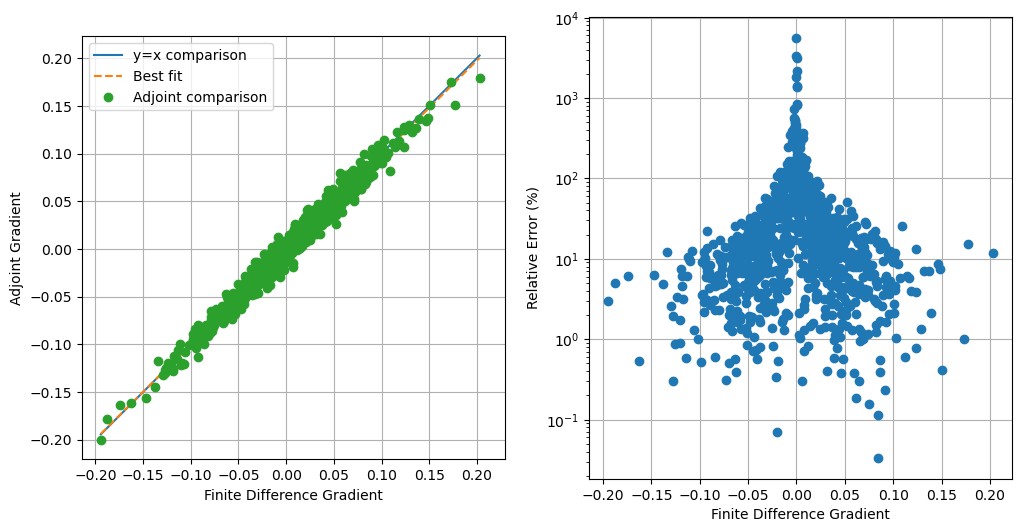

In [14]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (4.68,4.68,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (4.68,4.68,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)


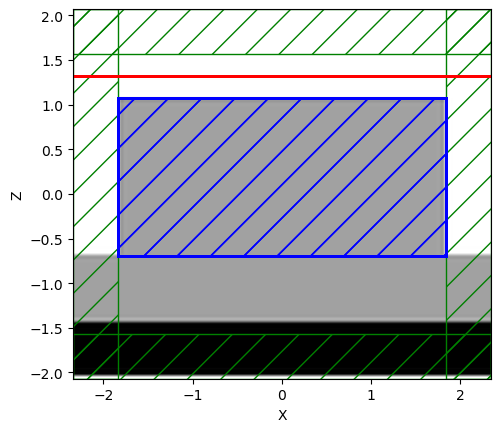

In [15]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [16]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]
